In [ ]:
import pandas as pd
import ast
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

DEBUG_MODE = False
SAMPLE_SIZE = 1000
TOP_K = 2500
SAVE_PATH = "/content/drive/MyDrive/hmm_model/"

df = pd.read_csv(f"{SAVE_PATH}cleaned_stackoverflow.csv")

if DEBUG_MODE:
    df = df.sample(n=SAMPLE_SIZE, random_state=42)
    print(f" DEBUG MODE ENABLED: Using only {SAMPLE_SIZE} samples")
else:
    print("FULL TRAINING MODE ENABLED")

def safe_parse(tag_str):
    try:
        return ast.literal_eval(tag_str) if isinstance(tag_str, str) else tag_str
    except:
        return []

df['tags'] = df['tags'].apply(safe_parse)

all_tags = sum(df['tags'].tolist(), [])
tag_counts = Counter(all_tags)
top_tags = set(tag for tag, _ in tag_counts.most_common(TOP_K))
print(f"Top {TOP_K} tags selected.")

filtered_texts, filtered_tags = [], []
for text, tag_list in zip(df['text'], df['tags']):
    tags = [tag for tag in tag_list if tag in top_tags]
    if tags:
        filtered_texts.append(text)
        filtered_tags.append(tags)

print(f" Filtered dataset: {len(filtered_texts)} samples retained.")

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(filtered_tags)


#  Split into train/val (90:10)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    filtered_texts, labels, test_size=0.1, random_state=42
)

print(f" Train samples: {len(train_texts)}")
print(f" Val samples: {len(val_texts)}")
print(f" Unique tags: {len(mlb.classes_)}")

train_df = pd.DataFrame({'text': train_texts, 'tags': mlb.inverse_transform(train_labels)})
val_df = pd.DataFrame({'text': val_texts, 'tags': mlb.inverse_transform(val_labels)})

train_df['tags'] = train_df['tags'].apply(lambda tag_list: ",".join(tag_list))
val_df['tags'] = val_df['tags'].apply(lambda tag_list: ",".join(tag_list))

train_df.to_csv(f"{SAVE_PATH}train_split.csv", index=False)
val_df.to_csv(f"{SAVE_PATH}val_split.csv", index=False)
print(f" Train and validation splits saved to: {SAVE_PATH}")


FULL TRAINING MODE ENABLED
Top 2500 tags selected.
 Filtered dataset: 48627 samples retained.
 Train samples: 43764
 Val samples: 4863
 Unique tags: 2500
 Train and validation splits saved to: /content/drive/MyDrive/hmm_model/


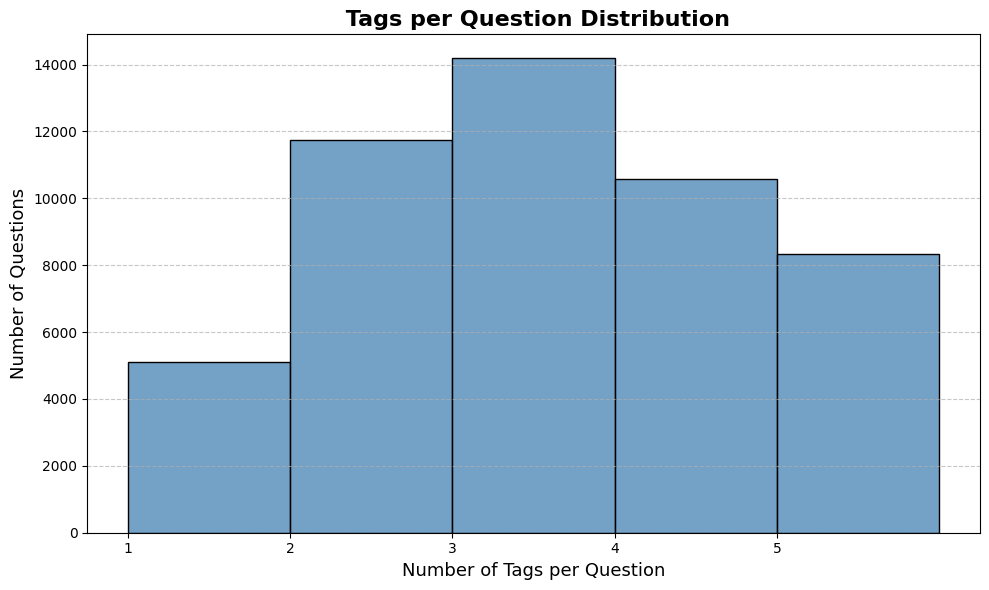

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


tags_per_question = df['tags'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(tags_per_question, bins=range(1, tags_per_question.max() + 2), edgecolor='black', color='steelblue')

plt.title(" Tags per Question Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Number of Tags per Question", fontsize=13)
plt.ylabel("Number of Questions", fontsize=13)
plt.xticks(range(1, tags_per_question.max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer
import numpy as np

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class TagDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = torch.from_numpy(np.array(labels)).float()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': self.labels[idx]
        }

train_dataset = TagDataset(train_texts, train_labels)
val_dataset = TagDataset(val_texts, val_labels)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MiniTagTransformer(nn.Module):
    def __init__(self, num_tags):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_tags)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)

model = MiniTagTransformer(num_tags=len(mlb.classes_)).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import pickle

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

best_val_loss = float('inf')
patience = 2
patience_counter = 0
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\n Epoch {epoch + 1}/{EPOCHS}")
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=" Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=" Validating..."):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f" Train Loss: {avg_train_loss:.4f} |  Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/hmm_model/trained_model.pt')
        with open('/content/drive/MyDrive/hmm_model/mlb.pkl', 'wb') as f:
            pickle.dump(mlb, f)
        print(" model saved!")
    else:
        patience_counter += 1
        print(f" Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(" Early stopping triggered.")
            break



 Epoch 1/10


 Validating...: 100%|██████████| 304/304 [00:46<00:00,  6.54it/s]


 Train Loss: 0.0498 |  Val Loss: 0.0080
 model saved!

 Epoch 2/10


 Validating...: 100%|██████████| 304/304 [00:45<00:00,  6.70it/s]


 Train Loss: 0.0071 |  Val Loss: 0.0065
 model saved!

 Epoch 3/10


 Validating...: 100%|██████████| 304/304 [00:45<00:00,  6.62it/s]


 Train Loss: 0.0059 |  Val Loss: 0.0053
 model saved!

 Epoch 4/10


 Validating...: 100%|██████████| 304/304 [00:46<00:00,  6.48it/s]


 Train Loss: 0.0049 |  Val Loss: 0.0046
 model saved!

 Epoch 5/10


 Validating...: 100%|██████████| 304/304 [00:45<00:00,  6.72it/s]


 Train Loss: 0.0041 |  Val Loss: 0.0041
 model saved!

 Epoch 6/10


 Validating...: 100%|██████████| 304/304 [00:44<00:00,  6.78it/s]


 Train Loss: 0.0036 |  Val Loss: 0.0037
 model saved!

 Epoch 7/10


 Validating...: 100%|██████████| 304/304 [00:46<00:00,  6.51it/s]


 Train Loss: 0.0032 |  Val Loss: 0.0035
 model saved!

 Epoch 8/10


 Validating...: 100%|██████████| 304/304 [00:46<00:00,  6.59it/s]


 Train Loss: 0.0028 |  Val Loss: 0.0033
 model saved!

 Epoch 9/10


 Validating...: 100%|██████████| 304/304 [00:45<00:00,  6.63it/s]


 Train Loss: 0.0025 |  Val Loss: 0.0032
 model saved!

 Epoch 10/10


 Validating...: 100%|██████████| 304/304 [00:45<00:00,  6.62it/s]


 Train Loss: 0.0022 |  Val Loss: 0.0031
 model saved!


In [ ]:
import torch
import numpy as np
import pickle
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
with open('/content/drive/MyDrive/hmm_model/mlb.pkl', 'rb') as f:
    mlb = pickle.load(f)

class MiniTagTransformer(nn.Module):
    def __init__(self, num_tags):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_tags)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)

model = MiniTagTransformer(num_tags=len(mlb.classes_))
model.load_state_dict(torch.load('/content/drive/MyDrive/hmm_model/trained_model.pt', map_location=device))
model.to(device)
model.eval()

def predict_tags(text, threshold=0.15, show_top_k=5, fallback=True):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"])
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()


    top_probs = sorted(enumerate(probs), key=lambda x: x[1], reverse=True)[:show_top_k]
    for i, p in top_probs:
        print(f"{mlb.classes_[i]}: {p:.4f}")

    predicted_indices = np.where(probs >= threshold)[0]
    tags = [mlb.classes_[i] for i in predicted_indices]

    if fallback and not tags:
        print(" No confident tags, returning top-K tags as fallback.")
        tags = [mlb.classes_[i] for i, _ in top_probs]

    return tags

example_question_1 = """
How to resolve CORS error when making a fetch request in JavaScript?

I'm working on a front-end application using plain JavaScript, and I'm trying to make a fetch call to an external API (https://api.example.com/data). However, I'm getting the following error in the console:

Access to fetch at 'https://api.example.com/data' from origin 'http://localhost:3000' has been blocked by CORS policy: No 'Access-Control-Allow-Origin' header is present on the requested resource.

I've tried setting mode: 'no-cors' in the fetch request, but it doesn't help. I'm not using any backend, just a simple HTML file served locally. Is there any way to fix this issue on the front-end or do I need to configure something on the server?

Here's my fetch code:

fetch('https://api.example.com/data', {
  method: 'GET',
  headers: {
    'Content-Type': 'application/json'
  }
})
.then(response => response.json())
.then(data => console.log(data))
.catch(error => console.error(error));
"""

example_question_2 = """
How can I rewrite a subquery into a JOIN for better performance in SQL?

I have this SQL query using a subquery that works, but it's quite slow:

SELECT name FROM employees WHERE department_id IN (
  SELECT id FROM departments WHERE location = 'New York'
);

I've read that using JOINs might be more efficient. How can I convert this to use an INNER JOIN instead of a subquery?
"""

example_question_3 = """
What is the best way to manage state in Flutter for a simple counter app?

I'm new to Flutter and trying to build a simple counter app. I want to update the counter value and reflect the changes in the UI. I've heard about Provider, Riverpod, and Bloc — but I’m not sure which one to use for a small app.

Do I need a package like Provider or can I just use setState inside a StatefulWidget?
"""

test_questions = [example_question_1, example_question_2, example_question_3]

for idx, q in enumerate(test_questions, 1):
    print(f"\n Test Question {idx}:")
    predicted_tags = predict_tags(q, threshold = 0.05, show_top_k=5)
    print(" Predicted Tags:", predicted_tags)





 Test Question 1:
javascript: 0.9888
cors: 0.4100
jquery: 0.2133
fetch-api: 0.1570
json: 0.1090
 Predicted Tags: ['ajax', 'cors', 'fetch-api', 'javascript', 'jquery', 'json', 'reactjs']

 Test Question 2:
sql: 0.9785
sql-server: 0.5410
t-sql: 0.1167
postgresql: 0.0513
join: 0.0413
 Predicted Tags: ['postgresql', 'sql', 'sql-server', 't-sql']

 Test Question 3:
flutter: 0.9998
dart: 0.6919
riverpod: 0.1992
flutter-dependencies: 0.0522
android: 0.0337
 Predicted Tags: ['dart', 'flutter', 'flutter-dependencies', 'riverpod']


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, hamming_loss
from tqdm import tqdm
import numpy as np
import time

start = time.time()

y_true = []
y_pred = []

for idx, text in tqdm(enumerate(val_texts), total=len(val_texts), desc=" Evaluating"):
    predicted_tags = predict_tags(text, threshold=0.055, show_top_k=5, fallback=True)
    pred_bin = np.zeros(len(mlb.classes_))
    for tag in predicted_tags:
        if tag in mlb.classes_:
            pred_bin[mlb.classes_.tolist().index(tag)] = 1

    y_pred.append(pred_bin)
    y_true.append(val_labels[idx])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# metrics
precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
jaccard = jaccard_score(y_true, y_pred, average='samples', zero_division=0)
exact_match = np.mean(np.all(y_true == y_pred, axis=1))
hamming = hamming_loss(y_true, y_pred)

p_at_5 = []
r_at_5 = []
f1_at_5 = []

for true, pred in tqdm(zip(y_true, y_pred), total=len(y_true)):
    true_set = set(np.where(true == 1)[0])
    pred_set = set(np.where(pred == 1)[0])

    intersection = true_set & pred_set

    prec = len(intersection) / min(5, len(pred_set)) if pred_set else 0
    rec = len(intersection) / len(true_set) if true_set else 0
    f1_score_5 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

    p_at_5.append(prec)
    r_at_5.append(rec)
    f1_at_5.append(f1_score_5)
end = time.time()
elapsed = end - start

print(f" Time Taken:        {elapsed:.2f} seconds")
print(f" Precision@5:       {np.mean(p_at_5):.4f}")
print(f" Recall@5:          {np.mean(r_at_5):.4f}")
print(f" F1@5:              {np.mean(f1_at_5):.4f}")
print(f" Jaccard@5:         {jaccard:.4f}")
print(f" Exact Match:       {exact_match:.4f}")
print(f" Hamming Loss:      {hamming:.4f}")
print(f" Micro F1 (all k):  {f1_micro:.4f}")
print(f" Macro F1 (all k):  {f1_macro:.4f}")


 Evaluating:   0%|          | 16/4863 [00:00<01:04, 74.94it/s]

reactjs: 0.9900
javascript: 0.3719
css: 0.3212
tailwind-css: 0.1157
typescript: 0.0929
php: 0.9917
pdo: 0.8965
mysql: 0.5702
sql: 0.0541
database: 0.0346
go: 0.9972
struct: 0.0265
json: 0.0196
python: 0.0150
grpc: 0.0103
python: 0.5799
jupyter-notebook: 0.3608
jupyter: 0.1852
ipython: 0.0892
pytorch: 0.0302
python: 0.9336
yaml: 0.3645
pydantic: 0.0578
python-3.x: 0.0401
ruamel.yaml: 0.0382
sql: 0.9501
sql-server: 0.2295
postgresql: 0.1400
t-sql: 0.0710
mysql: 0.0547
scala: 0.9698
apache-spark: 0.0888
python: 0.0326
unit-testing: 0.0242
java: 0.0106
c: 0.4958
c++: 0.3337
pointers: 0.2489
language-lawyer: 0.0603
function-pointers: 0.0210
sql: 0.3598
python: 0.2758
string: 0.1515
sql-server: 0.1360
t-sql: 0.0335
c++: 0.9756
boost: 0.7333
boost-asio: 0.2703
c++11: 0.0491
c++17: 0.0366
rust: 0.8610
linux: 0.2444
c: 0.1156
linux-kernel: 0.0289
ubuntu: 0.0243
kubernetes: 0.9910
kubectl: 0.0382
c#: 0.0279
azure-aks: 0.0207
minikube: 0.0183
node.js: 0.9890
express: 0.8824
mongodb: 0.4197
mongoo

 Evaluating:   0%|          | 24/4863 [00:00<01:06, 72.25it/s]

c: 0.9950
pointers: 0.3283
memory: 0.0584
struct: 0.0465
language-lawyer: 0.0452
flutter: 0.9988
dart: 0.2091
animation: 0.0544
flutter-dependencies: 0.0499
flutter-layout: 0.0445
swift: 0.0745
android: 0.0582
colors: 0.0517
math: 0.0326
r: 0.0211
python: 0.9830
asynchronous: 0.2586
python-3.x: 0.2134
async-await: 0.0700
multithreading: 0.0531
git: 0.9916
gitlab: 0.3706
github: 0.2683
docker: 0.1100
git-bash: 0.1041
javascript: 0.9723
html: 0.6630
xml: 0.1568
java: 0.0989
jquery: 0.0859
ionic-framework: 0.8703
javascript: 0.7779
angular: 0.0656
angularjs: 0.0266
typescript: 0.0245
react-native: 0.9242
ios: 0.3163
image: 0.0803
xcode: 0.0523
javascript: 0.0331
amazon-bedrock: 0.9090
amazon-web-services: 0.4069
large-language-model: 0.0695
python: 0.0572
terraform: 0.0314
pyqt: 0.8362
pyqt5: 0.6423
python: 0.4658
pyqt6: 0.2701
qt: 0.2223
node.js: 0.8744
google-cloud-platform: 0.8734
google-cloud-run: 0.3127
google-cloud-functions: 0.2029
gcloud: 0.1652
javascript: 0.7484
iframe: 0.2347
h

 Evaluating:   1%|          | 40/4863 [00:00<01:06, 73.03it/s]

javascript: 0.1076
authentication: 0.0932
python: 0.0333
security: 0.0309
oauth-2.0: 0.0305
kubernetes: 0.9765
docker: 0.6269
c#: 0.0631
.net: 0.0336
azure-aks: 0.0221
macos: 0.9955
r: 0.0620
homebrew: 0.0458
installation: 0.0270
terminal: 0.0165
spring-boot: 0.8271
java: 0.6694
utf-8: 0.3592
spring: 0.2109
xml: 0.0444
openapi: 0.9228
openapi-generator: 0.7635
swagger: 0.3746
java: 0.2655
swagger-ui: 0.1395
git: 0.9903
github: 0.1896
git-merge-conflict: 0.0179
branch: 0.0172
git-merge: 0.0156
python: 0.9808
audio: 0.5744
python-3.x: 0.2074
python-2.7: 0.0346
path: 0.0180
react-native: 0.9576
css: 0.1670
react-native-flatlist: 0.0877
reactjs: 0.0730
javascript: 0.0675
c#: 0.8359
unit-testing: 0.6287
azure-functions: 0.5462
.net: 0.1158
testing: 0.0872
swiftui: 0.9964
swift: 0.3195
ios: 0.2881
scrollview: 0.0469
xcode: 0.0400
git: 0.9303
github: 0.7188
caching: 0.1632
authentication: 0.0316
git-push: 0.0215
css: 0.8436
angular: 0.6478
html: 0.2185
angular-material: 0.1450
javascript: 0.0

 Evaluating:   1%|          | 56/4863 [00:00<01:09, 69.53it/s]

swiftui: 0.9937
swift: 0.4624
ios: 0.3001
animation: 0.0771
scrollview: 0.0641
reactjs: 0.9633
material-ui: 0.9593
css: 0.1694
javascript: 0.0812
html: 0.0392
spotify: 0.5316
javascript: 0.5042
html: 0.0202
authentication: 0.0192
browser: 0.0190
react-native: 0.6309
android: 0.5222
kotlin: 0.2650
google-signin: 0.0595
javascript: 0.0499
reactjs: 0.9872
javascript: 0.7036
react-native: 0.0571
pdf: 0.0468
css: 0.0131
material-ui: 0.9544
mui-x-charts: 0.8869
reactjs: 0.5700
charts: 0.1550
mui-x-tree-view: 0.1051
mui-x-data-grid: 0.9949
material-ui: 0.9931
reactjs: 0.8848
datagrid: 0.2765
javascript: 0.2667
stripe-payments: 0.9654
javascript: 0.4411
reactjs: 0.2334
typescript: 0.0397
php: 0.0373
jasper-reports: 0.6812
java: 0.1249
macos: 0.0103
datetime: 0.0042
ruby: 0.0034
expo: 0.9909
react-native: 0.9516
expo-router: 0.6836
reactjs: 0.2943
javascript: 0.2577
aws-lambda: 0.8811
python: 0.8291
amazon-web-services: 0.5977
python-3.x: 0.0770
amazon-s3: 0.0490
go: 0.9902
generics: 0.0139
win

 Evaluating:   2%|▏         | 73/4863 [00:01<01:03, 74.87it/s]

css: 0.9954
html: 0.6786
javascript: 0.2669
reactjs: 0.1152
flexbox: 0.0643
excel: 0.9368
python: 0.0579
excel-formula: 0.0375
pandas: 0.0115
java: 0.0105
docker: 0.9856
ubuntu: 0.7838
python: 0.2934
dockerfile: 0.2097
linux: 0.0530
playwright: 0.9923
typescript: 0.1306
node.js: 0.1243
playwright-python: 0.1032
playwright-test: 0.0806
python: 0.8908
virtualenv: 0.7156
django: 0.4621
pip: 0.1095
python-3.x: 0.0523
java: 0.7542
gradle: 0.6065
kotlin: 0.0241
android: 0.0149
build.gradle: 0.0128
rest: 0.2065
multithreading: 0.0329
logging: 0.0171
active-directory: 0.0158
performance: 0.0144
json: 0.9727
c#: 0.3187
jackson: 0.2111
java: 0.0607
jq: 0.0292
jestjs: 0.9552
typescript: 0.1905
node.js: 0.1099
unit-testing: 0.1087
ts-jest: 0.0877
laravel-livewire: 0.5513
javascript: 0.5366
laravel: 0.2299
reactjs: 0.0362
node.js: 0.0257
python: 0.9826
websocket: 0.3697
python-3.x: 0.1134
python-asyncio: 0.0935
fastapi: 0.0502
perl: 0.4699
postgresql: 0.0618
ubuntu: 0.0223
python: 0.0178
django: 0.

 Evaluating:   2%|▏         | 91/4863 [00:01<01:01, 77.37it/s]

material-ui: 0.9973
mui-x-data-grid: 0.9947
reactjs: 0.7676
datagrid: 0.3169
javascript: 0.1571
android: 0.8675
java: 0.5182
firebase: 0.2871
flutter: 0.0763
gradle: 0.0634
kotlin: 0.9913
android: 0.4684
kotlin-multiplatform: 0.1394
kotlin-coroutines: 0.1160
android-studio: 0.0877
docker: 0.7173
gitlab-ci: 0.4047
gitlab: 0.3730
gitlab-ci-runner: 0.0685
cicd: 0.0372
unity-game-engine: 0.9930
c#: 0.1120
visual-studio: 0.0140
game-development: 0.0136
debugging: 0.0129
javascript: 0.9729
reactjs: 0.4305
jquery: 0.0864
spotify: 0.0697
fetch-api: 0.0413
python: 0.9518
json: 0.8980
flask: 0.7528
html: 0.2450
python-3.x: 0.1125
wix: 0.8217
c#: 0.6868
.net: 0.4180
windows-installer: 0.1153
asp.net-core: 0.0158
curl: 0.6326
php: 0.0509
java: 0.0399
linux: 0.0362
c: 0.0302
vue.js: 0.8938
javascript: 0.8563
vuejs3: 0.6076
vuejs2: 0.1281
vue-component: 0.1097
wix: 0.7847
windows-installer: 0.0741
javascript: 0.0266
installation: 0.0214
node.js: 0.0106
java: 0.6896
c#: 0.0432
performance: 0.0094
exc

 Evaluating:   2%|▏         | 101/4863 [00:01<01:00, 78.17it/s]

azure: 0.9717
terraform: 0.8994
terraform-provider-azure: 0.3583
azure-virtual-machine: 0.1131
azure-active-directory: 0.0551
flutter: 0.9983
ios: 0.3338
ffmpeg: 0.1864
cocoapods: 0.1482
dart: 0.1178
pdf: 0.4854
r: 0.0699
latex: 0.0319
pdfbox: 0.0120
pdf-generation: 0.0109
node.js: 0.9366
amazon-s3: 0.8681
amazon-web-services: 0.4441
javascript: 0.1810
boto3: 0.0269
reactjs: 0.9929
react-hooks: 0.7558
javascript: 0.3043
react-hook-form: 0.0575
react-query: 0.0498
salesforce: 0.9494
salesforce-lightning: 0.4724
apex: 0.0620
apex-code: 0.0430
python: 0.0348
c#: 0.9752
selenium-webdriver: 0.5370
java: 0.0827
selenium: 0.0631
.net: 0.0355
python: 0.9864
python-typing: 0.8193
mypy: 0.5425
python-3.x: 0.1827
pyright: 0.0820
reactjs: 0.9879
tailwind-css: 0.5068
javascript: 0.0700
npm: 0.0695
vite: 0.0636
android: 0.9747
android-jetpack-compose: 0.9411
kotlin: 0.3046
android-jetpack: 0.0445
dagger-hilt: 0.0326
java: 0.9102
sockets: 0.5099
tcp: 0.0668
socket.io: 0.0586
websocket: 0.0397
reactjs

 Evaluating:   2%|▏         | 117/4863 [00:01<01:05, 72.22it/s]

flutter: 0.9988
dart: 0.4433
flutter-dependencies: 0.0224
flutter-bloc: 0.0113
android: 0.0104
c++: 0.9964
visual-c++: 0.1424
performance: 0.0991
mpi: 0.0819
winapi: 0.0396
xcode: 0.9201
flutter: 0.8496
ios: 0.7700
swift: 0.3287
iphone: 0.0336
visual-studio-code: 0.8510
arduino: 0.3860
c: 0.0656
debugging: 0.0354
c++: 0.0290
ubuntu: 0.8187
linux: 0.0232
ubuntu-24.04: 0.0219
apt: 0.0138
linux-kernel: 0.0110
ssl: 0.8321
php: 0.2688
https: 0.1274
apache: 0.0896
windows: 0.0718
css: 0.9991
html: 0.8911
twitter-bootstrap: 0.1071
flexbox: 0.0546
bootstrap-5: 0.0527
next.js: 0.9933
javascript: 0.4579
reactjs: 0.3172
next.js13: 0.0985
server-side-rendering: 0.0760
python: 0.9870
python-3.x: 0.2611
python-2.7: 0.0554
pip: 0.0542
package: 0.0393
qt: 0.8094
qt5: 0.0716
qml: 0.0480
c++: 0.0387
user-interface: 0.0168
python: 0.9404
html: 0.5751
fastapi: 0.4560
python-3.x: 0.1601
jinja2: 0.1336
python: 0.9988
python-3.x: 0.4483
python-2.7: 0.0305
python-asyncio: 0.0086
python-requests: 0.0084
python

 Evaluating:   3%|▎         | 132/4863 [00:01<01:17, 60.90it/s]

google-chrome: 0.5816
javascript: 0.3526
google-chrome-extension: 0.2469
google-chrome-devtools: 0.1114
chrome-extension-manifest-v3: 0.0248
csv: 0.8751
excel: 0.5419
powershell: 0.0994
directory: 0.0140
file: 0.0133
git: 0.9907
merge: 0.0594
github: 0.0433
git-merge: 0.0417
branch: 0.0308
c++: 0.9926
c++20: 0.1554
c++11: 0.0925
c++17: 0.0384
c++-concepts: 0.0336
wordpress: 0.9738
php: 0.3249
url: 0.0652
http-redirect: 0.0501
wordpress-theming: 0.0422
nestjs: 0.9797
authentication: 0.2013
node.js: 0.0569
typeorm: 0.0551
typescript: 0.0538
python: 0.9812
pip: 0.5030
python-3.x: 0.1817
pyproject.toml: 0.0877
uv: 0.0479
angular: 0.8370
authentication: 0.2315
auth0: 0.1579
next.js: 0.1331
next-auth: 0.1321
python: 0.9779
flask: 0.9774
html: 0.1678
python-3.x: 0.1374
flask-sqlalchemy: 0.0822
python: 0.9543
azure: 0.5144
langchain: 0.2117
large-language-model: 0.0944
python-3.x: 0.0483
c#: 0.9985
.net: 0.2404
.net-core: 0.0111
file: 0.0076
asp.net-core: 0.0057


 Evaluating:   3%|▎         | 139/4863 [00:01<01:16, 61.57it/s]

firebase: 0.9193
google-cloud-functions: 0.7911
node.js: 0.6070
javascript: 0.4374
google-cloud-firestore: 0.2648
excel: 0.9599
excel-formula: 0.8656
conditional-statements: 0.0453
cell: 0.0429
formula: 0.0299
reactjs: 0.9608
material-ui: 0.9218
javascript: 0.3017
css: 0.0463
html: 0.0151
php: 0.8008
html: 0.7339
regex: 0.1308
javascript: 0.0579
string: 0.0288
centos: 0.5808
centos7: 0.2327
linux: 0.0337
apache: 0.0183
java: 0.0144
node.js: 0.9444
websocket: 0.6447
javascript: 0.3939
socket.io: 0.1378
express: 0.0334
ios: 0.7108
swift: 0.6337
objective-c: 0.1080
uikit: 0.0968
iphone: 0.0417
powerbi: 0.9796
python: 0.5966
powerbi-desktop: 0.2373
powerquery: 0.2255
dax: 0.1118
python: 0.9944
matplotlib: 0.4865
plot: 0.0999
image-processing: 0.0869
python-imaging-library: 0.0867
next.js: 0.9906
reactjs: 0.7945
javascript: 0.2424
next.js13: 0.1245
nextjs-15: 0.0836
pdf: 0.8835
node.js: 0.8624
pdf-generation: 0.1814
javascript: 0.1684
pdfbox: 0.0467
csv: 0.8403
arrays: 0.7663
php: 0.1086
r:

 Evaluating:   3%|▎         | 152/4863 [00:02<01:21, 57.45it/s]

powershell: 0.9943
regex: 0.0214
powershell-2.0: 0.0139
windows: 0.0134
string: 0.0126
docker: 0.9411
docker-compose: 0.7512
python: 0.0696
dockerfile: 0.0345
environment-variables: 0.0092
android: 0.9897
kotlin: 0.4361
android-studio: 0.1656
java: 0.0256
adb: 0.0246
python: 0.9739
python-asyncio: 0.7606
python-3.x: 0.1737
fastapi: 0.0472
docker: 0.0427
pine-script: 0.8677
pine-script-v5: 0.1071
tradingview-api: 0.0521
pine-script-v6: 0.0413
trading: 0.0116
arm: 0.5774
linux-kernel: 0.4652
c: 0.2814
linux: 0.2434
assembly: 0.2087
reactjs: 0.8003
npm: 0.7083
node.js: 0.2241
javascript: 0.1201
npm-install: 0.0958
google-apps-script: 0.9935
google-sheets: 0.7027
javascript: 0.4744
triggers: 0.0790
google-forms: 0.0477
tcp: 0.1354
network-programming: 0.0762
linux: 0.0557
security: 0.0383
java: 0.0365
json: 0.9585
batch-file: 0.1890
windows: 0.0664
parsing: 0.0375
cmd: 0.0195
spss-files: 0.9966
r: 0.1807
import: 0.1202
r-haven: 0.0644
node.js: 0.0402
python-sphinx: 0.3756
python: 0.1147
ma

 Evaluating:   3%|▎         | 166/4863 [00:02<01:24, 55.67it/s]

kubernetes: 0.9740
docker: 0.7745
kubernetes-ingress: 0.0476
kubernetes-helm: 0.0436
kubectl: 0.0391
amazon-web-services: 0.7220
apache-spark: 0.6522
amazon-s3: 0.0481
aws-glue: 0.0366
pyspark: 0.0254
javascript: 0.9878
office-js: 0.2194
excel: 0.1978
next.js: 0.0612
typescript: 0.0561
javascript: 0.8657
arrays: 0.8471
php: 0.1343
datatable: 0.1319
jquery: 0.0970
reactjs: 0.9932
javascript: 0.5886
next.js: 0.0901
highcharts: 0.0585
typescript: 0.0486
windows: 0.6528
c: 0.4416
c++: 0.1929
winapi: 0.1485
network-programming: 0.0395
mongodb: 0.9633
vercel: 0.5464
javascript: 0.3554
mongoose: 0.2405
node.js: 0.2357
flutter: 0.9908
visual-studio-code: 0.9591
dart: 0.8510
xcode: 0.0971
windows: 0.0403
c#: 0.9982
.net: 0.5195
asp.net-core: 0.0487
winforms: 0.0447
.net-core: 0.0427
c#: 0.8944
multithreading: 0.2612
sql-server: 0.1382
concurrency: 0.0431
database: 0.0385
latex: 0.3673
ms-word: 0.1970
r: 0.0251
regex: 0.0221
fonts: 0.0119


 Evaluating:   4%|▎         | 173/4863 [00:02<01:19, 59.00it/s]

spss-files: 0.9982
python: 0.5073
r: 0.1059
import: 0.1010
r-haven: 0.0295
delphi: 0.9714
excel: 0.1380
delphi-12-athens: 0.0697
ms-word: 0.0632
vba: 0.0631
terraform: 0.9791
amazon-web-services: 0.6139
terraform-provider-aws: 0.4758
amazon-ec2: 0.1316
aws-cloudformation: 0.0206
c#: 0.8090
.net: 0.7659
asp.net-core: 0.2619
.net-core: 0.1449
asp.net: 0.0459
node.js: 0.9349
express: 0.7795
postgresql: 0.6926
sequelize.js: 0.3342
javascript: 0.0646
arm: 0.5950
assembly: 0.3182
embedded: 0.1228
x86: 0.0655
c: 0.0535
asp.net-core: 0.9014
c#: 0.6562
asp.net: 0.1906
asp.net-core-webapi: 0.1036
asp.net-core-mvc: 0.0803
twitter-bootstrap: 0.7865
css: 0.7525
html: 0.4776
bootstrap-4: 0.2284
jquery: 0.2148


 Evaluating:   4%|▍         | 186/4863 [00:02<01:36, 48.58it/s]

python: 0.9847
fastapi: 0.1851
python-3.x: 0.1256
scikit-learn: 0.1197
machine-learning: 0.0965
redis: 0.9686
docker: 0.6781
java: 0.0522
docker-compose: 0.0506
caching: 0.0269
ubuntu: 0.8290
.net: 0.5350
asp.net-core: 0.3276
visual-studio: 0.3198
c#: 0.1360
ssl: 0.8928
c#: 0.6021
ssl-certificate: 0.4959
https: 0.1253
openssl: 0.0929
java: 0.7293
enums: 0.4114
rest: 0.2932
jackson: 0.0426
annotations: 0.0411
asp.net: 0.8943
gridview: 0.8877
c#: 0.8475
webforms: 0.1356
.net: 0.0899
oracle-apex: 0.8756
oracle-database: 0.6745
plsql: 0.1880
apex: 0.1367
sql: 0.0844
python: 0.6369
gnuplot: 0.1522
matplotlib: 0.0563
python-3.x: 0.0425
math: 0.0305
opencv: 0.9834
python: 0.3850
computer-vision: 0.3457
image-processing: 0.1579
ocr: 0.0763
magento: 0.8422
magento2: 0.3061
php: 0.0907
javascript: 0.0079
html: 0.0052
android: 0.9431
ionic-framework: 0.9113
angular: 0.8152
capacitor: 0.3839
node.js: 0.1322


 Evaluating:   4%|▍         | 198/4863 [00:03<01:30, 51.82it/s]

java: 0.5336
intellij-idea: 0.4390
debugging: 0.0746
maven: 0.0746
cassandra: 0.0642
github: 0.9371
visual-studio-code: 0.7691
github-actions: 0.0414
git: 0.0273
github-api: 0.0203
cypress: 0.9113
angular: 0.7963
angular-material: 0.4132
typescript: 0.1318
javascript: 0.0621
c++: 0.9514
pointers: 0.3248
arrays: 0.0679
language-lawyer: 0.0316
c++20: 0.0297
bash: 0.8732
linux: 0.2037
shell: 0.0697
unix: 0.0561
multithreading: 0.0372
spring-boot: 0.9324
java: 0.3778
spring: 0.2505
maven: 0.0217
spring-mvc: 0.0144
c: 0.0553
python: 0.0202
c#: 0.0136
performance: 0.0121
floating-point: 0.0118
visual-studio-code: 0.9841
markdown: 0.2091
vscode-extensions: 0.0608
c: 0.0487
terminal: 0.0297
reactjs: 0.8559
next.js: 0.1369
javascript: 0.0754
node.js: 0.0542
react-hooks: 0.0412
webrtc: 0.6233
java: 0.1952
android: 0.0318
ubuntu: 0.0197
amazon-ec2: 0.0165
bitbucket: 0.6124
bitbucket-pipelines: 0.2650
git: 0.0265
amazon-web-services: 0.0258
gitlab: 0.0257
r: 0.9868
shiny: 0.9766
plotly: 0.1629
shi

 Evaluating:   4%|▍         | 210/4863 [00:03<01:34, 49.06it/s]

material-ui: 0.9903
reactjs: 0.9263
javascript: 0.4344
css: 0.2351
html: 0.0781
pytorch: 0.9727
python: 0.8097
torch: 0.0979
python-3.x: 0.0874
windows: 0.0402
sql-server: 0.9078
sql: 0.6228
t-sql: 0.2254
datetime: 0.0964
sql-server-2008: 0.0360
twitter-bootstrap: 0.7923
html: 0.7081
css: 0.4590
bootstrap-5: 0.1642
bootstrap-4: 0.1125
microsoft-fabric: 0.5809
python: 0.1867
azure-data-factory: 0.0527
powerbi: 0.0171
rest: 0.0132
azure: 0.9557
terraform: 0.9155
terraform-provider-azure: 0.5105
azure-virtual-machine: 0.0562
azure-active-directory: 0.0380
docker: 0.8670
macos: 0.4267
flutter: 0.2535
ubuntu: 0.0641
linux: 0.0399
flutter: 0.9993
android: 0.4400
dart: 0.3819
firebase: 0.1290
flutter-dependencies: 0.0506
xslt: 0.7873
xml: 0.6141
saxon: 0.0545
openssl: 0.0376
xsd: 0.0276


 Evaluating:   4%|▍         | 216/4863 [00:03<01:48, 42.93it/s]

c++: 0.7609
c: 0.4336
windows: 0.3831
python: 0.1594
string: 0.0893
angular: 0.9982
typescript: 0.1592
angular19: 0.1203
angular-cli: 0.1013
angular-signals: 0.0725
python: 0.7513
opencv: 0.6587
ocr: 0.1523
computer-vision: 0.0771
image-processing: 0.0740
bash: 0.9674
string: 0.2508
sed: 0.1999
shell: 0.1489
awk: 0.0973
python: 0.9312
visual-studio-code: 0.4275
python-3.x: 0.1324
terminal: 0.0807
python-2.7: 0.0257
slurm: 0.7280
arrays: 0.0208
python: 0.0205
docker: 0.0097
c++: 0.0062
db2: 0.8753
dbeaver: 0.0830
sql: 0.0674
database: 0.0504
dbt: 0.0460
large-language-model: 0.5275
ollama: 0.1613
python: 0.1285
langchain: 0.1058
openai-api: 0.0840
html: 0.9835
javascript: 0.4084
dom: 0.0277
angularjs: 0.0215
jquery: 0.0211


 Evaluating:   5%|▍         | 228/4863 [00:03<01:34, 48.97it/s]

java: 0.7822
hibernate: 0.1459
kotlin: 0.1098
jpa: 0.0900
spring: 0.0660
material-ui: 0.9904
reactjs: 0.7703
mui-autocomplete: 0.6919
autocomplete: 0.4707
javascript: 0.1217
reactjs: 0.9296
json: 0.7803
javascript: 0.6083
material-ui: 0.0401
jwt: 0.0352
ionic-framework: 0.8976
ios: 0.6988
android: 0.6162
capacitor: 0.6061
cordova: 0.1033
reactjs: 0.9831
mui-x-data-grid: 0.9548
material-ui: 0.9354
axios: 0.3206
datagrid: 0.1754
material-ui: 0.9989
mui-x-data-grid: 0.9826
reactjs: 0.9595
javascript: 0.4533
datagrid: 0.3681
ssl-certificate: 0.4938
ssl: 0.3876
c#: 0.2072
.net: 0.2067
certificate: 0.1771
protocol-buffers: 0.8898
c++: 0.5678
grpc: 0.0316
templates: 0.0213
node.js: 0.0192
c#: 0.3816
.net: 0.2292
uwp: 0.1279
maui: 0.1156
asp.net-core: 0.0737
python: 0.9863
python-requests: 0.6361
python-3.x: 0.1142
image: 0.1052
http: 0.0881
qt: 0.9835
c++: 0.4367
qml: 0.4314
qt5: 0.1410
qt6: 0.0729


 Evaluating:   5%|▍         | 234/4863 [00:03<01:53, 40.79it/s]

azure: 0.4938
asp.net-core: 0.3812
authentication: 0.2809
angular: 0.1859
azure-active-directory: 0.1781
r: 0.8898
matlab: 0.8804
plot: 0.0632
matrix: 0.0315
for-loop: 0.0184
javascript: 0.1211
next.js: 0.1077
tailwind-css: 0.0688
typescript: 0.0688
node.js: 0.0591
java: 0.8303
spring-boot: 0.6002
spring: 0.2128
validation: 0.1149
spring-security: 0.0970
javascript: 0.9906
jquery: 0.8661
html: 0.6005
css: 0.0696
angularjs: 0.0473
unit-testing: 0.7547
c#: 0.1715
testing: 0.1354
swift: 0.1062
nunit: 0.0486
vba: 0.9906
powerpoint: 0.3132
excel: 0.2763
ms-access: 0.0397
ms-word: 0.0238
amazon-web-services: 0.8898
aws-lambda: 0.7956
amazon-s3: 0.0985
python: 0.0653
boto3: 0.0243


 Evaluating:   5%|▌         | 246/4863 [00:04<01:45, 43.90it/s]

c: 0.9969
floating-point: 0.0403
memory: 0.0315
performance: 0.0261
struct: 0.0240
python: 0.4756
python-3.x: 0.0381
nlp: 0.0280
dictionary: 0.0195
optimization: 0.0156
next.js: 0.8093
aws-amplify: 0.6243
amazon-web-services: 0.3230
reactjs: 0.1339
typescript: 0.0638
android: 0.9670
java: 0.3210
android-studio: 0.1647
android-layout: 0.0965
xml: 0.0352
git: 0.9884
github: 0.8426
git-submodules: 0.0406
commit: 0.0382
gitignore: 0.0337
python: 0.8923
unit-testing: 0.0232
dataframe: 0.0231
pandas: 0.0187
python-3.x: 0.0161
c#: 0.5122
azure-devops: 0.4374
.net: 0.3336
asp.net-core: 0.2601
.net-core: 0.1910
react-native: 0.9880
android: 0.2677
javascript: 0.2537
html: 0.0312
webview: 0.0292
android: 0.9639
python: 0.6957
kivy: 0.6599
buildozer: 0.0522
python-3.x: 0.0394


 Evaluating:   5%|▌         | 251/4863 [00:04<01:47, 42.94it/s]

php: 0.9991
html: 0.4368
increment: 0.1951
counter: 0.1650
wordpress: 0.1481
node.js: 0.1333
javascript: 0.1298
clojure: 0.0690
ruby-on-rails: 0.0404
python: 0.0327
apache-spark: 0.8883
apache-kafka: 0.5654
pyspark: 0.1859
scala: 0.1650
apache-spark-sql: 0.0606
google-chrome-extension: 0.7008
google-chrome: 0.3288
javascript: 0.0980
google-chrome-devtools: 0.0228
chrome-extension-manifest-v3: 0.0166
azure: 0.9292
azure-container-apps: 0.5486
docker: 0.1379
azure-devops: 0.0470
azure-web-app-service: 0.0458
multithreading: 0.1013
java: 0.0771
performance: 0.0338
c: 0.0331
c++: 0.0292
spring-security: 0.7568
java: 0.7250
spring: 0.6645
spring-boot: 0.2246
spring-mvc: 0.1901


 Evaluating:   5%|▌         | 262/4863 [00:04<01:51, 41.16it/s]

c#: 0.1434
java: 0.0394
node.js: 0.0264
multithreading: 0.0192
typescript: 0.0107
autodesk-forge: 0.7670
autodesk: 0.2550
autodesk-model-derivative: 0.2217
autodesk-viewer: 0.1613
javascript: 0.0594
kubernetes: 0.9563
google-kubernetes-engine: 0.2307
docker: 0.2231
google-cloud-platform: 0.2213
kubernetes-helm: 0.1268
javascript: 0.9662
vue.js: 0.0649
typescript: 0.0569
next.js: 0.0447
reactjs: 0.0294
kubernetes: 0.9555
amazon-web-services: 0.6248
amazon-eks: 0.3578
kubectl: 0.0390
azure-aks: 0.0275
cuda: 0.5616
gpu: 0.4560
nvidia: 0.3918
multiprocessing: 0.0660
python: 0.0500
nestjs: 0.8848
postgresql: 0.8203
typeorm: 0.4438
typescript: 0.3780
node.js: 0.2857
spring-boot: 0.8128
java: 0.4191
multithreading: 0.2224
spring: 0.1722
rest: 0.0518
yaml: 0.5348
python: 0.1090
azure-pipelines-yaml: 0.0560
ruamel.yaml: 0.0173
azure-pipelines: 0.0150
swift: 0.9459
ios: 0.9007
wkwebview: 0.1680
objective-c: 0.1222
iphone: 0.1071
r: 0.9951
dataframe: 0.6743
dplyr: 0.2652
pandas: 0.0748
spss-files

 Evaluating:   6%|▌         | 276/4863 [00:04<01:26, 53.13it/s]

next.js: 0.8580
fonts: 0.4671
reactjs: 0.2738
javascript: 0.0831
css: 0.0749
yaml: 0.8651
azure-pipelines-yaml: 0.2073
azure-devops: 0.1623
azure-pipelines: 0.0881
azure: 0.0404
react-native: 0.8950
gradle: 0.7406
reactjs: 0.3766
android: 0.1231
node.js: 0.0776
javascript: 0.9891
css: 0.2094
animation: 0.1599
reactjs: 0.1423
canvas: 0.0520
angular: 0.9928
angular-reactive-forms: 0.2399
typescript: 0.1889
angular-forms: 0.0830
angular-signals: 0.0784
mui-x-data-grid: 0.9974
material-ui: 0.9928
reactjs: 0.8797
datagrid: 0.3866
javascript: 0.3085
python: 0.8216
networkx: 0.5019
graph: 0.2190
python-3.x: 0.0292
graph-theory: 0.0192
android-studio: 0.9189
android: 0.7478
java: 0.0880
kotlin: 0.0190
sdk: 0.0097
next.js: 0.7362
playwright: 0.6085
typescript: 0.5868
reactjs: 0.3632
node.js: 0.3205
material-ui: 0.9839
reactjs: 0.9138
mui-autocomplete: 0.5123
autocomplete: 0.1269
javascript: 0.1072
java: 0.9862
swing: 0.8482
javafx: 0.0447
java-8: 0.0170
javascript: 0.0128
swift: 0.9408
date: 0.

 Evaluating:   6%|▌         | 293/4863 [00:05<01:11, 64.23it/s]

c++: 0.9471
python: 0.0526
performance: 0.0364
function: 0.0353
c: 0.0313
java: 0.7992
visual-studio-code: 0.6944
jar: 0.1684
maven: 0.0951
eclipse: 0.0379
reactjs: 0.9323
react-testing-library: 0.4312
javascript: 0.1686
jestjs: 0.1357
react-hooks: 0.1136
python: 0.9829
performance: 0.0778
python-3.x: 0.0519
audio: 0.0453
math: 0.0350
next.js: 0.8971
next-auth: 0.8438
authentication: 0.1998
javascript: 0.0730
typescript: 0.0620
c++: 0.9963
c++20: 0.1565
c++11: 0.1024
c++17: 0.0591
language-lawyer: 0.0507
typo3: 0.9512
php: 0.4364
.htaccess: 0.0278
composer-php: 0.0215
wordpress: 0.0203
python: 0.8406
pycharm: 0.7540
macos: 0.1034
python-3.x: 0.0339
windows: 0.0302
docker: 0.9292
gitlab: 0.2738
java: 0.2149
gitlab-ci: 0.1815
kubernetes: 0.1159
flutter: 0.9980
dart: 0.1944
flutter-layout: 0.0442
android: 0.0361
widget: 0.0268
oracle-database: 0.8660
sql: 0.6800
plsql: 0.1181
oracle11g: 0.0695
sql-server: 0.0467
oracle-database: 0.9278
oracle11g: 0.1214
plsql: 0.0446
sql: 0.0413
oracle-sq

 Evaluating:   6%|▋         | 309/4863 [00:05<01:05, 69.50it/s]

crewai: 0.1923
large-language-model: 0.1524
python: 0.1490
langchain: 0.0565
artificial-intelligence: 0.0242
python: 0.9952
python-3.x: 0.2768
python-2.7: 0.0266
path: 0.0151
pycharm: 0.0123
mongodb: 0.7767
database: 0.1690
php: 0.1241
sql: 0.0787
sqlite: 0.0623
python: 0.8906
nlp: 0.5721
machine-learning: 0.1365
python-3.x: 0.1201
huggingface-transformers: 0.0864
python: 0.9488
linux: 0.3302
sftp: 0.1519
python-3.x: 0.0957
unix: 0.0700
javascript: 0.1189
opengl: 0.0850
webgl: 0.0122
graphics: 0.0108
chart.js: 0.0105
gridview: 0.8004
asp.net: 0.7913
c#: 0.4983
.net: 0.1039
webforms: 0.0691
sql-server: 0.9957
t-sql: 0.6751
sql: 0.6243
sql-server-2008: 0.2236
stored-procedures: 0.0903
sql-server: 0.9008
db2: 0.2770
sql: 0.1724
database: 0.1087
t-sql: 0.0901
visual-studio-code: 0.9985
python: 0.2478
vscode-extensions: 0.1208
jupyter-notebook: 0.0958
vscode-debugger: 0.0621
list: 0.8713
python: 0.6272
algorithm: 0.2240
ocaml: 0.0546
string: 0.0534
gdb: 0.8798
c: 0.0839
debugging: 0.0433
li

 Evaluating:   7%|▋         | 325/4863 [00:05<01:04, 70.36it/s]

python: 0.9646
kivy: 0.9064
python-3.x: 0.2134
android: 0.0858
buildozer: 0.0269
javascript: 0.9461
c++: 0.1874
function: 0.0541
performance: 0.0229
typescript: 0.0223
rust: 0.8832
c++: 0.0903
node.js: 0.0408
rust-cargo: 0.0227
linux: 0.0180
spring: 0.8949
java: 0.7219
spring-webflux: 0.5381
spring-mvc: 0.1557
spring-webclient: 0.1168
php: 0.9493
twig: 0.2935
symfony: 0.0529
laravel: 0.0176
javascript: 0.0102
hibernate: 0.9471
java: 0.7772
spring: 0.0687
jpa: 0.0571
postgresql: 0.0317
android: 0.9956
android-layout: 0.1253
java: 0.0823
android-activity: 0.0502
kotlin: 0.0427
javascript: 0.3799
typescript: 0.1886
reactjs: 0.1755
node.js: 0.0365
angular: 0.0344
swift: 0.6630
ios: 0.5060
objective-c: 0.3006
macos: 0.1400
swiftui: 0.1394
ssl: 0.0838
java: 0.0672
kotlin: 0.0623
android: 0.0566
gradle: 0.0401
laravel: 0.9647
laravel-livewire: 0.8104
php: 0.7567
livewire-3: 0.0677
laravel-blade: 0.0397
css: 0.9944
html: 0.9385
media-queries: 0.0409
javascript: 0.0276
flexbox: 0.0193
selenium-

 Evaluating:   7%|▋         | 333/4863 [00:05<01:04, 70.03it/s]

wpf: 0.7702
c#: 0.4225
xaml: 0.1698
.net: 0.0912
github: 0.0292
java: 0.4521
apache: 0.0758
apache-beam: 0.0745
maven: 0.0197
google-cloud-dataflow: 0.0120
javascript: 0.9602
node.js: 0.0301
typescript: 0.0165
azure: 0.0078
reactjs: 0.0074
objective-c: 0.5039
swift: 0.3912
ios: 0.3220
xcode: 0.0852
cocoa: 0.0769
redux: 0.5444
redux-toolkit: 0.4220
react-redux: 0.2678
reactjs: 0.2538
javascript: 0.2257
android: 0.9861
java: 0.1145
flutter: 0.0630
android-layout: 0.0440
android-activity: 0.0353
swiftui: 0.9979
ios: 0.4747
swift: 0.4154
swiftui-list: 0.0495
scrollview: 0.0434
apache: 0.6924
macos: 0.1676
java: 0.0755
mysql: 0.0547
xampp: 0.0541
excel-formula: 0.5643
excel: 0.3284
google-sheets: 0.2333
google-sheets-formula: 0.1296
filter: 0.0443
webrtc: 0.7956
rtsp: 0.2966
gstreamer: 0.1628
video-streaming: 0.1438
vlc: 0.1175
python: 0.9965
sqlalchemy: 0.9834
pandas: 0.4090
sql-server: 0.1930
flask-sqlalchemy: 0.1584
flutter: 0.9990
dart: 0.4694
flutter-dependencies: 0.0248
javascript: 0.

 Evaluating:   7%|▋         | 348/4863 [00:05<01:06, 68.08it/s]

reactjs: 0.8874
react-hook-form: 0.4849
react-hooks: 0.3496
typescript: 0.1563
javascript: 0.0727
itext: 0.7626
itext7: 0.5954
pdf: 0.3531
java: 0.2598
pdf-generation: 0.0806
anaconda: 0.9495
python: 0.8542
conda: 0.7385
python-3.x: 0.2037
anaconda3: 0.1919
android: 0.9617
maui: 0.0770
sdk: 0.0519
camera: 0.0393
bluetooth: 0.0364
docker: 0.9203
docker-compose: 0.2742
cloudflare: 0.2352
dockerfile: 0.0367
proxy: 0.0320
azure-devops: 0.9404
azure-pipelines-yaml: 0.7570
azure-pipelines: 0.6587
yaml: 0.1979
azure: 0.0839
python: 0.9709
python-3.x: 0.0706
python-2.7: 0.0405
audio: 0.0209
beautifulsoup: 0.0167
rust: 0.9154
generics: 0.0580
lifetime: 0.0240
borrow-checker: 0.0193
struct: 0.0189
maui: 0.8541
c#: 0.3038
xaml: 0.0802
.net: 0.0380
maui-community-toolkit: 0.0188
php: 0.9040
postgresql: 0.3225
database: 0.0896
mysql: 0.0735
codeigniter: 0.0529
mui-x-date-picker: 0.9907
material-ui: 0.9800
reactjs: 0.9199
datepicker: 0.2920
javascript: 0.1741
java: 0.9472
javafx: 0.8123
maven: 0.098

 Evaluating:   7%|▋         | 364/4863 [00:06<01:04, 69.61it/s]

macos: 0.9877
xcode: 0.6225
swift: 0.1981
homebrew: 0.0616
cocoa: 0.0539
unity-game-engine: 0.9976
c#: 0.3930
android: 0.0958
game-development: 0.0827
game-physics: 0.0345
bash: 0.9879
shell: 0.2693
linux: 0.1696
grep: 0.0667
awk: 0.0467
intellij-idea: 0.9930
android: 0.2290
kotlin: 0.2235
android-studio: 0.0955
java: 0.0661
react-native: 0.9615
javascript: 0.5068
reactjs: 0.2118
react-native-flatlist: 0.0402
html: 0.0262
macos: 0.9892
swift: 0.2918
objective-c: 0.2814
xcode: 0.2334
cocoa: 0.1652
expo: 0.9362
react-native: 0.8773
json: 0.1090
ios: 0.0359
javascript: 0.0263
python: 0.9563
string: 0.5902
python-3.x: 0.1981
datetime: 0.0199
regex: 0.0181
microsoft-graph-api: 0.8006
sharepoint: 0.7602
azure: 0.3090
office365: 0.1386
sharepoint-online: 0.1306
python: 0.9962
python-3.x: 0.3696
python-typing: 0.0506
unit-testing: 0.0278
dictionary: 0.0221
c++: 0.9718
gcc: 0.1565
boost: 0.1420
c: 0.1119
g++: 0.0884
pine-script: 0.9352
pine-script-v5: 0.2777
pine-script-v6: 0.1116
tradingview-a

 Evaluating:   8%|▊         | 382/4863 [00:06<00:58, 75.96it/s]

javascript: 0.9559
laravel: 0.8076
php: 0.2940
html: 0.2147
jquery: 0.0380
godot: 0.5966
shader: 0.3094
glsl: 0.2158
gdscript: 0.2141
graphics: 0.1821
angular: 0.7089
typescript: 0.1742
javascript: 0.0978
css: 0.0786
angular-material: 0.0611
powerbi: 0.9918
powerbi-desktop: 0.3391
dax: 0.2979
powerquery: 0.1111
sql: 0.0181
unity-game-engine: 0.9896
c#: 0.8669
xaml: 0.0335
wpf: 0.0320
visual-studio: 0.0283
python: 0.9374
machine-learning: 0.0836
python-3.x: 0.0667
tensorflow: 0.0498
deep-learning: 0.0415
java: 0.2927
spring-boot: 0.2654
gradle: 0.1263
spring: 0.1201
kotlin: 0.0087
maven: 0.9950
java: 0.5479
pom.xml: 0.1136
netbeans: 0.0581
dependencies: 0.0451
tesseract: 0.3512
javascript: 0.2570
ocr: 0.0678
machine-learning: 0.0057
python-tesseract: 0.0052
windows: 0.2119
linux: 0.0524
azure: 0.0330
terminal: 0.0181
deployment: 0.0125
arrays: 0.9769
php: 0.4855
multidimensional-array: 0.1702
sorting: 0.0430
associative-array: 0.0309
neo4j: 0.8081
postgresql: 0.0305
database: 0.0223
typ

 Evaluating:   8%|▊         | 391/4863 [00:06<00:57, 77.91it/s]

swiftui: 0.9968
swift: 0.5167
ios: 0.3343
swiftui-list: 0.0732
scrollview: 0.0669
jpa: 0.8793
hibernate: 0.7945
java: 0.7397
spring-data-jpa: 0.4469
spring-data: 0.0532
r: 0.9893
magick: 0.8167
r-markdown: 0.0503
imagemagick: 0.0468
rstudio: 0.0291
powerbi: 0.8264
microsoft-fabric: 0.5105
powerquery: 0.1526
azure-data-factory: 0.1387
powerbi-desktop: 0.1064
powerbi: 0.9875
powerquery: 0.4565
powerbi-desktop: 0.4016
dax: 0.3698
m: 0.0297
wordpress: 0.9964
php: 0.9367
wordpress-theming: 0.1594
plugins: 0.1476
woocommerce: 0.0867
supabase: 0.8278
flutter: 0.6005
python: 0.3286
fastapi: 0.2090
authentication: 0.1036
visual-studio-code: 0.7634
.net: 0.6860
visual-studio: 0.0995
nuget: 0.0924
c#: 0.0737
gcc: 0.9035
c: 0.2254
arm: 0.1556
assembly: 0.0337
embedded: 0.0294
c++: 0.8562
algorithm: 0.0884
performance: 0.0691
optimization: 0.0508
floating-point: 0.0396


 Evaluating:   8%|▊         | 399/4863 [00:06<01:19, 55.94it/s]

pandas: 0.9873
python: 0.8254
pyspark: 0.5228
dataframe: 0.4768
group-by: 0.0618
visual-studio-code: 0.9893
python: 0.8742
windows: 0.4317
terminal: 0.0634
path: 0.0532
next.js: 0.9887
node.js: 0.6597
reactjs: 0.2976
javascript: 0.1991
server-side-rendering: 0.1428
c#: 0.2333
generics: 0.1102
struct: 0.0343
string: 0.0299
performance: 0.0298
visual-studio: 0.8085
c#: 0.6567
.net: 0.4492
visual-studio-2022: 0.1823
msbuild: 0.0480
swift: 0.9377
arrays: 0.6172
sorting: 0.1112
swiftdata: 0.0468
performance: 0.0331


 Evaluating:   8%|▊         | 406/4863 [00:07<01:52, 39.68it/s]

asp.net-core: 0.5632
.net-core: 0.5471
caching: 0.3135
c#: 0.2336
.net: 0.2122
algorithm: 0.3960
python: 0.3714
math: 0.3139
c: 0.2590
floating-point: 0.2561
javascript: 0.9687
html: 0.8197
jquery: 0.3720
chart.js: 0.3411
ajax: 0.0889
flutter: 0.9989
dart: 0.3555
android: 0.1114
macos: 0.1010
flutter-dependencies: 0.0655
algorithm: 0.5047
math: 0.1513
c++: 0.0828
performance: 0.0751
c: 0.0557
google-chrome: 0.5045
ssl: 0.0703
http: 0.0615
java: 0.0530
apache: 0.0311
mui-x-data-grid: 0.9962
material-ui: 0.9824
reactjs: 0.9227
datagrid: 0.4278
javascript: 0.4207


 Evaluating:   9%|▊         | 423/4863 [00:07<01:19, 55.74it/s]

typescript: 0.9897
node.js: 0.0568
javascript: 0.0370
angular: 0.0353
eslint: 0.0190
c++: 0.9193
multithreading: 0.0795
atomic: 0.0643
c++20: 0.0562
concurrency: 0.0532
testing: 0.2912
unit-testing: 0.1581
azure: 0.0477
php: 0.0360
security: 0.0259
web-services: 0.7945
soap: 0.7552
wsdl: 0.6163
c#: 0.5568
wcf: 0.2290
python: 0.9954
python-3.x: 0.5602
anaconda: 0.4152
conda: 0.2319
python-2.7: 0.0568
angular: 0.8956
typescript: 0.8923
javascript: 0.3023
angular-material: 0.0765
angularjs: 0.0481
docker: 0.9519
next.js: 0.3138
fastapi: 0.2789
javascript: 0.1645
docker-compose: 0.1451
python: 0.9721
cs50: 0.6252
python-3.x: 0.1434
c: 0.0557
csv: 0.0289
shopify: 0.9316
php: 0.0474
javascript: 0.0404
wordpress: 0.0181
shopware6: 0.0125
next.js: 0.9912
javascript: 0.4933
reactjs: 0.2477
next.js13: 0.1228
server-side-rendering: 0.0927
laravel-livewire: 0.8115
laravel: 0.7986
php: 0.1004
livewire-3: 0.0253
alpine.js: 0.0218
firebase: 0.8112
google-cloud-functions: 0.5062
firebase-cloud-messagi

 Evaluating:   9%|▉         | 430/4863 [00:07<01:37, 45.27it/s]

ruby-on-rails: 0.9902
ruby: 0.1540
ruby-on-rails-8: 0.0480
ruby-on-rails-3: 0.0251
activerecord: 0.0191
twig: 0.2280
ffmpeg: 0.0126
php: 0.0104
symfony: 0.0093
salesforce: 0.0066
node.js: 0.4197
jwt: 0.2841
typescript: 0.1433
javascript: 0.0935
nestjs: 0.0394
excel: 0.9693
xml: 0.8106
excel-formula: 0.0603
python: 0.0409
vba: 0.0347
image: 0.5756
image-processing: 0.2155
imagemagick: 0.1946
c: 0.1395
fonts: 0.0536
reactjs: 0.9858
javascript: 0.7863
material-ui: 0.2389
html: 0.1717
css: 0.1420
google-chrome: 0.7021
google-chrome-devtools: 0.1095
selenium-chromedriver: 0.0429
javascript: 0.0313
selenium-webdriver: 0.0289


 Evaluating:   9%|▉         | 441/4863 [00:07<02:14, 32.86it/s]

python: 0.9445
pygame: 0.6568
python-3.x: 0.2643
class: 0.0272
debugging: 0.0231
apache-kafka: 0.6078
databricks: 0.5490
azure-databricks: 0.3530
azure: 0.1500
python: 0.0491
ag-grid: 0.0175
algorithm: 0.0168
python: 0.0138
c: 0.0085
sql: 0.0083
 No confident tags, returning top-K tags as fallback.
android: 0.9718
json: 0.8253
java: 0.2786
kotlin: 0.0750
android-studio: 0.0571
objective-c: 0.6568
ios: 0.3963
iphone: 0.1630
macos: 0.0925
xcode: 0.0836
openapi: 0.7530
java: 0.6873
openapi-generator: 0.4286
swagger: 0.3504
swagger-ui: 0.0576
python: 0.8913
pytorch: 0.2525
windows: 0.0371
huggingface-transformers: 0.0342
python-3.x: 0.0316
microsoft-graph-api: 0.7523
azure: 0.7457
azure-active-directory: 0.4661
powershell: 0.2875
microsoft-entra-id: 0.0909
deno: 0.6337
rust: 0.5194
javascript: 0.2273
macos: 0.0306
typescript: 0.0253


 Evaluating:   9%|▉         | 446/4863 [00:08<02:35, 28.42it/s]

python: 0.0737
shell: 0.0163
linux: 0.0141
bash: 0.0140
xpath: 0.0135
next.js: 0.9796
reactjs: 0.7439
javascript: 0.2662
material-ui: 0.0648
nextjs-15: 0.0527
spring: 0.6232
java: 0.5524
sql: 0.2333
jpa: 0.1408
postgresql: 0.1214
c#: 0.9887
async-await: 0.6590
asynchronous: 0.4258
.net: 0.1141
linq: 0.0569
python: 0.8082
spring-boot: 0.5247
spring: 0.0461
java: 0.0460
docker: 0.0237


 Evaluating:   9%|▉         | 461/4863 [00:08<01:46, 41.35it/s]

java: 0.7977
stripe-payments: 0.7149
javafx: 0.0723
android: 0.0599
spring-boot: 0.0448
java: 0.1358
docker: 0.0549
jetty: 0.0253
fastapi: 0.0253
deployment: 0.0187
terraform: 0.9703
snowflake-cloud-data-platform: 0.2230
amazon-web-services: 0.1227
terraform-provider-aws: 0.1143
amazon-ec2: 0.0162
angular: 0.9835
angularjs: 0.2712
javascript: 0.2040
typescript: 0.0721
html: 0.0450
android: 0.9902
kotlin: 0.6256
xml: 0.1715
android-layout: 0.1172
android-studio: 0.0552
mui-x-data-grid: 0.9987
material-ui: 0.9911
reactjs: 0.8161
datagrid: 0.4693
javascript: 0.1993
asp.net-core: 0.8620
c#: 0.5080
.net-core: 0.1407
.net: 0.1182
asp.net: 0.0464
php: 0.9854
html: 0.5562
regex: 0.0374
increment: 0.0171
string: 0.0131
flutter: 0.8914
macos: 0.8256
cocoapods: 0.0559
xcode: 0.0476
dart: 0.0331
terminal: 0.3933
linux: 0.1424
command-line: 0.1339
shell: 0.0984
windows: 0.0937
stm32: 0.9308
c: 0.4256
embedded: 0.2805
stm32cubeide: 0.1208
arm: 0.0606
magento: 0.9129
magento2: 0.4564
php: 0.0864
html

 Evaluating:  10%|▉         | 472/4863 [00:08<02:18, 31.70it/s]

swiftui: 0.9863
swift: 0.6916
ios: 0.3199
xcode: 0.1461
animation: 0.0270
maven: 0.9819
java: 0.9490
pom.xml: 0.0795
dependencies: 0.0536
jar: 0.0289
python: 0.1827
pdf: 0.1398
printing: 0.0360
pdf-generation: 0.0169
zip: 0.0165
docker: 0.9986
docker-compose: 0.5877
apache-kafka: 0.5744
java: 0.4597
dockerfile: 0.2779
javascript: 0.9690
html: 0.6474
canvas: 0.5895
html5-canvas: 0.0622
css: 0.0464
reactjs: 0.9843
javascript: 0.9093
react-hooks: 0.0353
next.js: 0.0264
material-ui: 0.0129


 Evaluating:  10%|▉         | 476/4863 [00:09<02:48, 26.02it/s]

vba: 0.9714
ms-word: 0.7426
excel: 0.7057
ms-office: 0.0408
ms-access: 0.0401
mysql: 0.9720
mysql-workbench: 0.0932
docker: 0.0639
mysql-connector: 0.0257
php: 0.0227
c#: 0.9600
blazor: 0.8501
asp.net-core: 0.5878
mudblazor: 0.5740
blazor-server-side: 0.4777
node.js: 0.7749
discord.js: 0.5797
javascript: 0.4948
discord: 0.4684
python: 0.0300


 Evaluating:  10%|▉         | 480/4863 [00:09<02:49, 25.82it/s]

azure: 0.9237
docker: 0.9170
azure-functions: 0.4276
python: 0.3226
c#: 0.0756
python: 0.2222
amazon-web-services: 0.0295
logging: 0.0187
php: 0.0183
docker: 0.0160
android: 0.9961
android-layout: 0.3699
xml: 0.3129
kotlin: 0.1426
android-activity: 0.0890
react-native: 0.9724
expo: 0.9618
android: 0.3161
reactjs: 0.2116
javascript: 0.1269
mui-x-date-picker: 0.9933
material-ui: 0.9675
reactjs: 0.7808
datepicker: 0.2483
typescript: 0.2130


 Evaluating:  10%|█         | 488/4863 [00:09<02:42, 26.85it/s]

date: 0.7023
datetime: 0.5820
java: 0.0501
database: 0.0481
javascript: 0.0417
indie: 0.9304
indie-lang: 0.7960
technical-indicator: 0.2741
indie-v4: 0.1878
algorithmic-trading: 0.1312
reactjs: 0.8873
typescript: 0.5343
javascript: 0.3004
next.js: 0.3003
css: 0.2947
ssis: 0.9193
sql-server: 0.5067
sql: 0.1492
odbc: 0.0407
t-sql: 0.0332
debugging: 0.7149
spring-boot: 0.6190
java: 0.4328
spring: 0.2029
intellij-idea: 0.1470
python: 0.9947
beautifulsoup: 0.8113
web-scraping: 0.3879
python-3.x: 0.3638
python-requests: 0.1551
powershell: 0.9790
windows: 0.1245
winapi: 0.0947
registry: 0.0258
active-directory: 0.0104


 Evaluating:  10%|█         | 498/4863 [00:09<02:02, 35.74it/s]

reactjs: 0.8346
vite: 0.7782
github: 0.2881
github-actions: 0.2388
deployment: 0.0497
c#: 0.9668
multithreading: 0.4043
.net: 0.2453
java: 0.1366
hash: 0.1233
react-native: 0.9546
android: 0.6356
javascript: 0.1128
reactjs: 0.0314
expo: 0.0212
http: 0.4708
python: 0.2134
http-redirect: 0.0828
rest: 0.0800
cookies: 0.0591
matplotlib: 0.9864
python: 0.8740
plot: 0.0906
seaborn: 0.0375
plotly: 0.0299
java: 0.2186
c: 0.1721
generics: 0.0561
delphi: 0.0395
oop: 0.0212
node.js: 0.8931
mongoose: 0.8294
mongodb: 0.8158
express: 0.2182
javascript: 0.1859
git: 0.9547
diff: 0.1490
github: 0.0631
git-diff: 0.0600
javascript: 0.0437
powershell: 0.9978
powershell-2.0: 0.0284
scripting: 0.0234
windows: 0.0216
registry: 0.0209
solana: 0.7903
javascript: 0.6671
typescript: 0.3609
node.js: 0.2026
solana-web3js: 0.1858


 Evaluating:  10%|█         | 504/4863 [00:09<01:56, 37.33it/s]

kotlin: 0.9466
android: 0.0655
java: 0.0571
kotlin-multiplatform: 0.0228
android-studio: 0.0164
python: 0.9870
scipy: 0.9491
scikit-learn: 0.1021
statistics: 0.1004
math: 0.0890
sqlite: 0.9374
python: 0.8316
windows: 0.1646
python-3.x: 0.0866
sql: 0.0360
python: 0.9599
python-3.x: 0.3400
pdf: 0.2887
pymupdf: 0.0456
python-imaging-library: 0.0448
flutter: 0.9924
dart: 0.2727
android: 0.1078
flutter-layout: 0.0322
widget: 0.0174
c++: 0.4122
cmake: 0.0500
c: 0.0453
mpi: 0.0387
openmp: 0.0282
arrays: 0.9617
java: 0.9282
sorting: 0.2002
arraylist: 0.1174
java-8: 0.0494
tailwind-css: 0.9678
next.js: 0.8131
reactjs: 0.6079
tailwind-css-4: 0.3155
javascript: 0.1480
twig: 0.0716
python: 0.0176
python-3.x: 0.0162
amazon-web-services: 0.0127
ffmpeg: 0.0102


 Evaluating:  10%|█         | 509/4863 [00:10<02:00, 36.11it/s]

spring-boot: 0.4412
spring: 0.1418
java: 0.1086
spring-mvc: 0.0370
maven: 0.0163
java: 0.9743
arrays: 0.3713
java-8: 0.0909
sorting: 0.0875
java-stream: 0.0641
eclipse: 0.8947
maven: 0.8695
java: 0.6714
xml: 0.5677
m2eclipse: 0.0709
youtube-api: 0.3549
javascript: 0.3192
youtube: 0.1745
youtube-data-api: 0.1040
html: 0.0612
flutter: 0.9213
dart: 0.2580
json: 0.2220
authentication: 0.1665
rest: 0.0467


 Evaluating:  11%|█         | 518/4863 [00:10<02:02, 35.40it/s]

visual-studio: 0.2461
wix: 0.1463
delphi: 0.0502
visual-studio-2015: 0.0212
c#: 0.0148
maui: 0.9756
.net: 0.5111
c#: 0.3102
xaml: 0.2180
maui-community-toolkit: 0.0604
visual-studio-code: 0.9912
python: 0.9198
python-3.x: 0.0596
vscode-extensions: 0.0434
debugging: 0.0342
mui-x-data-grid: 0.9981
material-ui: 0.9954
reactjs: 0.9147
datagrid: 0.4993
javascript: 0.3116
mongodb: 0.9327
go: 0.8838
c#: 0.0179
mongoose: 0.0085
indexing: 0.0047
python-sphinx: 0.2517
python: 0.2135
latex: 0.0100
javascript: 0.0082
markdown: 0.0077
selenium-webdriver: 0.9112
java: 0.2798
selenium: 0.2555
automation: 0.0735
selenium-chromedriver: 0.0695
visual-studio-code: 0.9850
macos: 0.5146
vscode-extensions: 0.0388
terminal: 0.0161
installation: 0.0087
r: 0.9898
dataframe: 0.8533
dplyr: 0.2448
pandas: 0.1041
python: 0.0389
material-ui: 0.9893
reactjs: 0.9150
mui-autocomplete: 0.6236
autocomplete: 0.2679
javascript: 0.1393


 Evaluating:  11%|█         | 523/4863 [00:10<01:56, 37.18it/s]

javascript: 0.9316
html: 0.5202
css: 0.1645
jquery: 0.0958
firefox: 0.0565
.htaccess: 0.8223
php: 0.7851
http-redirect: 0.6538
apache: 0.3059
mod-rewrite: 0.3009
authentication: 0.8351
cookies: 0.5320
oauth-2.0: 0.2759
openid-connect: 0.2013
oauth: 0.1723
nuxt.js: 0.9063
vue.js: 0.7137
nuxt3.js: 0.4066
typescript: 0.3103
vuejs3: 0.2162
visual-studio: 0.8086
visual-studio-2022: 0.7426
c#: 0.6031
.net: 0.1454
asp.net-core: 0.1339


 Evaluating:  11%|█         | 534/4863 [00:10<01:57, 36.77it/s]

python: 0.9666
pyinstaller: 0.9176
python-3.x: 0.2779
windows: 0.1255
macos: 0.0214
maven: 0.9737
eclipse: 0.6912
java: 0.3073
m2eclipse: 0.0579
spring: 0.0286
java: 0.9354
arrays: 0.1580
arraylist: 0.0885
list: 0.0808
sorting: 0.0758
wordpress: 0.9956
php: 0.3836
woocommerce: 0.1458
wordpress-theming: 0.1220
elementor: 0.0808
mui-x-data-grid: 0.9986
material-ui: 0.9833
reactjs: 0.9498
javascript: 0.5048
datagrid: 0.3721
kubernetes: 0.8925
spring-boot: 0.5438
java: 0.4107
multithreading: 0.0663
microservices: 0.0384
python: 0.9406
ubuntu: 0.2193
python-requests: 0.1689
http: 0.1574
python-3.x: 0.0659
sql-server: 0.6698
sql: 0.3957
database: 0.1442
postgresql: 0.1334
t-sql: 0.1243
php: 0.9606
laravel: 0.2569
wordpress: 0.1221
mysql: 0.0720
authentication: 0.0432
google-apps-script: 0.6254
google-cloud-platform: 0.2307
google-api: 0.1481
google-workspace: 0.0906
office365: 0.0723


 Evaluating:  11%|█         | 543/4863 [00:11<02:02, 35.27it/s]

android: 0.6487
java: 0.3256
android-studio: 0.0183
qt: 0.0173
android-ndk: 0.0134
r: 0.9717
dataframe: 0.4749
pandas: 0.4520
python: 0.2182
rstudio: 0.0930
jenkins: 0.8523
jenkins-pipeline: 0.3394
azure-pipelines: 0.1171
azure-devops: 0.1010
groovy: 0.0700
c++: 0.9934
c++20: 0.1350
c++11: 0.1249
language-lawyer: 0.0998
c++14: 0.0672
python: 0.9777
scipy: 0.7917
numpy: 0.7053
matplotlib: 0.2571
pandas: 0.0542
python: 0.9597
scipy: 0.8839
statistics: 0.2054
optimization: 0.1148
scikit-learn: 0.0709
javascript: 0.7565
url: 0.6161
html: 0.1779
google-apps-script: 0.0661
http: 0.0630


 Evaluating:  11%|█         | 547/4863 [00:11<02:10, 33.08it/s]

swiftui: 0.9969
swift: 0.6292
ios: 0.4077
swiftui-list: 0.0459
scrollview: 0.0355
python: 0.8560
machine-learning: 0.0856
optimization: 0.0554
scikit-learn: 0.0472
numpy: 0.0445
flutter: 0.9943
ios: 0.2996
dart: 0.2329
ssl: 0.0531
http: 0.0368
visual-studio: 0.9307
git: 0.5653
visual-studio-2019: 0.1062
visual-studio-2017: 0.0905
visual-studio-2022: 0.0727
node.js: 0.6048
nvm: 0.2683
windows: 0.0445
npm: 0.0302
javascript: 0.0151
vite: 0.9654
vue.js: 0.5324
javascript: 0.3418
vuejs3: 0.2780
typescript: 0.2002


 Evaluating:  11%|█▏        | 555/4863 [00:11<02:42, 26.53it/s]

python: 0.9676
nlp: 0.1227
pycharm: 0.1167
machine-learning: 0.0556
large-language-model: 0.0507
c: 0.2782
linux: 0.0326
ubuntu: 0.0103
terminal: 0.0095
windows: 0.0076
visual-studio: 0.7792
vb.net: 0.0749
visual-studio-2022: 0.0634
c#: 0.0213
visual-studio-2017: 0.0196
oracle-database: 0.9764
oracle11g: 0.2130
plsql: 0.1155
sql: 0.0586
oracle19c: 0.0567
javascript: 0.0554
android: 0.0387
c#: 0.0245
java: 0.0216
winforms: 0.0187


 Evaluating:  11%|█▏        | 559/4863 [00:11<02:43, 26.28it/s]

xcode: 0.9855
ios: 0.5588
react-native: 0.2793
ios-simulator: 0.0835
cocoapods: 0.0553
reactjs: 0.9983
react-hooks: 0.4197
javascript: 0.2185
jsx: 0.0549
typescript: 0.0467
azure-active-directory: 0.6686
authentication: 0.2026
azure: 0.1807
single-sign-on: 0.1423
javascript: 0.0965
qt: 0.9694
qml: 0.4633
python: 0.4300
pyqt: 0.1445
qt5: 0.1359
podman: 0.6913
bash: 0.1658
jenkins: 0.1006
shell: 0.0997
linux: 0.0683
rest: 0.5979
ssl: 0.1663
openssl: 0.1328
http: 0.1115
authentication: 0.1093
kotlin: 0.5363
java: 0.0692
unit-testing: 0.0527
kotlin-coroutines: 0.0294
ktor: 0.0275


 Evaluating:  12%|█▏        | 568/4863 [00:12<02:13, 32.14it/s]

c#: 0.9362
asp.net-core: 0.5237
asp.net-mvc: 0.4933
asp.net-core-mvc: 0.3279
entity-framework-core: 0.1898
android: 0.9781
kotlin: 0.2379
android-jetpack-compose: 0.0722
android-activity: 0.0612
google-play-console: 0.0446
hyperledger-fabric: 0.7711
hyperledger: 0.2595
blockchain: 0.2273
docker: 0.0257
solidity: 0.0245
ssh: 0.8779
java: 0.7785
authentication: 0.1847
jsch: 0.1813
security: 0.0807
machine-learning: 0.8025
python: 0.6693
deep-learning: 0.4053
nlp: 0.2354
artificial-intelligence: 0.1630
docker: 0.9764
dockerfile: 0.1515
ubuntu: 0.0542
machine-learning: 0.0353
macos: 0.0229


 Evaluating:  12%|█▏        | 577/4863 [00:12<02:15, 31.59it/s]

android: 0.9852
java: 0.2925
kotlin: 0.1149
android-studio: 0.0909
android-emulator: 0.0538
amazon-redshift: 0.6899
python: 0.1958
postgresql: 0.1158
sql: 0.0933
mysql: 0.0265
next.js: 0.9667
reactjs: 0.7503
node.js: 0.2060
javascript: 0.1137
typescript: 0.0962
javascript: 0.8257
json: 0.6381
html: 0.3357
java: 0.0720
jquery: 0.0513
excel: 0.9833
vba: 0.4179
excel-formula: 0.1101
ms-access: 0.0306
excel-2010: 0.0287
selenium-webdriver: 0.9607
selenium-chromedriver: 0.5057
selenium: 0.2941
google-chrome: 0.1755
ruby: 0.0630
javascript: 0.8769
solidity: 0.1238
node.js: 0.0996
ethereum: 0.0600
blockchain: 0.0481
javascript: 0.9532
html: 0.8588
node.js: 0.5165
google-chrome: 0.0495
css: 0.0431
thingsboard: 0.1524
go: 0.0519
mqtt: 0.0238
dart: 0.0117
user-interface: 0.0105
pip: 0.8679
python: 0.8300
pytorch: 0.2590
python-3.x: 0.2108
package: 0.0773
python: 0.9967
multithreading: 0.6122
python-3.x: 0.1480
python-requests: 0.1150
multiprocessing: 0.0693
android: 0.9792
android-studio: 0.7026

 Evaluating:  12%|█▏        | 581/4863 [00:12<02:52, 24.77it/s]

python: 0.9425
numpy: 0.5280
matrix: 0.3027
pandas: 0.1250
scipy: 0.1203
python: 0.9926
pandas: 0.9846
dataframe: 0.6874
datetime: 0.3530
python-3.x: 0.1047
java: 0.9226
performance: 0.0583
multithreading: 0.0275
algorithm: 0.0222
list: 0.0141


 Evaluating:  12%|█▏        | 587/4863 [00:12<03:22, 21.11it/s]

azure: 0.7296
sql-server: 0.6041
azure-data-factory: 0.3804
azure-sql-database: 0.2418
kql: 0.1449
flutter: 0.8843
firebase: 0.7048
ios: 0.6576
swift: 0.1289
dart: 0.0978
python: 0.9136
telegram-bot: 0.7511
telegram: 0.6201
python-telegram-bot: 0.1425
python-3.x: 0.1393
c#: 0.8608
.net: 0.6232
.net-core: 0.1433
asp.net-core: 0.0683
ocr: 0.0586
pandas: 0.9902
python: 0.9885
dataframe: 0.7180
python-3.x: 0.1276
numpy: 0.0845


 Evaluating:  12%|█▏        | 590/4863 [00:13<03:20, 21.27it/s]

apache-kafka: 0.1917
apache-zookeeper: 0.0920
java: 0.0800
node.js: 0.0290
rust: 0.0181
c#: 0.8919
asp.net-core: 0.8464
asp.net-core-webapi: 0.4058
asp.net-core-8: 0.0922
.net-core: 0.0896
flutter: 0.9647
java: 0.4802
gradle: 0.3677
android: 0.1621
android-studio: 0.1548
typescript: 0.9969
reactjs: 0.7223
material-ui: 0.4613
javascript: 0.2244
mui-x-data-grid: 0.0489


 Evaluating:  12%|█▏        | 596/4863 [00:13<03:25, 20.77it/s]

wpf: 0.9770
c#: 0.7512
datagrid: 0.5562
.net: 0.0672
material-ui: 0.0657
visual-studio-code: 0.9571
vscode-extensions: 0.0574
git: 0.0159
javascript: 0.0072
typescript: 0.0044
go: 0.0698
date: 0.0543
swift: 0.0334
datetime: 0.0266
r: 0.0114
python: 0.9845
machine-learning: 0.5792
scipy: 0.1466
scikit-learn: 0.1300
numpy: 0.0973
docker: 0.9731
amazon-web-services: 0.5626
amazon-ecs: 0.3790
amazon-ecr: 0.3021
docker-compose: 0.1771
powershell: 0.9979
microsoft-graph-api: 0.0763
sharepoint: 0.0449
powershell-2.0: 0.0439
office365: 0.0281
reactjs: 0.9932
pdf: 0.3021
javascript: 0.2108
typescript: 0.0424
css: 0.0374
python: 0.9788
discord.py: 0.1751
python-3.x: 0.1110
discord: 0.0767
python-2.7: 0.0278
arrays: 0.2054
c#: 0.1268
azure: 0.0511
javascript: 0.0148
php: 0.0138
c: 0.6148
c++: 0.3551
windows: 0.2457
winapi: 0.1675
multithreading: 0.1367


 Evaluating:  13%|█▎        | 608/4863 [00:13<02:07, 33.44it/s]

javascript: 0.9900
angular: 0.3894
angularjs: 0.3504
html: 0.2595
typescript: 0.0945
debugging: 0.7013
react-native: 0.5980
xcode: 0.1653
ios: 0.0399
node.js: 0.0219
r: 0.9971
dataframe: 0.3174
dplyr: 0.2814
ggplot2: 0.0676
tidyverse: 0.0244
python: 0.9636
pytest: 0.8605
uv: 0.2565
python-3.x: 0.1507
fastapi: 0.0589
python: 0.1074
list: 0.0400
html: 0.0162
database: 0.0139
bots: 0.0114
python: 0.9908
ffmpeg: 0.5708
python-3.x: 0.4459
discord.py: 0.3078
discord: 0.2830
ios: 0.8516
swift: 0.7838
objective-c: 0.1315
uikit: 0.1048
iphone: 0.0539
pandas: 0.9978
python: 0.9119
dataframe: 0.6846
csv: 0.3404
group-by: 0.0681
activemq-artemis: 0.6555
python: 0.0179
network-programming: 0.0152
rabbitmq: 0.0141
mysql: 0.0113
git: 0.9906
github: 0.0565
version-control: 0.0411
merge: 0.0286
git-merge: 0.0283


 Evaluating:  13%|█▎        | 622/4863 [00:13<01:30, 47.12it/s]

reactjs: 0.9926
mui-datatable: 0.9812
javascript: 0.7507
material-ui: 0.2087
datatable: 0.1051
reactjs: 0.9295
javascript: 0.6117
node.js: 0.1399
react-hooks: 0.0962
react-router: 0.0599
r: 0.7565
python: 0.1806
utf-8: 0.0859
csv: 0.0632
regex: 0.0359
c: 0.4017
linux: 0.2853
linux-kernel: 0.2599
kernel: 0.0705
linux-device-driver: 0.0278
reactjs: 0.9942
javascript: 0.8105
html: 0.0925
npm: 0.0904
node.js: 0.0334
android-jetpack-compose: 0.9741
android: 0.9740
kotlin: 0.6342
android-jetpack: 0.1003
android-jetpack-compose-material3: 0.0348
.net: 0.7760
vb.net: 0.0929
email: 0.0262
nuget: 0.0232
asp.net: 0.0223
ssl: 0.8140
android: 0.6273
java: 0.5174
ssl-certificate: 0.0852
tls1.2: 0.0189
perl: 0.9955
regex: 0.0114
error-handling: 0.0080
python: 0.0065
for-loop: 0.0060
sql: 0.9493
sql-server: 0.7666
t-sql: 0.2836
sqlite: 0.0369
sql-server-2008: 0.0302
c++: 0.8637
c: 0.5405
memory: 0.1684
pointers: 0.0965
memory-management: 0.0787
google-sheets: 0.9796
google-sheets-formula: 0.6107
googl

 Evaluating:  13%|█▎        | 638/4863 [00:14<01:11, 59.38it/s]

large-language-model: 0.3559
python: 0.1224
langchain: 0.1124
openai-api: 0.0432
ollama: 0.0414
java: 0.9353
list: 0.1564
class: 0.0751
generics: 0.0533
minecraft: 0.0389
scala: 0.9140
apache-spark: 0.0372
tailwind-css: 0.0143
node.js: 0.0105
visual-studio-code: 0.0104
reactjs: 0.8536
next.js: 0.8424
css: 0.1955
javascript: 0.1378
tailwind-css: 0.0568
python: 0.9977
python-3.x: 0.2719
python-2.7: 0.0500
path: 0.0160
python-typing: 0.0113
zsh: 0.8522
terminal: 0.1089
linux: 0.0817
shell: 0.0734
bash: 0.0504
powershell: 0.9924
windows: 0.0200
registry: 0.0128
scripting: 0.0090
powershell-2.0: 0.0088
mui-x-date-picker: 0.9887
reactjs: 0.9643
material-ui: 0.9192
react-hook-form: 0.3394
datepicker: 0.2167
node.js: 0.9577
express: 0.8258
html: 0.7965
javascript: 0.5089
http: 0.2016
woocommerce: 0.9690
wordpress: 0.7079
php: 0.4531
product: 0.1325
hook-woocommerce: 0.1182
javascript: 0.9642
reactjs: 0.2428
html: 0.1078
typescript: 0.0410
css: 0.0148
python: 0.9903
fastapi: 0.7501
python-3.x: 

 Evaluating:  14%|█▎        | 657/4863 [00:14<00:56, 74.92it/s]

spring: 0.8335
spring-mvc: 0.6302
java: 0.3198
spring-boot: 0.1481
spring-security: 0.0632
python: 0.9818
selenium-webdriver: 0.6334
selenium: 0.1196
selenium-chromedriver: 0.0714
python-3.x: 0.0691
java: 0.6196
jetty: 0.0926
spring-webflux: 0.0182
javascript: 0.0182
authentication: 0.0177
mui-datatable: 0.9872
reactjs: 0.7429
javascript: 0.2369
material-ui: 0.2041
datatable: 0.0212
tabulator: 0.6296
javascript: 0.1054
typescript: 0.0210
automation: 0.0166
html: 0.0095
http-redirect: 0.2142
php: 0.1400
url: 0.0646
http: 0.0440
https: 0.0282
c: 0.8718
struct: 0.2370
c++: 0.1669
language-lawyer: 0.1017
rust: 0.0224
ios: 0.8523
swift: 0.5096
objective-c: 0.2937
uikit: 0.0702
iphone: 0.0617
pytorch: 0.9497
python: 0.8650
machine-learning: 0.2352
python-3.x: 0.0883
pip: 0.0858
visual-studio-code: 0.9841
vscode-extensions: 0.0370
python: 0.0175
vscode-debugger: 0.0050
macos: 0.0037
c#: 0.9673
date: 0.2518
datetime: 0.2398
javascript: 0.0540
asp.net: 0.0320
ubuntu: 0.7994
.net: 0.4328
nuget: 

 Evaluating:  14%|█▍        | 675/4863 [00:14<00:52, 79.71it/s]

javascript: 0.0902
json: 0.0624
rest: 0.0328
url: 0.0270
http: 0.0179
numpy: 0.9861
python: 0.9179
arrays: 0.3529
pandas: 0.0419
python-3.x: 0.0340
react-native: 0.9842
android: 0.4530
gradle: 0.0647
reactjs: 0.0613
java: 0.0488
duckdb: 0.5003
python: 0.2066
database: 0.1178
sql: 0.0724
sql-server: 0.0216
python: 0.9857
yaml: 0.3567
ruamel.yaml: 0.2457
python-3.x: 0.1664
selenium-webdriver: 0.0154
javascript: 0.9979
node.js: 0.2289
lodash: 0.1017
promise: 0.0566
object: 0.0495
spring-boot: 0.9805
java: 0.4347
mysql: 0.3798
spring: 0.3585
postgresql: 0.0473
android: 0.8954
mobile: 0.0643
android-jetpack-compose: 0.0455
javascript: 0.0436
react-native: 0.0360
flutter: 0.9989
dart: 0.3493
android: 0.0777
flutter-dependencies: 0.0358
flutter-layout: 0.0295
sqlalchemy: 0.7750
python: 0.7534
google-cloud-platform: 0.3113
google-cloud-run: 0.0853
flask-sqlalchemy: 0.0832
google-bigquery: 0.9654
sql: 0.3957
google-cloud-platform: 0.0636
python: 0.0367
mysql: 0.0085
python: 0.9824
python-3.x: 0

 Evaluating:  14%|█▍        | 693/4863 [00:14<00:49, 83.56it/s]

android: 0.9819
java: 0.0692
webview: 0.0620
android-layout: 0.0306
mobile: 0.0299
postgresql: 0.2863
database: 0.2563
sql: 0.1352
laravel: 0.1150
ruby-on-rails: 0.0900
xcode: 0.9472
flutter: 0.7717
ios: 0.7011
swift: 0.1089
xcode16: 0.0368
reactjs: 0.9628
javascript: 0.4782
canvas: 0.2961
svg: 0.2389
three.js: 0.1219
c++: 0.9895
c++20: 0.2082
gcc: 0.1595
clang: 0.1423
language-lawyer: 0.1366
android: 0.8796
android-studio: 0.4298
kotlin: 0.3201
android-emulator: 0.0780
flutter: 0.0597
django: 0.7879
python: 0.2783
unit-testing: 0.2512
mocking: 0.0763
authentication: 0.0747
javascript: 0.9401
reactjs: 0.5322
typescript: 0.0779
material-ui: 0.0374
next.js: 0.0173
sql-server: 0.8121
sql: 0.6564
t-sql: 0.1006
database: 0.0840
db2: 0.0532
postman: 0.7263
grpc: 0.5019
rest: 0.1947
c#: 0.1060
http: 0.0440
c#: 0.9921
.net: 0.0596
string: 0.0246
python: 0.0096
file: 0.0089
java: 0.9414
javascript: 0.0180
performance: 0.0166
c++: 0.0092
oop: 0.0084
javascript: 0.9978
dom: 0.0810
object: 0.0523


 Evaluating:  14%|█▍        | 702/4863 [00:14<00:54, 76.04it/s]

c: 0.0288
c++: 0.0218
postgresql: 0.0189
c#: 0.0090
database: 0.0070
 No confident tags, returning top-K tags as fallback.
docker: 0.8170
postgresql: 0.8061
docker-compose: 0.0333
dockerfile: 0.0174
database: 0.0113
reactjs: 0.9905
mui-datatable: 0.9757
material-ui: 0.5986
javascript: 0.4327
datatable: 0.0460
microsoft-graph-api: 0.9501
azure: 0.5553
microsoft-graph-sdks: 0.0893
c#: 0.0854
microsoft-entra-id: 0.0685
selenium-webdriver: 0.7631
selenium-chromedriver: 0.5167
python: 0.3560
selenium: 0.2470
google-chrome: 0.1926
quarkus: 0.9831
java: 0.1158
docker: 0.0300
vert.x: 0.0213
rest: 0.0189
swiftui: 0.9659
swift: 0.5450
ios: 0.3027
scrollview: 0.0252
swiftui-list: 0.0193
reporting-services: 0.5959
laravel: 0.0836
php: 0.0395
database: 0.0299
sql: 0.0185
web-scraping: 0.8787
python: 0.7998
beautifulsoup: 0.7385
selenium-webdriver: 0.3205
excel: 0.0987
r: 0.9790
large-language-model: 0.0408
time-series: 0.0084
regression: 0.0078
langchain: 0.0077


 Evaluating:  15%|█▍        | 717/4863 [00:15<01:07, 61.53it/s]

python: 0.9779
pygame: 0.7741
python-3.x: 0.3742
windows: 0.2151
winapi: 0.0358
visual-studio: 0.7824
wpf: 0.5484
c#: 0.1923
xaml: 0.0884
visual-studio-2017: 0.0613
java: 0.6547
jboss: 0.4152
maven: 0.1377
jmeter: 0.0879
spring: 0.0866
wso2: 0.9594
wso2-api-manager: 0.4973
wso2-identity-server: 0.3333
windows-subsystem-for-linux: 0.0374
java: 0.0348
python: 0.3369
ffmpeg: 0.1529
video: 0.1304
image-processing: 0.0674
audio: 0.0644
snowflake-cloud-data-platform: 0.9540
amazon-web-services: 0.3191
amazon-s3: 0.1452
snowflake-schema: 0.0983
aws-glue: 0.0550
azure: 0.9746
azure-sql-database: 0.1903
sql-server: 0.1614
sql: 0.0648
kql: 0.0432
c#: 0.9944
.net: 0.0942
winforms: 0.0185
java: 0.0107
file: 0.0105
excel: 0.9950
vba: 0.9921
excel-2010: 0.0429
conditional-statements: 0.0394
excel-formula: 0.0234
spring-boot: 0.9316
java: 0.6718
spring: 0.5475
spring-kafka: 0.4543
apache-kafka: 0.3426
selenium-webdriver: 0.8979
selenium-chromedriver: 0.5986
google-chrome: 0.3029
java: 0.2627
selenium

 Evaluating:  15%|█▍        | 724/4863 [00:15<01:10, 58.48it/s]

python: 0.9720
fastapi: 0.8718
python-requests: 0.3511
postgresql: 0.1826
starlette: 0.0620
arduino: 0.9471
c++: 0.1707
esp32: 0.0594
arduino-ide: 0.0421
c: 0.0124
reactjs: 0.8514
material-ui: 0.3761
javascript: 0.0498
mui-datatable: 0.0291
datatable: 0.0192
c++: 0.9977
c++20: 0.0844
visual-c++: 0.0825
c++17: 0.0582
c++11: 0.0384
android: 0.8932
azure-devops: 0.7027
azure-pipelines: 0.6458
android-studio: 0.2024
azure: 0.1117
apache-kafka: 0.9389
java: 0.2635
spring-kafka: 0.1442
kafka-consumer-api: 0.0954
kubernetes: 0.0943
javascript: 0.9045
youtube: 0.2422
youtube-api: 0.1878
youtube-data-api: 0.0538
html: 0.0509
python: 0.9980
python-3.x: 0.4614
numpy: 0.2068
pandas: 0.0745
image: 0.0318
python: 0.3044
amazon-web-services: 0.0226
streamlit: 0.0097
javascript: 0.0080
user-interface: 0.0079
c#: 0.9186
azure: 0.3161
.net: 0.2315
winforms: 0.1813
.net-core: 0.1102
php: 0.9975
laravel: 0.0653
wordpress: 0.0462
javascript: 0.0213
session: 0.0152


 Evaluating:  15%|█▌        | 737/4863 [00:15<01:12, 57.07it/s]

docker: 0.8321
azure: 0.6903
python: 0.2394
docker-compose: 0.0818
dockerfile: 0.0295
python: 0.9676
pytorch: 0.8893
machine-learning: 0.2423
deep-learning: 0.1496
huggingface-transformers: 0.1091
flutter: 0.9988
dart: 0.4927
flutter-layout: 0.0397
flutter-dependencies: 0.0125
widget: 0.0106
c++: 0.9637
qt: 0.7380
cmake: 0.4910
visual-studio-code: 0.3708
visual-c++: 0.0561
macos: 0.9599
node.js: 0.4180
homebrew: 0.2572
npm: 0.1906
docker: 0.0873
javascript: 0.3177
css: 0.0554
reactjs: 0.0529
tailwind-css: 0.0246
next.js: 0.0112
jupyter-notebook: 0.8823
jupyter: 0.7655
python: 0.7559
ipython: 0.6387
jupyter-lab: 0.1664
powerbi: 0.7435
sql: 0.4362
powerquery: 0.1949
pandas: 0.1791
dax: 0.1332
c#: 0.7871
authentication: 0.4179
oauth: 0.2941
oauth-2.0: 0.2417
asp.net: 0.0922
php: 0.6465
rest: 0.3753
mysql: 0.0554
javascript: 0.0345
ajax: 0.0313
javascript: 0.9953
reactjs: 0.6247
node.js: 0.1415
fetch-api: 0.0990
html: 0.0249
linux: 0.4150
shell: 0.0392
unix: 0.0341
bash: 0.0332
ubuntu: 0.0

 Evaluating:  15%|█▌        | 752/4863 [00:15<01:06, 61.99it/s]

excel: 0.9768
excel-formula: 0.6584
vba: 0.1201
conditional-statements: 0.0460
indexing: 0.0332
c++: 0.9501
templates: 0.7082
c++20: 0.0479
c++-concepts: 0.0359
c++17: 0.0270
google-chrome: 0.4754
selenium-webdriver: 0.3905
selenium-chromedriver: 0.2677
proxy: 0.1264
google-chrome-extension: 0.0380
android-jetpack-compose: 0.9882
android: 0.9213
kotlin: 0.4934
android-jetpack: 0.1429
android-jetpack-compose-material3: 0.0306
quarkus: 0.8566
java: 0.2102
ssl: 0.1638
vert.x: 0.0682
docker: 0.0391
pyspark: 0.9507
python: 0.3561
dataframe: 0.2828
pandas: 0.1960
apache-spark: 0.0927
c++: 0.2436
visual-c++: 0.1025
macros: 0.0718
c: 0.0487
visual-studio: 0.0276
visual-studio-code: 0.9678
windows: 0.0484
vscode-extensions: 0.0449
git: 0.0091
terminal: 0.0073
salesforce: 0.8089
salesforce-lightning: 0.1068
javascript: 0.0615
python: 0.0216
json: 0.0128
apache-superset: 0.9392
database: 0.0140
xml: 0.0115
python: 0.0106
time-series: 0.0084
php: 0.7573
ssl: 0.5413
composer-php: 0.4807
openssl: 0.

 Evaluating:  16%|█▌        | 759/4863 [00:15<01:11, 57.04it/s]

nginx: 0.9740
nginx-reverse-proxy: 0.1874
proxy: 0.1169
reverse-proxy: 0.0683
linux: 0.0374
node.js: 0.7403
typescript: 0.7009
heroku: 0.5692
express: 0.2068
npm: 0.0864
visual-studio-code: 0.8955
windows: 0.3304
macos: 0.0350
vscode-extensions: 0.0242
terminal: 0.0138
android: 0.9985
android-layout: 0.1076
android-studio: 0.0688
textview: 0.0605
android-activity: 0.0538
apache: 0.5986
php: 0.3754
windows: 0.3623
command-line: 0.0451
cmd: 0.0359
ros2: 0.4218
python: 0.0565
large-language-model: 0.0366
linux: 0.0191
database: 0.0128


 Evaluating:  16%|█▌        | 771/4863 [00:16<01:30, 45.19it/s]

java: 0.9303
spring-boot: 0.8882
spring: 0.7056
tomcat: 0.4898
maven: 0.1520
windows: 0.5798
assembly: 0.0615
macos: 0.0366
x86-64: 0.0331
cmd: 0.0299
fonts: 0.8240
bash: 0.3594
c: 0.2052
unicode: 0.1706
shell: 0.0819
ios: 0.7985
javascript: 0.3492
iphone: 0.1964
cordova: 0.1032
node.js: 0.0579
cursor-ide: 0.0865
ubuntu: 0.0128
visual-studio-code: 0.0086
linux: 0.0077
debugging: 0.0074
.net: 0.7342
docker: 0.3516
.net-core: 0.3067
asp.net-core: 0.0949
macos: 0.0582
jenkins: 0.9642
java: 0.5360
jenkins-pipeline: 0.1953
groovy: 0.1912
jenkins-plugins: 0.0970
firebase: 0.8611
ios: 0.8237
firebase-cloud-messaging: 0.3333
swift: 0.2767
xcode: 0.0649
spring-boot: 0.8610
spring: 0.3637
spring-security: 0.2165
spring-webflux: 0.1864
cors: 0.0929


 Evaluating:  16%|█▌        | 777/4863 [00:16<01:38, 41.59it/s]

ffmpeg: 0.8933
c++: 0.3262
c: 0.1512
opencv: 0.1088
audio: 0.0441
azure: 0.4505
.net-8.0: 0.4403
asp.net-core: 0.2699
.net-core: 0.1963
azure-active-directory: 0.1763
tensorflow: 0.8023
python: 0.4051
keras: 0.0464
machine-learning: 0.0392
tensorflow-lite: 0.0283
spring: 0.5819
java: 0.5542
rest: 0.4340
spring-boot: 0.3704
angular: 0.2344
perl: 0.9916
arrays: 0.6837
sorting: 0.0411
performance: 0.0194
regex: 0.0171
python: 0.9669
opencv: 0.6486
visual-studio-code: 0.2049
machine-learning: 0.1759
computer-vision: 0.1729
java: 0.8471
ssh: 0.7048
jsch: 0.1658
shell: 0.0295
linux: 0.0201
svelte: 0.8933
javascript: 0.5844
svelte-5: 0.0409
sveltekit: 0.0367
html: 0.0332
operating-system: 0.1635
performance: 0.0561
c: 0.0498
assembly: 0.0486
windows: 0.0422
css: 0.9993
html: 0.8788
flexbox: 0.2395
responsive-design: 0.1563
hover: 0.0832


 Evaluating:  16%|█▌        | 789/4863 [00:16<01:25, 47.66it/s]

ios: 0.9166
swift: 0.4552
sockets: 0.0967
network-programming: 0.0832
iphone: 0.0731
flutter: 0.9637
kotlin: 0.8426
android: 0.6423
gradle: 0.3108
android-gradle-plugin: 0.0868
sql-server: 0.9575
t-sql: 0.1901
sql: 0.0545
c#: 0.0428
performance: 0.0229
powershell: 0.5649
sql-server: 0.5636
python: 0.2534
database: 0.0861
sql: 0.0721
spring-boot: 0.6607
swagger: 0.4858
swagger-ui: 0.4007
springdoc: 0.3203
spring: 0.3077
c: 0.3649
algorithm: 0.2941
arrays: 0.2002
hash: 0.1885
sorting: 0.0601
python: 0.9633
python-3.x: 0.3251
ubuntu: 0.0113
django: 0.0067
python-2.7: 0.0054
google-maps: 0.9386
google-maps-api-3: 0.5226
javascript: 0.2334
maps: 0.0941
google-maps-markers: 0.0879
visual-studio-code: 0.8573
azure: 0.7282
azure-functions: 0.5135
vscode-extensions: 0.0350
visual-studio: 0.0263
angular: 0.9921
html: 0.0899
javascript: 0.0627
typescript: 0.0602
primeng: 0.0530
fastapi: 0.6601
django-rest-framework: 0.5055
jwt: 0.3545
python: 0.2755
openapi: 0.2076
macos: 0.9879
serial-port: 0.04

 Evaluating:  16%|█▋        | 802/4863 [00:16<01:17, 52.38it/s]

delphi: 0.9861
firemonkey: 0.0710
delphi-12-athens: 0.0416
windows: 0.0148
linux: 0.0137
python: 0.9950
jupyter-notebook: 0.6134
python-3.x: 0.3818
jupyter: 0.1362
ipython: 0.0527
mui-x-data-grid: 0.9985
material-ui: 0.9959
reactjs: 0.9731
datagrid: 0.4220
javascript: 0.2641
css: 0.9809
html: 0.5718
javascript: 0.0687
flexbox: 0.0233
reactjs: 0.0200
r: 0.9880
visual-studio-code: 0.8521
rstudio: 0.1235
macos: 0.0238
windows: 0.0178
solidity: 0.3479
blockchain: 0.2905
ethereum: 0.1291
smartcontracts: 0.1247
open-telemetry: 0.0149
java: 0.4612
spring-boot: 0.3485
jar: 0.1269
spring: 0.0911
maven: 0.0506
ssh: 0.7528
apache: 0.4880
shell: 0.2722
bash: 0.1689
linux: 0.1518
sql-server: 0.3430
database: 0.2966
database-design: 0.2686
sql: 0.1934
mysql: 0.1188
openai-api: 0.8851
python: 0.6022
artificial-intelligence: 0.1336
large-language-model: 0.1263
chatbot: 0.0507
php: 0.9449
javascript: 0.7066
string: 0.0261
jquery: 0.0223
function: 0.0139
maven: 0.7639
jacoco: 0.7015
java: 0.4952
code-co

 Evaluating:  17%|█▋        | 814/4863 [00:17<01:16, 53.11it/s]

apache-spark: 0.8865
apache-spark-sql: 0.0591
scala: 0.0517
pyspark: 0.0389
java: 0.0109
material-ui: 0.9983
mui-x-data-grid: 0.9929
reactjs: 0.9120
datagrid: 0.3347
javascript: 0.2997
python: 0.9065
numpy: 0.3969
random: 0.2081
math: 0.0799
scipy: 0.0526
visual-studio-code: 0.9724
java: 0.9593
vscode-extensions: 0.0494
vscode-debugger: 0.0282
windows: 0.0130
node.js: 0.9831
javascript: 0.7378
windows: 0.0253
express: 0.0224
npm: 0.0136
python: 0.9014
http: 0.4057
python-asyncio: 0.3725
fastapi: 0.2380
python-requests: 0.2091
stripe-payments: 0.3696
php: 0.1390
javascript: 0.0257
string: 0.0216
regex: 0.0212
javascript: 0.9677
typescript: 0.8558
node.js: 0.0208
browser: 0.0183
reactjs: 0.0107
react-native: 0.9967
reactjs: 0.1919
javascript: 0.0704
android: 0.0560
expo: 0.0301
mui-x-data-grid: 0.9984
material-ui: 0.9931
reactjs: 0.9160
datagrid: 0.4440
javascript: 0.3227


 Evaluating:  17%|█▋        | 826/4863 [00:17<01:24, 48.01it/s]

ios: 0.7877
swift: 0.1187
objective-c: 0.1077
iphone: 0.0527
uikit: 0.0376
python: 0.9082
node.js: 0.0175
amazon-cognito: 0.0146
c++: 0.0125
machine-learning: 0.0115
spring-boot: 0.9437
nginx: 0.4757
spring: 0.3124
swagger-ui: 0.2702
swagger: 0.2529
algorithm: 0.9160
python: 0.3190
time-complexity: 0.1927
java: 0.1005
arrays: 0.0912
unit-testing: 0.3553
junit: 0.2433
maven: 0.1077
java: 0.0924
junit5: 0.0871
macos: 0.6153
conda: 0.5961
python: 0.3637
python-3.x: 0.0944
pytorch: 0.0825
python: 0.9518
package: 0.2844
import: 0.1158
python-3.x: 0.0790
module: 0.0324
visual-studio-code: 0.9900
git: 0.8887
github: 0.0307
vscode-extensions: 0.0240
terminal: 0.0101
amazon-redshift: 0.7852
sql: 0.2958
amazon-web-services: 0.2027
postgresql: 0.1536
python: 0.0678
python: 0.9871
sqlite: 0.9846
sql: 0.2439
sqlalchemy: 0.1890
python-3.x: 0.1579


 Evaluating:  17%|█▋        | 836/4863 [00:17<01:41, 39.73it/s]

react-native: 0.9956
expo: 0.9129
android: 0.3793
javascript: 0.3623
reactjs: 0.0756
python: 0.9861
list: 0.4310
python-3.x: 0.1668
dictionary: 0.0361
indexing: 0.0349
.htaccess: 0.8126
mod-rewrite: 0.2672
apache: 0.2039
git: 0.0650
http-redirect: 0.0444
chart.js: 0.7315
javascript: 0.4709
plugins: 0.2784
wordpress: 0.0757
reactjs: 0.0345
python: 0.9825
excel: 0.8610
pandas: 0.3375
python-3.x: 0.1485
openpyxl: 0.1021
c#: 0.5683
kubernetes: 0.5134
multithreading: 0.4367
.net: 0.1234
concurrency: 0.0380
common-lisp: 0.2340
c: 0.0469
python: 0.0456
linux: 0.0205
verilog: 0.0157
express: 0.9251
node.js: 0.7576
cookies: 0.3835
javascript: 0.1539
http: 0.0739
mui-x-data-grid: 0.9954
material-ui: 0.9908
reactjs: 0.9638
javascript: 0.4094
datagrid: 0.3195
swiftui: 0.9974
swift: 0.5577
ios: 0.2434
swiftui-list: 0.0489
scrollview: 0.0389


 Evaluating:  17%|█▋        | 841/4863 [00:17<01:44, 38.46it/s]

flutter: 0.9821
android: 0.8986
google-play-console: 0.0471
android-studio: 0.0241
flutter-dependencies: 0.0223
angular: 0.8067
typescript: 0.3006
react-native: 0.0479
node.js: 0.0172
expo: 0.0167
node.js: 0.9591
npm: 0.4999
windows: 0.4556
npm-install: 0.1912
nvm: 0.1742
python: 0.6109
huggingface-transformers: 0.5243
large-language-model: 0.4116
machine-learning: 0.2296
huggingface: 0.2197
graph: 0.6924
graph-theory: 0.3284
networkx: 0.2651
algorithm: 0.1195
data-structures: 0.0966
css: 0.9966
html: 0.1349
css-selectors: 0.1096
tailwind-css: 0.0511
media-queries: 0.0393
c++: 0.9793
visual-c++: 0.0409
windows: 0.0307
class: 0.0199
winapi: 0.0146
c#: 0.9709
entity-framework-core: 0.7823
entity-framework: 0.3020
.net: 0.1205
linq: 0.1177
powershell: 0.4727
azure: 0.4064
azure-devops: 0.1255
kubernetes: 0.0456
azure-pipelines: 0.0432


 Evaluating:  18%|█▊        | 855/4863 [00:18<01:19, 50.49it/s]

r: 0.9911
shiny: 0.9426
r-markdown: 0.3518
shiny.i18n: 0.1043
translation: 0.0428
android: 0.9868
kotlin: 0.9423
android-jetpack-compose: 0.2480
android-studio: 0.0909
java: 0.0816
c++: 0.9962
c++20: 0.1842
templates: 0.1586
c++11: 0.1146
c++-concepts: 0.0827
pytorch: 0.9726
python: 0.4229
machine-learning: 0.4129
deep-learning: 0.3170
metal-performance-shaders: 0.0710
nuxt.js: 0.9280
nuxt3.js: 0.5953
vue.js: 0.4619
javascript: 0.1310
vuejs3: 0.1086
javascript: 0.8927
css: 0.2993
html: 0.1651
colors: 0.0294
chart.js: 0.0186
next.js: 0.9540
next-auth: 0.5048
authentication: 0.2714
javascript: 0.2079
auth0: 0.0887
reactjs: 0.9140
react-hook-form: 0.6551
react-hooks: 0.4998
javascript: 0.1930
material-ui: 0.0628
javascript: 0.2855
reactjs: 0.2226
react-native: 0.1677
sentry: 0.0981
postman: 0.0127
azure: 0.9278
azure-application-insights: 0.0298
azure-active-directory: 0.0199
azure-logic-apps: 0.0186
azure-virtual-machine: 0.0170
expo: 0.9356
react-native: 0.2721
typescript: 0.0700
expo-r

 Evaluating:  18%|█▊        | 863/4863 [00:18<01:10, 56.93it/s]

java: 0.9614
json: 0.7308
jackson: 0.4011
string: 0.0390
java-8: 0.0337
pine-script: 0.9285
pine-script-v5: 0.1507
pine-script-v6: 0.0614
tradingview-api: 0.0542
trading: 0.0268
c++: 0.0945
class: 0.0504
haskell: 0.0302
oop: 0.0266
recursion: 0.0225
imagemagick: 0.1775
image: 0.1603
javascript: 0.0553
image-processing: 0.0407
typescript: 0.0295
unit-testing: 0.8957
c#: 0.6204
moq: 0.2777
nunit: 0.2036
xunit: 0.1883
c#: 0.8900
.net: 0.6297
asp.net-core: 0.1676
.net-core: 0.1378
asp.net-core-webapi: 0.0610
python: 0.9669
algorithm: 0.2114
python-3.x: 0.0775
random: 0.0745
performance: 0.0672


 Evaluating:  18%|█▊        | 878/4863 [00:18<01:16, 52.38it/s]

html: 0.5609
javascript: 0.4774
reactjs: 0.0855
css: 0.0760
image: 0.0309
python: 0.9751
moviepy: 0.4500
video: 0.1996
python-3.x: 0.1453
ffmpeg: 0.1419
excel: 0.9957
vba: 0.9708
excel-formula: 0.1894
cell: 0.1350
conditional-statements: 0.0624
grpc: 0.4228
php: 0.1672
google-cloud-firestore: 0.0973
google-cloud-platform: 0.0813
firebase: 0.0643
c: 0.1525
assembly: 0.0941
linux: 0.0905
memory: 0.0688
arm: 0.0499
perl: 0.9833
regex: 0.5846
python: 0.0220
string: 0.0155
for-loop: 0.0110
react-native: 0.9065
ios: 0.4269
xcode: 0.1886
json: 0.0899
objective-c: 0.0531
visual-studio-code: 0.9937
lua: 0.3562
vscode-extensions: 0.0789
lua-5.4: 0.0591
vscode-debugger: 0.0514
c#: 0.6656
visual-studio: 0.5349
asp.net-core: 0.4866
visual-studio-2022: 0.2759
.net-core: 0.1104
angular: 0.6706
internationalization: 0.0360
typescript: 0.0359
i18next: 0.0356
server-side-rendering: 0.0226
html: 0.9920
javascript: 0.1435
css: 0.0146
meta-tags: 0.0098
browser: 0.0061
python: 0.2018
airflow: 0.1699
large-l

 Evaluating:  18%|█▊        | 892/4863 [00:18<01:10, 56.67it/s]

ssl: 0.7961
php: 0.4112
composer-php: 0.3601
openssl: 0.3264
windows: 0.2970
typescript: 0.8537
vue.js: 0.4295
vuejs3: 0.1906
javascript: 0.1679
vuetify.js: 0.0872
anaconda: 0.7289
visual-studio: 0.4989
python: 0.2488
visual-studio-code: 0.2436
conda: 0.0901
docker: 0.6781
sql-server: 0.4697
c#: 0.3897
.net: 0.1774
github-actions: 0.0914
azure-blob-storage: 0.6956
c#: 0.6930
azure: 0.3643
azure-functions: 0.2566
azure-storage: 0.0984
excel: 0.9721
excel-formula: 0.4157
pandas: 0.0556
python: 0.0370
cell: 0.0208
c#: 0.3807
encryption: 0.2181
cryptography: 0.1856
javascript: 0.0969
.net: 0.0903
flutter: 0.9958
android: 0.8798
android-studio: 0.1426
dart: 0.0360
flutter-dependencies: 0.0156
yolo: 0.7069
python: 0.6650
machine-learning: 0.4474
deep-learning: 0.2776
artificial-intelligence: 0.1319
php: 0.7843
curl: 0.6860
apache: 0.6032
http: 0.0832
xampp: 0.0302
flutter: 0.9814
ios: 0.7261
firebase-cloud-messaging: 0.3383
firebase: 0.1885
push-notification: 0.1612
discord: 0.7940
javascrip

 Evaluating:  19%|█▊        | 907/4863 [00:18<01:01, 64.27it/s]

django: 0.9751
python: 0.8798
django-rest-framework: 0.1221
authentication: 0.1205
python-3.x: 0.0681
markdown: 0.8686
github-flavored-markdown: 0.0389
python: 0.0375
pandoc: 0.0242
odoo: 0.0236
swiftui: 0.6527
swift: 0.3325
macos: 0.2301
xcode: 0.1007
ios: 0.0836
r: 0.9985
r-markdown: 0.3999
rstudio: 0.1454
magick: 0.0478
latex: 0.0415
excel: 0.8907
excel-formula: 0.7527
indexing: 0.0477
filter: 0.0393
conditional-statements: 0.0370
javascript: 0.8952
regex: 0.6999
string: 0.1390
jquery: 0.0168
php: 0.0122
r: 0.9925
shiny: 0.9415
ggplot2: 0.0863
shiny.i18n: 0.0330
plotly: 0.0318
mongodb: 0.9918
c#: 0.5163
mongoose: 0.0621
mongodb-query: 0.0467
aggregation-framework: 0.0386
laravel: 0.9563
github-actions: 0.4054
php: 0.2717
github: 0.2586
laravel-11: 0.0155
python: 0.9864
spss-files: 0.8279
python-3.x: 0.1870
import: 0.0439
pandas: 0.0166
opengl: 0.7369
qt: 0.6506
c++: 0.6413
qt5: 0.0280
opencv: 0.0249
php: 0.9398
laravel: 0.8440
date: 0.1455
eloquent: 0.0553
datetime: 0.0542
huggingfa

 Evaluating:  19%|█▉        | 922/4863 [00:19<00:57, 68.47it/s]

algorithm: 0.9239
math: 0.2734
time-complexity: 0.0908
performance: 0.0675
python: 0.0641
winforms: 0.8509
c#: 0.4985
xaml: 0.0485
devexpress: 0.0386
gridview: 0.0372
flutter: 0.9978
firebase: 0.5313
ios: 0.3180
dart: 0.1904
cocoapods: 0.1795
material-ui: 0.9670
reactjs: 0.7408
css: 0.2325
javascript: 0.1219
html: 0.0224
android: 0.9927
java: 0.8594
android-activity: 0.0381
android-permissions: 0.0218
android-intent: 0.0207
c#: 0.8924
asp.net-core: 0.6131
.net: 0.4834
odata: 0.4618
asp.net-mvc: 0.1259
git: 0.9067
github: 0.2052
git-push: 0.0055
git-commit: 0.0054
version-control: 0.0050
asp.net-mvc: 0.8910
c#: 0.4641
asp.net: 0.3958
javascript: 0.3251
angularjs: 0.2211
azure: 0.7677
sql-server: 0.5346
azure-data-factory: 0.4411
azure-sql-database: 0.1854
azure-logic-apps: 0.1301
shopify: 0.3800
javascript: 0.0999
typescript: 0.0506
reactjs: 0.0469
node.js: 0.0196
angular: 0.9930
typescript: 0.4033
angular-signals: 0.2878
rxjs: 0.2176
javascript: 0.1300
r: 0.9979
ggplot2: 0.1216
magick:

 Evaluating:  19%|█▉        | 939/4863 [00:19<00:52, 74.06it/s]

apache-spark: 0.8746
java: 0.7912
maven: 0.5123
scala: 0.4080
jar: 0.1587
git: 0.9978
diff: 0.1366
git-diff: 0.1242
git-merge: 0.1027
version-control: 0.0822
vue.js: 0.7167
vite: 0.7012
vuejs3: 0.2665
typescript: 0.1158
javascript: 0.0923
composer-php: 0.8831
git: 0.7107
github: 0.6313
php: 0.3639
laravel: 0.0627
java: 0.6709
ssl: 0.5344
ssl-certificate: 0.1470
https: 0.0764
authentication: 0.0761
node.js: 0.8951
puppeteer: 0.7908
javascript: 0.2100
google-cloud-platform: 0.0879
chromium: 0.0541
swiftui: 0.9933
swift: 0.5595
xcode: 0.2357
ios: 0.1466
swiftdata: 0.0290
tailwind-css: 0.9889
css: 0.5123
reactjs: 0.4548
tailwind-css-4: 0.0635
html: 0.0517
c++: 0.9817
c++20: 0.1299
struct: 0.0995
c++11: 0.0927
language-lawyer: 0.0808
javascript: 0.8851
php: 0.1773
html: 0.0489
google-chrome: 0.0447
jquery: 0.0252
reactjs: 0.3050
next.js: 0.1253
html: 0.0436
pagination: 0.0358
javascript: 0.0244
perl: 0.0919
apache-superset: 0.0872
postgresql: 0.0474
logging: 0.0141
linux: 0.0120
c++: 0.8550

 Evaluating:  20%|█▉        | 957/4863 [00:19<00:48, 79.77it/s]

amazon-s3: 0.8645
amazon-web-services: 0.4448
javascript: 0.4102
node.js: 0.3822
reactjs: 0.0323
cuda: 0.5763
pytorch: 0.3088
nvidia: 0.2931
python: 0.2308
gpu: 0.1980
c++: 0.6370
sfml: 0.0599
c: 0.0593
java: 0.0385
performance: 0.0234
intellij-idea: 0.9908
java: 0.2615
kotlin: 0.0890
android: 0.0660
intellij-plugin: 0.0389
powerbi: 0.9626
dax: 0.7490
powerbi-desktop: 0.2846
powerquery: 0.0947
sql: 0.0467
javascript: 0.1131
dm-script: 0.0690
visual-studio-code: 0.0568
macos: 0.0399
terminal: 0.0392
robotframework: 0.8949
python: 0.6766
selenium-webdriver: 0.0466
python-3.x: 0.0379
automation: 0.0259
asp.net-core: 0.6919
c#: 0.6174
asp.net-core-mvc: 0.4337
asp.net-core-webapi: 0.1149
asp.net-core-8: 0.1111
swiftui: 0.8523
swift: 0.3649
ios: 0.3197
maui: 0.0878
android: 0.0877
c++: 0.9941
c: 0.0789
string: 0.0386
c++11: 0.0365
performance: 0.0351
django: 0.9659
python: 0.7486
django-models: 0.3018
python-3.x: 0.0456
django-forms: 0.0437
material-ui: 0.9883
reactjs: 0.8413
mui-autocomplet

 Evaluating:  20%|██        | 976/4863 [00:19<00:45, 84.54it/s]

php: 0.9158
string: 0.3816
regex: 0.2468
python: 0.1210
replace: 0.0526
typescript: 0.9911
reactjs: 0.8729
electron: 0.8415
javascript: 0.4321
electron-forge: 0.1257
amazon-web-services: 0.1354
database: 0.0349
python: 0.0217
mqtt: 0.0190
apache-spark: 0.0097
maui: 0.9911
.net: 0.6611
c#: 0.5147
.net-9.0: 0.1057
.net-8.0: 0.0936
c#: 0.8826
entity-framework-core: 0.5401
entity-framework: 0.5071
asp.net-mvc: 0.1148
sql-server: 0.1078
enums: 0.1428
c: 0.1414
rust: 0.0972
c++: 0.0651
go: 0.0216
visual-studio: 0.3000
visual-studio-2022: 0.0619
c#: 0.0295
linux: 0.0168
c++: 0.0163
redux: 0.5696
reactjs: 0.5680
redux-toolkit: 0.4819
javascript: 0.4074
react-redux: 0.3143
svg: 0.9652
html: 0.1713
css: 0.0655
javascript: 0.0340
fonts: 0.0138
sql-server: 0.9285
sql: 0.2021
t-sql: 0.1760
ssis: 0.0693
stored-procedures: 0.0363
javascript: 0.3548
vue.js: 0.1537
vuejs3: 0.1007
html: 0.0549
typescript: 0.0280
regex: 0.9894
javascript: 0.2017
php: 0.0344
python: 0.0147
regex-group: 0.0127
keycloak: 0.

 Evaluating:  20%|██        | 994/4863 [00:20<00:45, 84.80it/s]

javascript: 0.6474
google-apps-script: 0.4321
html: 0.2281
google-docs: 0.2046
google-forms: 0.0798
spring: 0.7298
java: 0.6004
rest: 0.3549
spring-mvc: 0.1888
http: 0.0654
c++: 0.9336
multithreading: 0.5037
c: 0.0842
sockets: 0.0308
tcp: 0.0264
python: 0.8458
arduino: 0.5457
raspberry-pi: 0.2292
python-3.x: 0.0646
esp32: 0.0559
mongodb: 0.9991
mongoose: 0.1213
mongodb-atlas: 0.1170
indexing: 0.0795
database: 0.0759
rest: 0.4920
json: 0.4324
java: 0.1434
jq: 0.0552
jwt: 0.0429
angular: 0.8392
typescript: 0.5049
javascript: 0.4251
node.js: 0.2576
rxjs: 0.0968
esp32: 0.5538
visual-studio-code: 0.1906
macos: 0.0611
arduino: 0.0588
esp-idf: 0.0502
gradle: 0.9130
jenkins: 0.6268
maven: 0.4838
java: 0.1610
build: 0.0754
c#: 0.8649
datetime: 0.6052
date: 0.3006
.net: 0.0298
timezone: 0.0241
openai-api: 0.8420
python: 0.5773
artificial-intelligence: 0.1194
large-language-model: 0.0804
azure-openai: 0.0630
pip: 0.8720
python: 0.7540
github: 0.1569
python-3.x: 0.1177
ssh: 0.0991
c: 0.2808
embedd

 Evaluating:  21%|██        | 1013/4863 [00:20<00:43, 87.76it/s]

visual-studio-code: 0.9914
debugging: 0.8079
vscode-debugger: 0.5182
python: 0.1144
vscode-extensions: 0.0645
mui-x-data-grid: 0.9969
material-ui: 0.9950
reactjs: 0.9441
javascript: 0.4503
datagrid: 0.3669
vba: 0.9927
excel: 0.9893
ms-access: 0.0647
excel-2010: 0.0331
cell: 0.0189
db2: 0.6716
sql: 0.1103
database: 0.1022
postgresql: 0.0533
dbt: 0.0410
ms-word: 0.9133
vba: 0.8663
excel: 0.3471
ms-office: 0.0346
regex: 0.0326
expo: 0.7351
node.js: 0.3474
react-native: 0.0645
javascript: 0.0394
typescript: 0.0219
safari: 0.4139
javascript: 0.3364
ios: 0.2826
html: 0.2629
css: 0.2569
network-programming: 0.1209
wifi: 0.0417
python: 0.0317
r: 0.0179
wireshark: 0.0100
ubuntu: 0.9717
linux: 0.0642
windows-subsystem-for-linux: 0.0321
ubuntu-24.04: 0.0314
apache: 0.0288
shell: 0.3366
scripting: 0.1703
bash: 0.0988
windows: 0.0636
unix: 0.0308
c#: 0.0852
.net: 0.0820
entity-framework-core: 0.0809
entity-framework: 0.0186
.net-core: 0.0170
awk: 0.5122
bash: 0.1081
sed: 0.0531
shell: 0.0256
grep: 

 Evaluating:  21%|██▏       | 1034/4863 [00:20<00:44, 86.55it/s]

spring-security: 0.8617
java: 0.6228
spring: 0.5685
spring-mvc: 0.2138
spring-boot: 0.0680
windows: 0.6532
notepad++: 0.1978
batch-file: 0.0724
cmd: 0.0419
command-line: 0.0314
javascript: 0.1754
svelte: 0.1484
html: 0.0505
xml: 0.0425
typescript: 0.0350
java: 0.5364
class: 0.0374
oop: 0.0340
testing: 0.0137
minecraft: 0.0135
vite: 0.9751
reactjs: 0.8717
typescript: 0.1834
javascript: 0.0810
tailwind-css: 0.0227
android: 0.9643
javascript: 0.2109
html: 0.1329
browser: 0.0946
mobile: 0.0841
visual-studio-code: 0.9753
prettier: 0.2898
vscode-extensions: 0.1520
typescript: 0.0982
javascript: 0.0573
xml: 0.1747
angular: 0.0679
c#: 0.0427
html: 0.0284
javascript: 0.0146
r: 0.5395
machine-learning: 0.3137
statistics: 0.1628
regression: 0.1479
linear-regression: 0.0918
windows: 0.4079
outlook: 0.0310
powershell: 0.0309
microsoft-graph-api: 0.0278
c#: 0.0270
swift: 0.8539
ios: 0.7927
uikit: 0.0662
objective-c: 0.0433
iphone: 0.0286
php: 0.9996
laravel: 0.0879
arrays: 0.0682
codeigniter: 0.0398

 Evaluating:  22%|██▏       | 1052/4863 [00:20<00:45, 84.53it/s]

mui-x-date-picker: 0.9879
material-ui: 0.9622
reactjs: 0.9185
datepicker: 0.3848
javascript: 0.1623
c++: 0.9952
qt: 0.8987
qt5: 0.0634
visual-c++: 0.0594
windows: 0.0368
c++: 0.9576
network-programming: 0.2442
udp: 0.2192
c: 0.1601
sockets: 0.1564
kql: 0.2840
list: 0.0614
c: 0.0535
azure-data-explorer: 0.0505
sql: 0.0500
python: 0.8947
google-colaboratory: 0.5438
machine-learning: 0.3109
tensorflow: 0.3026
python-3.x: 0.0828
java: 0.8749
spring: 0.4391
maven: 0.2719
spring-boot: 0.1364
spring-mvc: 0.0459
angular: 0.9448
ionic-framework: 0.7546
javascript: 0.1294
angularjs: 0.1144
typescript: 0.0602
visual-studio-code: 0.9952
vscode-extensions: 0.0561
php: 0.0070
vscode-debugger: 0.0063
prettier: 0.0044
bash: 0.9849
shell: 0.1778
string: 0.0311
linux: 0.0294
scripting: 0.0293
nginx: 0.9709
ubuntu: 0.3492
docker: 0.2749
nginx-reverse-proxy: 0.1407
linux: 0.0884
java: 0.9952
swing: 0.2687
java-8: 0.2445
java-stream: 0.1291
javascript: 0.0160
ruby-on-rails: 0.9811
ruby: 0.8957
rubygems: 0.

 Evaluating:  22%|██▏       | 1070/4863 [00:20<00:45, 83.62it/s]

javascript: 0.9260
typescript: 0.0858
reactjs: 0.0544
string: 0.0500
node.js: 0.0249
memory: 0.2505
linux: 0.1764
operating-system: 0.1337
memory-management: 0.1074
linux-kernel: 0.0865
r: 0.9985
dataframe: 0.6629
dplyr: 0.3843
ggplot2: 0.0930
tidyverse: 0.0489
spring: 0.7348
java: 0.5421
rest: 0.4747
spring-boot: 0.1851
spring-security: 0.1187
java: 0.6553
jsch: 0.5897
ssh: 0.3007
shell: 0.2976
linux: 0.2072
visual-studio-code: 0.9963
vscode-extensions: 0.1746
vscode-devcontainer: 0.0361
vscode-debugger: 0.0244
javascript: 0.0226
openapi: 0.8594
spring-boot: 0.5117
java: 0.4613
swagger: 0.4554
openapi-generator: 0.4208
jquery: 0.9645
php: 0.5959
javascript: 0.0910
html: 0.0809
ajax: 0.0800
memory: 0.2220
memory-management: 0.0810
performance: 0.0787
optimization: 0.0725
gpu: 0.0713
prometheus: 0.7525
amazon-web-services: 0.6172
grafana: 0.5214
promql: 0.0492
open-telemetry: 0.0129
python: 0.9532
aiogram: 0.5951
python-asyncio: 0.4034
telegram-bot: 0.1571
fastapi: 0.1185
raspberry-pi: 

 Evaluating:  22%|██▏       | 1079/4863 [00:21<00:48, 78.42it/s]

python: 0.9776
cs50: 0.7147
python-3.x: 0.2169
csv: 0.0642
c: 0.0140
javascript: 0.4944
google-oauth: 0.3040
oauth: 0.2086
oauth-2.0: 0.1787
google-api: 0.1117
maven: 0.9858
java: 0.3087
dependencies: 0.0485
maven-2: 0.0333
pom.xml: 0.0240
node.js: 0.4288
javascript: 0.0670
database: 0.0278
postgresql: 0.0225
python: 0.0180
c: 0.1889
c++: 0.0647
system-verilog: 0.0319
verilog: 0.0233
generics: 0.0219
gmail: 0.6096
email: 0.5756
java: 0.5209
html: 0.2195
smtp: 0.1021
graph: 0.5155
python: 0.4957
algorithm: 0.1329
graph-theory: 0.0999
networkx: 0.0881
vim: 0.9899
editor: 0.0347
syntax-highlighting: 0.0198
terminal: 0.0174
bash: 0.0136
java: 0.8031
javascript: 0.0799
dictionary: 0.0413
npm: 0.0379
node.js: 0.0226
flutter: 0.9940
dart: 0.1570
flutter-layout: 0.0121
flutter-dependencies: 0.0112
datetime: 0.0069
playwright: 0.9774
testing: 0.1780
playwright-test: 0.0537
python: 0.0457
typescript: 0.0420
ios: 0.5429
swift: 0.3299
iphone: 0.0995
xcode: 0.0492
objective-c: 0.0372
podman: 0.8674

 Evaluating:  23%|██▎       | 1098/4863 [00:21<00:45, 82.39it/s]

react-native: 0.5609
reactjs: 0.2664
typescript: 0.1420
material-ui: 0.1164
javascript: 0.0966
blazor: 0.9159
docker: 0.9007
asp.net-core: 0.8485
blazor-webassembly: 0.3586
blazor-server-side: 0.3551
c#: 0.5935
asp.net-core: 0.5676
.net: 0.5323
asp.net: 0.1286
.net-core: 0.0663
android: 0.8966
google-play-console: 0.5421
google-play: 0.3066
flutter: 0.0846
android-studio: 0.0729
react-native: 0.9807
android: 0.5149
javascript: 0.0573
reactjs: 0.0398
react-navigation: 0.0072
powershell: 0.9685
windows: 0.5521
registry: 0.0544
active-directory: 0.0329
windows-10: 0.0182
typescript: 0.7054
javascript: 0.2533
node.js: 0.0621
postgresql: 0.0269
nestjs: 0.0086
clang: 0.0889
c++: 0.0731
macos: 0.0290
android: 0.0227
c: 0.0171
vite: 0.8164
javascript: 0.4801
npm: 0.2270
node.js: 0.1737
reactjs: 0.0654
intellij-idea: 0.9687
kotlin: 0.5155
java: 0.3895
android: 0.1886
gradle: 0.0619
ios: 0.9084
swift: 0.4722
objective-c: 0.1117
uikit: 0.0754
react-native: 0.0621
sqlalchemy: 0.9766
python: 0.8614

 Evaluating:  23%|██▎       | 1117/4863 [00:21<00:42, 87.83it/s]

sql-server: 0.8421
sql: 0.6248
csv: 0.1978
t-sql: 0.1268
google-bigquery: 0.0448
typescript: 0.9368
visual-studio-code: 0.8951
reactjs: 0.4043
javascript: 0.1797
webpack: 0.0619
maui: 0.9941
.net: 0.5868
c#: 0.4608
maui-community-toolkit: 0.1497
android: 0.1444
python: 0.8701
csv: 0.3293
spss-files: 0.1619
json: 0.0745
pandas: 0.0418
json: 0.9914
jackson: 0.8525
java: 0.5135
jq: 0.1434
gson: 0.0383
yaml: 0.7273
azure-pipelines-yaml: 0.2297
azure-devops: 0.0844
azure-pipelines: 0.0837
typescript: 0.0166
timezone: 0.6235
date: 0.5229
datetime: 0.5204
java: 0.0784
mui-x-date-picker: 0.0693
android: 0.9959
android-layout: 0.1352
android-activity: 0.1269
java: 0.0855
kotlin: 0.0712
c++: 0.9954
qt: 0.3249
c++11: 0.0510
c++20: 0.0392
language-lawyer: 0.0254
snowflake-cloud-data-platform: 0.9892
snowflake-schema: 0.1188
sql: 0.0319
python-3.x: 0.0189
r: 0.0128
powershell: 0.9908
windows: 0.3931
registry: 0.0480
scripting: 0.0356
directory: 0.0275
azure: 0.9535
azure-sql-database: 0.2378
sql-se

 Evaluating:  23%|██▎       | 1135/4863 [00:21<00:44, 84.71it/s]

lambda: 0.5559
aws-lambda: 0.1670
c++: 0.0825
arrays: 0.0681
java: 0.0237
gitlab: 0.9191
gitlab-ci: 0.9041
continuous-integration: 0.4508
cicd: 0.3566
gitlab-ci-runner: 0.1779
swiftui: 0.9949
swift: 0.7201
ios: 0.2041
swiftdata: 0.0643
swiftui-list: 0.0258
flutter: 0.8864
intellij-idea: 0.2702
android: 0.1482
dart: 0.1114
kotlin: 0.0749
powershell: 0.9982
windows: 0.1999
installation: 0.0343
powershell-2.0: 0.0319
registry: 0.0280
python: 0.9327
package: 0.2851
python-3.x: 0.2353
pip: 0.0723
import: 0.0645
cmake: 0.9716
ubuntu: 0.0945
c++: 0.0408
python: 0.0344
opengl: 0.0180
css: 0.4777
html: 0.4293
jsf: 0.2969
javascript: 0.2890
jquery: 0.1856
reactjs: 0.9605
javascript: 0.4835
react-hooks: 0.1125
react-native: 0.0442
typescript: 0.0281
flutter: 0.9970
dart: 0.8636
riverpod: 0.1968
android: 0.0261
flutter-layout: 0.0180
react-native: 0.9722
reactjs: 0.7239
javascript: 0.6708
react-native-flatlist: 0.1951
react-navigation: 0.0690
java: 0.7792
intellij-idea: 0.6410
cucumber: 0.5787
spr

 Evaluating:  24%|██▎       | 1153/4863 [00:21<00:43, 84.87it/s]

swiftui: 0.9071
swift: 0.3400
ios: 0.0801
javascript: 0.0497
scrollview: 0.0246
laravel: 0.9889
php: 0.6596
laravel-11: 0.1169
laravel-5: 0.1135
authentication: 0.1001
pandas: 0.9985
python: 0.9700
dataframe: 0.7828
group-by: 0.1524
datetime: 0.0785
material-ui: 0.9846
mui-autocomplete: 0.7507
reactjs: 0.7126
autocomplete: 0.3999
javascript: 0.0976
azure-functions: 0.3595
c#: 0.1918
javascript: 0.1411
azure: 0.0797
node.js: 0.0454
json: 0.6525
postman: 0.5181
rest: 0.3728
mulesoft: 0.0842
web-services: 0.0647
c++: 0.2062
unity-game-engine: 0.1598
game-development: 0.1172
c#: 0.1103
animation: 0.0835
javascript: 0.9743
html: 0.7598
image: 0.2026
css: 0.0346
html5-canvas: 0.0198
qt: 0.6266
windows: 0.0622
ssl: 0.0420
qt5: 0.0345
c++: 0.0332
visual-studio-code: 0.9335
windows: 0.0130
macos: 0.0126
vscode-extensions: 0.0088
terminal: 0.0047
windows: 0.9017
c++: 0.4640
winapi: 0.4476
c: 0.1486
dll: 0.0268
ruby-on-rails: 0.9538
javascript: 0.6029
ruby: 0.0582
ruby-on-rails-8: 0.0319
html: 0.

 Evaluating:  24%|██▍       | 1172/4863 [00:22<00:43, 84.14it/s]

airflow: 0.6769
kubernetes: 0.1985
amazon-web-services: 0.0949
python: 0.0908
dbt: 0.0901
mui-x-data-grid: 0.9965
material-ui: 0.9954
reactjs: 0.8242
datagrid: 0.3973
javascript: 0.1622
react-native: 0.9533
reactjs: 0.6266
javascript: 0.5180
typescript: 0.0381
react-hooks: 0.0361
excel: 0.9400
vba: 0.9263
sql: 0.2432
python: 0.0873
ms-access: 0.0800
python: 0.9961
json: 0.7676
python-requests: 0.3556
python-3.x: 0.1055
http: 0.0489
typescript: 0.5427
javascript: 0.0940
generics: 0.0239
typescript-generics: 0.0222
types: 0.0172
windows: 0.2744
ssh: 0.2355
ubuntu: 0.2191
iis: 0.0374
ssl: 0.0278
c#: 0.8507
asp.net-core-mvc: 0.5182
asp.net-core: 0.4371
asp.net-mvc: 0.3376
.net-core: 0.0817
cassandra: 0.7640
java: 0.0767
lua: 0.0177
c#: 0.0148
testing: 0.0143
yocto: 0.9213
bitbake: 0.2155
linux: 0.2043
embedded-linux: 0.1954
makefile: 0.0807
r: 0.9992
dplyr: 0.1654
dataframe: 0.0970
ggplot2: 0.0334
tidyverse: 0.0269
react-native: 0.9878
android: 0.4934
ios: 0.1961
git: 0.0331
xcode: 0.0321


 Evaluating:  24%|██▍       | 1190/4863 [00:22<00:43, 85.35it/s]

c#: 0.7749
wcf: 0.6749
web-services: 0.3345
iis: 0.2254
.net: 0.2233
git: 0.7308
windows: 0.4534
php: 0.2864
command-line: 0.0855
bash: 0.0779
conda: 0.9680
python: 0.8269
anaconda: 0.5553
pip: 0.2640
miniconda: 0.1735
c#: 0.4270
swift: 0.2400
swiftui: 0.2218
.net: 0.1044
winforms: 0.0664
reactjs: 0.6278
authentication: 0.1312
javascript: 0.0290
oauth-2.0: 0.0284
react-native: 0.0228
symfony: 0.9561
php: 0.9059
symfony2: 0.2842
mysql: 0.0677
doctrine: 0.0650
swiftui: 0.9938
swift: 0.8135
macos: 0.4911
ios: 0.1131
xcode: 0.0650
postgresql: 0.9994
database: 0.1262
sql: 0.0467
psql: 0.0386
plpgsql: 0.0156
image-processing: 0.5713
image: 0.3984
computer-vision: 0.2844
python: 0.2536
opencv: 0.0811
c: 0.9761
pointers: 0.1379
struct: 0.0989
string: 0.0948
language-lawyer: 0.0561
typescript: 0.0932
python: 0.0428
javascript: 0.0320
function: 0.0144
c++: 0.0110
reactjs: 0.9791
three.js: 0.3570
javascript: 0.2494
react-three-fiber: 0.1762
typescript: 0.1342
reactjs: 0.9887
javascript: 0.7658
ht

 Evaluating:  25%|██▍       | 1207/4863 [00:22<00:47, 77.63it/s]

java: 0.9471
gradle: 0.2298
maven: 0.2010
open-telemetry: 0.0570
groovy: 0.0284
azure: 0.8536
azure-cosmosdb: 0.6982
azure-functions: 0.6669
c#: 0.1337
.net: 0.0716
python: 0.9986
pandas: 0.9163
python-3.x: 0.6878
visual-studio-code: 0.1588
dataframe: 0.0628
php: 0.9944
arrays: 0.8360
associative-array: 0.1105
multidimensional-array: 0.0834
grouping: 0.0467
entity-framework-core: 0.8914
c#: 0.5608
asp.net-core: 0.1999
entity-framework: 0.1672
.net-core: 0.1097
rust: 0.7453
windows: 0.4054
azure: 0.1232
code-signing: 0.0254
python: 0.0236
outlook: 0.3401
windows: 0.2517
microsoft-graph-api: 0.1945
excel: 0.0852
office365: 0.0721
react-native: 0.9882
javascript: 0.1548
reactjs: 0.0852
expo: 0.0670
typescript: 0.0402
django: 0.8966
python: 0.6697
iis: 0.2274
docker: 0.1554
windows: 0.0971
asp.net-mvc: 0.8767
javascript: 0.2666
razor: 0.2273
asp.net: 0.1603
html: 0.1464
openssl: 0.8084
curl: 0.6765
ssl: 0.0535
php: 0.0502
c: 0.0501
.net: 0.7963
gitlab: 0.6284
gitlab-ci: 0.4181
asp.net: 0.2

 Evaluating:  25%|██▌       | 1224/4863 [00:22<00:46, 78.68it/s]

prisma: 0.9456
next.js: 0.8317
node.js: 0.2987
typescript: 0.1955
javascript: 0.1746
azure: 0.8445
sql-server: 0.6229
sql: 0.5842
azure-sql-database: 0.3155
python: 0.1496
flutter: 0.9991
dart: 0.6112
android: 0.1051
flutter-dependencies: 0.0370
flutter-layout: 0.0352
windows: 0.7517
winapi: 0.3579
c++: 0.2521
c: 0.1334
mingw: 0.0301
xcode: 0.9701
ios: 0.6023
swift: 0.0818
xcode16: 0.0721
ios-simulator: 0.0698
multithreading: 0.7453
concurrency: 0.1893
c#: 0.1387
microservices: 0.0757
http: 0.0481
flutter: 0.9971
dart: 0.2488
google-oauth: 0.0217
google-places-api: 0.0203
ios: 0.0199
phpmyadmin: 0.7892
mysql: 0.5719
mariadb: 0.3176
database: 0.2692
xampp: 0.1556
sql-server: 0.5145
sql: 0.4224
netbeans: 0.1397
java: 0.0552
postgresql: 0.0385
debugging: 0.2251
php: 0.0553
postgresql: 0.0256
laravel: 0.0111
makefile: 0.0079
mui-datatable: 0.9816
reactjs: 0.9763
material-ui: 0.4935
javascript: 0.3282
datatable: 0.0694
expo: 0.9924
react-native: 0.8599
android: 0.2469
reactjs: 0.0623
eas: 0

 Evaluating:  25%|██▌       | 1240/4863 [00:23<00:49, 73.52it/s]

intellij-idea: 0.9948
java: 0.2450
intellij-plugin: 0.0359
kotlin: 0.0293
debugging: 0.0073
c++: 0.9919
templates: 0.0637
c++20: 0.0444
class: 0.0370
c++17: 0.0335
docker: 0.6791
centos: 0.4159
centos7: 0.1352
linux: 0.0753
ubuntu: 0.0444
python: 0.9491
python-polars: 0.9484
polars: 0.3329
dataframe: 0.0715
rust-polars: 0.0380
reactjs: 0.9559
svg: 0.7359
javascript: 0.5014
css: 0.2293
html: 0.0821
arrays: 0.9681
php: 0.9384
multidimensional-array: 0.3557
codeigniter: 0.2304
grouping: 0.1392
angular: 0.9635
typescript: 0.0781
angular-material: 0.0746
javascript: 0.0597
angularjs: 0.0531
tcp: 0.7569
network-programming: 0.5251
sockets: 0.0619
http: 0.0558
c: 0.0526
vba: 0.9969
excel: 0.9847
arrays: 0.2391
ms-access: 0.1490
excel-2010: 0.0421
php: 0.9803
codeigniter: 0.7672
mysql: 0.0578
activerecord: 0.0472
query-builder: 0.0199
python: 0.9457
machine-learning: 0.3919
deep-learning: 0.0920
computer-vision: 0.0808
pytorch: 0.0415
python: 0.7787
matplotlib: 0.5987
seaborn: 0.2017
heatmap: 

 Evaluating:  26%|██▌       | 1260/4863 [00:23<00:44, 81.48it/s]

database: 0.4641
sql-server: 0.4240
sql: 0.2820
database-design: 0.1438
t-sql: 0.0737
javascript: 0.8237
html: 0.6376
browser: 0.1967
google-chrome: 0.0903
css: 0.0171
c#: 0.9694
unity-game-engine: 0.6975
android: 0.3774
.net: 0.1638
xamarin: 0.0572
visual-studio-code: 0.6863
reactjs: 0.3863
react-native: 0.3674
expo: 0.1888
typescript: 0.1195
python: 0.3255
machine-learning: 0.0977
nlp: 0.0798
deep-learning: 0.0628
pytorch: 0.0426
flutter: 0.8912
postman: 0.8373
dart: 0.1201
go: 0.0876
http: 0.0662
python: 0.7521
azure: 0.3947
ocr: 0.0716
azure-functions: 0.0353
image: 0.0318
flutter: 0.9796
android: 0.6789
mobile: 0.0897
dart: 0.0791
ios: 0.0413
linux: 0.9611
linux-kernel: 0.1341
ubuntu: 0.0891
unix: 0.0747
linux-device-driver: 0.0274
reactjs: 0.9795
javascript: 0.8179
html: 0.3096
css: 0.1434
google-chrome: 0.0684
visual-studio: 0.6156
visual-studio-2022: 0.0682
msbuild: 0.0656
visual-studio-2017: 0.0533
.net: 0.0357
google-cloud-platform: 0.9030
google-cloud-pubsub: 0.3021
google-c

 Evaluating:  26%|██▋       | 1279/4863 [00:23<00:42, 85.08it/s]

r: 0.6200
svg: 0.4568
javascript: 0.2347
ggplot2: 0.0534
html: 0.0465
ag-grid: 0.8202
python: 0.4712
ag-grid-react: 0.2985
javascript: 0.2422
streamlit: 0.0450
python: 0.9466
python-3.x: 0.0295
yaml: 0.0280
mysql: 0.0274
database: 0.0224
json: 0.8664
java: 0.0343
node.js: 0.0153
swift: 0.0120
http: 0.0117
css: 0.9985
html: 0.5179
javascript: 0.1778
css-selectors: 0.1048
flexbox: 0.0436
c++: 0.9780
class: 0.0425
c++11: 0.0415
c++20: 0.0396
visual-c++: 0.0198
pandas: 0.9795
python: 0.9685
csv: 0.8382
dataframe: 0.0545
python-3.x: 0.0419
openai-api: 0.9327
reactjs: 0.6879
javascript: 0.1818
azure-openai: 0.0765
typescript: 0.0516
winforms: 0.7334
visual-studio: 0.6695
c#: 0.4178
visual-studio-2022: 0.0716
.net: 0.0297
python: 0.9945
numpy: 0.7709
python-3.x: 0.0733
scipy: 0.0406
random: 0.0351
json: 0.5502
java: 0.3991
apache-kafka: 0.0904
jackson: 0.0457
maven: 0.0169
java: 0.9082
spring: 0.6002
postgresql: 0.5252
jdbc: 0.1581
spring-boot: 0.0773
flutter: 0.9929
dart: 0.6589
android: 0.2

 Evaluating:  27%|██▋       | 1298/4863 [00:23<00:40, 87.43it/s]

java: 0.8369
web-services: 0.6564
soap: 0.5983
wsdl: 0.4702
xml: 0.2271
python: 0.7587
pandas: 0.3122
datetime: 0.2006
excel: 0.1768
visual-studio-code: 0.0963
javascript: 0.2261
github: 0.1919
railway: 0.0483
ruby-on-rails: 0.0334
deployment: 0.0311
neovim: 0.9302
neovim-plugin: 0.0987
lua: 0.0863
terminal: 0.0376
visual-studio-code: 0.0349
excel: 0.7963
sql: 0.4683
excel-formula: 0.4480
oracle-database: 0.2721
indexing: 0.1190
flutter: 0.9957
dart: 0.3992
flutter-layout: 0.0547
android: 0.0320
widget: 0.0182
google-api: 0.1710
google-cloud-platform: 0.1018
google-oauth: 0.0436
google-calendar-api: 0.0422
email: 0.0238
wpf: 0.9804
c#: 0.7166
datagrid: 0.5296
xaml: 0.1576
material-ui: 0.0949
javascript: 0.9056
google-maps: 0.8037
google-maps-api-3: 0.3663
maps: 0.0739
html: 0.0575
gitlab: 0.8333
gitlab-ci: 0.6918
continuous-integration: 0.3187
cicd: 0.2677
azure-devops: 0.0999
python: 0.9941
spss-files: 0.9424
pandas: 0.2564
postgresql: 0.1467
python-3.x: 0.1238
scikit-learn: 0.9567
py

 Evaluating:  27%|██▋       | 1316/4863 [00:23<00:42, 83.93it/s]

node.js: 0.1953
python: 0.1146
chatbot: 0.0638
javascript: 0.0508
artificial-intelligence: 0.0406
maven: 0.9908
java: 0.8927
gradle: 0.3904
dependencies: 0.1284
maven-2: 0.1152
android: 0.9967
java: 0.2229
android-layout: 0.0424
android-edittext: 0.0360
keyboard: 0.0205
docker: 0.9970
dockerfile: 0.2210
linux: 0.0663
docker-compose: 0.0366
ubuntu: 0.0223
c#: 0.8016
.net-8.0: 0.7777
asp.net-core-webapi: 0.1260
asp.net-core: 0.1218
.net-core: 0.0738
oracle-database: 0.4090
python: 0.4039
duckdb: 0.0686
database: 0.0682
python-oracledb: 0.0497
docker: 0.9820
oracle-database: 0.6135
java: 0.1194
dockerfile: 0.1027
ubuntu: 0.0869
jsch: 0.8295
java: 0.8032
sftp: 0.7784
ssh: 0.5099
android: 0.0621
swift: 0.9406
ios: 0.0292
async-await: 0.0277
concurrency: 0.0220
python: 0.0135
reactjs: 0.8253
asp.net-core: 0.8132
c#: 0.4607
css: 0.1345
.net-core: 0.1298
php: 0.9763
laravel: 0.9336
eloquent: 0.1590
laravel-5: 0.1323
laravel-11: 0.0650
javascript: 0.9496
visual-studio: 0.2185
visual-studio-code

 Evaluating:  27%|██▋       | 1325/4863 [00:24<00:47, 74.54it/s]

python: 0.9421
open-telemetry: 0.7665
open-telemetry-collector: 0.2930
python-3.x: 0.0425
logging: 0.0380
vba: 0.9964
excel: 0.9898
ms-access: 0.0842
outlook: 0.0784
arrays: 0.0585
java: 0.8405
gradle: 0.8327
spring-boot: 0.7564
spring: 0.4723
maven: 0.3583
python: 0.8438
eclipse: 0.2004
python-3.x: 0.0828
windows: 0.0710
pycharm: 0.0352
3d: 0.7499
computer-vision: 0.3041
graphics: 0.2211
game-development: 0.1408
opencv: 0.0958
javascript: 0.3980
youtube: 0.1813
html: 0.1216
ios: 0.1212
youtube-api: 0.0768
postgresql: 0.9755
sql: 0.5653
json: 0.4561
jsonb: 0.1599
database: 0.1499
c#: 0.3503
.net: 0.2288
emacs: 0.0923
debugging: 0.0579
visual-studio: 0.0538
python: 0.9955
scipy: 0.1103
python-3.x: 0.0793
matplotlib: 0.0699
math: 0.0496
python: 0.9617
python-3.x: 0.0843
windows: 0.0289
serial-port: 0.0149
python-2.7: 0.0119
xml: 0.5807
java: 0.0474
azure: 0.0208
xsd: 0.0143
xpath: 0.0133
string: 0.8321
c#: 0.2340
python: 0.1773
regex: 0.1302
php: 0.0617
java: 0.9617
spring: 0.7991
spring

 Evaluating:  28%|██▊       | 1341/4863 [00:24<00:48, 73.06it/s]

dm-script: 0.5374
user-interface: 0.0627
dart: 0.0333
flutter: 0.0306
javascript: 0.0280
postgresql: 0.9475
sql: 0.7258
json: 0.3803
indexing: 0.1221
database: 0.1083
swift: 0.5104
ios: 0.3409
macos: 0.1881
objective-c: 0.1485
swiftui: 0.0906
azure: 0.7578
authentication: 0.3027
azure-active-directory: 0.2184
c#: 0.1732
windows: 0.1642
reactjs: 0.9985
javascript: 0.7097
react-hooks: 0.4523
material-ui: 0.0531
react-router-dom: 0.0397
css: 0.9983
html: 0.4682
sass: 0.0749
css-selectors: 0.0721
media-queries: 0.0663
apache-kafka: 0.9290
apache-spark: 0.7590
java: 0.2356
hadoop: 0.1864
scala: 0.0744
qt: 0.9933
c++: 0.7816
qt5: 0.1608
qt6: 0.0852
qml: 0.0741
ruby-on-rails: 0.9619
rspec: 0.3012
ruby: 0.1673
ruby-on-rails-8: 0.0299
ruby-on-rails-3: 0.0172
wpf: 0.9673
c#: 0.9118
.net: 0.1248
xaml: 0.0302
datagrid: 0.0250
mui-x-date-picker: 0.9802
typescript: 0.8042
material-ui: 0.7841
reactjs: 0.7637
datepicker: 0.1331
mui-x-data-grid: 0.9972
material-ui: 0.9914
reactjs: 0.9241
datagrid: 0.34

 Evaluating:  28%|██▊       | 1359/4863 [00:24<00:44, 78.49it/s]

c#: 0.7501
json: 0.3508
.net: 0.1371
javascript: 0.0755
postman: 0.0186
c#: 0.7731
asp.net-core: 0.7441
asp.net-core-webapi: 0.2062
authentication: 0.1422
.net-core: 0.0984
ios: 0.8893
c++: 0.8133
swift: 0.8040
xcode: 0.4352
macos: 0.3194
multithreading: 0.5524
c#: 0.5444
async-await: 0.2892
caching: 0.2639
concurrency: 0.2466
asp.net-core: 0.7490
cors: 0.7053
c#: 0.4255
asp.net-core-webapi: 0.0861
.net: 0.0732
python: 0.9430
python-3.x: 0.1749
windows: 0.0722
python-2.7: 0.0247
path: 0.0143
material-ui: 0.9936
reactjs: 0.9642
javascript: 0.2674
mui-autocomplete: 0.0867
autocomplete: 0.0657
flutter: 0.9893
dart: 0.4510
html: 0.0365
android: 0.0306
ios: 0.0294
sonarqube: 0.8385
azure: 0.7426
azure-devops: 0.6001
azure-pipelines: 0.1144
cicd: 0.0399
mongodb: 0.9575
c#: 0.7763
aggregation-framework: 0.0083
mongoose: 0.0064
mongodb-query: 0.0062
postgresql: 0.9995
django: 0.8999
database: 0.2520
python: 0.2050
psycopg2: 0.0856
ios: 0.8228
push-notification: 0.1094
flutter: 0.0696
facebook:

 Evaluating:  28%|██▊       | 1378/4863 [00:24<00:42, 81.94it/s]

laravel: 0.9801
php: 0.7416
eloquent: 0.1770
laravel-5: 0.0614
phpunit: 0.0407
oracle-database: 0.8419
sql: 0.6996
plsql: 0.1091
oracle11g: 0.0540
oracle19c: 0.0451
r: 0.9628
package: 0.0281
for-loop: 0.0100
magick: 0.0099
c: 0.0077
azure: 0.9340
azure-container-apps: 0.4260
azure-web-app-service: 0.1441
azure-devops: 0.0401
azure-application-insights: 0.0334
python: 0.9283
macos: 0.8392
pip: 0.6712
python-3.x: 0.2554
visual-studio-code: 0.1475
html: 0.8351
javascript: 0.4616
php: 0.3147
css: 0.0931
jquery: 0.0454
machine-learning: 0.7632
scikit-learn: 0.7223
python: 0.5755
classification: 0.1465
statistics: 0.1189
mysql: 0.9768
php: 0.2599
sql: 0.0623
indexing: 0.0334
database: 0.0291
go: 0.9994
generics: 0.0312
slice: 0.0163
environment-variables: 0.0156
python: 0.0140
mysql: 0.9706
sql: 0.0881
database: 0.0677
mysql-workbench: 0.0360
mysql-connector: 0.0332
reactjs: 0.8446
redux: 0.6408
javascript: 0.5486
redux-toolkit: 0.5420
react-redux: 0.3527
python: 0.9948
azure: 0.5277
azure-f

 Evaluating:  29%|██▊       | 1388/4863 [00:24<00:40, 86.45it/s]

terraform: 0.8670
amazon-web-services: 0.7630
terraform-provider-aws: 0.3269
amazon-ec2: 0.0351
amazon-s3: 0.0326
cassandra: 0.8083
java: 0.0299
concurrency: 0.0107
multithreading: 0.0096
lua: 0.0087
xml: 0.5208
c#: 0.4915
android: 0.2202
java: 0.1058
asp.net: 0.0176
google-apps-script: 0.9063
google-sheets: 0.5076
google-forms: 0.3254
javascript: 0.2148
php: 0.0595
instagram: 0.5116
instagram-api: 0.2425
facebook-graph-api: 0.2236
javascript: 0.0839
facebook: 0.0573
ios: 0.6339
objective-c: 0.3206
swift: 0.2399
iphone: 0.0637
uikit: 0.0367
svn: 0.9439
python: 0.0307
svg: 0.0264
java: 0.0249
apache: 0.0167
android: 0.9799
kotlin: 0.8680
android-jetpack-compose: 0.2061
kotlin-coroutines: 0.0606
android-studio: 0.0536
html: 0.9754
javascript: 0.7132
autocomplete: 0.3931
css: 0.2046
forms: 0.0566
jenkins: 0.9845
jenkins-pipeline: 0.4426
jenkins-plugins: 0.1453
jenkins-groovy: 0.0884
groovy: 0.0820
spring-boot: 0.8958
angular: 0.6769
java: 0.6297
spring: 0.5404
spring-security: 0.2538
micr

 Evaluating:  29%|██▉       | 1407/4863 [00:25<00:43, 78.86it/s]

python: 0.1511
javascript: 0.0233
docker: 0.0184
linux: 0.0174
python-3.x: 0.0143
typescript: 0.9488
angular: 0.1260
reactjs: 0.0166
javascript: 0.0085
typescript-generics: 0.0069
reactjs: 0.9829
svg: 0.7628
javascript: 0.4312
typescript: 0.1637
jsx: 0.0247
reactjs: 0.9674
jestjs: 0.7820
javascript: 0.4314
react-testing-library: 0.2241
unit-testing: 0.0262
wpf: 0.9257
c#: 0.8092
xaml: 0.2745
.net: 0.0504
treeview: 0.0406
reactjs: 0.0344
cloud: 0.0277
amazon-web-services: 0.0254
java: 0.0249
google-cloud-platform: 0.0181
 No confident tags, returning top-K tags as fallback.
netbeans: 0.3828
java: 0.1655
maven: 0.0923
vue.js: 0.0207
plugins: 0.0137
strapi: 0.8158
vite: 0.3362
node.js: 0.1482
javascript: 0.0401
next.js: 0.0377
javascript: 0.9987
dom: 0.0958
html: 0.0309
jquery: 0.0294
dom-events: 0.0283
python: 0.9864
zip: 0.2629
file: 0.0787
python-3.x: 0.0753
path: 0.0328
flutter: 0.9892
dart: 0.4976
android: 0.2182
camera: 0.1586
javascript: 0.0428
reactjs: 0.8230
php: 0.4230
symfony: 

 Evaluating:  29%|██▉       | 1426/4863 [00:25<00:40, 84.36it/s]

excel: 0.9739
vba: 0.2834
power-automate: 0.1051
excel-formula: 0.0499
powershell: 0.0456
mui-datatable: 0.9842
reactjs: 0.9382
javascript: 0.5630
material-ui: 0.5063
mui-x-data-grid: 0.0275
android: 0.9357
android-studio: 0.1099
java: 0.0280
android-activity: 0.0113
kotlin: 0.0090
c#: 0.7404
winforms: 0.6842
wpf: 0.3263
xaml: 0.2221
html: 0.0773
typescript: 0.9848
javascript: 0.2180
templates: 0.0382
typescript-generics: 0.0250
node.js: 0.0179
reactjs: 0.9974
javascript: 0.8462
react-hooks: 0.1242
react-router-dom: 0.0200
jsx: 0.0167
flutter: 0.9792
android-studio: 0.1838
dart: 0.1182
android: 0.0913
java: 0.0329
postman: 0.8838
javascript: 0.6029
http: 0.4834
post: 0.3177
rest: 0.2865
postgresql: 0.9939
sql: 0.7468
database: 0.0943
group-by: 0.0310
join: 0.0273
python: 0.9919
excel: 0.9167
pandas: 0.3409
python-3.x: 0.2338
openpyxl: 0.0628
macos: 0.9786
python: 0.2294
homebrew: 0.0877
sqlite: 0.0785
apple-m1: 0.0283
selenium-webdriver: 0.9222
selenium-chromedriver: 0.5719
selenium: 0

 Evaluating:  30%|██▉       | 1445/4863 [00:25<00:41, 82.67it/s]

c#: 0.5397
.net: 0.2074
docker: 0.1735
maui: 0.0425
android: 0.0366
airflow: 0.9606
python: 0.6616
python-3.x: 0.0824
airflow-2.x: 0.0527
json: 0.0400
sql-server: 0.9653
sql: 0.8228
t-sql: 0.5295
stored-procedures: 0.1311
sql-server-2008: 0.0479
go: 0.9635
authentication: 0.2570
oauth-2.0: 0.0342
oauth: 0.0301
openid-connect: 0.0287
shopify: 0.9373
php: 0.0396
javascript: 0.0280
shopware6: 0.0241
forms: 0.0138
intellij-idea: 0.8702
amazon-web-services: 0.6309
aws-lambda: 0.1467
kotlin: 0.1344
amazon-bedrock: 0.0261
visual-studio-code: 0.9841
reactjs: 0.3323
vscode-extensions: 0.0829
node.js: 0.0570
typescript: 0.0376
supabase: 0.9679
next.js: 0.4605
authentication: 0.1921
postgresql: 0.1575
supabase-database: 0.1171
reactjs: 0.4769
javascript: 0.4635
typescript: 0.2842
next.js: 0.2574
html: 0.0600
c: 0.3823
python: 0.0522
gcc: 0.0301
memory: 0.0156
php: 0.0155
react-native: 0.8716
java: 0.6565
android: 0.2563
javascript: 0.0621
reactjs: 0.0319
python: 0.9282
google-colaboratory: 0.6108

 Evaluating:  30%|███       | 1464/4863 [00:25<00:43, 78.25it/s]

windows: 0.3680
dll: 0.0806
winapi: 0.0284
c: 0.0144
visual-c++: 0.0108
php: 0.9132
codeigniter: 0.8849
mysql: 0.8054
activerecord: 0.1463
query-builder: 0.0579
eclipse: 0.7344
visual-studio-code: 0.5973
sonarqube: 0.4599
java: 0.3207
jenkins: 0.0889
apache-spark: 0.9685
jdbc: 0.2636
pyspark: 0.1328
apache-spark-sql: 0.1273
scala: 0.1015
reactjs: 0.8538
express: 0.8194
node.js: 0.7275
graphql: 0.6925
javascript: 0.1054
tomcat: 0.3520
java: 0.3478
jsp: 0.0984
apache: 0.0525
json: 0.0516
php: 0.9942
increment: 0.0425
function: 0.0374
counter: 0.0305
phpstorm: 0.0295
stm32: 0.8259
c: 0.2918
embedded: 0.2081
stm32cubeide: 0.0810
arm: 0.0784
amazon-s3: 0.9727
amazon-web-services: 0.8788
boto3: 0.0713
aws-sdk: 0.0449
aws-lambda: 0.0137
hibernate: 0.9628
java: 0.6388
postgresql: 0.3276
jpa: 0.2473
mysql: 0.1643
c: 0.9783
algorithm: 0.1052
gcc: 0.0862
c++: 0.0402
floating-point: 0.0326
material-ui: 0.9921
reactjs: 0.9339
mui-autocomplete: 0.5455
autocomplete: 0.2622
javascript: 0.2054
javascri

 Evaluating:  30%|███       | 1475/4863 [00:25<00:40, 84.58it/s]

php: 0.0570
date: 0.0446
java: 0.0341
laravel: 0.0298
android: 0.0242
webrtc: 0.5847
video: 0.1391
html5-video: 0.1037
video-streaming: 0.0882
javascript: 0.0735
c: 0.4959
linux: 0.0600
gcc: 0.0291
ubuntu: 0.0253
amazon-web-services: 0.0229
mongodb: 0.9423
azure-devops: 0.0223
azure: 0.0195
azure-pipelines: 0.0162
mongodb-atlas: 0.0141
sql: 0.7293
database: 0.4083
python: 0.3926
postgresql: 0.1911
sql-server: 0.0949
vite: 0.9509
javascript: 0.3722
typescript: 0.3112
webpack: 0.2519
reactjs: 0.1604
aws-amplify: 0.5934
angular: 0.4939
typescript: 0.3870
node.js: 0.1445
amazon-web-services: 0.1375
vitest: 0.8509
vite: 0.6933
reactjs: 0.1573
javascript: 0.1206
nuxt.js: 0.1133
maven: 0.9627
java: 0.8108
jakarta-ee: 0.0821
jetty: 0.0741
spring: 0.0673
maui: 0.8932
blazor: 0.7975
.net: 0.5224
c#: 0.4029
asp.net-core: 0.3572
javascript: 0.5818
highcharts: 0.3346
node.js: 0.0238
reactjs: 0.0233
charts: 0.0190
xcode: 0.6872
ios: 0.4996
swift: 0.1621
iphone: 0.0602
swiftui: 0.0532
javascript: 0.1

 Evaluating:  31%|███       | 1493/4863 [00:26<00:41, 81.02it/s]

google-analytics: 0.7379
javascript: 0.2899
google-tag-manager: 0.1734
google-analytics-4: 0.1656
google-cloud-platform: 0.1002
jenkins: 0.9500
kubernetes: 0.8666
jenkins-pipeline: 0.3645
jenkins-plugins: 0.1964
java: 0.1098
python: 0.9940
python-3.x: 0.0680
python-2.7: 0.0322
function: 0.0149
python-typing: 0.0068
javascript: 0.7827
whatsapp: 0.3988
html: 0.1175
whatsapp-cloud-api: 0.0887
facebook-graph-api: 0.0326
tomcat: 0.4183
ubuntu: 0.2193
java: 0.1957
linux: 0.1921
tomcat7: 0.0153
linux: 0.3288
docker: 0.1031
ubuntu: 0.0611
fedora: 0.0431
bash: 0.0404
nuxt.js: 0.7412
vue.js: 0.2712
nuxt3.js: 0.1818
reactjs: 0.1712
css: 0.1610
c++: 0.8674
c#: 0.1775
class: 0.0783
lambda: 0.0493
generics: 0.0456
quarto: 0.9817
typst: 0.4626
reveal.js: 0.1721
r: 0.0872
r-markdown: 0.0328
tailwind-css: 0.9871
reactjs: 0.8946
tailwind-css-4: 0.1144
css: 0.1090
vite: 0.0636
pandas: 0.9957
python: 0.9361
dataframe: 0.9045
datetime: 0.3221
indexing: 0.1267
r: 0.9901
r-markdown: 0.7680
latex: 0.4635
pdf:

 Evaluating:  31%|███       | 1511/4863 [00:26<00:40, 82.37it/s]

swift: 0.9894
ios: 0.2387
php: 0.0694
swiftdata: 0.0649
xcode: 0.0424
python: 0.9739
jupyter-notebook: 0.8703
pandas: 0.7320
jupyter: 0.4149
ipython: 0.2718
visual-studio-code: 0.9937
terminal: 0.1058
vscode-extensions: 0.0960
macos: 0.0408
vscode-debugger: 0.0313
python: 0.9652
python-typing: 0.2867
pyright: 0.1827
python-3.x: 0.1088
mypy: 0.0871
class: 0.0335
oop: 0.0283
ruby-on-rails: 0.0269
system-verilog: 0.0223
mps: 0.0211
 No confident tags, returning top-K tags as fallback.
ggplot2: 0.9899
r: 0.9671
plot: 0.1053
legend: 0.0467
visualization: 0.0261
github-actions: 0.9344
yaml: 0.4411
github: 0.1523
github-api: 0.0720
azure-devops: 0.0457
python: 0.9280
pip: 0.8032
numpy: 0.4961
python-3.x: 0.1495
scipy: 0.0656
python: 0.9660
machine-learning: 0.1342
python-3.x: 0.0469
deep-learning: 0.0342
artificial-intelligence: 0.0233
asp.net: 0.9658
gridview: 0.8312
c#: 0.6791
webforms: 0.2109
vb.net: 0.2078
postgresql: 0.9946
google-cloud-platform: 0.3124
database: 0.0656
google-cloud-run:

 Evaluating:  31%|███▏      | 1531/4863 [00:26<00:41, 79.89it/s]

sockets: 0.5608
network-programming: 0.2813
c: 0.1346
linux: 0.1263
tcp: 0.1098
autocomplete: 0.5267
material-ui: 0.2694
c#: 0.2632
mui-autocomplete: 0.1895
javascript: 0.1174
looker-studio: 0.8892
google-sheets: 0.4588
google-apps-script: 0.4057
looker: 0.0718
google-bigquery: 0.0590
django: 0.9911
python: 0.5770
django-models: 0.5522
database: 0.0728
django-rest-framework: 0.0486
langchain: 0.8256
python: 0.4184
large-language-model: 0.2454
langgraph: 0.1096
artificial-intelligence: 0.0591
html: 0.5543
http: 0.1528
javascript: 0.0607
apache: 0.0427
php: 0.0380
python: 0.9164
apache-beam: 0.7443
google-cloud-platform: 0.6737
google-cloud-dataflow: 0.6242
apache-beam-io: 0.1063
prisma: 0.1220
typescript: 0.0594
javascript: 0.0540
azure: 0.0256
reactjs: 0.0181
c#: 0.8057
datagridview: 0.6724
winforms: 0.6557
.net: 0.2801
vb.net: 0.1315
python: 0.8722
algorithm: 0.5461
machine-learning: 0.1604
optimization: 0.1100
math: 0.0598
docker: 0.9914
windows: 0.3369
.net: 0.3063
c#: 0.1338
docker

 Evaluating:  32%|███▏      | 1540/4863 [00:26<00:49, 66.99it/s]

npm: 0.9503
node.js: 0.6045
npm-install: 0.4288
windows: 0.0598
proxy: 0.0496
python: 0.9948
image-processing: 0.5462
image: 0.3958
python-imaging-library: 0.2675
computer-vision: 0.2365
javascript: 0.7444
reactjs: 0.4459
mui-x-data-grid: 0.3634
material-ui: 0.1644
html: 0.0766
pyqt: 0.5974
python: 0.5595
pyqt5: 0.4874
qt: 0.2950
pyqt6: 0.1449
java: 0.9809
sonarqube: 0.1686
eclipse: 0.0564
debugging: 0.0455
spring: 0.0295
sql: 0.9712
sql-server: 0.3571
t-sql: 0.0856
mysql: 0.0598
database: 0.0305
sql-server: 0.9717
sql: 0.3426
t-sql: 0.1781
sqlite: 0.0635
sql-server-2008: 0.0523
php: 0.9570
wordpress: 0.0529
linux: 0.0443
javascript: 0.0136
apache: 0.0120
docker: 0.9974
dockerfile: 0.2491
postgresql: 0.1745
docker-compose: 0.0832
node.js: 0.0439
unity-game-engine: 0.9253
ios: 0.8598
xcode: 0.2846
swift: 0.1391
iphone: 0.1268
ssis: 0.8026
c#: 0.3478
.net: 0.1248
visual-studio: 0.0908
sql-server: 0.0395
react-native: 0.9921
expo: 0.9695
reactjs: 0.2607
javascript: 0.2322
expo-router: 0.1

 Evaluating:  32%|███▏      | 1558/4863 [00:27<00:44, 74.71it/s]

html: 0.8657
javascript: 0.6882
jquery: 0.0660
css: 0.0295
python: 0.0287
javascript: 0.9972
node.js: 0.6482
dom: 0.0404
html: 0.0243
promise: 0.0230
flutter: 0.4369
pagination: 0.0483
dart: 0.0474
next.js: 0.0374
python: 0.0154
markdown: 0.8944
css: 0.7978
github: 0.4084
html: 0.3078
github-flavored-markdown: 0.0667
firebase: 0.6757
google-cloud-firestore: 0.4323
json: 0.1759
java: 0.1151
google-cloud-platform: 0.0669
power-automate: 0.8193
powerbi: 0.5774
power-automate-desktop: 0.1518
powerquery: 0.1021
powerapps: 0.0366
material-ui: 0.8239
visual-studio-code: 0.5100
reactjs: 0.4826
typescript: 0.4603
javascript: 0.2387
unit-testing: 0.1165
testing: 0.0893
json: 0.0315
go: 0.0256
python: 0.0112
autodesk-forge: 0.8131
autodesk-model-derivative: 0.3155
autodesk: 0.2695
autodesk-viewer: 0.1714
javascript: 0.1075
python: 0.6949
image-processing: 0.1317
computer-vision: 0.1183
image: 0.0984
animation: 0.0931
spring-boot: 0.8945
openapi: 0.8366
maven: 0.5369
java: 0.3902
swagger: 0.3506
j

 Evaluating:  32%|███▏      | 1576/4863 [00:27<00:41, 79.39it/s]

graphql: 0.5650
strapi: 0.2991
node.js: 0.1681
apollo: 0.1111
axios: 0.0383
visual-studio-code: 0.9963
vscode-extensions: 0.0873
vscode-debugger: 0.0077
terminal: 0.0076
vscode-remote: 0.0071
python: 0.9179
selenium-webdriver: 0.3070
python-3.x: 0.1123
salesforce: 0.0655
selenium: 0.0505
openpyxl: 0.9607
python: 0.9251
excel: 0.8452
pandas: 0.2197
python-3.x: 0.1359
c++: 0.9894
templates: 0.1926
c++20: 0.0990
c++17: 0.0523
c++-concepts: 0.0464
python: 0.6829
python-3.x: 0.0274
nuxt.js: 0.0166
html: 0.0166
curl: 0.0151
php: 0.9978
laravel: 0.1781
phpunit: 0.1332
phpstorm: 0.0772
composer-php: 0.0326
wpf: 0.8164
c#: 0.6991
xaml: 0.6601
winui-3: 0.1153
winui: 0.0601
apache-spark: 0.9612
scala: 0.1221
java: 0.1170
apache-spark-sql: 0.0773
pyspark: 0.0671
html: 0.9788
css: 0.8825
email: 0.1008
html-email: 0.0643
forms: 0.0558
mysql: 0.2720
node.js: 0.1691
postgresql: 0.0824
express: 0.0504
passport.js: 0.0392
php: 0.9914
string: 0.1266
datetime: 0.1198
regex: 0.0908
date: 0.0830
apache-kafk

 Evaluating:  33%|███▎      | 1593/4863 [00:27<00:45, 71.98it/s]

oracle-database: 0.7471
ssis: 0.1908
sql-server: 0.1831
sql: 0.0408
oracle11g: 0.0370
react-native: 0.9899
javascript: 0.2834
android: 0.0901
reactjs: 0.0692
react-native-flatlist: 0.0487
json: 0.9911
javascript: 0.0355
jq: 0.0337
parsing: 0.0331
c#: 0.0254
terraform: 0.7547
azure: 0.5200
dns: 0.2853
terraform-provider-azure: 0.0785
azure-virtual-machine: 0.0353
c++: 0.9876
qt: 0.4207
visual-c++: 0.0307
c++20: 0.0226
c++11: 0.0223
ios: 0.2946
react-native: 0.0935
xcode: 0.0804
visual-studio-code: 0.0522
macos: 0.0469
woocommerce: 0.9940
wordpress: 0.9605
php: 0.9096
hook-woocommerce: 0.1957
orders: 0.1203
swift: 0.8289
swiftui: 0.5573
multithreading: 0.4025
ios: 0.1497
concurrency: 0.1432
snowflake-cloud-data-platform: 0.9898
sql: 0.5888
json: 0.3052
snowflake-schema: 0.1729
postgresql: 0.0175
intellij-idea: 0.9665
debugging: 0.4324
kotlin: 0.0654
java: 0.0472
intellij-plugin: 0.0281
r: 0.9981
ggplot2: 0.4909
plot: 0.3657
plotly: 0.1381
python: 0.0458
oracle-apex: 0.8850
oracle-databas

 Evaluating:  33%|███▎      | 1601/4863 [00:27<00:53, 61.04it/s]

visual-studio-code: 0.9277
git: 0.9181
github: 0.0687
diff: 0.0470
gitignore: 0.0239
opencv: 0.9862
android: 0.7048
python: 0.3452
c++: 0.2405
camera: 0.2331
regex: 0.9884
sql: 0.0560
python: 0.0376
php: 0.0302
replace: 0.0190
javascript: 0.6252
canvas: 0.2945
three.js: 0.2928
html5-canvas: 0.1166
image: 0.0572
reactjs: 0.8484
axios: 0.4870
spring: 0.2740
javascript: 0.2455
spring-boot: 0.2302
javascript: 0.9249
node.js: 0.1891
typescript: 0.1227
reactjs: 0.0999
nestjs: 0.0640
wordpress: 0.9885
php: 0.7970
wordpress-theming: 0.0638
advanced-custom-fields: 0.0459
mysql: 0.0387
php: 0.9957
curl: 0.1287
increment: 0.0097
http: 0.0082
image: 0.0081
batch-file: 0.6919
sftp: 0.4191
windows: 0.3053
cmd: 0.2862
command-line: 0.1334
selenium-webdriver: 0.9044
java: 0.7533
selenium: 0.2657
html: 0.0591
selenium-chromedriver: 0.0406
javascript: 0.9818
asp.net: 0.5991
html: 0.1447
dom: 0.0364
jquery: 0.0275


 Evaluating:  33%|███▎      | 1621/4863 [00:27<00:45, 71.85it/s]

mongodb: 0.9129
spring-boot: 0.7655
spring: 0.5979
java: 0.4547
spring-data-jpa: 0.0186
cookies: 0.8764
angular: 0.0450
authentication: 0.0344
curl: 0.0223
security: 0.0162
mui-x-data-grid: 0.9975
material-ui: 0.9802
reactjs: 0.8872
datagrid: 0.3510
javascript: 0.3093
bash: 0.5966
batch-file: 0.5381
command-line: 0.1190
shell: 0.0783
cmd: 0.0673
c++: 0.4128
c: 0.0333
python: 0.0236
gcc: 0.0137
opengl: 0.0128
mui-x-data-grid: 0.9986
material-ui: 0.9907
reactjs: 0.8885
datagrid: 0.3919
javascript: 0.2023
ssh: 0.5823
ruby: 0.3525
.net: 0.0827
linux: 0.0515
ruby-on-rails: 0.0176
c#: 0.9151
asp.net-core: 0.5562
.net-8.0: 0.5361
asp.net-core-webapi: 0.3247
.net-core: 0.1819
css: 0.9821
google-chrome: 0.4601
html: 0.2025
google-chrome-devtools: 0.0553
media-queries: 0.0362
firebase: 0.8268
firebase-authentication: 0.6632
javascript: 0.2331
google-cloud-functions: 0.0690
firebase-admin: 0.0241
flask: 0.9901
python: 0.8239
python-3.x: 0.1557
vue.js: 0.1155
vuejs3: 0.0360
android: 0.8903
c#: 0.5

 Evaluating:  33%|███▎      | 1629/4863 [00:28<00:56, 57.17it/s]

java: 0.9912
swing: 0.1002
java-8: 0.0497
java-stream: 0.0428
javafx: 0.0331
react-native: 0.9402
pdf: 0.4419
reactjs: 0.4226
javascript: 0.0544
android: 0.0539
c#: 0.5311
asp.net-core: 0.2707
azure: 0.2579
authentication: 0.1859
azure-active-directory: 0.1270
pytorch: 0.9413
python: 0.8865
machine-learning: 0.5485
deep-learning: 0.3845
conv-neural-network: 0.1059
laravel: 0.9814
php: 0.8792
session: 0.1632
authentication: 0.1131
laravel-5: 0.0612
spring-boot: 0.9615
java: 0.6720
spring: 0.2551
maven: 0.0668
spring-security: 0.0081
mui-datatable: 0.9826
reactjs: 0.9421
material-ui: 0.4713
javascript: 0.1641
datatable: 0.0334
java: 0.8001
maven: 0.0170
spring-boot: 0.0161
rest: 0.0104
security: 0.0091


 Evaluating:  34%|███▍      | 1643/4863 [00:28<00:55, 58.35it/s]

spotify: 0.9536
python: 0.5780
javascript: 0.0684
postman: 0.0350
authentication: 0.0229
sqlalchemy: 0.9819
python: 0.9488
fastapi: 0.2231
flask-sqlalchemy: 0.0559
python-asyncio: 0.0487
docker: 0.9655
c#: 0.4811
.net: 0.4377
asp.net-core: 0.2721
.net-core: 0.0898
r: 0.9903
rstudio: 0.1698
windows: 0.0104
package: 0.0077
ubuntu: 0.0056
outlook: 0.8898
email: 0.1839
outlook-addin: 0.1208
html: 0.0822
vba: 0.0625
r: 0.9612
ggplot2: 0.9498
plot: 0.0539
legend: 0.0180
visualization: 0.0123
python: 0.9180
numpy: 0.6130
matplotlib: 0.4223
fft: 0.1363
math: 0.1275
css: 0.9983
html: 0.3641
tailwind-css: 0.2158
flexbox: 0.2000
css-grid: 0.0393
visual-studio-code: 0.8686
html: 0.7834
css: 0.1261
python: 0.0213
angular: 0.0137
c#: 0.9824
.net: 0.3321
entity-framework-core: 0.1024
asp.net-core: 0.0892
.net-core: 0.0594
grafana: 0.9770
prometheus: 0.2418
promql: 0.0535
kubernetes: 0.0427
grafana-loki: 0.0306
c#: 0.8205
.net: 0.3221
sftp: 0.1628
java: 0.0898
asp.net: 0.0690
vb.net: 0.6355
.net: 0.59

 Evaluating:  34%|███▍      | 1650/4863 [00:28<01:19, 40.66it/s]

spring-boot: 0.5188
java: 0.3443
spring: 0.2335
spring-mvc: 0.0193
maven: 0.0183
jdbc: 0.9166
java: 0.5920
mysql: 0.1084
sql: 0.0727
oracle-database: 0.0640
node.js: 0.8895
tcp: 0.4153
http: 0.1265
sockets: 0.0690
network-programming: 0.0615
c#: 0.9265
asp.net: 0.1411
javascript: 0.0472
node.js: 0.0414
java: 0.0333
sonarqube: 0.9827
jenkins: 0.1036
java: 0.0800
maven: 0.0445
azure: 0.0280
java: 0.9796
spring-boot: 0.6376
spring: 0.1938
jackson: 0.1636
maven: 0.0864
firebase: 0.8424
firebase-authentication: 0.7542
flutter: 0.4031
authentication: 0.0572
google-cloud-firestore: 0.0485
mui-x-data-grid: 0.9969
material-ui: 0.9895
reactjs: 0.8980
javascript: 0.4328
datagrid: 0.3598
javascript: 0.9900
jquery: 0.6291
html: 0.2811
forms: 0.0778
css: 0.0520


 Evaluating:  34%|███▍      | 1662/4863 [00:28<01:10, 45.72it/s]

openai-api: 0.9381
python: 0.0981
artificial-intelligence: 0.0753
azure-openai: 0.0641
large-language-model: 0.0575
spss-files: 0.9951
r: 0.9934
r-haven: 0.2819
import: 0.0650
dplyr: 0.0374
reactjs: 0.9975
javascript: 0.4416
react-hooks: 0.1338
webpack: 0.0794
next.js: 0.0671
material-ui: 0.9717
reactjs: 0.9481
javascript: 0.2886
next.js: 0.1263
mui-x-data-grid: 0.0959
css: 0.9981
html: 0.4239
media-queries: 0.0948
tailwind-css: 0.0680
css-selectors: 0.0566
image: 0.1205
java: 0.0664
html: 0.0286
python: 0.0281
jpeg: 0.0145
raspberry-pi-pico: 0.1096
raspberry-pi: 0.0716
macos: 0.0456
pic: 0.0246
python: 0.0158
javascript: 0.9850
reactjs: 0.3360
react-hooks: 0.0675
node.js: 0.0575
fetch-api: 0.0463
spring-boot: 0.9674
mysql: 0.6885
spring: 0.5133
java: 0.4290
hibernate: 0.0800
typescript: 0.5545
c#: 0.2404
arrays: 0.1822
generics: 0.1002
types: 0.0649
cypress: 0.9665
javascript: 0.3840
cucumber: 0.1268
selenium-webdriver: 0.1158
testing: 0.0525
r: 0.9972
ggplot2: 0.9373
plot: 0.0706
shi

 Evaluating:  34%|███▍      | 1675/4863 [00:29<01:03, 50.12it/s]

php: 0.8645
c++: 0.2128
class: 0.0860
function: 0.0287
oop: 0.0227
npm: 0.6275
npm-install: 0.0909
node.js: 0.0651
javascript: 0.0541
windows: 0.0236
asp.net-core: 0.8386
azure: 0.7157
azure-active-directory: 0.1932
asp.net: 0.1773
c#: 0.1402
c: 0.1192
uart: 0.1001
linux: 0.0517
pic: 0.0451
network-programming: 0.0236
material-ui: 0.9834
mui-x-data-grid: 0.9716
reactjs: 0.7533
javascript: 0.5686
datagrid: 0.2567
reactjs: 0.9501
react-native: 0.7171
javascript: 0.4213
css: 0.1579
material-ui: 0.0954
flutter: 0.9898
dart: 0.1827
javascript: 0.0355
flutter-go-router: 0.0152
ios: 0.0148
android: 0.9986
android-studio: 0.2884
kotlin: 0.2861
android-activity: 0.1341
android-layout: 0.1311
jenkins: 0.9486
jenkins-pipeline: 0.5425
groovy: 0.3993
jenkins-groovy: 0.2297
jenkins-plugins: 0.1577
jupyter-notebook: 0.3436
jupyter: 0.1308
jupyter-lab: 0.0447
python: 0.0423
r: 0.0371
vue.js: 0.7348
vuejs3: 0.2685
javascript: 0.2147
npm: 0.0985
typescript: 0.0696
intellij-idea: 0.9824
python: 0.7656
de

 Evaluating:  35%|███▍      | 1682/4863 [00:29<01:00, 52.49it/s]

c++: 0.9938
qt: 0.3380
string: 0.1096
c++11: 0.0278
windows: 0.0272
node.js: 0.9649
typescript: 0.7434
express: 0.5498
javascript: 0.2976
npm: 0.0118
java: 0.8156
image: 0.3267
image-processing: 0.0935
graphics: 0.0679
imagemagick: 0.0366
pandas: 0.9983
python: 0.9629
dataframe: 0.7145
python-3.x: 0.0603
group-by: 0.0558
android: 0.9900
kotlin: 0.2087
google-play-console: 0.1650
google-signin: 0.0672
firebase: 0.0653
pytest: 0.9527
python: 0.8715
python-3.x: 0.1084
testing: 0.0625
unit-testing: 0.0325
regex: 0.6197
cookies: 0.2161
javascript: 0.2067
c#: 0.0647
authentication: 0.0206
selenium-webdriver: 0.9223
python: 0.1847
selenium: 0.1495
javascript: 0.0905
automation: 0.0786
python: 0.8332
machine-learning: 0.3335
deep-learning: 0.1885
neural-network: 0.0741
conv-neural-network: 0.0428


 Evaluating:  35%|███▍      | 1694/4863 [00:29<01:04, 48.80it/s]

python: 0.6678
azure: 0.6202
flask: 0.5951
azure-devops: 0.0979
deployment: 0.0277
yocto: 0.9069
embedded-linux: 0.2036
bitbake: 0.1467
linux: 0.1316
linux-kernel: 0.1260
c#: 0.5786
.net: 0.2333
winforms: 0.1541
windows: 0.1281
c++: 0.0451
android: 0.9890
kotlin: 0.0298
android-activity: 0.0125
flutter: 0.0122
android-permissions: 0.0103
ansible: 0.9953
ansible-2.x: 0.2102
yaml: 0.0927
jinja2: 0.0282
python: 0.0155
elementor: 0.7493
css: 0.6126
wordpress: 0.3242
html: 0.1435
javascript: 0.1118
powerapps: 0.9265
powerapps-canvas: 0.3096
powerapps-formula: 0.2586
power-platform: 0.0894
python: 0.0634
pip: 0.9666
python: 0.9506
python-3.x: 0.1672
package: 0.0370
python-packaging: 0.0209
windows-subsystem-for-linux: 0.9640
windows: 0.7033
ubuntu: 0.3444
powershell: 0.0728
docker-desktop: 0.0543
php: 0.9565
codeigniter: 0.9455
activerecord: 0.2270
query-builder: 0.0569
mysql: 0.0567


 Evaluating:  35%|███▌      | 1706/4863 [00:29<01:02, 50.14it/s]

websocket: 0.9105
spring-boot: 0.8239
java: 0.4354
android: 0.3855
spring: 0.1506
python: 0.9078
image-processing: 0.6063
numpy: 0.4566
image: 0.4466
computer-vision: 0.3154
expo: 0.9802
react-native: 0.9727
reactjs: 0.1782
javascript: 0.1489
android: 0.1261
redis: 0.9625
spring-boot: 0.9230
java: 0.3881
spring: 0.2044
microservices: 0.0305
grafana: 0.9883
prometheus: 0.1957
promql: 0.1641
grafana-loki: 0.0320
variables: 0.0282
java: 0.8049
spring-boot: 0.2234
spring: 0.1373
windows: 0.0946
spring-mvc: 0.0107
wpf: 0.9228
xaml: 0.7274
c#: 0.7232
maui: 0.1123
.net: 0.1100
c#: 0.7676
asp.net-core: 0.4897
asp.net-core-mvc: 0.2256
asp.net-core-webapi: 0.2033
.net-8.0: 0.1867
javafx: 0.8964
java: 0.8858
maven: 0.0492
java-8: 0.0115
swing: 0.0089
css: 0.9981
html: 0.8694
flexbox: 0.0280
javascript: 0.0252
media-queries: 0.0215
python: 0.9849
python-typing: 0.9365
mypy: 0.4610
python-3.x: 0.0826
pyright: 0.0814
angular: 0.9802
angularjs: 0.1168
angular-material: 0.0748
typescript: 0.0402
angul

 Evaluating:  35%|███▌      | 1712/4863 [00:29<01:00, 52.42it/s]

ios: 0.5902
swift: 0.5502
swiftui: 0.3588
javascript: 0.0476
instagram: 0.0439
duckdb: 0.4903
python: 0.3135
amazon-s3: 0.2181
amazon-web-services: 0.0684
time-series: 0.0393
postman: 0.9497
rest: 0.1719
web-api-testing: 0.0646
javascript: 0.0441
json: 0.0435
eclipse: 0.5606
java: 0.1019
security: 0.0229
testing: 0.0134
deployment: 0.0132
android: 0.9973
android-layout: 0.1329
android-activity: 0.0898
kotlin: 0.0651
android-jetpack-compose: 0.0390
html: 0.7355
json: 0.5113
javascript: 0.1356
php: 0.0741
jquery: 0.0304


 Evaluating:  35%|███▌      | 1724/4863 [00:30<01:08, 45.97it/s]

java: 0.9689
multithreading: 0.5362
performance: 0.0347
java-8: 0.0346
sorting: 0.0224
python: 0.0526
nlp: 0.0461
machine-learning: 0.0372
artificial-intelligence: 0.0198
large-language-model: 0.0134
 No confident tags, returning top-K tags as fallback.
electron: 0.8990
linux: 0.2424
ubuntu: 0.2111
macos: 0.1343
electron-builder: 0.0506
node.js: 0.9971
javascript: 0.4804
express: 0.0720
cryptography: 0.0198
html: 0.0194
python: 0.8159
machine-learning: 0.4735
scikit-learn: 0.2608
r: 0.1092
statistics: 0.0820
swift: 0.9832
ios: 0.3013
swiftui: 0.1759
pdf: 0.0441
uikit: 0.0354
snowflake-cloud-data-platform: 0.9812
sql: 0.7117
snowflake-schema: 0.0954
postgresql: 0.0273
mysql: 0.0233
android: 0.7415
google-play-console: 0.7190
google-play: 0.5558
google-signin: 0.0939
google-play-services: 0.0820
angular: 0.9855
typescript: 0.1478
angularjs: 0.0658
javascript: 0.0561
angular19: 0.0528
c#: 0.6729
.net: 0.2547
debugging: 0.0690
delphi: 0.0628
android: 0.0523
c#: 0.9867
.net: 0.1399
javascri

 Evaluating:  36%|███▌      | 1731/4863 [00:30<01:03, 49.58it/s]

c#: 0.9271
azure-cosmosdb: 0.6588
.net: 0.4041
azure-cosmosdb-sqlapi: 0.0589
azure: 0.0353
jquery: 0.9909
javascript: 0.3502
jquery-ui: 0.0869
html: 0.0267
css: 0.0257
flutter: 0.9945
dart: 0.3333
flutter-layout: 0.0637
android: 0.0473
widget: 0.0350
android: 0.9376
java: 0.0387
apk: 0.0262
android-ndk: 0.0167
linux: 0.0140
python: 0.9413
xml: 0.4637
python-3.x: 0.1610
python-requests: 0.0850
firefox: 0.0774
bazel: 0.2333
macos: 0.1710
c++: 0.1424
machine-learning: 0.1354
python: 0.1031
flutter: 0.3920
dart: 0.0490
shadcnui: 0.0419
typescript: 0.0288
javascript: 0.0134
react-native: 0.9327
reactjs: 0.5389
javascript: 0.4441
react-native-flatlist: 0.1380
css: 0.0374


 Evaluating:  36%|███▌      | 1743/4863 [00:30<01:09, 44.77it/s]

swift: 0.9878
ios: 0.1836
swiftui: 0.1422
uikit: 0.0364
swiftdata: 0.0352
esp32: 0.7102
esp-idf: 0.1220
arduino: 0.0829
arduino-esp32: 0.0511
c: 0.0502
magento: 0.5154
php: 0.1701
magento2: 0.1614
redis: 0.1321
caching: 0.0326
r: 0.9985
spss-files: 0.7883
r-haven: 0.0870
rstudio: 0.0686
r-markdown: 0.0410
tailwind-css: 0.9584
reactjs: 0.9541
css: 0.1336
tailwind-css-4: 0.0448
javascript: 0.0396
mongodb: 0.7864
node.js: 0.6901
http: 0.1771
express: 0.1373
mongoose: 0.1344
html: 0.6628
youtube: 0.5894
iframe: 0.4778
youtube-api: 0.4648
javascript: 0.2051
python: 0.9932
python-3.x: 0.1567
telegram-bot: 0.1376
telegram: 0.1046
python-requests: 0.0713
windows: 0.1164
linux: 0.0428
ubuntu: 0.0192
r: 0.0119
network-programming: 0.0116
tailwind-css: 0.9929
reactjs: 0.6557
next.js: 0.5805
tailwind-css-4: 0.3250
css: 0.1424


 Evaluating:  36%|███▌      | 1755/4863 [00:30<01:02, 49.38it/s]

r: 0.9973
dplyr: 0.0408
dataframe: 0.0274
tidyverse: 0.0087
for-loop: 0.0077
python: 0.8427
algorithm: 0.7968
list: 0.3996
time-complexity: 0.1086
python-3.x: 0.0626
vite: 0.9579
node.js: 0.0618
javascript: 0.0397
docker: 0.0264
deployment: 0.0252
intellij-idea: 0.9886
kotlin: 0.1158
intellij-plugin: 0.0489
android: 0.0466
debugging: 0.0227
c: 0.8989
r: 0.0231
windows: 0.0205
c#: 0.0132
network-programming: 0.0117
python: 0.0864
flutter: 0.0238
3d: 0.0209
dart: 0.0133
animation: 0.0086
git: 0.9827
github: 0.0504
merge: 0.0277
azure-devops: 0.0262
version-control: 0.0221
python: 0.9126
performance: 0.0842
loops: 0.0800
for-loop: 0.0632
python-3.x: 0.0477
powerapps: 0.9350
powerapps-canvas: 0.3289
powerapps-formula: 0.2859
power-platform: 0.1642
power-automate: 0.0578
sql: 0.9548
mysql: 0.8523
python: 0.0557
database: 0.0550
sql-server: 0.0472
arrays: 0.9317
c++: 0.7287
sorting: 0.0906
multidimensional-array: 0.0334
algorithm: 0.0316
xcode: 0.9921
ios: 0.1760
xcode16: 0.1497
macos: 0.129

 Evaluating:  36%|███▋      | 1767/4863 [00:31<01:01, 50.64it/s]

flutter: 0.9346
xcode: 0.8802
cocoapods: 0.4051
ios: 0.1779
dart: 0.1008
python: 0.9892
sqlalchemy: 0.2119
sql: 0.1686
python-3.x: 0.1331
database: 0.0710
visual-studio: 0.8868
debugging: 0.5908
visual-studio-2022: 0.3286
c#: 0.1761
visual-studio-debugging: 0.0537
json: 0.9959
python: 0.1423
javascript: 0.0646
jq: 0.0539
rest: 0.0359
android: 0.9622
kotlin: 0.9260
android-studio: 0.6003
supabase: 0.2401
gradle: 0.1109
python: 0.9216
pandas: 0.8532
csv: 0.2079
group-by: 0.0827
sql: 0.0443
node.js: 0.7457
javascript: 0.6762
express: 0.1595
html: 0.1533
json: 0.0844
git: 0.9931
github: 0.2645
version-control: 0.0373
repository: 0.0267
branch: 0.0244
python: 0.6477
python-poetry: 0.5808
virtualenv: 0.0990
package: 0.0486
pip: 0.0413
javascript: 0.9961
jquery: 0.1706
arrays: 0.0717
dom: 0.0503
object: 0.0375
kubernetes: 0.9192
apache-spark: 0.6935
kubernetes-ingress: 0.1206
nginx-ingress: 0.0653
amazon-web-services: 0.0591


 Evaluating:  37%|███▋      | 1779/4863 [00:31<00:58, 52.95it/s]

laravel: 0.9926
php: 0.3271
mysql: 0.2418
postgresql: 0.0748
laravel-5: 0.0547
android: 0.9900
android-layout: 0.2205
android-recyclerview: 0.0848
java: 0.0684
xml: 0.0602
kubernetes: 0.8089
python: 0.1237
azure-aks: 0.0982
kubernetes-helm: 0.0593
argocd: 0.0544
ssl: 0.4043
node.js: 0.1299
mqtt: 0.0650
database: 0.0484
https: 0.0468
kql: 0.9532
azure: 0.8553
azure-data-explorer: 0.3635
azure-cli: 0.0694
kubernetes: 0.0612
linux: 0.5805
gdb: 0.5127
debugging: 0.2220
c: 0.1566
linux-kernel: 0.0706
curl: 0.8648
whatsapp: 0.0971
http: 0.0781
whatsapp-cloud-api: 0.0763
facebook-graph-api: 0.0656
reactjs: 0.8188
canvas: 0.3685
javascript: 0.3511
react-native: 0.1954
three.js: 0.0472
next.js: 0.8281
authentication: 0.6479
next-auth: 0.6469
oauth-2.0: 0.2614
oauth: 0.1770
openssl: 0.5624
ssl: 0.3647
amazon-web-services: 0.2281
encryption: 0.0906
ssl-certificate: 0.0890
ibm-midrange: 0.0195
javascript: 0.0091
typescript: 0.0056
angular: 0.0042
compiler-errors: 0.0040
 No confident tags, returni

 Evaluating:  37%|███▋      | 1796/4863 [00:31<00:45, 66.96it/s]

r: 0.9648
r-leaflet: 0.5577
leaflet: 0.1606
r-markdown: 0.0705
plotly: 0.0680
ssh: 0.4870
linux: 0.2540
docker: 0.1136
ubuntu: 0.0853
bash: 0.0731
docker: 0.9620
mysql: 0.5089
.net: 0.2699
asp.net-core: 0.0983
docker-compose: 0.0855
c#: 0.9850
.net: 0.2247
winforms: 0.1520
datagridview: 0.0411
wpf: 0.0324
autohotkey: 0.5230
windows: 0.2570
python: 0.0840
javascript: 0.0556
keyboard: 0.0198
jpa: 0.8778
java: 0.5855
hibernate: 0.5575
spring-data-jpa: 0.4717
kotlin: 0.1213
ruby: 0.8971
ruby-on-rails: 0.0342
java: 0.0200
delphi: 0.0149
python: 0.0104
sql-server: 0.4066
database: 0.0456
sql: 0.0205
transactions: 0.0203
oracle-database: 0.0202
kubernetes: 0.6934
ffmpeg: 0.4224
selenium-webdriver: 0.1054
firefox: 0.0550
docker: 0.0371
reactjs: 0.9628
npm: 0.7714
javascript: 0.2258
node.js: 0.1736
npm-install: 0.0713
.net: 0.4869
c#: 0.2805
.net-9.0: 0.2557
asp.net-core: 0.1483
.net-core: 0.0444
intellij-idea: 0.9778
java: 0.6160
eclipse: 0.0873
jetbrains-ide: 0.0618
ide: 0.0453
django: 0.9297

 Evaluating:  37%|███▋      | 1810/4863 [00:31<00:46, 65.17it/s]

google-apps-script: 0.9423
google-sheets: 0.8912
triggers: 0.0468
javascript: 0.0413
google-sheets-formula: 0.0103
xcode: 0.9919
cocoapods: 0.0772
xcode16: 0.0751
ios: 0.0604
ios-simulator: 0.0567
ssh: 0.7733
.net: 0.6988
c#: 0.2347
authentication: 0.1145
postgresql: 0.0702
mongodb: 0.9900
java: 0.4993
spring: 0.4518
spring-boot: 0.2619
spring-data: 0.0647
azure-devops: 0.9429
azure-pipelines: 0.6603
azure: 0.3333
azure-pipelines-yaml: 0.2928
.net: 0.1811
swiftui: 0.9970
swift: 0.4133
ios: 0.2358
scrollview: 0.0300
swiftui-list: 0.0288
jquery: 0.9383
javascript: 0.6579
html: 0.5549
css: 0.3939
ajax: 0.0209
emacs: 0.9015
amazon-web-services: 0.0439
python: 0.0297
file: 0.0061
amazon-s3: 0.0050
python: 0.7328
pandas: 0.4763
sql: 0.0654
php: 0.0438
group-by: 0.0301
visual-studio-code: 0.9933
vscode-extensions: 0.0411
vscode-debugger: 0.0095
python: 0.0072
terminal: 0.0046
microsoft-graph-api: 0.9560
azure: 0.3767
microsoft-graph-sdks: 0.1043
graph: 0.0546
office365: 0.0512
python: 0.9603


 Evaluating:  37%|███▋      | 1817/4863 [00:31<00:46, 65.93it/s]

javascript: 0.9108
vue.js: 0.6498
vuejs3: 0.1224
vuejs2: 0.0927
typescript: 0.0512
airflow: 0.9824
google-cloud-platform: 0.5308
python: 0.3222
google-bigquery: 0.1088
airflow-2.x: 0.1057
xml: 0.9289
android: 0.1961
swift: 0.1506
ios: 0.0892
xsd: 0.0265
github: 0.9377
github-actions: 0.2044
github-api: 0.0491
git: 0.0284
github-pages: 0.0221
javascript: 0.8941
css: 0.8168
animation: 0.2230
html: 0.0746
reactjs: 0.0621
docker: 0.8917
linux: 0.3003
testing: 0.0592
ubuntu: 0.0540
dockerfile: 0.0398
asp.net-core: 0.4832
c#: 0.4258
vb.net: 0.2168
asp.net-mvc: 0.1188
asp.net-core-mvc: 0.1163
python: 0.8114
node.js: 0.6124
visual-studio-code: 0.0519
javascript: 0.0495
python-3.x: 0.0206
github-copilot: 0.9513
intellij-idea: 0.7657
github: 0.2565
visual-studio-code: 0.0321
authentication: 0.0199
mui-x-data-grid: 0.9979
material-ui: 0.9895
reactjs: 0.9298
datagrid: 0.3937
javascript: 0.3639
hibernate: 0.9390
jpa: 0.7578
java: 0.4839
spring-data-jpa: 0.2173
spring: 0.1024
c#: 0.7100
.net: 0.2849

 Evaluating:  38%|███▊      | 1834/4863 [00:32<00:43, 68.85it/s]

android: 0.9799
kotlin: 0.0696
maui: 0.0682
xamarin: 0.0422
android-studio: 0.0375
java: 0.9227
weblogic: 0.1767
web-services: 0.1740
xml: 0.1738
jaxb: 0.0802
npm: 0.9258
node.js: 0.8145
npm-install: 0.2895
proxy: 0.0883
javascript: 0.0526
c++: 0.9986
templates: 0.4625
c++20: 0.3460
stl: 0.1795
c++11: 0.1786
json: 0.8523
rest: 0.5848
javascript: 0.1959
node.js: 0.1925
http: 0.1114
azure-aks: 0.8210
azure: 0.8083
kubernetes: 0.8008
dns: 0.0714
kql: 0.0705
python: 0.9918
python-3.x: 0.1725
python-typing: 0.0699
python-2.7: 0.0641
mypy: 0.0355
node.js: 0.8977
javascript: 0.7814
html: 0.0351
express: 0.0226
audio: 0.0223
r: 0.9961
ggplot2: 0.9827
plot: 0.1091
plotly: 0.0393
legend: 0.0266
delphi: 0.9968
firemonkey: 0.1888
delphi-12-athens: 0.1215
delphi-7: 0.0260
debugging: 0.0137
tailwind-css: 0.9794
reactjs: 0.9075
vite: 0.1035
tailwind-css-4: 0.0940
typescript: 0.0597
git: 0.9940
github: 0.0776
version-control: 0.0269
git-rebase: 0.0184
commit: 0.0181
flutter: 0.9981
dart: 0.4302
androi

 Evaluating:  38%|███▊      | 1852/4863 [00:32<00:39, 77.01it/s]

machine-learning: 0.0393
pytorch: 0.0320
neural-network: 0.0218
large-language-model: 0.0209
artificial-intelligence: 0.0159
 No confident tags, returning top-K tags as fallback.
sql: 0.3380
date: 0.3201
database: 0.1944
oracle-database: 0.1510
mysql: 0.1240
stripe-payments: 0.8467
php: 0.6535
woocommerce: 0.2038
laravel: 0.1287
wordpress: 0.1107
azure-devops: 0.5044
azure: 0.4251
azure-pipelines: 0.2238
.net: 0.0804
azure-pipelines-yaml: 0.0563
curl: 0.2276
http: 0.1011
sendgrid: 0.0958
authentication: 0.0947
rest: 0.0762
kotlin: 0.4694
json: 0.2421
http: 0.1879
ktor: 0.1526
rest: 0.1048
cypress: 0.7454
google-chrome: 0.3577
android: 0.1377
javascript: 0.1254
testing: 0.0282
python: 0.9495
scipy: 0.0309
optimization: 0.0249
math: 0.0156
python-3.x: 0.0151
pytest: 0.9241
python: 0.7907
python-3.x: 0.0550
sqlalchemy: 0.0128
testing: 0.0076
c#: 0.9707
visual-studio: 0.7757
visual-studio-2022: 0.2042
.net: 0.1493
debugging: 0.1038
google-apps-script: 0.9720
javascript: 0.7887
google-sheet

 Evaluating:  38%|███▊      | 1869/4863 [00:32<00:38, 78.50it/s]

react-native: 0.9432
reactjs: 0.4832
javascript: 0.1958
typescript: 0.0401
react-native-flatlist: 0.0120
json: 0.9487
authentication: 0.1889
c#: 0.0829
python: 0.0734
javascript: 0.0505
java: 0.8076
minecraft: 0.7709
plugins: 0.1679
maven: 0.0781
intellij-idea: 0.0259
java: 0.2226
rust: 0.2048
testing: 0.0463
traits: 0.0370
generics: 0.0318
python: 0.9792
google-colaboratory: 0.4915
visual-studio-code: 0.4813
python-3.x: 0.2755
pandas: 0.1372
sqlite: 0.9662
c#: 0.8580
.net: 0.1104
sql: 0.0436
database: 0.0274
flutter: 0.7412
dart: 0.6990
flutter-bloc: 0.0088
bloc: 0.0049
environment-variables: 0.0041
ios: 0.8849
swift: 0.3813
wkwebview: 0.3046
iphone: 0.2713
objective-c: 0.1083
amazon-s3: 0.9022
amazon-cloudfront: 0.8692
amazon-web-services: 0.7727
aws-api-gateway: 0.0542
aws-lambda: 0.0361
numpy: 0.9685
python: 0.9314
pandas: 0.1075
scipy: 0.0335
matplotlib: 0.0308
google-cloud-firestore: 0.9032
firebase: 0.7873
google-cloud-functions: 0.1833
javascript: 0.1432
google-cloud-platform: 

 Evaluating:  39%|███▉      | 1886/4863 [00:32<00:38, 77.88it/s]

node.js: 0.9968
express: 0.7337
javascript: 0.7162
http: 0.1177
cryptography: 0.0238
java: 0.6030
postgresql: 0.1429
caching: 0.0859
database: 0.0344
griddb: 0.0204
flutter: 0.9940
ios: 0.5746
xcode: 0.0720
dart: 0.0637
firebase: 0.0410
python: 0.9961
web-scraping: 0.6050
beautifulsoup: 0.2929
python-3.x: 0.1091
selenium-webdriver: 0.0696
git: 0.9953
ssh: 0.6291
github: 0.4294
ssh-keys: 0.0483
git-push: 0.0384
r: 0.9969
ggplot2: 0.9686
plot: 0.0541
rstudio: 0.0220
legend: 0.0191
azure: 0.8223
c#: 0.5038
azure-keyvault: 0.1386
.net: 0.1080
azure-devops: 0.0528
shell: 0.8276
bash: 0.5590
scripting: 0.1158
unix: 0.1119
linux: 0.0923
typescript: 0.8618
jestjs: 0.8411
node.js: 0.1150
eslint: 0.0931
ts-jest: 0.0626
python: 0.9812
pandas: 0.2064
postgresql: 0.1450
scikit-learn: 0.0950
database: 0.0729
google-apps-script: 0.9243
javascript: 0.5417
google-sheets: 0.4327
vite: 0.0778
google-forms: 0.0715
macos: 0.8607
mysql: 0.4554
mysql-workbench: 0.0504
swift: 0.0170
mysql-connector: 0.0168
sq

 Evaluating:  39%|███▉      | 1902/4863 [00:32<00:41, 71.34it/s]

stripe-payments: 0.9785
php: 0.0893
laravel: 0.0358
ruby-on-rails: 0.0192
javascript: 0.0081
numpy: 0.9839
python: 0.9414
pandas: 0.1640
python-3.x: 0.0770
numpy-ndarray: 0.0497
flutter: 0.9921
android: 0.8340
dart: 0.0451
flutter-dependencies: 0.0214
mobile: 0.0197
rust: 0.9537
ruby: 0.0591
javascript: 0.0385
regex: 0.0366
generics: 0.0256
angular: 0.9882
angular19: 0.0364
typescript: 0.0290
angular-cli: 0.0239
primeng: 0.0207
c#: 0.9587
entity-framework-core: 0.9446
.net: 0.1270
entity-framework: 0.1214
linq: 0.0919
hibernate: 0.9369
java: 0.7687
jpa: 0.6991
spring-data-jpa: 0.1506
spring: 0.0449
stm32: 0.7248
c: 0.3031
embedded: 0.1104
stm32cubeide: 0.0364
linux: 0.0188
r: 0.9984
ggplot2: 0.0747
plot: 0.0470
list: 0.0252
for-loop: 0.0153
material-ui: 0.9421
reactjs: 0.7877
javascript: 0.2729
firebase: 0.0839
css: 0.0738
nginx: 0.8539
php: 0.2220
linux: 0.0994
apache: 0.0661
laravel: 0.0431
wpf: 0.9365
c#: 0.8624
xaml: 0.6785
.net: 0.1241
winui-3: 0.0652
html: 0.7900
css: 0.5639
java

 Evaluating:  40%|███▉      | 1921/4863 [00:33<00:37, 79.05it/s]

python: 0.9895
pandas: 0.9825
scikit-learn: 0.6413
dataframe: 0.1752
python-3.x: 0.0783
bash: 0.9888
shell: 0.1450
linux: 0.0284
sh: 0.0222
command-line: 0.0182
mui-x-data-grid: 0.9985
material-ui: 0.9967
reactjs: 0.9132
datagrid: 0.5155
javascript: 0.3977
vba: 0.8932
ms-word: 0.7636
excel: 0.7001
ms-office: 0.0238
ms-access: 0.0228
electron: 0.9621
node.js: 0.9346
javascript: 0.4544
electron-forge: 0.0669
express: 0.0597
powershell: 0.9990
powershell-2.0: 0.0520
windows: 0.0257
scripting: 0.0214
registry: 0.0199
playwright: 0.9779
typescript: 0.6547
javascript: 0.2554
node.js: 0.0701
playwright-test: 0.0338
selenium-webdriver: 0.9045
google-chrome: 0.3179
selenium-chromedriver: 0.1952
selenium: 0.1085
chromium: 0.0662
magento: 0.2524
magento2: 0.0747
php: 0.0347
docker: 0.0236
go: 0.0090
macos: 0.8333
git: 0.1020
bitbucket: 0.0737
installation: 0.0137
homebrew: 0.0111
swift: 0.9660
ios: 0.7802
swiftui: 0.6438
objective-c: 0.1023
uikit: 0.0679
android: 0.8585
kivy: 0.8079
buildozer: 0.

 Evaluating:  40%|███▉      | 1939/4863 [00:33<00:36, 79.63it/s]

javascript: 0.9770
html: 0.0791
chart.js: 0.0189
jquery: 0.0122
dom: 0.0107
python: 0.9797
scipy: 0.9585
statistics: 0.2042
scikit-learn: 0.1500
math: 0.0647
javascript: 0.9648
node.js: 0.5726
promise: 0.1067
jestjs: 0.0777
testing: 0.0372
mysql: 0.9824
sql: 0.5012
python: 0.3077
database: 0.0516
query-optimization: 0.0325
expo: 0.9759
react-native: 0.8337
android: 0.2096
typescript: 0.0388
javascript: 0.0355
javascript: 0.1816
reactjs: 0.1003
typescript: 0.0596
angular: 0.0323
dm-script: 0.0312
oracle-apex: 0.8154
apex: 0.4022
html: 0.2392
oracle-database: 0.2315
javascript: 0.2272
sql-server: 0.9325
sql: 0.5017
t-sql: 0.2752
sql-server-2008: 0.0590
c#: 0.0457
c: 0.9170
visual-studio-code: 0.7278
c++: 0.1464
macos: 0.0300
cmake: 0.0178
large-language-model: 0.1360
langgraph: 0.0875
langchain: 0.0773
graphql: 0.0226
angular: 0.0185
git: 0.9933
github: 0.5471
version-control: 0.0372
branch: 0.0325
commit: 0.0225
vuetify.js: 0.7477
vue.js: 0.7299
vuejs2: 0.3300
vuejs3: 0.2398
javascript:

 Evaluating:  40%|████      | 1955/4863 [00:33<00:40, 71.94it/s]

authentication: 0.7975
asp.net-core: 0.3537
asp.net: 0.2416
oauth: 0.1032
c#: 0.0940
java: 0.8000
spring-boot: 0.6401
spring: 0.5949
kubernetes: 0.1134
hibernate: 0.0465
vba: 0.9955
excel: 0.9803
ms-access: 0.0796
outlook: 0.0311
excel-2010: 0.0180
computer-vision: 0.1517
image-processing: 0.1426
opencv: 0.0665
image: 0.0662
3d: 0.0563
shell: 0.6815
bash: 0.2800
unix: 0.0754
scripting: 0.0439
linux: 0.0413
java: 0.7169
spring: 0.0633
spring-boot: 0.0569
concurrency: 0.0155
microservices: 0.0103
sockets: 0.8380
tcp: 0.5608
c: 0.4749
network-programming: 0.3097
socket.io: 0.0774
next.js: 0.9710
reactjs: 0.9129
javascript: 0.6759
npm: 0.1443
next.js13: 0.1376
python: 0.6457
raster: 0.1653
gdal: 0.0740
pandas: 0.0663
plotly: 0.0412
python: 0.4108
pip: 0.0649
python-3.x: 0.0468
ubuntu: 0.0297
django: 0.0268
c#: 0.7311
.net: 0.4407
asp.net: 0.2543
asp.net-core: 0.2107
asp.net-web-api: 0.0826
mui-x-date-picker: 0.9984
material-ui: 0.9750
reactjs: 0.9110
datepicker: 0.4376
javascript: 0.1197
v

 Evaluating:  40%|████      | 1963/4863 [00:33<00:41, 69.71it/s]

javascript: 0.5842
canvas: 0.3193
node.js: 0.1146
three.js: 0.0212
npm: 0.0162
java: 0.8644
spring: 0.7851
tomcat: 0.7315
spring-boot: 0.2238
hibernate: 0.1097
github-actions: 0.9060
ios: 0.7915
flutter: 0.2616
github: 0.1354
firebase: 0.1077
c++: 0.9932
c++11: 0.1378
c++-chrono: 0.0846
std: 0.0757
stl: 0.0676
cmake: 0.9933
c++: 0.5064
makefile: 0.0305
visual-studio-code: 0.0282
build: 0.0175
python: 0.9367
python-3.x: 0.1339
function: 0.0899
python-2.7: 0.0196
class: 0.0154
ansible: 0.9903
python: 0.1898
ansible-2.x: 0.1307
yaml: 0.0892
jinja2: 0.0350
maven: 0.9864
eclipse: 0.6738
java: 0.5635
m2eclipse: 0.0738
spring: 0.0554
typescript: 0.9673
node.js: 0.3005
express: 0.1688
javascript: 0.0555
nestjs: 0.0332
azure-logic-apps: 0.6100
azure: 0.5117
azure-functions: 0.1071
azure-active-directory: 0.0636
azure-web-app-service: 0.0308
datetime: 0.2101
date: 0.0879
sql-server: 0.0242
time: 0.0148
sql: 0.0141
next.js: 0.1024
python: 0.0623
docker: 0.0399
raspberry-pi: 0.0384
google-cloud-pl

 Evaluating:  41%|████      | 1981/4863 [00:33<00:38, 74.78it/s]

c++: 0.9943
qt: 0.8987
qt5: 0.0321
c++11: 0.0286
qt6: 0.0211
css: 0.9518
html: 0.4028
safari: 0.2783
tailwind-css: 0.2775
ios: 0.2600
php: 0.9813
codeigniter: 0.8556
html: 0.1468
validation: 0.0737
model-view-controller: 0.0534
ansible: 0.9952
ansible-2.x: 0.2354
yaml: 0.0589
windows: 0.0408
jinja2: 0.0274
python: 0.9795
python-3.x: 0.2632
pytest: 0.0183
python-typing: 0.0173
python-2.7: 0.0163
kotlin: 0.1913
android: 0.0873
java: 0.0554
swift: 0.0388
kotlin-coroutines: 0.0124
git: 0.9902
github: 0.1156
version-control: 0.0343
merge: 0.0239
branch: 0.0228
javascript: 0.8952
chromium: 0.1618
node.js: 0.0813
browser: 0.0768
selenium-webdriver: 0.0600
c++: 0.9912
qt: 0.7214
cmake: 0.6331
windows: 0.2847
visual-c++: 0.2670
hibernate: 0.9559
java: 0.8012
jpa: 0.0784
postgresql: 0.0586
orm: 0.0420
c++: 0.9905
c++11: 0.1838
vector: 0.1583
stl: 0.1113
c++20: 0.0668
r: 0.9984
dplyr: 0.0459
dataframe: 0.0241
date: 0.0151
time-series: 0.0142
python: 0.9776
virtualenv: 0.8445
python-3.x: 0.0942
py

 Evaluating:  41%|████      | 2000/4863 [00:34<00:36, 78.26it/s]

android: 0.9748
bluetooth-lowenergy: 0.2293
bluetooth: 0.1422
java: 0.0845
android-bluetooth: 0.0519
java: 0.7080
jsp: 0.3051
jwt: 0.1567
authentication: 0.0749
spring: 0.0672
c#: 0.9664
.net: 0.2455
dependency-injection: 0.1126
generics: 0.0565
unit-testing: 0.0429
tkinter: 0.9618
python: 0.8248
macos: 0.5559
python-3.x: 0.1361
user-interface: 0.0523
java: 0.9846
java-8: 0.1103
maven: 0.0368
spring: 0.0146
java-stream: 0.0123
javascript: 0.9537
jquery: 0.0259
java: 0.0175
html: 0.0151
dom: 0.0138
youtube-api: 0.6303
youtube-data-api: 0.4771
python: 0.3626
youtube: 0.3468
javascript: 0.2814
android: 0.9880
java: 0.0696
gradle: 0.0608
android-activity: 0.0423
kotlin: 0.0422
ios: 0.9597
swiftui: 0.5900
iphone: 0.2529
swift: 0.1974
objective-c: 0.1899
azure: 0.1520
authentication: 0.1050
rest: 0.0927
oauth-2.0: 0.0719
python: 0.0611
laravel: 0.9909
php: 0.3833
laravel-11: 0.1079
authentication: 0.0554
laravel-5: 0.0536
cuda: 0.9192
c++: 0.2631
gpu: 0.0968
nvidia: 0.0676
memory: 0.0465
nod

 Evaluating:  41%|████▏     | 2018/4863 [00:34<00:36, 77.19it/s]

css: 0.9988
html: 0.8680
flexbox: 0.0984
javascript: 0.0573
css-selectors: 0.0250
python: 0.9955
python-3.x: 0.0461
pandas: 0.0253
excel: 0.0119
python-2.7: 0.0090
c: 0.8914
unicode: 0.1779
floating-point: 0.0127
utf-8: 0.0121
syntax: 0.0090
node.js: 0.3786
mongodb: 0.1447
javascript: 0.0407
reactjs: 0.0100
next.js: 0.0086
python: 0.9587
keras: 0.9321
tensorflow: 0.9232
tensorflow2.0: 0.0977
machine-learning: 0.0754
shell: 0.4352
linux: 0.3236
unix: 0.3105
command-line: 0.2203
terminal: 0.1567
maven: 0.8842
java: 0.7937
eclipse: 0.7447
pom.xml: 0.0922
spring: 0.0374
angular: 0.9573
typescript: 0.0825
javascript: 0.0765
angularjs: 0.0734
rxjs: 0.0230
odata: 0.2476
odoo: 0.2261
java: 0.0856
elasticsearch: 0.0403
odbc: 0.0375
opencv: 0.9712
computer-vision: 0.8689
image-processing: 0.6725
python: 0.4898
image: 0.2636
batch-file: 0.9627
windows: 0.3056
cmd: 0.1441
command-line: 0.0273
sql-server: 0.0196
codeigniter: 0.9453
php: 0.9210
mysql: 0.4722
activerecord: 0.3858
query-builder: 0.113

 Evaluating:  42%|████▏     | 2035/4863 [00:34<00:37, 75.62it/s]

reactjs: 0.9887
tailwind-css: 0.9136
css: 0.2405
typescript: 0.1803
next.js: 0.1745
c: 0.9939
language-lawyer: 0.0173
floating-point: 0.0163
printf: 0.0142
struct: 0.0100
powerbi: 0.9658
powerbi-desktop: 0.2104
dax: 0.1533
python: 0.0658
powerquery: 0.0326
svelte: 0.5510
tailwind-css: 0.4773
javascript: 0.1197
css: 0.1074
typescript: 0.1038
oracle-database: 0.8554
sql: 0.3043
oracle11g: 0.0819
database: 0.0585
sql-server: 0.0511
python: 0.8349
large-language-model: 0.3382
huggingface: 0.0661
huggingface-transformers: 0.0638
machine-learning: 0.0515
python: 0.9473
python-3.x: 0.0318
machine-learning: 0.0258
computer-vision: 0.0228
scikit-learn: 0.0211
google-cloud-platform: 0.8425
python: 0.0616
google-cloud-run: 0.0233
cloud: 0.0219
gcloud: 0.0207
visual-studio-code: 0.5418
mysql: 0.4838
php: 0.4777
windows: 0.0127
xampp: 0.0121
wordpress: 0.9930
woocommerce: 0.9006
php: 0.8035
hook-woocommerce: 0.0598
product: 0.0583
c: 0.2595
c++: 0.1941
windows: 0.0590
java: 0.0416
assembly: 0.0335


 Evaluating:  42%|████▏     | 2054/4863 [00:34<00:34, 81.18it/s]

cookies: 0.7786
javascript: 0.2507
authentication: 0.0391
node.js: 0.0300
http: 0.0217
ssis: 0.8622
sql-server: 0.6489
sql: 0.0695
t-sql: 0.0225
ssms: 0.0172
string: 0.4713
javascript: 0.2447
r: 0.0965
regex: 0.0430
function: 0.0407
python: 0.4267
indexing: 0.2789
database: 0.1351
list: 0.1150
pandas: 0.1109
java: 0.9546
jvm: 0.0694
maven: 0.0419
swing: 0.0263
java-8: 0.0211
neovim: 0.3557
reactjs: 0.3417
vite: 0.1103
javascript: 0.0462
tailwind-css: 0.0452
excel: 0.9781
excel-formula: 0.6106
date: 0.1588
datetime: 0.1119
cell: 0.0936
react-native: 0.9929
javascript: 0.5095
android: 0.2623
react-navigation: 0.0928
reactjs: 0.0838
woocommerce: 0.9927
php: 0.7940
wordpress: 0.7085
hook-woocommerce: 0.1499
product: 0.1232
tcp: 0.4023
esp32: 0.2317
sockets: 0.2088
network-programming: 0.1527
c: 0.0302
vue.js: 0.6620
javascript: 0.5644
vuejs3: 0.2975
quasar-framework: 0.2477
css: 0.0620
python: 0.9862
unit-testing: 0.5254
python-typing: 0.2067
python-3.x: 0.1591
mocking: 0.1293
github: 0.07

 Evaluating:  42%|████▏     | 2063/4863 [00:35<00:36, 75.86it/s]

c#: 0.9917
entity-framework-core: 0.5172
wcf: 0.3604
entity-framework: 0.3252
.net: 0.3080
airflow: 0.9914
python: 0.5602
airflow-2.x: 0.1466
python-3.x: 0.0462
apache-beam: 0.0353
asp.net: 0.7764
web-services: 0.5864
c#: 0.4973
asp.net-core: 0.1844
soap: 0.1667
java: 0.9898
java-8: 0.0538
spring-boot: 0.0530
swing: 0.0197
sftp: 0.0193
next.js: 0.9855
reactjs: 0.7191
javascript: 0.1607
next.js13: 0.0749
nextjs-15: 0.0718
assembly: 0.9250
x86: 0.4984
c: 0.3092
x86-64: 0.2642
bootloader: 0.1814
visual-studio-code: 0.9571
github-copilot: 0.8324
github: 0.1189
python: 0.0713
vscode-extensions: 0.0346
reactjs: 0.9876
javascript: 0.8258
typescript: 0.4038
react-hooks: 0.1155
next.js: 0.1031
typescript: 0.9921
reactjs: 0.9182
javascript: 0.1267
vite: 0.0440
typescript-generics: 0.0247
indie: 0.9604
indie-lang: 0.8720
technical-indicator: 0.3990
indie-v4: 0.3469
algorithmic-trading: 0.2176
imagemagick: 0.7768
image: 0.7625
image-processing: 0.1402
python-imaging-library: 0.0865
php: 0.0714
pro

 Evaluating:  43%|████▎     | 2079/4863 [00:35<00:40, 69.50it/s]

apache-beam: 0.9199
java: 0.6756
google-cloud-dataflow: 0.4589
mongodb: 0.2285
apache-beam-io: 0.1259
r: 0.9964
ggplot2: 0.9300
plot: 0.0550
dplyr: 0.0134
legend: 0.0115
c#: 0.4822
http: 0.2681
asp.net-web-api: 0.0894
rest: 0.0780
web-services: 0.0690
mongodb: 0.9848
database: 0.0846
postgresql: 0.0472
mongoose: 0.0354
mongodb-atlas: 0.0317
gitlab: 0.8128
gitlab-ci: 0.2402
gitlab-ci-runner: 0.1134
authentication: 0.0931
windows: 0.0593
reactjs: 0.6584
vercel: 0.6169
next.js: 0.2495
javascript: 0.1570
vite: 0.1340
angular: 0.7171
javascript: 0.2766
typescript: 0.1061
angularjs: 0.0559
node.js: 0.0403
nginx: 0.7997
ssl: 0.6682
ssl-certificate: 0.2804
https: 0.2223
proxy: 0.1589
python: 0.9975
python-3.x: 0.3970
logging: 0.1519
pandas: 0.0975
datetime: 0.0409
java: 0.9848
java-stream: 0.7945
java-8: 0.6576
lambda: 0.0411
collections: 0.0317
git: 0.9972
github: 0.0475
branch: 0.0433
version-control: 0.0327
git-submodules: 0.0311
reactjs: 0.9335
amazon-s3: 0.6507
javascript: 0.2326
amazon-w

 Evaluating:  43%|████▎     | 2097/4863 [00:35<00:35, 77.77it/s]

assembly: 0.6195
c: 0.4161
x86-64: 0.1912
x86: 0.1861
floating-point: 0.0596
swift: 0.9915
ios: 0.7983
uikit: 0.0424
swiftui: 0.0399
iphone: 0.0217
asp.net: 0.9480
gridview: 0.8045
c#: 0.7463
webforms: 0.1738
.net: 0.0795
python: 0.9652
conda: 0.7302
pip: 0.3233
python-3.x: 0.2053
anaconda: 0.1693
typescript: 0.9561
reactjs: 0.9121
javascript: 0.0962
next.js: 0.0464
react-hook-form: 0.0278
material-ui: 0.9858
mui-x-date-picker: 0.9848
reactjs: 0.8484
datepicker: 0.3152
javascript: 0.1462
delphi: 0.9922
delphi-12-athens: 0.0867
firemonkey: 0.0497
xml: 0.0261
delphi-7: 0.0151
visual-studio-code: 0.9956
vscode-extensions: 0.0676
cursor-ide: 0.0176
vscode-debugger: 0.0086
javascript: 0.0059
image: 0.6646
python: 0.6442
python-imaging-library: 0.1566
image-processing: 0.1233
python-3.x: 0.0647
next.js: 0.9949
reactjs: 0.1474
server-side-rendering: 0.1285
javascript: 0.1215
nextjs-15: 0.0792
tailwind-css: 0.9698
nuxt.js: 0.3488
vue.js: 0.2148
css: 0.1789
tailwind-css-4: 0.0900
android: 0.985

 Evaluating:  43%|████▎     | 2113/4863 [00:35<00:38, 71.83it/s]

django: 0.9473
python: 0.8164
stripe-payments: 0.1541
nginx: 0.0900
gunicorn: 0.0700
android: 0.8316
flutter: 0.6626
dart: 0.0940
kotlin: 0.0752
google-cloud-firestore: 0.0355
google-maps: 0.9517
google-maps-api-3: 0.6025
javascript: 0.2638
google-places-api: 0.1437
google-maps-markers: 0.0897
java: 0.3550
algorithm: 0.2366
string: 0.0995
math: 0.0625
list: 0.0291
javascript: 0.9961
string: 0.0866
math: 0.0455
unicode: 0.0375
json: 0.0316
react-native: 0.9934
javascript: 0.4606
reactjs: 0.1465
android: 0.0762
react-native-flatlist: 0.0605
telegram: 0.4326
telegram-bot: 0.2771
telegram-api: 0.0824
python: 0.0609
telethon: 0.0428
c#: 0.4394
azure-cosmosdb: 0.1745
linq: 0.1525
java: 0.0980
database: 0.0698
html: 0.5642
css: 0.2762
javascript: 0.1483
favicon: 0.1069
browser: 0.0309
python: 0.9253
google-cloud-firestore: 0.9137
firebase: 0.6944
google-cloud-functions: 0.0719
google-cloud-platform: 0.0514
prometheus: 0.9777
promql: 0.2667
grafana: 0.1024
kubernetes: 0.0403
open-telemetry: 0.

 Evaluating:  44%|████▍     | 2133/4863 [00:35<00:33, 82.34it/s]

pytorch: 0.9656
python: 0.9450
python-3.x: 0.0858
machine-learning: 0.0723
torch: 0.0537
pandas: 0.9966
python: 0.9910
dataframe: 0.2290
python-3.x: 0.1718
excel: 0.1066
vue.js: 0.8705
vuejs3: 0.4328
javascript: 0.3152
typescript: 0.1021
vuejs2: 0.0838
javascript: 0.7869
html: 0.7186
css: 0.5869
jquery: 0.0379
scroll: 0.0256
react-native: 0.9770
expo: 0.9326
eas: 0.0797
reactjs: 0.0749
xcode: 0.0735
sql-server: 0.9572
sql: 0.9397
t-sql: 0.4056
sql-server-2008: 0.0648
database: 0.0282
reactjs: 0.9267
vite: 0.9162
javascript: 0.2041
github: 0.1941
github-actions: 0.0522
c++: 0.9779
c: 0.0899
windows: 0.0396
string: 0.0379
winapi: 0.0284
javascript: 0.9975
node.js: 0.2559
html: 0.0619
reactjs: 0.0572
typescript: 0.0487
wordpress: 0.9845
woocommerce: 0.9801
php: 0.8037
hook-woocommerce: 0.1242
product: 0.0737
spring: 0.8131
spring-boot: 0.5615
java: 0.5032
spring-mvc: 0.0961
spring-security: 0.0842
qt: 0.6540
python: 0.5206
c++: 0.1944
pyqt: 0.1595
pyqt5: 0.1452
visual-studio-code: 0.7074


 Evaluating:  44%|████▍     | 2142/4863 [00:36<00:33, 81.42it/s]

python: 0.9852
python-typing: 0.9129
mypy: 0.7510
python-3.x: 0.0984
pyright: 0.0472
teradata: 0.4629
date: 0.0366
bash: 0.0154
python: 0.0132
datetime: 0.0113
azure: 0.8002
.net: 0.1911
asp.net-core: 0.1051
azure-active-directory: 0.1009
azure-web-app-service: 0.0857
c++: 0.9939
qt: 0.7778
c++11: 0.0160
qt5: 0.0157
windows: 0.0147
mysql: 0.9850
database: 0.1120
indexing: 0.0802
mysql-workbench: 0.0795
innodb: 0.0628
java: 0.8976
spring: 0.7794
spring-batch: 0.1149
maven: 0.1113
spring-mvc: 0.0799
svg: 0.5763
canvas: 0.2652
python: 0.1586
animation: 0.1532
javascript: 0.1430
reactjs: 0.9723
vite: 0.2837
javascript: 0.2672
html: 0.2298
css: 0.1465
mysql: 0.9729
docker: 0.8007
php: 0.0674
docker-compose: 0.0358
dockerfile: 0.0252
java: 0.9588
jdbc: 0.7957
oracle-database: 0.0950
java-8: 0.0306
java-11: 0.0202
telegram: 0.8212
javascript: 0.6003
telegram-bot: 0.5925
html: 0.1122
telegram-api: 0.1078
git: 0.9816
github: 0.9264
bitbucket: 0.0713
github-actions: 0.0444
repository: 0.0377
mic

 Evaluating:  44%|████▍     | 2161/4863 [00:36<00:33, 81.64it/s]

selenium-webdriver: 0.8526
python: 0.8234
selenium: 0.1662
html: 0.1226
java: 0.0528
iframe: 0.9840
html: 0.0846
css: 0.0593
javascript: 0.0436
image: 0.0125
google-cloud-functions: 0.9309
firebase: 0.8845
node.js: 0.5860
google-cloud-platform: 0.3282
firebase-tools: 0.1281
mongodb: 0.9983
mongoose: 0.1352
mongodb-query: 0.0593
aggregation-framework: 0.0533
indexing: 0.0446
mui-x-date-picker: 0.9757
material-ui: 0.9309
datepicker: 0.4827
reactjs: 0.3025
datetimepicker: 0.0426
html: 0.9921
javascript: 0.1256
css: 0.0785
html-table: 0.0172
dom: 0.0135
jestjs: 0.9295
reactjs: 0.9041
react-testing-library: 0.4187
testing: 0.1389
javascript: 0.1002
video: 0.2801
video-streaming: 0.0883
python: 0.0734
nginx: 0.0628
mp4: 0.0478
r: 0.9986
ggplot2: 0.9921
plot: 0.1499
legend: 0.0460
plotly: 0.0447
numpy: 0.9831
python: 0.9250
arrays: 0.6839
python-3.x: 0.0602
pandas: 0.0399
powerbi: 0.9848
dax: 0.6694
powerbi-desktop: 0.3214
powerquery: 0.1316
m: 0.0151
java: 0.9742
oop: 0.2277
class: 0.1678
ge

 Evaluating:  45%|████▍     | 2179/4863 [00:36<00:32, 81.46it/s]

java: 0.1503
azure: 0.1053
kotlin: 0.0751
json: 0.0487
xml: 0.0461
c#: 0.9878
winforms: 0.0957
wpf: 0.0511
.net: 0.0474
xaml: 0.0247
visual-studio-code: 0.7604
node.js: 0.3026
windows: 0.2239
npm: 0.1717
reactjs: 0.0977
javascript: 0.8109
node.js: 0.4660
typescript: 0.0742
express: 0.0681
json: 0.0214
axios: 0.7841
javascript: 0.3583
reactjs: 0.1469
react-native: 0.1396
jestjs: 0.1194
visual-studio: 0.1884
typescript: 0.0673
msbuild: 0.0555
c#: 0.0348
.net: 0.0297
langchain: 0.9601
large-language-model: 0.6173
python: 0.4828
langgraph: 0.3473
py-langchain: 0.0783
css: 0.9818
javascript: 0.6732
material-ui: 0.4975
html: 0.2962
css-grid: 0.2657
python: 0.9680
python-polars: 0.9469
polars: 0.4640
numpy: 0.1696
python-3.x: 0.1200
bash: 0.9181
csv: 0.6668
python: 0.0843
shell: 0.0664
json: 0.0336
tailwind-css: 0.9901
css: 0.6711
reactjs: 0.4698
tailwind-css-4: 0.1216
javascript: 0.0526
huggingface-transformers: 0.6256
python: 0.5364
large-language-model: 0.2878
huggingface: 0.2041
nlp: 0.11

 Evaluating:  45%|████▍     | 2188/4863 [00:36<00:45, 59.43it/s]

json: 0.7722
android: 0.4484
android-studio: 0.3868
java: 0.3232
arrays: 0.1222
linux: 0.5669
uart: 0.2207
linux-kernel: 0.2189
serial-port: 0.1121
embedded-linux: 0.0955
python: 0.9766
html: 0.8771
css: 0.7344
fastapi: 0.5121
javascript: 0.3320
pdf: 0.5595
javascript: 0.3579
web-scraping: 0.3133
html: 0.1178
r: 0.0451
javascript: 0.8875
reactjs: 0.5041
node.js: 0.2750
mern: 0.1819
express: 0.1435
c#: 0.7123
arduino: 0.2948
serial-port: 0.1532
wpf: 0.0542
windows: 0.0537
replit: 0.4628
python: 0.2751
streamlit: 0.0607
chatbot: 0.0321
python-3.x: 0.0170
python: 0.8226
numpy: 0.6446
algorithm: 0.2585
matrix: 0.2549
math: 0.1838


 Evaluating:  45%|████▌     | 2206/4863 [00:36<00:37, 70.24it/s]

amazon-web-services: 0.5300
amazon-elastic-beanstalk: 0.0786
dns: 0.0496
amazon-ec2: 0.0292
elasticsearch: 0.0216
typescript: 0.5864
apollo-client: 0.2394
apollo: 0.1768
graphql: 0.1283
node.js: 0.0631
python-sphinx: 0.4633
latex: 0.1085
javascript: 0.0290
documentation: 0.0158
python: 0.0143
c++: 0.8079
matlab: 0.7868
simulink: 0.3531
qt: 0.0532
3d: 0.0382
node.js: 0.3554
javascript: 0.2638
npm: 0.1684
blockchain: 0.0842
solidity: 0.0688
php: 0.9885
html: 0.3177
email: 0.0859
http-redirect: 0.0266
javascript: 0.0225
azure: 0.4886
azure-openai: 0.3204
openai-api: 0.0897
python: 0.0745
c#: 0.0349
google-cloud-firestore: 0.9025
firebase: 0.7382
flutter: 0.1119
firebase-security: 0.0996
google-cloud-functions: 0.0596
amazon-ec2: 0.9714
amazon-web-services: 0.9226
aws-lambda: 0.0123
amazon-ecr: 0.0094
aws-cli: 0.0086
azure: 0.6287
azure-active-directory: 0.2891
authentication: 0.2799
ssl: 0.2023
ssl-certificate: 0.1918
android: 0.8613
qt: 0.8423
c++: 0.0681
java: 0.0452
qt6: 0.0442
materia

 Evaluating:  46%|████▌     | 2223/4863 [00:37<00:38, 69.11it/s]

c++: 0.9940
cmake: 0.5706
visual-studio: 0.2510
visual-c++: 0.1230
c++20: 0.0282
ios: 0.9573
swift: 0.9351
xcode: 0.1096
iphone: 0.0497
swiftui: 0.0496
python: 0.9825
fastapi: 0.9375
json: 0.7660
python-3.x: 0.1019
starlette: 0.0767
python: 0.8579
pytorch: 0.6166
python-3.x: 0.2912
docker: 0.0961
macos: 0.0290
airflow: 0.9886
python: 0.5374
airflow-2.x: 0.1358
python-3.x: 0.0512
sql: 0.0318
r: 0.9900
ggplot2: 0.9707
plot: 0.0388
legend: 0.0139
visualization: 0.0124
python: 0.9955
python-3.x: 0.4752
python-typing: 0.0382
mypy: 0.0353
string: 0.0282
whatsapp: 0.6709
whatsapp-cloud-api: 0.3602
facebook-graph-api: 0.2097
javascript: 0.0746
facebook: 0.0679
python: 0.6075
jinja2: 0.4578
reactjs: 0.0766
fastapi: 0.0718
python-3.x: 0.0638
asp.net-core: 0.5447
authentication: 0.5024
c#: 0.0983
oauth: 0.0563
openid-connect: 0.0544
android: 0.6795
python: 0.1155
kotlin: 0.0362
performance: 0.0348
woocommerce: 0.0251
angular: 0.9351
typescript: 0.1069
authentication: 0.0983
javascript: 0.0342
jwt

 Evaluating:  46%|████▌     | 2231/4863 [00:37<00:38, 69.19it/s]

sql-server: 0.7358
sql: 0.2590
t-sql: 0.0827
stored-procedures: 0.0557
dm-script: 0.0476
jestjs: 0.8466
axios: 0.4543
javascript: 0.2090
node.js: 0.1781
reactjs: 0.1088
c++: 0.9753
string: 0.3447
struct: 0.1126
c: 0.1009
c++11: 0.0770
entity-framework-core: 0.9175
c#: 0.7309
postgresql: 0.4669
entity-framework: 0.2832
npgsql: 0.2337
cuda: 0.8030
memory: 0.5572
gpu: 0.2830
memory-management: 0.2595
c++: 0.2304
sql-server: 0.8497
excel: 0.8202
sql: 0.6409
t-sql: 0.2158
vba: 0.0499
css: 0.4118
asp.net-core: 0.1328
html: 0.1207
blazor: 0.1206
angular: 0.0906
multithreading: 0.4860
parallel-processing: 0.1616
python: 0.1006
c++: 0.0885
multiprocessing: 0.0802
batch-file: 0.9459
windows: 0.2860
cmd: 0.2553
bash: 0.0945
command-line: 0.0439
python: 0.8936
pip: 0.5047
windows-subsystem-for-linux: 0.4208
python-3.x: 0.3696
matplotlib: 0.1428
docker: 0.2110
rust: 0.0211
build: 0.0160
macos: 0.0112
ubuntu: 0.0098
flutter: 0.9968
dart: 0.7926
javascript: 0.0513
flutter-dependencies: 0.0367
android

 Evaluating:  46%|████▋     | 2251/4863 [00:37<00:31, 81.78it/s]

git: 0.9972
github: 0.1313
branch: 0.0552
version-control: 0.0435
git-merge: 0.0424
django: 0.9329
python: 0.6007
http-redirect: 0.6000
html: 0.0808
python-3.x: 0.0663
dbt: 0.7118
sql: 0.0811
dbeaver: 0.0360
database: 0.0360
snowflake-cloud-data-platform: 0.0358
c#: 0.5632
.net: 0.4883
asp.net: 0.1730
vb.net: 0.0800
visual-studio: 0.0584
shopify: 0.7539
javascript: 0.4139
php: 0.1116
html: 0.0678
jquery: 0.0396
jsch: 0.9725
java: 0.9716
ssh: 0.4553
shell: 0.0969
android: 0.0671
powerbi: 0.9904
powerbi-desktop: 0.3907
dax: 0.3688
powerquery: 0.1266
m: 0.0126
nginx: 0.9288
php: 0.1200
nginx-reverse-proxy: 0.0165
wordpress: 0.0159
reverse-proxy: 0.0151
python: 0.5693
python-3.x: 0.0507
huggingface-transformers: 0.0178
databricks: 0.0107
large-language-model: 0.0104
docker: 0.9516
spring-boot: 0.7141
dockerfile: 0.0733
docker-compose: 0.0571
spring: 0.0419
node.js: 0.7729
reactjs: 0.2883
firebase: 0.2811
javascript: 0.2449
express: 0.1189
amazon-ec2: 0.7684
node.js: 0.6283
amazon-web-servi

 Evaluating:  47%|████▋     | 2269/4863 [00:37<00:32, 79.42it/s]

java: 0.9823
java-8: 0.0372
dictionary: 0.0328
sorting: 0.0259
multithreading: 0.0212
amazon-web-services: 0.9455
amazon-rds: 0.7148
amazon-ec2: 0.1384
postgresql: 0.1239
node.js: 0.0385
mui-x-data-grid: 0.9963
material-ui: 0.9940
reactjs: 0.8985
datagrid: 0.3811
javascript: 0.1689
lua: 0.9961
lua-5.4: 0.5713
roblox: 0.0118
windows: 0.0091
game-development: 0.0079
java: 0.8366
design-patterns: 0.0227
concurrency: 0.0218
python: 0.0208
kotlin: 0.0191
powerbi: 0.9248
dax: 0.6755
powerbi-desktop: 0.1784
powerquery: 0.0209
sql: 0.0108
curl: 0.8029
tailwind-css: 0.1349
http: 0.0367
node.js: 0.0322
dns: 0.0321
angular: 0.7734
angular-cli: 0.0906
typescript: 0.0306
command-line-interface: 0.0242
angular19: 0.0227
python: 0.5992
javascript: 0.5177
timezone: 0.1250
datetime: 0.0359
python-3.x: 0.0162
angular: 0.9845
typescript: 0.5698
angular-signals: 0.2788
rxjs: 0.1130
signals: 0.0589
java: 0.9894
oop: 0.0920
performance: 0.0604
class: 0.0597
sorting: 0.0544
python: 0.9708
binance: 0.2035
pyt

 Evaluating:  47%|████▋     | 2289/4863 [00:38<00:30, 85.63it/s]

ionic-framework: 0.9447
angular: 0.8608
android: 0.0653
capacitor: 0.0343
typescript: 0.0323
r: 0.6937
regression: 0.0936
statistics: 0.0449
machine-learning: 0.0242
random-forest: 0.0196
spring: 0.3528
spring-boot: 0.3125
java: 0.2685
spring-security: 0.2377
spring-data: 0.0685
python: 0.9936
python-3.x: 0.2039
python-requests: 0.1964
flask: 0.0726
web-scraping: 0.0634
json: 0.8199
c#: 0.4949
asp.net-core: 0.3997
.net-core: 0.2307
.net: 0.1579
asp.net: 0.3300
authentication: 0.0865
.net: 0.0515
asp.net-mvc: 0.0413
asp.net-core: 0.0386
python: 0.9809
python-3.x: 0.1029
python-requests: 0.0915
python-asyncio: 0.0184
python-2.7: 0.0175
codeigniter: 0.9463
php: 0.9441
activerecord: 0.1568
codeigniter-3: 0.0361
query-builder: 0.0268
python: 0.9976
python-3.x: 0.4353
arrays: 0.1959
numpy: 0.0958
python-2.7: 0.0180
java: 0.9856
javascript: 0.1034
swing: 0.0241
oop: 0.0191
debugging: 0.0168
go: 0.9987
environment-variables: 0.0188
linux: 0.0072
python: 0.0050
grpc: 0.0048
asp.net-mvc: 0.9392


 Evaluating:  47%|████▋     | 2308/4863 [00:38<00:28, 88.14it/s]

mui-x-date-picker: 0.9948
material-ui: 0.9893
reactjs: 0.9529
datepicker: 0.3471
javascript: 0.1467
next.js: 0.9923
material-ui: 0.6100
reactjs: 0.3299
next.js13: 0.2048
javascript: 0.1659
macos: 0.8487
homebrew: 0.2160
openssl: 0.1271
php: 0.0816
windows-subsystem-for-linux: 0.0481
c#: 0.9800
unity-game-engine: 0.2982
debugging: 0.0668
visual-studio: 0.0537
c++: 0.0439
python: 0.9598
pip: 0.4093
python-3.x: 0.2224
windows: 0.1126
pdf: 0.1020
google-bigquery: 0.9398
sql: 0.1841
sql-server: 0.0926
google-cloud-platform: 0.0354
t-sql: 0.0186
json: 0.9887
java: 0.5091
jackson: 0.1901
spring-boot: 0.0950
rest: 0.0517
python: 0.9780
machine-learning: 0.4893
neural-network: 0.1525
numpy: 0.0639
deep-learning: 0.0582
nestjs: 0.9867
typescript: 0.2412
node.js: 0.1481
typeorm: 0.0919
javascript: 0.0845
gridview: 0.6940
asp.net: 0.5149
c#: 0.0690
java: 0.0239
.net: 0.0237
snowflake-cloud-data-platform: 0.9907
sql: 0.2667
snowflake-schema: 0.0767
python: 0.0423
python-3.x: 0.0349
r: 0.9870
visual

 Evaluating:  48%|████▊     | 2317/4863 [00:38<00:33, 75.99it/s]

sql-server: 0.7979
sql: 0.5967
t-sql: 0.1796
database-design: 0.0311
ms-access: 0.0278
unity-game-engine: 0.9864
android: 0.9200
c#: 0.4420
google-play-console: 0.2729
google-play: 0.0737
windows: 0.9639
c: 0.3205
winapi: 0.0714
cmd: 0.0621
windows-10: 0.0534
unicode: 0.2042
utf-8: 0.0286
date: 0.0197
sql-server: 0.0184
string: 0.0167
javascript: 0.9190
jquery: 0.3233
typescript: 0.1208
markdown: 0.0317
html: 0.0266
next.js: 0.9411
amazon-web-services: 0.2944
reactjs: 0.2372
amazon-s3: 0.1193
javascript: 0.0587
rest: 0.9029
java: 0.2299
postman: 0.0783
http: 0.0609
netsuite: 0.0486
javascript: 0.8788
mui-datatable: 0.8622
google-cloud-firestore: 0.8609
reactjs: 0.5978
firebase: 0.5143
swiftui: 0.9901
macos: 0.8258
swift: 0.6624
ios: 0.1120
xcode: 0.0479
kubernetes: 0.9962
docker: 0.3105
kubectl: 0.0961
kubernetes-helm: 0.0611
azure-aks: 0.0490
python: 0.9011
pandas: 0.3195
conda: 0.1982
anaconda: 0.1235
python-3.x: 0.1051
material-ui: 0.9204
reactjs: 0.8973
mui-datatable: 0.8758
javasc

 Evaluating:  48%|████▊     | 2333/4863 [00:38<00:37, 66.58it/s]

math: 0.0444
r: 0.0413
c: 0.0391
visualization: 0.0161
python: 0.0151
 No confident tags, returning top-K tags as fallback.
mongodb: 0.9977
indexing: 0.2243
mongoose: 0.0990
aggregation-framework: 0.0904
database: 0.0866
powerbi: 0.9749
azure: 0.2389
powerbi-desktop: 0.1648
powerquery: 0.0697
dax: 0.0433
windows: 0.6781
winapi: 0.1088
c: 0.0815
c++: 0.0632
visual-c++: 0.0215
android: 0.9929
android-studio: 0.0656
kotlin: 0.0577
java: 0.0174
android-activity: 0.0098
python: 0.9587
pytorch: 0.9088
machine-learning: 0.1456
deep-learning: 0.1328
python-3.x: 0.0622
qt: 0.2066
user-interface: 0.0445
pyqt5: 0.0402
css: 0.0206
qgis: 0.0206
swiftui: 0.9937
swift: 0.7422
ios: 0.3038
animation: 0.1637
uikit: 0.0435
javascript: 0.9975
dom: 0.0711
html: 0.0661
dom-events: 0.0494
arrays: 0.0401
sql: 0.8948
postgresql: 0.2386
sql-server: 0.0852
join: 0.0544
group-by: 0.0498
flutter: 0.9933
ios: 0.4751
dart: 0.3097
android: 0.2627
camera: 0.0710
zsh: 0.6274
terminal: 0.4428
shell: 0.1941
linux: 0.1869

 Evaluating:  48%|████▊     | 2351/4863 [00:38<00:33, 74.33it/s]

php: 0.9994
wordpress: 0.0968
laravel: 0.0693
increment: 0.0491
counter: 0.0284
node.js: 0.9826
jwt: 0.8234
express: 0.2297
authentication: 0.0913
javascript: 0.0392
amazon-web-services: 0.9851
amazon-rds: 0.2146
amazon-ec2: 0.1365
docker: 0.0281
aws-lambda: 0.0245
terraform: 0.9634
terraform-provider-aws: 0.6166
amazon-web-services: 0.4911
amazon-ec2: 0.0413
aws-api-gateway: 0.0188
javascript: 0.9789
html: 0.5888
vue.js: 0.5836
vuejs3: 0.1336
vuejs2: 0.0851
mongodb: 0.8192
next.js: 0.6187
reactjs: 0.0587
php: 0.0539
javascript: 0.0471
azure-data-factory: 0.9608
azure: 0.5651
azure-sql-database: 0.0447
azure-active-directory: 0.0371
azure-functions: 0.0297
wpf: 0.9330
c#: 0.6808
xaml: 0.2743
winforms: 0.0409
mvvm: 0.0324
amazon-s3: 0.9591
amazon-web-services: 0.5823
php: 0.5622
amazon-mws: 0.0267
boto3: 0.0240
c#: 0.8987
winforms: 0.5262
windows: 0.1820
unity-game-engine: 0.1712
keyboard: 0.0432
uwp: 0.4523
xaml: 0.3016
c#: 0.1291
wpf: 0.0996
windows: 0.0425
postgresql: 0.9865
database

 Evaluating:  49%|████▊     | 2370/4863 [00:39<00:32, 77.39it/s]

ruby: 0.9437
ruby-on-rails: 0.2356
c: 0.0141
rubygems: 0.0140
python: 0.0067
tomcat: 0.7422
java: 0.4266
authentication: 0.1206
http: 0.0925
deployment: 0.0526
quarkus: 0.9673
java: 0.1248
vert.x: 0.0161
annotations: 0.0123
rest: 0.0085
python: 0.9965
machine-learning: 0.1299
python-imaging-library: 0.0990
python-3.x: 0.0906
tensorflow: 0.0736
javascript: 0.9419
jquery: 0.6567
json: 0.0489
ajax: 0.0467
jspdf: 0.0434
vba: 0.9948
excel: 0.9845
ms-access: 0.0422
excel-2010: 0.0211
conditional-statements: 0.0124
whatsapp: 0.7306
whatsapp-cloud-api: 0.5575
facebook-graph-api: 0.1711
facebook: 0.0566
javascript: 0.0473
r: 0.9910
shiny: 0.8170
r-markdown: 0.0578
shiny.i18n: 0.0208
rstudio: 0.0122
dart: 0.7846
flutter: 0.3192
debugging: 0.2991
oop: 0.0070
list: 0.0056
css: 0.9849
html: 0.8697
hover: 0.0236
tailwind-css: 0.0158
sass: 0.0111
javascript: 0.9036
delphi: 0.0574
typescript: 0.0480
regex: 0.0356
extendscript: 0.0307
javascript: 0.7460
typescript: 0.3024
browser: 0.0893
reactjs: 0.080

 Evaluating:  49%|████▉     | 2380/4863 [00:39<00:31, 80.00it/s]

wordpress: 0.9954
php: 0.9789
wordpress-theming: 0.0852
plugins: 0.0627
woocommerce: 0.0527
python: 0.9853
pandas: 0.8929
dataframe: 0.6777
jupyter-notebook: 0.5673
csv: 0.3369
apache-flink: 0.7650
python: 0.5347
flink-streaming: 0.2020
flink-sql: 0.1077
java: 0.0300
database: 0.2917
java: 0.2688
performance: 0.1141
c#: 0.1030
concurrency: 0.0660
mui-x-date-picker: 0.9932
reactjs: 0.9758
material-ui: 0.9745
datepicker: 0.2869
javascript: 0.1456
nginx: 0.9812
ssl: 0.7239
proxy: 0.2953
nginx-reverse-proxy: 0.2873
reverse-proxy: 0.1538
javascript: 0.9112
typescript: 0.4786
html: 0.0601
vue.js: 0.0355
indexing: 0.0144
python: 0.8453
azure: 0.1625
jupyter-notebook: 0.1406
azure-machine-learning-service: 0.1307
machine-learning: 0.0747
python: 0.1326
algorithm: 0.0838
performance: 0.0428
data-structures: 0.0332
optimization: 0.0306
python: 0.9071
anaconda: 0.8035
conda: 0.3936
python-3.x: 0.3609
spyder: 0.1553
c: 0.5401
c++: 0.2081
python: 0.1319
syntax: 0.0595
string: 0.0529
flutter: 0.9683

 Evaluating:  49%|████▉     | 2398/4863 [00:39<00:36, 67.17it/s]

python: 0.9932
python-3.x: 0.2456
multithreading: 0.0614
multiprocessing: 0.0534
python-2.7: 0.0317
google-places-api: 0.5798
google-maps: 0.5582
javascript: 0.1803
google-maps-api-3: 0.1376
google-places-autocomplete: 0.1265
python: 0.9940
python-3.x: 0.2019
python-2.7: 0.0467
google-gemini: 0.0367
python-requests: 0.0355
mui-x-date-picker: 0.9938
material-ui: 0.9731
reactjs: 0.9373
datepicker: 0.3907
javascript: 0.1335
node.js: 0.9692
javascript: 0.3332
http: 0.3163
rest: 0.2400
postgresql: 0.2284
c#: 0.7315
asp.net-core: 0.4909
.net: 0.2866
.net-8.0: 0.2301
odata: 0.1444
python: 0.6962
azure-blob-storage: 0.2750
azure: 0.2307
python-3.x: 0.0175
java: 0.0146
java: 0.9525
database: 0.4274
sql: 0.1538
xml: 0.1304
jdbc: 0.0633
javascript: 0.7086
swiper.js: 0.6100
jquery: 0.4966
css: 0.2437
html: 0.0646
powershell: 0.9947
windows: 0.6633
batch-file: 0.5128
cmd: 0.3211
command-line: 0.0647
java: 0.5161
maven: 0.2262
google-cloud-platform: 0.1308
kubernetes: 0.1176
intellij-idea: 0.0867


 Evaluating:  50%|████▉     | 2417/4863 [00:39<00:31, 77.81it/s]

android: 0.9943
xml: 0.3338
android-layout: 0.2521
android-recyclerview: 0.0433
kotlin: 0.0317
google-sheets: 0.9824
google-apps-script: 0.8179
google-sheets-formula: 0.2178
csv: 0.0914
google-sheets-api: 0.0655
php: 0.8944
apache: 0.0486
session: 0.0436
linux: 0.0176
javascript: 0.0130
powershell: 0.9902
windows: 0.0739
scripting: 0.0248
debugging: 0.0129
powershell-2.0: 0.0114
javascript: 0.6552
macos: 0.5007
html: 0.4984
jquery: 0.4404
css: 0.3559
php: 0.9917
laravel: 0.1070
cookies: 0.0804
authentication: 0.0375
session: 0.0299
spring-boot: 0.9257
spring: 0.5955
java: 0.4961
maven: 0.1110
rest: 0.1014
c: 0.9648
gdb: 0.4442
memory: 0.0580
debugging: 0.0356
memory-management: 0.0339
ssas: 0.2754
ssas-tabular: 0.2004
sql-server: 0.1486
ssis: 0.1481
powerbi: 0.1217
npm: 0.9534
npm-install: 0.2925
node.js: 0.2753
package: 0.0465
package.json: 0.0420
pycharm: 0.9491
python: 0.3468
windows: 0.0321
python-3.x: 0.0102
php: 0.0083
next.js: 0.3764
node.js: 0.3406
iis: 0.2181
proxy: 0.1810
jav

 Evaluating:  50%|█████     | 2436/4863 [00:39<00:29, 81.42it/s]

grep: 0.5998
bash: 0.1522
c: 0.1067
unix: 0.1030
gdb: 0.0999
unix: 0.7650
shell: 0.6306
linux: 0.5000
bash: 0.2375
command-line: 0.0791
ansible: 0.9974
ansible-2.x: 0.2982
yaml: 0.1200
jinja2: 0.0411
windows: 0.0244
python: 0.2499
r: 0.1749
time-series: 0.1390
regression: 0.0910
database: 0.0725
oracle-database: 0.9530
java: 0.5433
jdbc: 0.2464
oracle11g: 0.1361
database: 0.0918
mysql: 0.4624
r: 0.0547
python: 0.0352
r-markdown: 0.0170
sql: 0.0150
powershell: 0.8652
azure: 0.6430
azure-active-directory: 0.1696
microsoft-entra-id: 0.1111
microsoft-graph-api: 0.0547
debugging: 0.7533
visual-studio: 0.6824
c#: 0.3193
visual-studio-debugging: 0.0914
.net: 0.0331
github: 0.9632
android-studio: 0.7431
android: 0.2757
github-actions: 0.2337
git: 0.1476
powershell: 0.9947
javascript: 0.0128
powershell-2.0: 0.0103
error-handling: 0.0071
exception: 0.0069
reactjs: 0.7818
javascript: 0.0542
next.js: 0.0481
react-hooks: 0.0183
typescript: 0.0170
apache-flink: 0.6405
amazon-s3: 0.3268
python: 0.221

 Evaluating:  50%|█████     | 2445/4863 [00:40<00:29, 81.78it/s]

gdb: 0.6324
c: 0.1850
debugging: 0.0306
duckdb: 0.0257
time-series: 0.0235
google-cloud-platform: 0.8371
google-cloud-run: 0.1118
gcloud: 0.1063
.net: 0.0541
.net-core: 0.0458
javascript: 0.2237
reactjs: 0.1992
devexpress: 0.0774
material-ui: 0.0429
charts: 0.0296
primeng: 0.5080
angular: 0.3379
css: 0.1709
typescript: 0.0433
tailwind-css: 0.0383
azure: 0.8775
azure-aks: 0.4889
kubernetes: 0.3100
kql: 0.2394
azure-cli: 0.0540
google-chrome-extension: 0.6793
oauth-2.0: 0.4451
javascript: 0.3211
google-oauth: 0.3026
oauth: 0.2440
unity-game-engine: 0.9973
c#: 0.2224
game-development: 0.0433
augmented-reality: 0.0255
visual-studio: 0.0118
amazon-web-services: 0.8315
aws-glue: 0.7953
python: 0.5800
pyspark: 0.1488
apache-spark: 0.0480
memory: 0.4312
memory-management: 0.1387
performance: 0.1288
multithreading: 0.1231
c: 0.0979
javascript: 0.1656
python: 0.0893
image: 0.0379
jquery: 0.0128
markdown: 0.0122
redis: 0.9417
javascript: 0.0464
node.js: 0.0362
java: 0.0309
caching: 0.0290
unicode

 Evaluating:  51%|█████     | 2465/4863 [00:40<00:28, 83.80it/s]

websocket: 0.9237
socket.io: 0.3706
javascript: 0.3103
node.js: 0.1416
backend: 0.0212
flutter: 0.9834
dart: 0.4912
android: 0.0382
flutter-layout: 0.0277
widget: 0.0134
c++: 0.8893
visual-studio: 0.7235
visual-c++: 0.1440
c#: 0.0864
debugging: 0.0699
sql-server: 0.9046
c#: 0.8741
sql: 0.4079
t-sql: 0.1755
.net: 0.0330
podman: 0.7882
docker: 0.1551
jenkins: 0.0310
python: 0.0173
linux: 0.0155
amazon-web-services: 0.6152
docker: 0.5921
amazon-ecs: 0.3839
amazon-ec2: 0.1665
amazon-ecr: 0.1504
sql: 0.8408
sql-server: 0.4813
t-sql: 0.0953
ms-access: 0.0590
sql-server-2008: 0.0196
combobox: 0.2156
javascript: 0.1460
angular: 0.1268
typescript: 0.0689
jquery: 0.0205
javascript: 0.9133
reactjs: 0.0711
arrays: 0.0242
object: 0.0093
typescript: 0.0091
css: 0.9947
html: 0.7528
javascript: 0.3027
safari: 0.0552
responsive-design: 0.0293
kotlin: 0.8941
android: 0.8759
ktor: 0.4166
android-studio: 0.0423
kotlin-coroutines: 0.0246
reactjs: 0.8662
material-ui: 0.8212
javascript: 0.5582
mui-x-date-pic

 Evaluating:  51%|█████     | 2483/4863 [00:40<00:28, 83.80it/s]

wordpress: 0.3062
html: 0.2656
google-chrome: 0.1695
browser: 0.0687
javascript: 0.0470
cmake: 0.9756
c++: 0.7510
visual-studio: 0.4352
visual-studio-code: 0.1832
windows-subsystem-for-linux: 0.1128
haskell: 0.9572
python: 0.0367
package: 0.0309
functional-programming: 0.0094
types: 0.0090
powerbi: 0.9874
powerbi-desktop: 0.3533
dax: 0.1257
powerquery: 0.0641
visualization: 0.0137
scala: 0.9366
apache-kafka: 0.1028
apache-spark: 0.0983
java: 0.0394
kotlin: 0.0278
blazor: 0.6815
asp.net-core: 0.5174
blazor-server-side: 0.3132
c#: 0.2142
blazor-webassembly: 0.1384
javascript: 0.8669
performance: 0.0232
string: 0.0150
math: 0.0104
algorithm: 0.0104
python: 0.9871
selenium-webdriver: 0.7303
html: 0.1938
python-3.x: 0.1413
selenium: 0.1115
mui-x-date-picker: 0.9973
material-ui: 0.9847
reactjs: 0.8797
datepicker: 0.4666
javascript: 0.1582
windows: 0.9900
winapi: 0.6689
windows-10: 0.0872
cmd: 0.0809
dll: 0.0720
visual-studio-code: 0.9761
css: 0.5912
vscode-extensions: 0.0696
javascript: 0.04

 Evaluating:  51%|█████▏    | 2502/4863 [00:40<00:28, 81.44it/s]

css: 0.9672
html: 0.6283
twitter-bootstrap: 0.5380
bootstrap-5: 0.1346
bootstrap-4: 0.0764
python: 0.9828
websocket: 0.8252
python-requests: 0.1014
web-scraping: 0.0635
python-3.x: 0.0583
android: 0.9897
android-layout: 0.1719
java: 0.1074
android-activity: 0.0779
android-edittext: 0.0404
python: 0.9908
scipy: 0.0848
python-3.x: 0.0774
numpy: 0.0563
math: 0.0386
python: 0.9311
multithreading: 0.5241
parallel-processing: 0.1992
c++: 0.1961
multiprocessing: 0.1707
maven: 0.9894
java: 0.5705
pom.xml: 0.0940
maven-2: 0.0806
dependencies: 0.0733
apache-spark: 0.9599
pyspark: 0.5228
apache-spark-sql: 0.2851
scala: 0.1003
python: 0.0524
python: 0.5904
visualization: 0.0483
computer-vision: 0.0438
math: 0.0419
3d: 0.0313
c#: 0.9902
.net: 0.6079
.net-core: 0.0800
.net-8.0: 0.0533
xunit: 0.0487
java: 0.9717
spring-boot: 0.4055
spring: 0.2399
maven: 0.1482
hibernate: 0.1054
tensorflow: 0.9448
python: 0.8736
machine-learning: 0.2346
keras: 0.1299
python-3.x: 0.0857
python: 0.9922
visual-studio-cod

 Evaluating:  52%|█████▏    | 2519/4863 [00:41<00:30, 76.90it/s]

php: 0.9840
arrays: 0.9160
multidimensional-array: 0.2316
sorting: 0.0767
associative-array: 0.0398
bash: 0.8065
shell: 0.7830
linux: 0.3325
unix: 0.1963
terminal: 0.0845
shader: 0.8679
glsl: 0.3845
graphics: 0.2547
three.js: 0.1270
unreal-engine5: 0.1109
websocket: 0.9731
python: 0.4856
javascript: 0.0628
node.js: 0.0453
socket.io: 0.0333
rest: 0.8864
java: 0.1583
kotlin: 0.0349
http: 0.0141
rest-assured: 0.0136
nginx: 0.9870
express: 0.1333
nginx-reverse-proxy: 0.1234
reverse-proxy: 0.0786
node.js: 0.0410
github-copilot: 0.6136
intellij-idea: 0.5028
android-studio: 0.1269
android: 0.1227
java: 0.0735
sed: 0.8249
bash: 0.4455
linux: 0.4037
awk: 0.2712
shell: 0.1982
winui-3: 0.8720
xaml: 0.5177
winui: 0.5120
c#: 0.4497
windows-app-sdk: 0.3966
react-native: 0.9444
firebase: 0.6630
javascript: 0.3721
reactjs: 0.1564
npm: 0.1172
c: 0.0721
bash: 0.0191
terminal: 0.0134
shell: 0.0128
python: 0.0115
gitlab: 0.9785
git: 0.8781
gitlab-ci: 0.3548
continuous-integration: 0.1829
gitlab-ci-runner:

 Evaluating:  52%|█████▏    | 2535/4863 [00:41<00:31, 73.23it/s]

google-gemini: 0.7112
large-language-model: 0.2117
google-cloud-vertex-ai: 0.0646
agent: 0.0283
google-cloud-platform: 0.0235
c: 0.8907
memory: 0.5414
linux: 0.2972
memory-management: 0.2321
operating-system: 0.1198
combobox: 0.4082
vb.net: 0.1734
winforms: 0.1274
vba: 0.1224
forms: 0.0903
next.js: 0.9955
reactjs: 0.3926
javascript: 0.3593
next.js13: 0.1532
server-side-rendering: 0.0815
numpy: 0.9533
python: 0.9214
image-processing: 0.4894
image: 0.3648
opencv: 0.1759
google-colaboratory: 0.9205
machine-learning: 0.5076
deep-learning: 0.2518
python: 0.2225
nlp: 0.2096
mysql: 0.9860
php: 0.1191
sql: 0.0797
indexing: 0.0317
query-optimization: 0.0264
r: 0.9978
ggplot2: 0.9418
plot: 0.1075
survival-analysis: 0.0317
plotly: 0.0265
c#: 0.6837
winforms: 0.1594
class: 0.1499
java: 0.0974
generics: 0.0456
javascript: 0.0985
reactjs: 0.0583
html: 0.0189
material-ui: 0.0091
dart: 0.0088
numpy: 0.9909
python: 0.9300
arrays: 0.3382
numpy-ndarray: 0.0496
pandas: 0.0475
c++: 0.9934
multithreading: 0

 Evaluating:  52%|█████▏    | 2543/4863 [00:41<00:34, 66.33it/s]

java: 0.5549
c#: 0.0701
unity-game-engine: 0.0624
android: 0.0354
flutter: 0.0057
combobox: 0.2506
vb.net: 0.1463
winforms: 0.1135
css: 0.0941
html: 0.0667
yaml: 0.5859
azure-pipelines-yaml: 0.4385
azure-devops: 0.2263
python: 0.1207
azure-pipelines: 0.0904
sql: 0.9780
postgresql: 0.1667
sql-server: 0.0977
oracle-database: 0.0659
mysql: 0.0502
python: 0.9979
python-3.x: 0.5095
python-2.7: 0.0276
import: 0.0187
datetime: 0.0165
c: 0.3223
python: 0.1678
string: 0.0839
struct: 0.0139
dictionary: 0.0132
django: 0.9970
python: 0.5764
django-models: 0.2753
django-views: 0.0995
django-rest-framework: 0.0728
shader: 0.5159
c++: 0.1897
opengl: 0.1045
unreal-engine5: 0.1017
glsl: 0.0921
c++: 0.9844
time: 0.0768
datetime: 0.0739
stl: 0.0476
c++11: 0.0472
django: 0.9947
python: 0.7983
django-models: 0.4335
django-rest-framework: 0.1055
database: 0.0922
sql: 0.7291
sql-server: 0.3686
oracle-database: 0.1069
plsql: 0.0745
t-sql: 0.0435
blazor: 0.8318
asp.net-core: 0.6877
authentication: 0.5226
blazo

 Evaluating:  53%|█████▎    | 2557/4863 [00:41<00:35, 65.52it/s]

macos: 0.0897
c: 0.0852
c++: 0.0519
gcc: 0.0374
operating-system: 0.0171
wpf: 0.9847
c#: 0.8559
xaml: 0.2164
datagrid: 0.0428
mvvm: 0.0353
c++: 0.6566
winapi: 0.3351
windows: 0.1975
game-development: 0.0362
unreal-engine5: 0.0335
git: 0.8431
github: 0.8221
visual-studio-code: 0.8216
reactjs: 0.0186
gitignore: 0.0178
regex: 0.6673
javascript: 0.1245
powerquery: 0.0434
power-automate: 0.0305
powerbi: 0.0274
rest: 0.1390
python: 0.1203
javascript: 0.0641
token: 0.0614
authentication: 0.0559
javascript: 0.9727
image: 0.2527
base64: 0.1305
node.js: 0.0645
html: 0.0147
macos: 0.9192
xcode: 0.2009
linux-kernel: 0.0670
objective-c: 0.0583
cocoa: 0.0489
python: 0.7239
go: 0.1608
python-requests: 0.0744
http: 0.0333
javascript: 0.0286
android: 0.9807
java: 0.0732
ssl: 0.0468
kotlin: 0.0273
ssl-certificate: 0.0236
centos: 0.2117
centos7: 0.1389
python: 0.0220
python-3.x: 0.0193
linux: 0.0180


 Evaluating:  53%|█████▎    | 2564/4863 [00:41<00:45, 50.14it/s]

ruby-on-rails: 0.9071
ruby: 0.8765
rubygems: 0.0517
ruby-on-rails-8: 0.0238
rspec: 0.0211
c#: 0.7797
.net: 0.2749
asp.net: 0.2388
windows: 0.1316
c++: 0.1076
javascript: 0.4503
google-chrome: 0.3336
audio: 0.0862
browser: 0.0391
firefox: 0.0373
go: 0.8049
visual-studio-code: 0.6986
python: 0.6496
cmake: 0.2414
python-3.x: 0.0472
angular: 0.9929
angular-material: 0.3677
typescript: 0.2949
css: 0.1136
sass: 0.1053
svelte: 0.8491
javascript: 0.5893
sveltekit: 0.0658
svelte-5: 0.0414
jquery: 0.0208
selenium-webdriver: 0.8133
selenium-chromedriver: 0.6761
python: 0.5978
google-chrome: 0.5549
selenium: 0.1990
r: 0.7340
ggplot2: 0.6732
visualization: 0.0802
plot: 0.0455
powerbi: 0.0211
c#: 0.5116
pdf: 0.3364
itext: 0.1775
java: 0.0769
pdfbox: 0.0524
dart: 0.8227
flutter: 0.0591
list: 0.0226
generics: 0.0148
oop: 0.0128


 Evaluating:  53%|█████▎    | 2576/4863 [00:42<00:44, 51.23it/s]

c#: 0.9811
async-await: 0.2586
asynchronous: 0.1274
linq: 0.0867
entity-framework-core: 0.0694
google-drive-api: 0.6830
google-cloud-platform: 0.2171
google-api: 0.1524
google-oauth: 0.1512
google-apps-script: 0.0687
power-automate: 0.9068
power-automate-desktop: 0.2123
sharepoint: 0.0610
excel: 0.0410
powerquery: 0.0266
python: 0.9575
list: 0.6113
python-3.x: 0.1159
loops: 0.0218
string: 0.0215
python: 0.9353
pip: 0.9222
python-3.x: 0.1468
windows: 0.0673
package: 0.0458
airflow: 0.7632
python: 0.1340
amazon-web-services: 0.0774
amazon-s3: 0.0369
airflow-2.x: 0.0336
java: 0.8772
c: 0.2348
graalvm: 0.1022
spring-boot: 0.0260
python: 0.0210
rest: 0.2514
next.js: 0.0380
http: 0.0352
node.js: 0.0309
typescript: 0.0291
linux: 0.2437
c: 0.1495
uart: 0.0510
tcp: 0.0360
usb: 0.0325
swiftui: 0.9815
swift: 0.7839
xcode: 0.0772
ios: 0.0754
swiftdata: 0.0558


 Evaluating:  53%|█████▎    | 2588/4863 [00:42<00:45, 50.50it/s]

c++: 0.1218
memory: 0.0527
c: 0.0405
windows: 0.0341
memory-management: 0.0290
assembly: 0.9307
x86: 0.6395
x86-64: 0.2985
nasm: 0.1484
arm: 0.1342
microsoft-graph-api: 0.9836
azure: 0.2117
microsoft-graph-sdks: 0.1685
office365: 0.1170
sharepoint: 0.0780
next.js: 0.9366
cloudflare: 0.4218
reactjs: 0.3756
javascript: 0.2641
typescript: 0.0247
eclipse: 0.9965
java: 0.3987
maven: 0.0273
ide: 0.0239
m2eclipse: 0.0128
material-ui: 0.9983
mui-x-data-grid: 0.9751
reactjs: 0.8335
datagrid: 0.3563
javascript: 0.2082
swift: 0.4158
xcode: 0.2575
ios: 0.0476
swiftui: 0.0289
eslint: 0.0171
python: 0.9227
python-3.x: 0.1671
virtualenv: 0.1542
ubuntu: 0.0640
pip: 0.0167
assembly: 0.0886
multithreading: 0.0778
performance: 0.0475
c++: 0.0457
python: 0.0345
android: 0.9957
kotlin: 0.4806
android-studio: 0.0557
android-layout: 0.0438
android-activity: 0.0383
spotify: 0.9484
python: 0.0903
javascript: 0.0532
postman: 0.0130
postgresql: 0.0081
c#: 0.8848
visual-studio-code: 0.8568
azure-functions: 0.8022

 Evaluating:  54%|█████▎    | 2602/4863 [00:42<00:39, 57.46it/s]

python: 0.2388
r: 0.0321
unit-testing: 0.0319
package: 0.0188
function: 0.0158
firebase: 0.9136
firebase-authentication: 0.5000
javascript: 0.1540
google-cloud-functions: 0.1502
firebase-hosting: 0.0579
eclipse: 0.7210
debugging: 0.0613
java: 0.0319
ide: 0.0316
plugins: 0.0135
.net: 0.7449
c#: 0.3182
asp.net-core: 0.1941
visual-studio: 0.1781
.net-core: 0.1267
asp.net-core: 0.8188
c#: 0.7915
.net-core: 0.4863
.net: 0.1384
.net-8.0: 0.0551
azure-devops: 0.8584
azure: 0.7235
azure-pipelines: 0.2239
azure-pipelines-yaml: 0.0748
azure-devops-rest-api: 0.0362
databricks: 0.9271
azure-databricks: 0.5223
delta-lake: 0.3634
azure: 0.1272
apache-spark: 0.0979
svelte: 0.8318
javascript: 0.5941
sveltekit: 0.0581
svelte-5: 0.0451
typescript: 0.0176
next.js: 0.8076
material-ui: 0.2780
mui-x-date-picker: 0.1014
reactjs: 0.0603
next.js13: 0.0520
java: 0.9731
hibernate: 0.7090
jpa: 0.3847
spring: 0.2179
spring-data-jpa: 0.1491
c++: 0.9930
c++20: 0.1370
c++11: 0.0818
language-lawyer: 0.0708
c++17: 0.07

 Evaluating:  54%|█████▍    | 2615/4863 [00:42<00:39, 56.95it/s]

c++: 0.9354
c++17: 0.0129
class: 0.0115
c++20: 0.0105
c++11: 0.0092
swiftui: 0.9925
ios: 0.3636
swift: 0.3439
scrollview: 0.1117
swiftui-list: 0.0395
c++: 0.9634
c: 0.1611
language-lawyer: 0.0877
c++20: 0.0376
pointers: 0.0208
dbeaver: 0.6240
sql: 0.0990
sql-server: 0.0689
dbt: 0.0508
db2: 0.0495
delphi: 0.1157
c#: 0.0339
user-interface: 0.0118
android: 0.0100
firemonkey: 0.0085
tailwind-css: 0.9848
css: 0.6944
reactjs: 0.0996
tailwind-css-3: 0.0605
tailwind-css-4: 0.0543
spring: 0.8042
java: 0.6733
spring-boot: 0.4036
spring-mvc: 0.0571
spring-security: 0.0291
unity-game-engine: 0.8561
c#: 0.6910
game-development: 0.6035
animation: 0.1297
godot: 0.1089
python: 0.8767
numpy: 0.6928
python-3.x: 0.0315
scipy: 0.0274
math: 0.0213
java: 0.8140
rest: 0.1562
http: 0.1415
kerberos: 0.1403
authentication: 0.1232
c: 0.7192
hash: 0.0449
aes: 0.0281
encryption: 0.0239
algorithm: 0.0135
swift: 0.9817
swift-concurrency: 0.0786
ios: 0.0761
swiftdata: 0.0651
concurrency: 0.0368
blazor: 0.8437
asp.net

 Evaluating:  54%|█████▍    | 2628/4863 [00:42<00:39, 57.12it/s]

facebook-graph-api: 0.4145
instagram: 0.3290
instagram-api: 0.2488
facebook: 0.0781
ios: 0.0575
apache-kafka: 0.8214
spring-kafka: 0.5922
spring-boot: 0.2818
java: 0.0930
testing: 0.0849
android-jetpack-compose: 0.8718
android: 0.8543
kotlin: 0.3833
compose-multiplatform: 0.1059
android-studio: 0.0265
postgresql: 0.9795
sql: 0.2794
node.js: 0.1905
database: 0.1420
sql-server: 0.0781
powerbi: 0.9741
dax: 0.6007
powerbi-desktop: 0.3052
powerquery: 0.0499
m: 0.0065
c#: 0.1833
typescript: 0.0752
asp.net-core: 0.0679
javascript: 0.0387
.net: 0.0288
material-ui: 0.9977
mui-x-data-grid: 0.9970
reactjs: 0.8910
datagrid: 0.4899
javascript: 0.1079
mysql: 0.4738
postgresql: 0.2208
database: 0.2005
amazon-rds: 0.1983
amazon-web-services: 0.1385
javascript: 0.9384
arrays: 0.8705
sorting: 0.0406
algorithm: 0.0323
python: 0.0253
raster: 0.6871
terra: 0.3560
python: 0.1466
gis: 0.1109
r: 0.0512


 Evaluating:  54%|█████▍    | 2634/4863 [00:43<00:42, 52.84it/s]

next.js: 0.7668
reactjs: 0.3593
javascript: 0.2695
redux: 0.0956
rtk-query: 0.0849
python: 0.8202
binance: 0.2536
python-3.x: 0.0152
nlp: 0.0122
node.js: 0.0081
websocket: 0.3626
npm: 0.2974
javascript: 0.2949
node.js: 0.2750
reactjs: 0.0437
multithreading: 0.9725
java: 0.5571
concurrency: 0.2945
thread-safety: 0.0721
performance: 0.0245
python: 0.9580
selenium-webdriver: 0.6782
flask: 0.5948
selenium-chromedriver: 0.3931
google-chrome: 0.1652
swift: 0.9298
scenekit: 0.1659
macos: 0.1452
swiftui: 0.1435
ios: 0.0947
java: 0.0882
testing: 0.0393
rabbitmq: 0.0232
project-reactor: 0.0232
spring-webflux: 0.0209
spring-boot: 0.8506
jmeter: 0.6116
java: 0.4552
spring: 0.2414
testing: 0.0258
ffmpeg: 0.9776
video: 0.3202
python: 0.0694
mp4: 0.0610
audio: 0.0491
angular: 0.9911
angular19: 0.1372
angular-standalone-components: 0.0537
server-side-rendering: 0.0506
ngrx: 0.0461
java: 0.5613
maven: 0.2721
jar: 0.2705
bash: 0.0422
pom.xml: 0.0156


 Evaluating:  54%|█████▍    | 2646/4863 [00:43<00:42, 52.31it/s]

makefile: 0.7386
perl: 0.1505
c++: 0.1237
c: 0.1087
cmake: 0.0410
vite: 0.9280
vercel: 0.8832
reactjs: 0.1628
deployment: 0.1144
javascript: 0.0800
javascript: 0.3700
unity-game-engine: 0.0123
game-development: 0.0066
java: 0.0041
jquery: 0.0033
javascript: 0.9781
html: 0.7031
jquery: 0.6349
css: 0.4001
datatables: 0.1103
vue.js: 0.7500
javascript: 0.4458
vuejs3: 0.1941
typescript: 0.0454
vuejs2: 0.0330
python: 0.9873
python-3.x: 0.2054
audio: 0.1119
macos: 0.0617
python-2.7: 0.0559
boto3: 0.7662
python: 0.7388
amazon-web-services: 0.3536
amazon-s3: 0.1951
python-3.x: 0.0919
java: 0.7406
xml: 0.4849
web-services: 0.2877
rest: 0.0536
tomcat: 0.0493
python: 0.9637
machine-learning: 0.5895
scikit-learn: 0.1047
azure: 0.0867
azure-machine-learning-service: 0.0773


 Evaluating:  55%|█████▍    | 2658/4863 [00:43<00:53, 41.53it/s]

jquery: 0.8843
twitter-bootstrap: 0.6184
javascript: 0.2781
html: 0.0966
css: 0.0656
javascript: 0.9872
google-maps: 0.2070
ajax: 0.1661
jquery: 0.1379
google-maps-api-3: 0.1017
material-ui: 0.9908
reactjs: 0.9089
mui-x-date-picker: 0.8968
javascript: 0.1594
react-hook-form: 0.0970
android: 0.4208
gradle: 0.3077
plugins: 0.3049
android-studio: 0.1081
kotlin: 0.1035
mysql: 0.9797
python: 0.4565
sql: 0.4035
database: 0.0707
php: 0.0329
.net: 0.8523
asp.net-core: 0.5882
c#: 0.5834
.net-core: 0.3767
.net-9.0: 0.0730
telegram: 0.8564
telegram-bot: 0.6898
telethon: 0.3566
telegram-api: 0.3564
python: 0.3249
visual-studio-code: 0.9372
vue.js: 0.3092
typescript: 0.1558
javascript: 0.1067
sass: 0.0708
html: 0.1424
meta-tags: 0.0539
database: 0.0371
javascript: 0.0273
dns: 0.0132
react-native: 0.9831
expo: 0.9685
javascript: 0.0789
android: 0.0645
eas: 0.0524
ios: 0.9637
maui: 0.5297
iphone: 0.2606
swift: 0.1480
swiftui: 0.0454


 Evaluating:  55%|█████▍    | 2671/4863 [00:43<00:45, 47.92it/s]

visual-studio-code: 0.9899
python: 0.9605
jupyter-notebook: 0.5230
jupyter: 0.3001
ipython: 0.1483
validation: 0.3185
typescript: 0.0464
sql: 0.0440
reactjs: 0.0206
sql-server: 0.0193
grep: 0.7992
bash: 0.6834
shell: 0.2420
sed: 0.1509
awk: 0.1458
javascript: 0.7471
progressive-web-apps: 0.4328
safari: 0.2913
html: 0.1768
ios: 0.1405
kql: 0.9236
azure-data-explorer: 0.7061
azure: 0.1156
kubernetes: 0.0397
sql: 0.0262
amazon-web-services: 0.8399
aws-lambda: 0.5399
node.js: 0.3145
visual-studio-code: 0.1105
python: 0.0545
angular: 0.8420
typescript: 0.2888
angular-material: 0.2409
javascript: 0.0567
html: 0.0302
reactjs: 0.9975
material-ui: 0.8414
redux: 0.4541
javascript: 0.4021
react-redux: 0.3089
sql: 0.4392
postgresql: 0.0481
sql-server: 0.0345
plsql: 0.0291
mysql: 0.0196
expo: 0.9719
react-native: 0.9457
android: 0.9100
reactjs: 0.2611
javascript: 0.0889
visual-studio-code: 0.9952
vscode-extensions: 0.0831
macos: 0.0118
terminal: 0.0107
vscode-debugger: 0.0066
twitter-bootstrap: 0.6

 Evaluating:  55%|█████▌    | 2677/4863 [00:44<00:45, 48.03it/s]

c#: 0.0413
network-programming: 0.0343
powershell: 0.0318
windows: 0.0175
performance: 0.0141
 No confident tags, returning top-K tags as fallback.
javascript: 0.9862
html: 0.1033
facebook: 0.0320
reactjs: 0.0314
node.js: 0.0282
postgresql: 0.9927
sql: 0.2298
database: 0.1458
python: 0.0204
psql: 0.0199
c#: 0.9890
.net: 0.2788
string: 0.1769
winforms: 0.0251
list: 0.0238
maui: 0.8976
android: 0.8796
.net: 0.6006
c#: 0.4003
xamarin: 0.2284
large-language-model: 0.3377
ollama: 0.1847
llama: 0.1071
fine-tuning: 0.0311
huggingface: 0.0282
plotly: 0.9446
python: 0.9252
r: 0.1364
pandas: 0.1203
plotly-dash: 0.1056
arrays: 0.1389
sql: 0.0664
postgresql: 0.0300
oracle-database: 0.0215
azure-data-explorer: 0.0178
c#: 0.9898
.net: 0.1146
ffmpeg: 0.0422
node.js: 0.0302
file: 0.0249
angular: 0.1520
google-maps: 0.1078
reactjs: 0.0690
ag-grid: 0.0638
javascript: 0.0505
reactjs: 0.9865
javascript: 0.4354
react-router: 0.3463
react-router-dom: 0.1743
html: 0.0973


 Evaluating:  55%|█████▌    | 2689/4863 [00:44<00:42, 51.58it/s]

java: 0.8705
web-services: 0.7281
soap: 0.7120
wsdl: 0.4148
xml: 0.0289
c++: 0.1366
performance: 0.0664
algorithm: 0.0557
optimization: 0.0418
data-structures: 0.0174
deployment: 0.0321
cloud: 0.0313
amazon-web-services: 0.0121
google-cloud-platform: 0.0120
apache-beam: 0.0117
 No confident tags, returning top-K tags as fallback.
react-native: 0.9685
expo: 0.8677
firebase: 0.8564
google-cloud-firestore: 0.2126
android: 0.1395
java: 0.9195
python: 0.0314
javascript: 0.0302
performance: 0.0243
math: 0.0209
windows: 0.9288
command-line: 0.3221
git: 0.3166
bash: 0.2010
cmd: 0.1533
jwt: 0.6414
postman: 0.5843
javascript: 0.4663
express: 0.3686
node.js: 0.3161
parquet: 0.9229
python: 0.6089
parquet.net: 0.0951
c#: 0.0352
.net: 0.0265
azure: 0.9159
kubernetes: 0.5825
azure-aks: 0.3875
azure-container-apps: 0.2031
kql: 0.1789
c++: 0.9948
templates: 0.6706
c++20: 0.2576
c++-concepts: 0.1611
c++17: 0.0994
c++: 0.9975
g++: 0.0949
c++17: 0.0561
c++20: 0.0512
c++11: 0.0368
haproxy: 0.0934
url: 0.07

 Evaluating:  55%|█████▌    | 2696/4863 [00:44<00:39, 54.43it/s]

material-ui: 0.9965
reactjs: 0.9447
javascript: 0.4267
next.js: 0.0672
mui-autocomplete: 0.0450
android: 0.0550
kotlin: 0.0300
swift: 0.0287
flutter: 0.0271
unity-game-engine: 0.0169
 No confident tags, returning top-K tags as fallback.
yolo: 0.5977
python: 0.5659
deep-learning: 0.5130
pytorch: 0.5071
machine-learning: 0.4964
python: 0.9989
windows: 0.2982
python-3.x: 0.2824
python-2.7: 0.1359
path: 0.0388
google-sheets: 0.9746
google-sheets-formula: 0.5741
google-apps-script: 0.0835
spreadsheet: 0.0152
regex: 0.0143


 Evaluating:  56%|█████▌    | 2708/4863 [00:44<00:49, 43.11it/s]

ios: 0.6919
swift: 0.5059
swiftui: 0.1603
iphone: 0.0312
uikit: 0.0155
python: 0.9807
pycharm: 0.5882
debugging: 0.2366
virtualenv: 0.2249
python-3.x: 0.0893
docker: 0.9979
java: 0.8283
docker-compose: 0.2585
dockerfile: 0.2019
maven: 0.0614
python: 0.9966
python-3.x: 0.0674
python-2.7: 0.0418
list: 0.0296
pandas: 0.0177
sql-server: 0.9566
t-sql: 0.1947
ssis: 0.0791
oracle-database: 0.0782
sql: 0.0709
asp.net: 0.7559
gridview: 0.5369
sql: 0.2074
c#: 0.1898
sql-server: 0.1775
c: 0.2074
linux: 0.1092
php: 0.0249
python-3.x: 0.0222
python: 0.0204
html: 0.2222
javascript: 0.1165
facebook-graph-api: 0.0686
facebook: 0.0626
meta-tags: 0.0204


 Evaluating:  56%|█████▌    | 2721/4863 [00:44<00:41, 52.07it/s]

spring-boot: 0.7614
apache-camel: 0.7215
java: 0.2443
spring: 0.1268
spring-mvc: 0.0232
firebase: 0.6665
javascript: 0.1276
google-cloud-functions: 0.0783
firebase-realtime-database: 0.0683
google-cloud-firestore: 0.0627
python: 0.9653
xml: 0.2161
svg: 0.1472
python-3.x: 0.0682
logging: 0.0156
dns: 0.4217
macos: 0.1528
amazon-web-services: 0.0313
ssl: 0.0233
https: 0.0224
node.js: 0.2908
javascript: 0.1538
blockchain: 0.1384
rust: 0.0534
hash: 0.0314
r: 0.9929
dataframe: 0.7976
python: 0.2455
dplyr: 0.1507
pandas: 0.0929
c++: 0.9944
linux: 0.0777
g++: 0.0639
linker: 0.0566
c++11: 0.0518
next.js: 0.9852
next-auth: 0.7710
javascript: 0.1610
authentication: 0.1319
nextjs-15: 0.1124
rust: 0.9824
string: 0.0714
lifetime: 0.0349
c: 0.0244
borrow-checker: 0.0178
xml: 0.5892
excel: 0.2198
office365: 0.0395
office-js: 0.0390
ms-word: 0.0275
php: 0.9926
session: 0.1168
javascript: 0.0641
cookies: 0.0548
apache: 0.0320
c#: 0.5290
.net: 0.1537
visual-studio: 0.1036
winforms: 0.0294
wpf: 0.0231
lin

 Evaluating:  56%|█████▌    | 2735/4863 [00:45<00:37, 57.33it/s]

hadoop: 0.8373
java: 0.7261
hive: 0.5427
apache-spark: 0.0884
hdfs: 0.0831
selenium-webdriver: 0.5163
android: 0.1179
java: 0.0935
javascript: 0.0752
selenium: 0.0738
r: 0.9944
ggplot2: 0.9922
plot: 0.0740
legend: 0.0416
r-sf: 0.0197
css: 0.9983
html: 0.9843
media-queries: 0.1037
javascript: 0.0663
image: 0.0470
javascript: 0.9987
html: 0.7233
dom: 0.2241
dom-events: 0.0635
jquery: 0.0262
oracle-database: 0.9688
oracle11g: 0.1595
plsql: 0.1590
sql: 0.0623
oracle19c: 0.0412
sql: 0.8345
date: 0.1822
postgresql: 0.1121
oracle-database: 0.1120
database: 0.0820
sftp: 0.9063
java: 0.2161
ssh: 0.0415
jsch: 0.0147
apache-kafka: 0.0140
sympy: 0.8929
python: 0.3051
python-3.x: 0.0271
php: 0.0238
numpy: 0.0151
python: 0.5160
logging: 0.2804
asynchronous: 0.2146
async-await: 0.0706
multithreading: 0.0692
docker: 0.9755
ubuntu: 0.8757
dockerfile: 0.0536
linux: 0.0515
network-programming: 0.0212
pandas: 0.9965
python: 0.9551
dataframe: 0.7931
indexing: 0.1263
group-by: 0.0982
google-cloud-platform: 

 Evaluating:  57%|█████▋    | 2751/4863 [00:45<00:32, 64.70it/s]

java: 0.9294
swing: 0.6442
android: 0.2719
javafx: 0.0138
user-interface: 0.0129
xcode: 0.8881
ios: 0.3107
objective-c: 0.1182
swift: 0.0695
macos: 0.0477
unity-game-engine: 0.9462
android: 0.8177
android-studio: 0.5371
google-play-console: 0.0953
gradle: 0.0522
html: 0.9652
javascript: 0.7805
browser: 0.0812
dom: 0.0261
http: 0.0229
python: 0.9894
pandas: 0.7656
dataframe: 0.5589
multiprocessing: 0.2420
parallel-processing: 0.0615
php: 0.9724
docker: 0.9688
apache: 0.2414
docker-compose: 0.1238
curl: 0.0661
python: 0.6526
machine-learning: 0.5873
yolo: 0.4870
deep-learning: 0.2345
computer-vision: 0.2153
elixir: 0.4443
homebrew: 0.0179
blockchain: 0.0127
macos: 0.0100
python: 0.0094
google-api: 0.3727
google-maps: 0.2425
google-calendar-api: 0.2237
google-places-api: 0.1160
javascript: 0.0838
azure: 0.5922
azure-active-directory: 0.1138
visual-studio: 0.0546
oauth-2.0: 0.0498
azure-functions: 0.0445
visual-studio-code: 0.9876
typescript: 0.1241
vscode-extensions: 0.1092
javascript: 0.

 Evaluating:  57%|█████▋    | 2768/4863 [00:45<00:30, 69.09it/s]

python: 0.9895
python-asyncio: 0.3404
python-3.x: 0.2445
asynchronous: 0.0503
flask: 0.0304
amazon-web-services: 0.8447
python: 0.5767
amazon-sagemaker: 0.5443
aws-glue: 0.1227
amazon-bedrock: 0.0798
spring-boot: 0.8719
reactjs: 0.7932
axios: 0.4350
spring: 0.3746
java: 0.2217
css: 0.9843
html: 0.2798
animation: 0.1177
hover: 0.0288
reactjs: 0.0278
python: 0.9305
python-3.x: 0.1041
verilog: 0.0175
windows: 0.0170
system-verilog: 0.0090
bash: 0.4159
shell: 0.2511
command-line: 0.1616
batch-file: 0.1236
windows: 0.0963
sql: 0.6714
postgresql: 0.5567
mysql: 0.1908
google-bigquery: 0.0616
join: 0.0259
flutter: 0.9996
dart: 0.3482
android: 0.2786
flutter-dependencies: 0.0507
flutter-layout: 0.0231
java: 0.9647
c#: 0.0665
kotlin: 0.0263
android: 0.0221
hashmap: 0.0221
node.js: 0.4121
svelte: 0.1465
javascript: 0.1235
sveltekit: 0.1064
google-cloud-platform: 0.0977
mui-x-date-picker: 0.9169
material-ui: 0.8101
reactjs: 0.6963
npm: 0.5265
javascript: 0.2459
gitlab: 0.9751
gitlab-ci: 0.4461
git

 Evaluating:  57%|█████▋    | 2786/4863 [00:45<00:26, 79.17it/s]

sql-server: 0.9807
t-sql: 0.3238
sql: 0.2983
sql-server-2008: 0.0480
ssis: 0.0154
visual-studio-code: 0.8107
windows: 0.6884
c++: 0.0397
macos: 0.0208
vscode-extensions: 0.0184
angular: 0.9922
javascript: 0.0712
typescript: 0.0685
rxjs: 0.0468
angular-signals: 0.0294
react-native: 0.5871
html: 0.2123
css: 0.1558
reactjs: 0.1119
javascript: 0.0935
microsoft-graph-api: 0.9737
azure: 0.3486
java: 0.2875
microsoft-graph-sdks: 0.1663
c#: 0.1486
json: 0.9826
bash: 0.9735
jq: 0.1597
shell: 0.1313
curl: 0.0812
go: 0.8871
struct: 0.1473
c: 0.0786
rust: 0.0526
generics: 0.0246
numpy: 0.9472
python: 0.9470
arrays: 0.1942
algorithm: 0.0315
python-3.x: 0.0287
sql-server: 0.9940
t-sql: 0.2330
sql: 0.0466
sql-server-2008: 0.0300
ssis: 0.0195
c#: 0.8557
generics: 0.2300
inheritance: 0.0369
.net: 0.0357
class: 0.0270
python: 0.1741
memory: 0.1197
linux: 0.0967
memory-management: 0.0334
operating-system: 0.0312
python: 0.8636
logging: 0.2322
python-3.x: 0.0997
python-logging: 0.0827
tcp: 0.0541
ssis: 0.

 Evaluating:  58%|█████▊    | 2805/4863 [00:46<00:24, 83.59it/s]

javascript: 0.9971
html: 0.1327
python: 0.0605
jquery: 0.0515
dom: 0.0505
python: 0.4873
websocket: 0.4234
slack-api: 0.1133
slack: 0.0936
amazon-web-services: 0.0318
php: 0.9081
symfony: 0.7683
symfony2: 0.0491
laravel: 0.0126
session: 0.0090
snowflake-cloud-data-platform: 0.9742
c#: 0.1563
.net: 0.1044
odbc: 0.0503
snowflake-schema: 0.0384
axios: 0.8711
typescript: 0.5852
node.js: 0.1281
express: 0.0788
javascript: 0.0660
unity-game-engine: 0.8129
c#: 0.5850
visual-studio: 0.5561
debugging: 0.0352
visual-studio-2022: 0.0176
css: 0.2405
html: 0.0450
image: 0.0374
javascript: 0.0162
next.js: 0.0074
postgresql: 0.9975
sql: 0.2183
python: 0.1693
database: 0.0751
django: 0.0133
svelte: 0.7373
javascript: 0.6717
typescript: 0.0486
sveltekit: 0.0221
svelte-5: 0.0182
python: 0.9223
numpy: 0.1945
python-3.x: 0.1414
c++: 0.0967
mpi: 0.0761
ag-grid: 0.9314
ag-grid-react: 0.4922
reactjs: 0.1798
javascript: 0.1753
css: 0.1113
javascript: 0.4944
wordpress: 0.1900
plugins: 0.1639
php: 0.0875
next.j

 Evaluating:  58%|█████▊    | 2814/4863 [00:46<00:26, 78.07it/s]

flutter: 0.9987
android: 0.4208
dart: 0.4099
audio: 0.0971
ios: 0.0844
javascript: 0.9595
pdf: 0.8019
html: 0.0448
pdf-generation: 0.0329
jspdf: 0.0326
java: 0.7936
jackson: 0.6958
json: 0.1990
spring: 0.1081
rest: 0.0855
c++: 0.8648
string: 0.3534
windows: 0.2209
winapi: 0.0804
c: 0.0424
spring: 0.9116
spring-mvc: 0.6600
java: 0.1905
maven: 0.0840
spring-security: 0.0617
ubuntu: 0.8604
asp.net-core: 0.6040
.net: 0.2524
docker: 0.1909
.net-core: 0.1504
c: 0.6721
c++: 0.6155
windows: 0.1949
gcc: 0.0763
linux: 0.0675
solana: 0.8302
rust: 0.7347
blockchain: 0.2481
solana-web3js: 0.1252
smartcontracts: 0.1061
vba: 0.6430
excel: 0.2499
vb.net: 0.0710
vbscript: 0.0343
php: 0.0264
kotlin: 0.9953
kotlin-coroutines: 0.4093
android: 0.3916
android-jetpack-compose: 0.0884
kotlin-flow: 0.0485
c++: 0.9971
c++20: 0.2976
c++17: 0.1415
c++11: 0.1308
language-lawyer: 0.1228
sql-server: 0.9949
t-sql: 0.4715
sql: 0.3353
sql-server-2008: 0.0652
stored-procedures: 0.0343
amazon-s3: 0.9057
.net: 0.3730
c#: 

 Evaluating:  58%|█████▊    | 2832/4863 [00:46<00:26, 77.12it/s]

java: 0.9595
java-stream: 0.2263
list: 0.1179
arrays: 0.0956
java-8: 0.0877
shadcnui: 0.7308
typescript: 0.4205
reactjs: 0.3653
javascript: 0.1202
next.js: 0.0493
c++: 0.9979
c++20: 0.1319
visual-c++: 0.0904
visual-studio: 0.0751
c++11: 0.0505
sql: 0.9536
sql-server: 0.9136
t-sql: 0.2383
sql-server-2008: 0.0526
join: 0.0268
spring: 0.5355
spring-security: 0.5274
java: 0.3745
spring-boot: 0.1276
oauth-2.0: 0.1259
javascript: 0.9255
random: 0.1624
algorithm: 0.0999
math: 0.0623
string: 0.0619
php: 0.9850
codeigniter: 0.9643
mysql: 0.2725
activerecord: 0.2270
query-builder: 0.0665
python: 0.8457
ssl: 0.8021
openssl: 0.3948
amazon-ec2: 0.2986
pip: 0.2031
webpack: 0.8962
javascript: 0.1054
reactjs: 0.0756
webpack-dev-server: 0.0715
webpack-5: 0.0402
javascript: 0.8573
html: 0.7716
css: 0.1955
node.js: 0.0433
url: 0.0320
ios: 0.1939
c++: 0.1253
swift: 0.0765
xcode: 0.0669
objective-c: 0.0454
reactjs: 0.7307
javascript: 0.0334
authentication: 0.0298
next.js: 0.0259
node.js: 0.0159
next.js: 0.

 Evaluating:  59%|█████▊    | 2849/4863 [00:46<00:25, 79.45it/s]

cmake: 0.9855
c++: 0.9654
debugging: 0.0324
boost: 0.0264
visual-studio: 0.0222
android: 0.9918
android-jetpack-compose: 0.8456
kotlin: 0.7012
android-studio: 0.1466
android-jetpack: 0.0488
youtube-api: 0.9310
youtube-data-api: 0.8110
youtube: 0.6670
python: 0.1178
video: 0.0499
php: 0.8126
composer-php: 0.6894
laravel: 0.0863
git: 0.0394
github: 0.0274
reactjs: 0.7372
typescript: 0.4440
tailwind-css: 0.3841
shadcnui: 0.3637
vite: 0.2778
crystal-reports: 0.6726
css: 0.2150
sass: 0.0046
report: 0.0044
html: 0.0040
jquery: 0.7256
twitter-bootstrap: 0.4408
javascript: 0.3343
bootstrap-4: 0.0532
css: 0.0296
python: 0.9664
ocr: 0.7825
opencv: 0.2393
tesseract: 0.1633
image-processing: 0.1435
reactjs: 0.9759
material-ui: 0.3669
typescript: 0.2593
javascript: 0.1728
react-native: 0.0389
laravel: 0.9978
php: 0.9222
eloquent: 0.3933
laravel-5: 0.2390
laravel-11: 0.1089
javascript: 0.8535
typescript: 0.1411
reactjs: 0.0799
visual-studio-code: 0.0351
google-chrome: 0.0174
rust: 0.9937
generics: 0

 Evaluating:  59%|█████▉    | 2867/4863 [00:46<00:24, 81.49it/s]

echarts: 0.9165
javascript: 0.8142
typescript: 0.1723
vue.js: 0.0305
node.js: 0.0287
lua: 0.9959
lua-5.4: 0.8054
regex: 0.0084
split: 0.0078
loops: 0.0076
image: 0.1524
image-processing: 0.0389
ios: 0.0376
flutter: 0.0291
computer-vision: 0.0229
deno: 0.5824
typescript: 0.5759
javascript: 0.4800
node.js: 0.0619
reactjs: 0.0597
docker: 0.9787
docker-compose: 0.4901
dockerfile: 0.0770
apache: 0.0524
php: 0.0509
youtube-api: 0.7914
youtube-data-api: 0.4509
java: 0.3797
youtube: 0.3328
video: 0.0470
java: 0.9641
dictionary: 0.3143
hashmap: 0.0507
javascript: 0.0255
string: 0.0205
terraform: 0.9927
terraform-provider-aws: 0.1466
terraform-provider-azure: 0.0650
azure: 0.0502
javascript: 0.0113
php: 0.2051
lua: 0.0284
visual-studio-code: 0.0219
jetbrains-ide: 0.0132
mps: 0.0064
c++: 0.9894
visual-studio-code: 0.7597
visual-studio: 0.0812
visual-c++: 0.0524
debugging: 0.0202
snakemake: 0.9700
python: 0.7260
slurm: 0.0440
cluster-computing: 0.0224
python-3.x: 0.0133
puppeteer: 0.9526
javascrip

 Evaluating:  59%|█████▉    | 2885/4863 [00:47<00:24, 79.13it/s]

python: 0.9523
pytorch: 0.6005
python-3.x: 0.1538
pip: 0.0936
machine-learning: 0.0671
google-chrome-extension: 0.8367
javascript: 0.5569
google-chrome: 0.1512
chrome-extension-manifest-v3: 0.0246
json: 0.0213
machine-learning: 0.2823
deep-learning: 0.1312
python: 0.1191
artificial-intelligence: 0.0634
yolo: 0.0535
apache: 0.4632
cors: 0.2743
php: 0.2100
java: 0.0790
javascript: 0.0431
powershell: 0.9981
python: 0.0397
powershell-2.0: 0.0276
azure: 0.0160
error-handling: 0.0140
excel: 0.7637
excel-formula: 0.1521
date: 0.0576
filter: 0.0436
datetime: 0.0288
javascript: 0.2438
node.js: 0.0934
youtube-api: 0.0849
youtube-data-api: 0.0733
socket.io: 0.0726
sql: 0.8618
mysql: 0.2000
pandas: 0.0858
group-by: 0.0707
indexing: 0.0674
bash: 0.9723
shell: 0.0972
arrays: 0.0434
loops: 0.0432
function: 0.0339
angular: 0.8237
ag-grid: 0.7850
ag-grid-angular: 0.1945
typescript: 0.1268
javascript: 0.1090
optimization: 0.6063
cplex: 0.5139
python: 0.3451
linear-programming: 0.2928
machine-learning: 0

 Evaluating:  60%|█████▉    | 2904/4863 [00:47<00:22, 85.75it/s]

intellij-idea: 0.9869
maven: 0.8059
java: 0.1165
git: 0.0312
docker: 0.0279
nginx: 0.6208
svn: 0.1332
apache: 0.1216
linux: 0.0575
ubuntu: 0.0496
javascript: 0.8885
jquery: 0.8305
twitter-bootstrap: 0.2000
css: 0.0950
html: 0.0656
json: 0.8984
javascript: 0.7822
html: 0.4342
jquery: 0.2144
forms: 0.0927
javascript: 0.9949
arrays: 0.4541
jquery: 0.0631
object: 0.0409
node.js: 0.0129
python: 0.9904
scipy: 0.0567
python-3.x: 0.0537
computer-vision: 0.0403
math: 0.0360
google-oauth: 0.3482
google-api: 0.3368
google-apps-script: 0.2958
youtube-api: 0.2752
youtube-data-api: 0.1956
java: 0.4746
spring-boot: 0.4099
spring: 0.2554
jar: 0.0726
gradle: 0.0245
pytorch: 0.9260
python: 0.2522
deep-learning: 0.0702
torch: 0.0482
machine-learning: 0.0481
python: 0.9358
python-3.x: 0.3285
scrapy: 0.1267
csv: 0.0355
datetime: 0.0269
r: 0.7450
python: 0.4118
debugging: 0.0572
dataframe: 0.0396
spss-files: 0.0366
typescript: 0.9166
prisma: 0.8897
javascript: 0.2961
next.js: 0.0769
postgresql: 0.0423
pytho

 Evaluating:  60%|██████    | 2923/4863 [00:47<00:23, 82.15it/s]

azure: 0.8207
azure-functions: 0.0303
azure-data-factory: 0.0267
azure-application-insights: 0.0250
c#: 0.0233
java: 0.9960
string: 0.0348
swing: 0.0328
eclipse: 0.0201
hashmap: 0.0187
c++: 0.9899
c++20: 0.1426
language-lawyer: 0.0874
c++11: 0.0819
c++17: 0.0584
grafana: 0.8324
grafana-loki: 0.6267
kubernetes: 0.3470
prometheus: 0.3034
open-telemetry-collector: 0.1658
python: 0.9510
python-3.x: 0.2109
kubernetes: 0.1064
numpy: 0.0176
import: 0.0145
javascript: 0.4034
websocket: 0.3164
chromium: 0.1314
node.js: 0.0913
reactjs: 0.0470
python: 0.7318
huggingface-transformers: 0.1691
machine-learning: 0.1334
nlp: 0.1184
large-language-model: 0.0898
angular: 0.9977
typescript: 0.2852
angular19: 0.1543
node.js: 0.1364
proxy: 0.1043
c: 0.9861
gcc: 0.0842
floating-point: 0.0257
language-lawyer: 0.0241
r: 0.0229
typescript: 0.9978
typescript-generics: 0.1256
javascript: 0.0754
material-ui: 0.0700
reactjs: 0.0575
libreoffice: 0.3109
java: 0.1864
excel: 0.1300
libreoffice-calc: 0.0540
eclipse: 0.

 Evaluating:  60%|██████    | 2942/4863 [00:47<00:21, 87.74it/s]

spring-boot: 0.6951
java: 0.6441
spring: 0.1703
spring-batch: 0.1086
graphql: 0.0879
amazon-web-services: 0.9242
aws-glue: 0.8615
python: 0.5187
aws-lambda: 0.0496
aws-step-functions: 0.0449
lua: 0.9681
lua-5.4: 0.4032
python: 0.0264
windows: 0.0185
macos: 0.0092
mui-datatable: 0.9403
reactjs: 0.8121
material-ui: 0.4632
css: 0.2076
javascript: 0.1871
python: 0.3450
machine-learning: 0.3141
nlp: 0.0629
optimization: 0.0536
scikit-learn: 0.0409
ios: 0.3994
objective-c: 0.3242
swift: 0.2523
iphone: 0.1119
macos: 0.0599
python: 0.8442
raspberry-pi: 0.3603
python-3.x: 0.0711
bluetooth: 0.0290
raspberry-pi4: 0.0277
iis: 0.6689
c#: 0.6651
asp.net: 0.5614
.net: 0.4205
asp.net-mvc: 0.0321
ruby: 0.9830
ruby-on-rails: 0.1997
python: 0.0887
rubygems: 0.0146
c++: 0.0075
javascript: 0.9968
three.js: 0.0671
math: 0.0407
typescript: 0.0311
game-development: 0.0254
playwright: 0.9809
typescript: 0.4522
playwright-test: 0.1130
testing: 0.0254
azure-pipelines: 0.0160
git: 0.9963
git-merge: 0.0921
branch:

 Evaluating:  61%|██████    | 2960/4863 [00:48<00:23, 81.72it/s]

python: 0.9870
audio: 0.1624
python-3.x: 0.1613
python-2.7: 0.0202
windows: 0.0168
asp.net-core: 0.7165
blazor: 0.6622
.net-9.0: 0.5854
c#: 0.4876
blazor-server-side: 0.3582
flutter: 0.9992
dart: 0.6647
html: 0.0500
flutter-web: 0.0265
android: 0.0221
aws-glue: 0.9087
amazon-web-services: 0.6036
python: 0.3284
parquet: 0.2442
pyspark: 0.0490
azure-blob-storage: 0.5874
azure: 0.5293
c#: 0.2087
azure-storage: 0.0686
.net: 0.0376
visual-studio: 0.7118
c#: 0.2811
visual-studio-2022: 0.0665
.net: 0.0556
windows: 0.0246
sql-server: 0.7840
sql: 0.3107
t-sql: 0.1287
sql-server-2008: 0.0286
active-directory: 0.0221
javascript: 0.8753
node.js: 0.2752
post: 0.1763
url: 0.1717
http: 0.1426
java: 0.9274
string: 0.0721
generics: 0.0420
oop: 0.0381
function: 0.0362
c#: 0.7936
asp.net: 0.7577
asp.net-core: 0.4003
.net: 0.1507
asp.net-core-webapi: 0.1073
google-cloud-firestore: 0.9922
firebase: 0.6400
firebase-security: 0.0894
javascript: 0.0856
flutter: 0.0503
javascript: 0.9776
vue.js: 0.6917
vuejs3:

 Evaluating:  61%|██████    | 2969/4863 [00:48<00:24, 78.30it/s]

go: 0.9589
webrtc: 0.4819
websocket: 0.0515
c++: 0.0410
docker: 0.0206
android: 0.6683
android-studio: 0.2548
java: 0.0694
apk: 0.0609
gradle: 0.0209
maui: 0.9520
blazor: 0.7870
c#: 0.5232
.net: 0.4614
asp.net-core: 0.1287
r: 0.8993
windows: 0.2177
google-chrome: 0.0228
r-leaflet: 0.0185
openstreetmap: 0.0108
flutter: 0.8967
dart: 0.2783
javascript: 0.2575
postman: 0.0386
ios: 0.0199
nginx: 0.9664
django: 0.9272
gunicorn: 0.6696
python: 0.6363
deployment: 0.1176
next.js: 0.9849
javascript: 0.5097
reactjs: 0.4289
typescript: 0.1230
next.js13: 0.1000
java: 0.6273
plugins: 0.0423
testing: 0.0205
design-patterns: 0.0189
kotlin: 0.0175
c++: 0.9986
c++11: 0.2016
c++20: 0.1479
c++17: 0.1478
language-lawyer: 0.1309
node.js: 0.7725
command-line-interface: 0.0747
shell: 0.0513
terminal: 0.0296
nvm: 0.0208
flutter: 0.9980
dart: 0.2976
android: 0.0388
flutter-layout: 0.0384
flutter-dependencies: 0.0225
c++: 0.9838
c++20: 0.1094
class: 0.0785
c++11: 0.0777
c++17: 0.0635
javascript: 0.7630
webpack: 

 Evaluating:  61%|██████▏   | 2987/4863 [00:48<00:23, 81.50it/s]

wix: 0.8424
windows-installer: 0.1312
installation: 0.0616
c#: 0.0164
node.js: 0.0113
r: 0.9993
dplyr: 0.3319
dataframe: 0.1536
tidyverse: 0.0505
spss-files: 0.0243
ios: 0.5824
swift: 0.4904
wkwebview: 0.3653
iphone: 0.0576
pdf: 0.0421
stm32: 0.8631
c: 0.4122
stm32cubeide: 0.0892
embedded: 0.0866
eclipse: 0.0721
sql: 0.9156
oracle-database: 0.4554
sql-server: 0.1046
t-sql: 0.0412
plsql: 0.0289
node.js: 0.8690
amazon-web-services: 0.7982
amazon-ec2: 0.4226
websocket: 0.2113
javascript: 0.1773
windows-subsystem-for-linux: 0.9424
windows: 0.3801
ubuntu: 0.1343
linux: 0.0465
docker-desktop: 0.0407
python: 0.9681
boto3: 0.8411
amazon-web-services: 0.6849
amazon-s3: 0.3848
python-3.x: 0.1642
python: 0.9584
windows: 0.2631
batch-file: 0.1736
python-3.x: 0.1440
cmd: 0.1400
intellij-idea: 0.9317
visual-studio-code: 0.7792
debugging: 0.0820
intellij-plugin: 0.0391
ide: 0.0389
android: 0.9186
nfc: 0.0778
bluetooth-lowenergy: 0.0634
google-play-console: 0.0602
cordova: 0.0285
next.js: 0.7874
react

 Evaluating:  62%|██████▏   | 3005/4863 [00:48<00:22, 81.35it/s]

ggplot2: 0.9886
r: 0.9756
plot: 0.0866
legend: 0.0426
bar-chart: 0.0204
database: 0.0958
sql-server: 0.0532
java: 0.0393
mysql: 0.0376
docker: 0.0356
c: 0.9649
linux: 0.0615
embedded: 0.0353
operating-system: 0.0246
gcc: 0.0220
material-ui: 0.9913
reactjs: 0.7428
mui-autocomplete: 0.4079
javascript: 0.4051
autocomplete: 0.3369
databricks: 0.9359
azure-databricks: 0.3053
pyspark: 0.1132
apache-spark: 0.0758
sql: 0.0347
powershell: 0.9966
powershell-2.0: 0.0139
error-handling: 0.0112
exception: 0.0106
active-directory: 0.0068
batch-file: 0.9301
windows: 0.7128
cmd: 0.3765
command-line: 0.0541
shell: 0.0096
python: 0.9840
python-3.x: 0.1314
multithreading: 0.0636
python-2.7: 0.0148
macos: 0.0087
expo: 0.9697
react-native: 0.9655
reactjs: 0.2734
eas: 0.1650
javascript: 0.1204
supabase: 0.9827
postgresql: 0.5836
supabase-database: 0.2240
next.js: 0.1671
supabase-js: 0.0932
android-jetpack-compose: 0.9769
android: 0.8041
kotlin: 0.5783
android-jetpack: 0.1367
android-jetpack-compose-material

 Evaluating:  62%|██████▏   | 3023/4863 [00:48<00:22, 80.10it/s]

angular: 0.9062
typescript: 0.6600
angular-material: 0.0673
angularjs: 0.0401
sass: 0.0277
python: 0.9627
python-3.x: 0.2031
datetime: 0.0389
timezone: 0.0170
python-turtle: 0.0111
laravel: 0.9840
laravel-filament: 0.4450
php: 0.3164
filamentphp: 0.1681
laravel-livewire: 0.1166
sql: 0.9707
mysql: 0.2731
php: 0.0583
postgresql: 0.0566
join: 0.0364
maui: 0.9835
xaml: 0.3238
c#: 0.3166
.net: 0.2240
ios: 0.1569
google-sheets: 0.9813
google-apps-script: 0.3969
google-sheets-formula: 0.3771
triggers: 0.0253
google-sheets-api: 0.0189
android: 0.9963
android-layout: 0.1777
kotlin: 0.0553
android-activity: 0.0496
android-recyclerview: 0.0354
power-automate: 0.9358
sharepoint: 0.3388
power-automate-desktop: 0.1205
powerapps: 0.0734
python: 0.0304
cypress: 0.9858
javascript: 0.7872
reactjs: 0.3138
material-ui: 0.1394
typescript: 0.0569
fortran: 0.7891
c: 0.0982
openmp: 0.0849
memory: 0.0325
parallel-processing: 0.0220
rust: 0.9606
generics: 0.0633
lifetime: 0.0325
borrow-checker: 0.0232
macros: 0

 Evaluating:  63%|██████▎   | 3041/4863 [00:49<00:23, 76.62it/s]

c++: 0.9950
c++20: 0.3700
templates: 0.3211
variadic-templates: 0.1796
language-lawyer: 0.1532
python: 0.9396
spacy: 0.6925
python-3.x: 0.3081
nlp: 0.2835
pip: 0.1927
haskell: 0.9286
function: 0.0069
package: 0.0064
types: 0.0055
generics: 0.0054
angular: 0.9722
typescript: 0.7828
primeng: 0.6690
javascript: 0.0327
css: 0.0232
typescript: 0.9409
javascript: 0.0835
reactjs: 0.0677
types: 0.0229
arrays: 0.0205
c: 0.2936
windows: 0.0309
build: 0.0242
c++: 0.0182
package: 0.0137
python: 0.9958
opencv: 0.9018
python-3.x: 0.1408
computer-vision: 0.1101
image-processing: 0.0630
visual-studio-code: 0.9931
python: 0.9870
debugging: 0.6607
vscode-debugger: 0.4972
python-3.x: 0.0796
amazon-web-services: 0.9486
json: 0.1353
amazon-sqs: 0.1301
amazon-sns: 0.0923
terraform: 0.0674
javascript: 0.9353
jekyll: 0.3504
html: 0.2243
jquery: 0.0781
json: 0.0679
php: 0.9796
html: 0.5635
forms: 0.3931
javascript: 0.1817
jquery: 0.0948
python: 0.9389
python-3.x: 0.0677
class: 0.0229
python-2.7: 0.0194
optimiz

 Evaluating:  63%|██████▎   | 3060/4863 [00:49<00:22, 81.75it/s]

r: 0.9471
statistics: 0.1319
matrix: 0.0767
regression: 0.0636
random-forest: 0.0375
c: 0.9824
struct: 0.0944
language-lawyer: 0.0189
go: 0.0093
c-preprocessor: 0.0088
yocto: 0.8140
bitbake: 0.1539
python: 0.1426
embedded-linux: 0.0728
linux: 0.0726
rust: 0.9412
c++: 0.6929
lifetime: 0.0434
multithreading: 0.0341
borrow-checker: 0.0227
swiftui: 0.9518
swift: 0.8911
ios: 0.1946
xcode: 0.1718
swiftdata: 0.0722
docker: 0.9442
gitlab: 0.8942
gitlab-ci: 0.8059
gitlab-ci-runner: 0.2983
continuous-integration: 0.1105
github: 0.9890
github-actions: 0.1517
git: 0.1055
github-api: 0.0919
authentication: 0.0440
amazon-rds: 0.4061
amazon-web-services: 0.3641
r: 0.2173
python: 0.0799
postgresql: 0.0565
windows: 0.0446
c: 0.0363
c++: 0.0232
windows-subsystem-for-linux: 0.0073
java: 0.0063
 No confident tags, returning top-K tags as fallback.
flutter: 0.9990
dart: 0.3113
android: 0.0604
flutter-dependencies: 0.0413
plugins: 0.0219
quarkus: 0.9940
java: 0.1975
annotations: 0.0186
hibernate: 0.0093
ver

 Evaluating:  63%|██████▎   | 3069/4863 [00:49<00:24, 72.90it/s]

batch-file: 0.9909
windows: 0.6928
cmd: 0.6626
command-line: 0.1137
file: 0.0319
sql: 0.9712
database: 0.2882
sql-server: 0.2438
sqlite: 0.1655
mysql: 0.0820
java: 0.9848
ibm-mq: 0.0996
java-8: 0.0585
json: 0.0566
web-services: 0.0430
java: 0.4462
spring: 0.0214
maven: 0.0156
c#: 0.0102
eclipse: 0.0056
cookies: 0.9570
authentication: 0.2681
c#: 0.0693
asp.net-core: 0.0636
next.js: 0.0624
firebase: 0.9386
google-cloud-firestore: 0.2137
google-cloud-functions: 0.1756
firebase-realtime-database: 0.1505
firebase-authentication: 0.0588
maui: 0.9783
c#: 0.6563
.net: 0.3711
sqlite: 0.2983
windows: 0.0842
c++: 0.9695
class: 0.2017
oop: 0.0845
c++11: 0.0699
c++20: 0.0520
android: 0.2297
c#: 0.1720
swiftui: 0.0863
winforms: 0.0677
.net: 0.0522
azure-data-factory: 0.9360
azure: 0.3791
c#: 0.0216
azure-blob-storage: 0.0212
azure-sql-database: 0.0153
laravel: 0.9821
javascript: 0.7591
php: 0.1769
laravel-5: 0.0190
github: 0.0185
c++: 0.9977
c++20: 0.0881
c++17: 0.0782
c++11: 0.0756
c++23: 0.0568


 Evaluating:  63%|██████▎   | 3087/4863 [00:49<00:23, 75.43it/s]

java: 0.8939
maven: 0.4026
jpa: 0.1100
hibernate: 0.0949
spring: 0.0515
simulation: 0.0637
machine-learning: 0.0288
optimization: 0.0278
matlab: 0.0199
large-language-model: 0.0192
python: 0.9439
flet: 0.8074
flutter: 0.1756
python-3.x: 0.0909
flask: 0.0475
oracle-database: 0.7184
oracle-apex: 0.5573
plsql: 0.3023
json: 0.1592
sql: 0.0586
firebase: 0.8761
google-cloud-functions: 0.1580
google-cloud-firestore: 0.1347
firebase-realtime-database: 0.0747
firebase-authentication: 0.0502
python: 0.9733
email: 0.3706
smtp: 0.1662
python-3.x: 0.1019
gmail: 0.0329
azure: 0.0444
java: 0.0266
rest: 0.0099
apim: 0.0061
configuration: 0.0057
 No confident tags, returning top-K tags as fallback.
mps: 0.9147
dsl: 0.6976
java: 0.2540
intellij-idea: 0.0391
eclipse: 0.0385
c#: 0.7852
sql-server: 0.6894
.net: 0.1863
powershell: 0.0321
t-sql: 0.0294
java: 0.9717
jsp: 0.3023
web-services: 0.0491
jakarta-ee: 0.0352
jsf: 0.0343
visual-studio-code: 0.9630
typescript: 0.9492
node.js: 0.1692
javascript: 0.1110


 Evaluating:  64%|██████▍   | 3105/4863 [00:49<00:22, 78.29it/s]

c++: 0.9947
c++11: 0.1316
c++20: 0.1186
language-lawyer: 0.0869
c++17: 0.0761
rabbitmq: 0.9946
c#: 0.0370
microservices: 0.0163
kubernetes: 0.0146
.net: 0.0087
javascript: 0.4270
node.js: 0.0527
testing: 0.0237
asynchronous: 0.0162
promise: 0.0157
css: 0.8379
sass: 0.1483
angular-material: 0.1029
excel: 0.0488
html: 0.0474
vue.js: 0.7245
javascript: 0.6565
vuejs2: 0.1979
vue-router: 0.1376
vuejs3: 0.1156
sed: 0.7893
regex: 0.7499
bash: 0.5641
shell: 0.2846
linux: 0.2703
react-native: 0.9626
javascript: 0.6022
reactjs: 0.3073
react-native-flatlist: 0.0235
react-navigation: 0.0232
tailwind-css: 0.9411
vue.js: 0.4832
typescript: 0.3091
css: 0.1985
tailwind-css-4: 0.1552
stripe-payments: 0.9060
php: 0.0455
javascript: 0.0119
laravel: 0.0056
reactjs: 0.0046
c: 0.9241
arrays: 0.2084
string: 0.1797
c++: 0.0851
pointers: 0.0642
sharepoint: 0.8926
python: 0.8104
azure: 0.3667
microsoft-graph-api: 0.2856
rest: 0.2641
docker: 0.9600
ubuntu: 0.4242
ffmpeg: 0.3665
linux: 0.0970
docker-compose: 0.02

 Evaluating:  64%|██████▍   | 3113/4863 [00:50<00:23, 74.45it/s]

google-apps-script: 0.9946
javascript: 0.5608
google-sheets: 0.3589
google-forms: 0.0738
web-applications: 0.0733
ios: 0.4786
iphone: 0.1978
javascript: 0.1329
in-app-purchase: 0.0509
app-store: 0.0464
laravel: 0.8478
composer-php: 0.8326
php: 0.6672
symfony: 0.0315
laravel-11: 0.0272
asp.net-core: 0.5507
.net-8.0: 0.4554
c#: 0.3224
.net-core: 0.2111
asp.net-core-webapi: 0.1259
python: 0.4229
arrays: 0.3484
dataframe: 0.1325
pandas: 0.1241
php: 0.0677
asp.net-core: 0.9425
c#: 0.6746
.net-core: 0.1594
asp.net: 0.1243
authentication: 0.0925
android: 0.9436
flutter: 0.8119
dart: 0.0546
kotlin: 0.0300
java: 0.0233
git: 0.9957
bitbucket: 0.1005
github: 0.0495
commit: 0.0252
git-branch: 0.0249
python: 0.9493
oop: 0.1129
class: 0.1027
python-3.x: 0.0762
c++: 0.0393
amazon-s3: 0.8227
react-native: 0.4708
expo: 0.2604
javascript: 0.2322
amazon-web-services: 0.1175


 Evaluating:  64%|██████▍   | 3129/4863 [00:50<00:29, 58.51it/s]

android: 0.9542
webrtc: 0.3389
chromium: 0.2559
java: 0.2119
appium: 0.1539
material-ui: 0.9705
mui-x-charts: 0.6690
reactjs: 0.6193
css: 0.3734
mui-x-tree-view: 0.1170
android: 0.8437
flutter: 0.6047
android-emulator: 0.3055
android-studio: 0.2731
emulation: 0.0245
python: 0.9911
scipy: 0.2981
python-3.x: 0.0483
statistics: 0.0414
optimization: 0.0328
android-studio: 0.9268
android: 0.0936
kotlin: 0.0397
flutter: 0.0207
python: 0.0152
openapi: 0.8262
spring-boot: 0.8131
openapi-generator: 0.5315
java: 0.4109
swagger: 0.3286
ansible: 0.9722
json: 0.1769
ansible-2.x: 0.0875
yaml: 0.0304
python: 0.0217
flutter: 0.9908
ios: 0.7133
dart: 0.2291
webview: 0.1764
android: 0.1440
r: 0.9995
dplyr: 0.1397
tidyverse: 0.0517
r-markdown: 0.0306
dataframe: 0.0249
c: 0.5247
c#: 0.0457
c-preprocessor: 0.0223
generics: 0.0187
python: 0.0171
c#: 0.6736
asp.net-core: 0.5422
.net-9.0: 0.2214
.net-core: 0.2120
.net: 0.1376
git: 0.9673
perl: 0.0612
version-control: 0.0256
github: 0.0243
merge: 0.0185
javasc

 Evaluating:  65%|██████▍   | 3144/4863 [00:50<00:27, 63.00it/s]

c++: 0.9624
winapi: 0.6535
windows: 0.2058
winforms: 0.0897
visual-c++: 0.0338
node.js: 0.9146
nvm: 0.3770
windows: 0.0654
npm: 0.0560
ubuntu: 0.0487
next.js: 0.8060
next-auth: 0.1936
authentication: 0.1607
google-oauth: 0.1237
javascript: 0.1093
streamlit: 0.8437
python: 0.5990
javascript: 0.0323
python-3.x: 0.0135
docker: 0.0134
javascript: 0.9987
dom: 0.1965
html: 0.0668
jquery: 0.0452
dom-events: 0.0271
typescript: 0.9858
javascript: 0.4680
typescript-generics: 0.0317
types: 0.0269
arrays: 0.0269
c++: 0.5940
c#: 0.4726
.net: 0.1324
windows: 0.0524
oop: 0.0219
maven: 0.9706
java: 0.4176
plugins: 0.1861
eclipse: 0.0582
maven-2: 0.0523
unit-testing: 0.6781
entity-framework-core: 0.5495
c#: 0.4436
entity-framework: 0.2324
.net-core: 0.1133
python: 0.6632
python-poetry: 0.3499
jwt: 0.0759
python-3.x: 0.0544
pip: 0.0378
maven: 0.9966
java: 0.9136
pom.xml: 0.2247
netbeans: 0.0486
maven-2: 0.0452
linux: 0.8894
c: 0.5048
unix: 0.0708
linux-kernel: 0.0509
shell: 0.0369
python: 0.6571
large-l

 Evaluating:  65%|██████▌   | 3162/4863 [00:50<00:22, 74.00it/s]

c#: 0.9633
entity-framework-core: 0.9206
entity-framework: 0.1693
.net: 0.1565
asp.net-core: 0.1190
docker: 0.9948
asp.net-core: 0.6152
.net: 0.2487
c#: 0.1929
dockerfile: 0.0929
apache-flink: 0.8610
flink-streaming: 0.2038
java: 0.1241
flink-sql: 0.1188
apache-kafka: 0.0250
android: 0.9913
java: 0.1647
android-activity: 0.1204
android-layout: 0.0721
android-edittext: 0.0568
raspberry-pi: 0.7706
python: 0.1795
raspberry-pi4: 0.0835
c++: 0.0379
gpu: 0.0309
javascript: 0.7183
html: 0.5487
oracle-database: 0.3755
node.js: 0.0790
php: 0.0284
excel: 0.9674
vba: 0.9559
pdf: 0.0197
ms-access: 0.0160
vb.net: 0.0134
amazon-web-services: 0.5096
selenium-webdriver: 0.4958
selenium-chromedriver: 0.0779
amazon-ec2: 0.0688
automation: 0.0603
c: 0.9882
gtk: 0.3442
gtk4: 0.2583
gtk3: 0.0202
embedded: 0.0134
matlab: 0.9750
matplotlib: 0.1247
plot: 0.0952
matrix: 0.0408
3d: 0.0404
github-actions: 0.9262
github: 0.7639
macos: 0.0826
github-api: 0.0530
ios: 0.0519
visual-studio-code: 0.9927
python: 0.7565

 Evaluating:  65%|██████▌   | 3177/4863 [00:51<00:25, 66.58it/s]

reactjs: 0.8921
axios: 0.4498
javascript: 0.3675
spring: 0.2402
spring-boot: 0.1292
php: 0.9935
increment: 0.0478
symfony: 0.0395
javascript: 0.0304
laravel: 0.0261
docker: 0.9971
docker-compose: 0.1308
dockerfile: 0.0990
macos: 0.0492
docker-desktop: 0.0179
javascript: 0.9038
css: 0.5423
html: 0.2750
reactjs: 0.0500
google-chrome: 0.0413
php: 0.9603
mysql: 0.9527
pdo: 0.4911
sql: 0.1987
mysqli: 0.0622
c#: 0.5294
asp.net-core: 0.5246
azure: 0.3504
.net: 0.2453
authentication: 0.2073
flutter: 0.9916
dart: 0.1653
android: 0.1179
firebase: 0.0266
flutter-dependencies: 0.0202
cassandra: 0.5950
multithreading: 0.0185
qt: 0.0177
java: 0.0163
concurrency: 0.0155
c#: 0.8969
asp.net-mvc: 0.8040
asp.net: 0.3860
.net: 0.1137
asp.net-mvc-4: 0.0735
ios: 0.8903
swift: 0.8703
iphone: 0.1221
wkwebview: 0.1026
objective-c: 0.0578
python: 0.8756
web-scraping: 0.5823
selenium-webdriver: 0.0763
python-requests: 0.0510
cloudflare: 0.0455
python: 0.9776
python-3.x: 0.4080
pip: 0.2200
mypy: 0.0566
python-2.7

 Evaluating:  66%|██████▌   | 3194/4863 [00:51<00:22, 74.55it/s]

gradle: 0.8738
java: 0.0553
build: 0.0301
windows: 0.0263
build.gradle: 0.0248
javascript: 0.8535
node.js: 0.7517
http: 0.1774
express: 0.1230
ssl: 0.1198
javascript: 0.7337
html: 0.4236
youtube: 0.2279
youtube-api: 0.1814
youtube-data-api: 0.0633
reactjs: 0.9972
javascript: 0.2252
react-hooks: 0.0679
next.js: 0.0402
vite: 0.0241
graphql: 0.4953
azure: 0.1346
c#: 0.0759
ios: 0.0537
microsoft-graph-api: 0.0473
css: 0.9322
tailwind-css: 0.0604
next.js: 0.0506
typescript: 0.0361
css-selectors: 0.0358
perl: 0.9796
linux: 0.0111
regex: 0.0064
performance: 0.0058
bash: 0.0055
android: 0.9806
kotlin: 0.9646
android-jetpack-compose: 0.9595
android-jetpack: 0.1352
android-studio: 0.0898
angular: 0.9905
angular19: 0.0629
typescript: 0.0514
angular-cli: 0.0448
angular-standalone-components: 0.0282
visual-studio-code: 0.7800
macos: 0.1972
typescript: 0.1335
vue.js: 0.1272
vuejs3: 0.0243
tailwind-css: 0.9875
reactjs: 0.8630
vite: 0.4335
tailwind-css-4: 0.2029
css: 0.0504
amazon-s3: 0.9372
amazon-we

 Evaluating:  66%|██████▌   | 3211/4863 [00:51<00:21, 76.74it/s]

flutter: 0.9991
dart: 0.4624
android: 0.0689
flutter-dependencies: 0.0266
android-studio: 0.0237
python: 0.9223
logging: 0.6933
python-3.x: 0.2345
python-logging: 0.1209
django: 0.0137
azure-devops: 0.9761
azure: 0.4602
azure-pipelines: 0.4069
azure-pipelines-yaml: 0.0881
devops: 0.0695
azure: 0.9196
azure-container-apps: 0.6540
azure-devops: 0.0690
azure-web-app-service: 0.0437
docker: 0.0374
flutter: 0.9991
dart: 0.2644
ios: 0.2395
android: 0.0533
flutter-dependencies: 0.0354
java: 0.6693
json: 0.5447
curl: 0.4133
spring: 0.2022
rest: 0.1652
sql: 0.9420
mysql: 0.8907
database: 0.1429
postgresql: 0.1297
query-optimization: 0.0526
python: 0.9235
html: 0.9213
web-scraping: 0.1358
python-3.x: 0.0857
selenium-webdriver: 0.0650
thymeleaf: 0.8120
spring-boot: 0.4093
html: 0.1620
spring: 0.0661
json: 0.0235
node.js: 0.6608
javascript: 0.5354
typescript: 0.0618
es6-modules: 0.0136
visual-studio-code: 0.0096
next.js: 0.9343
reactjs: 0.1835
javascript: 0.1827
typescript: 0.0846
server-side-rend

 Evaluating:  66%|██████▋   | 3230/4863 [00:51<00:20, 79.13it/s]

unity-game-engine: 0.4398
game-development: 0.1109
c#: 0.0631
unreal-engine5: 0.0466
animation: 0.0251
pandas: 0.9912
python: 0.9701
excel: 0.7051
openpyxl: 0.1322
python-3.x: 0.0929
javascript: 0.9195
http: 0.6170
post: 0.1756
rest: 0.0797
ajax: 0.0654
pandas: 0.9247
python: 0.9068
scikit-learn: 0.1260
dataframe: 0.0530
json: 0.0322
html: 0.9498
mysql: 0.2760
php: 0.0682
javascript: 0.0512
http: 0.0361
apache: 0.3794
php: 0.0719
windows: 0.0672
mysql: 0.0398
wamp: 0.0341
material-ui: 0.9871
reactjs: 0.8893
mui-autocomplete: 0.6106
autocomplete: 0.1567
javascript: 0.0988
qt: 0.5822
qt5: 0.0558
windows: 0.0501
qml: 0.0435
c++: 0.0407
material-ui: 0.9959
reactjs: 0.8438
mui-autocomplete: 0.6675
autocomplete: 0.4000
javascript: 0.1188
next.js: 0.9784
reactjs: 0.2531
server-side-rendering: 0.0747
nextjs-15: 0.0684
javascript: 0.0624
python: 0.8274
string: 0.8049
utf-8: 0.6159
unicode: 0.1364
xml: 0.1084
selenium-webdriver: 0.6069
google-chrome: 0.5554
selenium-chromedriver: 0.5219
python: 

 Evaluating:  67%|██████▋   | 3238/4863 [00:51<00:24, 66.97it/s]

esp32: 0.1047
ssl: 0.0582
c: 0.0414
network-programming: 0.0269
macos: 0.0252
instagram: 0.4557
javascript: 0.3306
html: 0.1443
instagram-api: 0.1293
facebook-graph-api: 0.0251
amazon-web-services: 0.7053
amazon-s3: 0.7052
windows: 0.0407
file: 0.0250
visual-studio-code: 0.0181
c: 0.9568
string: 0.0240
switch-statement: 0.0221
regex: 0.0202
struct: 0.0178
apache-spark: 0.9353
scala: 0.7334
hadoop: 0.3453
java: 0.1295
hdfs: 0.0853
ajax: 0.8352
php: 0.8155
jquery: 0.7997
html: 0.1259
javascript: 0.0960
spring-boot: 0.9365
spring: 0.8114
java: 0.5786
spring-mvc: 0.0470
maven: 0.0293
flutter: 0.9148
openstreetmap: 0.8976
android: 0.2208
google-maps: 0.0575
ios: 0.0467
python: 0.4654
windows: 0.3046
winapi: 0.0301
c: 0.0179
python-3.x: 0.0152
python: 0.7491
python-3.x: 0.0413
linux: 0.0338
multithreading: 0.0185
list: 0.0169
c++: 0.9864
qt: 0.9709
qt5: 0.1322
qt-creator: 0.0500
qt6: 0.0490


 Evaluating:  67%|██████▋   | 3255/4863 [00:52<00:21, 73.18it/s]

swiftui: 0.9926
swift: 0.8243
ios: 0.2489
xcode: 0.2351
swiftdata: 0.0581
mongodb: 0.9643
windows: 0.0372
mongoose: 0.0253
node.js: 0.0195
database: 0.0118
visual-studio-code: 0.9524
vscode-extensions: 0.0959
reactjs: 0.0165
node.js: 0.0103
typescript: 0.0094
tkinter: 0.9683
python: 0.8540
python-3.x: 0.0870
user-interface: 0.0405
button: 0.0164
flutter: 0.9680
android: 0.4758
gradle: 0.0747
android-studio: 0.0492
java: 0.0345
mui-x-date-picker: 0.9832
material-ui: 0.9418
reactjs: 0.9124
datepicker: 0.3609
javascript: 0.2583
c++: 0.9947
c++20: 0.2435
language-lawyer: 0.1521
c++11: 0.1498
c++17: 0.0815
spring-boot: 0.9831
spring: 0.5407
java: 0.3990
netflix-eureka: 0.3038
spring-security: 0.2118
openapi: 0.8973
typescript: 0.7429
swagger: 0.5321
openapi-generator: 0.4021
javascript: 0.1130
ios: 0.7779
iphone: 0.5966
macos: 0.1594
objective-c: 0.1405
swift: 0.0482
http-redirect: 0.8835
url: 0.2687
.htaccess: 0.0684
ruby-on-rails: 0.0627
http: 0.0566
android: 0.9961
java: 0.1973
android-l

 Evaluating:  67%|██████▋   | 3271/4863 [00:52<00:24, 63.89it/s]

java: 0.9546
maven: 0.9029
spring: 0.4157
hibernate: 0.1087
eclipse: 0.0858
unit-testing: 0.2089
c#: 0.1714
json: 0.1452
testing: 0.0930
mocking: 0.0833
docker: 0.9236
gitlab: 0.9062
gitlab-ci: 0.8042
gitlab-ci-runner: 0.2765
continuous-integration: 0.1815
npm: 0.4850
node.js: 0.4282
opencv: 0.2218
windows: 0.1221
javascript: 0.0693
firebase: 0.7235
firebase-authentication: 0.5017
python: 0.3282
android: 0.0964
authentication: 0.0285
javascript: 0.7080
reactjs: 0.4627
graph: 0.0844
chart.js: 0.0679
material-ui: 0.0389
fastapi: 0.9659
python: 0.9197
pydantic: 0.2030
starlette: 0.0647
json: 0.0584
django: 0.9837
python: 0.8064
django-models: 0.4287
sql: 0.1930
database: 0.0725
azure: 0.8963
azure-bicep: 0.4036
azure-active-directory: 0.2321
azure-web-app-service: 0.1627
azure-functions: 0.1470
typescript: 0.9170
angular: 0.5768
reactjs: 0.0616
javascript: 0.0251
material-ui: 0.0136
java: 0.9690
ubuntu: 0.1347
pdf: 0.0766
maven: 0.0402
eclipse: 0.0374
boost: 0.4623
c++: 0.4386
gcc: 0.3756

 Evaluating:  68%|██████▊   | 3287/4863 [00:52<00:23, 66.11it/s]

material-ui: 0.9753
reactjs: 0.9434
javascript: 0.2291
mui-x-data-grid: 0.1885
next.js: 0.0718
react-native: 0.7459
android: 0.4430
ios: 0.2471
reactjs: 0.1133
azure: 0.1026
android: 0.9670
android-jetpack-compose: 0.2094
kotlin: 0.1849
google-oauth: 0.1589
google-signin: 0.1456
ruby: 0.0367
rust: 0.0250
c: 0.0131
merge: 0.0116
git: 0.0102
 No confident tags, returning top-K tags as fallback.
bash: 0.1761
linux: 0.1487
python: 0.1327
python-3.x: 0.0515
sed: 0.0275
python: 0.9307
flask: 0.8914
html: 0.8186
python-3.x: 0.2326
django: 0.0474
snowflake-cloud-data-platform: 0.9963
sql: 0.4030
snowflake-schema: 0.1878
arrays: 0.0261
mysql: 0.0106
c: 0.7458
winapi: 0.1671
windows: 0.1427
console: 0.0249
c++: 0.0155
c#: 0.8949
image: 0.7343
imagemagick: 0.0594
winforms: 0.0562
image-processing: 0.0525
angular: 0.7493
typescript: 0.4493
angularjs: 0.3855
javascript: 0.2393
node.js: 0.0219
docker: 0.9530
jenkins: 0.9164
jenkins-pipeline: 0.1231
jenkins-plugins: 0.0726
dockerfile: 0.0622
python: 

 Evaluating:  68%|██████▊   | 3306/4863 [00:52<00:19, 78.84it/s]

visual-studio-code: 0.9647
ssh: 0.4885
windows: 0.3999
terminal: 0.0937
git: 0.0463
mps: 0.1665
dsl: 0.0579
php: 0.0146
rest: 0.0138
azure: 0.0136
python: 0.9633
python-2.7: 0.0518
python-3.x: 0.0355
import: 0.0219
math: 0.0191
tkinter: 0.9815
python: 0.8820
python-3.x: 0.0947
user-interface: 0.0318
button: 0.0138
powershell: 0.9978
windows: 0.1001
powershell-2.0: 0.0321
registry: 0.0286
regex: 0.0126
c#: 0.3858
json: 0.2578
concurrency: 0.0661
multithreading: 0.0520
java: 0.0449
android: 0.9907
java: 0.2169
pdf: 0.1961
kotlin: 0.1546
android-layout: 0.0429
c++: 0.9985
c++20: 0.2806
c++17: 0.1613
language-lawyer: 0.1277
c++11: 0.1025
firebase: 0.8834
flutter: 0.2035
firebase-cloud-messaging: 0.1701
android: 0.1442
ios: 0.0953
material-ui: 0.9715
reactjs: 0.5846
mui-x-charts: 0.3946
css: 0.1661
javascript: 0.0864
raspberry-pi: 0.6894
raspberry-pi4: 0.1011
linux: 0.0790
docker: 0.0420
ubuntu: 0.0198
sql: 0.9492
postgresql: 0.6257
mysql: 0.1099
join: 0.0425
snowflake-cloud-data-platform: 

 Evaluating:  68%|██████▊   | 3325/4863 [00:53<00:17, 86.01it/s]

material-ui: 0.9976
mui-x-data-grid: 0.9894
reactjs: 0.9035
datagrid: 0.3693
javascript: 0.2337
google-sheets: 0.7719
google-sheets-formula: 0.4198
python: 0.0488
filter: 0.0181
dataframe: 0.0176
mui-x-date-picker: 0.9963
material-ui: 0.9809
reactjs: 0.8343
datepicker: 0.5316
javascript: 0.2009
laravel: 0.9205
inertiajs: 0.6347
php: 0.3278
javascript: 0.2518
vuejs3: 0.0639
django: 0.9877
python: 0.8782
django-models: 0.3115
django-rest-framework: 0.1231
python-3.x: 0.0634
python: 0.9781
numpy: 0.6219
google-colaboratory: 0.4250
python-3.x: 0.3457
pandas: 0.1090
python: 0.9919
pandas: 0.3734
matplotlib: 0.1485
python-2.7: 0.0881
numpy: 0.0800
pandas: 0.9820
python: 0.9798
excel: 0.8901
openpyxl: 0.2879
python-3.x: 0.1180
databricks: 0.6660
apache-kafka: 0.4630
azure-databricks: 0.3862
python: 0.1135
azure: 0.0850
arrays: 0.7710
c: 0.3786
macros: 0.1213
sorting: 0.0681
switch-statement: 0.0292
excel: 0.9818
excel-formula: 0.4209
vba: 0.0752
indexing: 0.0459
excel-2010: 0.0432
postman: 0.

 Evaluating:  69%|██████▊   | 3334/4863 [00:53<00:19, 76.53it/s]

flutter: 0.9923
dart: 0.4451
android: 0.1063
react-native: 0.0179
flutter-dependencies: 0.0155
markdown: 0.5094
pandoc: 0.2192
git: 0.0739
bash: 0.0718
jupyter-notebook: 0.0349
azure-devops: 0.9772
azure-pipelines: 0.7434
azure-pipelines-yaml: 0.5525
cicd: 0.1962
azure-devops-rest-api: 0.1163
css: 0.5492
html: 0.1515
javascript: 0.0245
angular: 0.0195
cs50: 0.0164
pandas: 0.9954
python: 0.9579
csv: 0.3980
dataframe: 0.3399
datetime: 0.1313
xml: 0.3939
ms-word: 0.2972
javascript: 0.1350
pdf: 0.0728
excel: 0.0723
android: 0.2073
swiftui: 0.1328
swift: 0.0698
listview: 0.0515
keyboard: 0.0444
android: 0.9620
java: 0.0583
xml: 0.0445
android-layout: 0.0245
android-studio: 0.0206
amazon-bedrock: 0.7738
amazon-web-services: 0.6948
aws-lambda: 0.0473
python: 0.0426
terraform: 0.0386
c++: 0.6456
c: 0.2398
arrays: 0.1637
algorithm: 0.0949
struct: 0.0900
python: 0.9527
python-3.x: 0.0348
pandas: 0.0315
debugging: 0.0292
function: 0.0236
ios: 0.8933
swift: 0.5273
objective-c: 0.3771
iphone: 0.251

 Evaluating:  69%|██████▉   | 3352/4863 [00:53<00:18, 81.39it/s]

git: 0.9920
github: 0.0482
version-control: 0.0176
git-rebase: 0.0156
git-merge: 0.0129
axios: 0.7551
node.js: 0.6606
express: 0.3593
javascript: 0.1899
sequelize.js: 0.0690
maven: 0.9337
java: 0.9307
logging: 0.2170
spring-boot: 0.1886
spring: 0.0991
azure: 0.8150
ssl: 0.1776
ssl-certificate: 0.1518
azure-active-directory: 0.1358
authentication: 0.0825
powerapps: 0.2450
javascript: 0.0395
power-automate: 0.0358
sharepoint: 0.0282
oauth: 0.0234
camera: 0.1312
python: 0.0604
3d: 0.0345
c#: 0.0311
computer-vision: 0.0276
c#: 0.9020
authentication: 0.4946
ssl-certificate: 0.2517
ssl: 0.2052
asp.net: 0.1369
python: 0.8425
python-3.x: 0.1468
python-2.7: 0.0145
database: 0.0089
list: 0.0079
python: 0.9281
keras: 0.8775
machine-learning: 0.7511
tensorflow: 0.7433
deep-learning: 0.3393
flutter: 0.9660
dart: 0.1111
android: 0.0736
user-interface: 0.0060
flutter-layout: 0.0055
databricks: 0.9698
azure-databricks: 0.7148
pyspark: 0.3067
apache-spark: 0.2905
delta-lake: 0.1952
opensearch: 0.5884
e

 Evaluating:  69%|██████▉   | 3371/4863 [00:53<00:17, 85.83it/s]

json: 0.2763
sapui5: 0.0404
openapi: 0.0149
javascript: 0.0141
kotlin: 0.0136
python: 0.9479
logging: 0.7334
python-logging: 0.4967
python-3.x: 0.3014
debugging: 0.0478
javascript: 0.9635
node.js: 0.4971
python: 0.2282
promise: 0.1301
es6-promise: 0.0713
laravel: 0.9935
php: 0.9706
laravel-5: 0.0971
laravel-11: 0.0460
routes: 0.0340
mui-x-data-grid: 0.9979
material-ui: 0.9950
reactjs: 0.8295
datagrid: 0.4709
javascript: 0.1766
android-studio: 0.7924
android: 0.1774
flutter: 0.0674
git: 0.0518
build: 0.0240
regex: 0.9456
php: 0.8798
replace: 0.0088
string: 0.0081
regex-group: 0.0070
android: 0.4708
react-native: 0.4195
sqlite: 0.2669
ios: 0.2143
iphone: 0.0683
reactjs: 0.9936
javascript: 0.5916
jsx: 0.0258
react-hooks: 0.0109
create-react-app: 0.0095
nginx: 0.9895
nginx-reverse-proxy: 0.3080
ssl: 0.2443
https: 0.2018
http: 0.1709
github-actions: 0.8804
github: 0.8108
github-api: 0.1102
kubernetes: 0.0270
git: 0.0249
php: 0.8110
youtube-api: 0.3033
youtube: 0.2804
youtube-data-api: 0.144

 Evaluating:  70%|██████▉   | 3380/4863 [00:53<00:17, 83.29it/s]

google-cloud-platform: 0.8179
google-cloud-storage: 0.0666
google-cloud-run: 0.0354
google-bigquery: 0.0169
python: 0.0138
css: 0.5906
jekyll: 0.5246
python: 0.1228
html: 0.0800
jquery: 0.0481
reactjs: 0.9566
storybook: 0.5363
javascript: 0.2318
typescript: 0.2083
tailwind-css: 0.0488
symfony: 0.8748
php: 0.8055
symfony2: 0.2797
mysql: 0.0769
doctrine: 0.0700
spring-boot: 0.4392
apache-kafka: 0.2039
spring-kafka: 0.1828
spring: 0.1648
spring-batch: 0.1384
amazon-bedrock: 0.8640
amazon-web-services: 0.4997
c#: 0.2206
aws-lambda: 0.0955
.net: 0.0746
apache-kafka: 0.8749
kubernetes: 0.2154
openshift: 0.0556
docker: 0.0536
open-telemetry: 0.0501
postgresql: 0.9713
database: 0.0612
psql: 0.0324
linux: 0.0215
python: 0.0214
javascript: 0.9962
jquery: 0.7862
dom: 0.0650
html: 0.0456
events: 0.0365
postgresql: 0.9416
php: 0.1983
ubuntu: 0.0646
docker: 0.0338
logging: 0.0288
windows: 0.1578
windows-subsystem-for-linux: 0.1443
c++: 0.0313
wordpress: 0.0290
flutter: 0.0143


 Evaluating:  70%|██████▉   | 3398/4863 [00:54<00:20, 72.76it/s]

docker: 0.9963
kubernetes: 0.3001
dockerfile: 0.0983
docker-desktop: 0.0394
docker-compose: 0.0328
android: 0.9567
kotlin: 0.1498
android-jetpack-compose: 0.0599
android-intent: 0.0160
android-layout: 0.0159
c: 0.0689
python: 0.0489
common-lisp: 0.0468
linux: 0.0223
debugging: 0.0205
templates: 0.0306
html: 0.0227
yaml: 0.0199
css: 0.0186
jetbrains-ide: 0.0093
 No confident tags, returning top-K tags as fallback.
python: 0.9865
tkinter: 0.8204
python-imaging-library: 0.3041
python-3.x: 0.2868
image: 0.1000
terraform: 0.9355
azure-devops: 0.8542
azure: 0.3756
azure-pipelines: 0.1094
azure-pipelines-yaml: 0.0500
json: 0.9188
python: 0.9077
powerbi: 0.1720
python-3.x: 0.0413
pandas: 0.0331
mui-x-data-grid: 0.9982
material-ui: 0.9911
reactjs: 0.8847
datagrid: 0.4287
javascript: 0.2327
python: 0.9866
python-imaging-library: 0.1349
image-processing: 0.0755
python-3.x: 0.0715
image: 0.0574
visual-studio-code: 0.8968
github-copilot: 0.8928
vscode-extensions: 0.0572
visual-studio: 0.0258
typesc

 Evaluating:  70%|███████   | 3414/4863 [00:54<00:20, 70.10it/s]

pine-script: 0.8963
pine-script-v5: 0.2987
tradingview-api: 0.0949
pine-script-v6: 0.0706
trading: 0.0459
react-native: 0.9909
expo: 0.9777
android: 0.2569
eas: 0.1324
reactjs: 0.0617
google-cloud-firestore: 0.9683
flutter: 0.9404
firebase: 0.6625
dart: 0.1682
firebase-security: 0.0599
go: 0.8896
json: 0.8761
javascript: 0.0768
validation: 0.0628
rest: 0.0493
firefox: 0.8236
javascript: 0.2880
html: 0.0886
browser: 0.0347
url: 0.0307
python: 0.9797
debugging: 0.8965
python-3.x: 0.1258
vscode-debugger: 0.0239
pytest: 0.0201
c#: 0.9988
.net: 0.2051
asp.net: 0.0238
.net-core: 0.0128
asp.net-core: 0.0119
python: 0.8719
python-3.x: 0.0948
raspberry-pi: 0.0168
windows: 0.0106
jupyter-notebook: 0.0100
reactjs: 0.9708
next.js: 0.9700
javascript: 0.5821
react-hooks: 0.0642
react-hook-form: 0.0635
.net: 0.8015
c#: 0.5391
sql-server: 0.1991
asp.net-core: 0.1537
linux: 0.1313
unity-game-engine: 0.9927
android: 0.9656
c#: 0.2413
android-studio: 0.0486
google-play-console: 0.0460
excel: 0.9547
excel

 Evaluating:  71%|███████   | 3430/4863 [00:54<00:21, 67.52it/s]

css: 0.9987
flexbox: 0.9222
html: 0.8263
css-grid: 0.1556
javascript: 0.1541
oracle-apex: 0.9235
oracle-database: 0.8407
plsql: 0.4687
apex: 0.1619
oracle19c: 0.0552
azure: 0.9660
azure-active-directory: 0.1603
azure-cli: 0.0566
microsoft-entra-id: 0.0438
azure-web-app-service: 0.0409
visual-studio-code: 0.9834
vim: 0.3825
vscode-extensions: 0.0694
syntax-highlighting: 0.0390
terminal: 0.0298
swiftui: 0.9962
swift: 0.3118
ios: 0.2938
xcode: 0.0366
scrollview: 0.0258
material-ui: 0.9848
mui-x-data-grid: 0.9561
reactjs: 0.7711
javascript: 0.1699
datagrid: 0.1460
python: 0.9881
python-decorators: 0.0732
python-3.x: 0.0596
list: 0.0563
python-2.7: 0.0325
powerbi: 0.2499
powerbi-desktop: 0.0350
visualization: 0.0310
dax: 0.0192
json: 0.0149
github-actions: 0.3883
cron: 0.1863
github: 0.1635
github-api: 0.0319
python: 0.0122
c#: 0.7138
datagridview: 0.6672
vb.net: 0.6190
winforms: 0.5163
.net: 0.2125
flutter: 0.9992
dart: 0.7095
android: 0.0480
flutter-dependencies: 0.0328
flutter-bloc: 0.01

 Evaluating:  71%|███████   | 3448/4863 [00:54<00:20, 70.17it/s]

docker: 0.9458
linux: 0.0922
bash: 0.0360
dockerfile: 0.0193
containers: 0.0192
laravel: 0.9824
php: 0.5818
postman: 0.1692
laravel-5: 0.1554
ajax: 0.0665
flutter: 0.9971
dart: 0.6088
android: 0.0801
flutter-dependencies: 0.0159
flutter-layout: 0.0068
java: 0.9970
android: 0.1009
swing: 0.0266
java-8: 0.0190
exception: 0.0165
ssl: 0.7634
python: 0.4302
tls1.2: 0.1964
flask: 0.1779
http: 0.0850
python: 0.2817
slack: 0.2438
slack-api: 0.2238
http: 0.1125
curl: 0.1100
delphi: 0.9925
delphi-12-athens: 0.1096
firemonkey: 0.0205
delphi-7: 0.0153
debugging: 0.0109
java: 0.9321
jsch: 0.7594
ssh: 0.4733
sftp: 0.3820
android: 0.0233
inno-setup: 0.8068
macos: 0.0117
java: 0.0099
php: 0.0098
file: 0.0082
c#: 0.9405
entity-framework-core: 0.7081
entity-framework: 0.3938
.net: 0.2570
.net-core: 0.1266
sql-server: 0.9846
sql: 0.7458
t-sql: 0.3921
stored-procedures: 0.0593
sql-server-2008: 0.0330
expo: 0.7895
react-native: 0.7657
javascript: 0.5435
reactjs: 0.1906
typescript: 0.1521
c: 0.3964
c++: 0.3

 Evaluating:  71%|███████   | 3456/4863 [00:54<00:20, 69.56it/s]

javascript: 0.9587
typescript: 0.2139
node.js: 0.0547
reactjs: 0.0219
ecmascript-6: 0.0201
java: 0.2676
generics: 0.0411
mongodb: 0.0242
rust: 0.0156
spring: 0.0146
sql-server: 0.8220
sql: 0.8085
t-sql: 0.1848
database: 0.0480
stored-procedures: 0.0434
opencv: 0.6866
python: 0.4005
pycharm: 0.1307
windows: 0.0425
computer-vision: 0.0136
apache-nifi: 0.8792
python: 0.1240
apache: 0.0750
groovy: 0.0292
network-programming: 0.0288
visual-studio-code: 0.9423
firebase: 0.4227
vscode-extensions: 0.0787
json: 0.0758
node.js: 0.0314
c++: 0.8053
c: 0.5754
windows: 0.5625
linker: 0.0597
dll: 0.0562
java: 0.4166
openssl: 0.1226
jar: 0.0684
maven: 0.0633
scala: 0.0223
swift: 0.9861
swiftui: 0.5302
ios: 0.1806
uikit: 0.0579
swiftdata: 0.0575
windows: 0.8311
bash: 0.5657
json: 0.4133
powershell: 0.2892
command-line: 0.2379
material-ui: 0.9951
mui-x-data-grid: 0.9882
reactjs: 0.9877
javascript: 0.5925
datagrid: 0.3061


 Evaluating:  71%|███████   | 3464/4863 [00:55<00:24, 56.27it/s]

reactjs: 0.9224
javascript: 0.5965
typescript: 0.0664
material-ui: 0.0178
java: 0.0122
xml: 0.9754
xslt: 0.0717
xpath: 0.0716
shell: 0.0660
bash: 0.0514
reactjs: 0.9176
jestjs: 0.8686
javascript: 0.1880
typescript: 0.1212
react-native: 0.1145
r: 0.9958
ggplot2: 0.9452
r-sf: 0.0224
plot: 0.0219
tidyverse: 0.0113
facebook: 0.6068
facebook-graph-api: 0.1925
video: 0.1403
html: 0.0536
audio: 0.0360
material-ui: 0.9931
reactjs: 0.9826
mui-autocomplete: 0.5405
javascript: 0.3166
autocomplete: 0.2529
pandas: 0.9984
python: 0.9221
dataframe: 0.5437
group-by: 0.0827
python-3.x: 0.0566
c++: 0.9787
qt: 0.9626
qt5: 0.1093
qml: 0.0882
qt6: 0.0385
plugins: 0.3375
javascript: 0.1867
php: 0.1752
shopware6: 0.0703
shopware: 0.0484
mysql: 0.9844
mysql-workbench: 0.0712
database: 0.0376
mysql-connector: 0.0354
php: 0.0353
reactjs: 0.9892
javascript: 0.2405
typescript: 0.1600
eslint: 0.1522
react-hooks: 0.0279


 Evaluating:  71%|███████▏  | 3477/4863 [00:55<00:25, 54.35it/s]

android: 0.8431
jspdf: 0.4315
pdf: 0.3957
javascript: 0.2741
html: 0.2034
sqlalchemy: 0.9722
python: 0.9512
sql: 0.3853
sql-server: 0.3400
flask-sqlalchemy: 0.0774
pyspark: 0.4328
sql-server: 0.3728
jdbc: 0.3276
sql: 0.3094
python: 0.2002
c#: 0.9472
.net-8.0: 0.7278
json: 0.4438
asp.net-core: 0.3877
.net-core: 0.2007
c#: 0.9152
visual-studio: 0.3381
.net: 0.1042
wpf: 0.0462
asp.net-core: 0.0312
angular: 0.9921
node.js: 0.1908
typescript: 0.1811
rxjs: 0.0637
javascript: 0.0597
keycloak: 0.9967
authentication: 0.0460
openid-connect: 0.0457
java: 0.0242
security: 0.0135
google-apps-script: 0.9915
google-sheets: 0.9770
google-forms: 0.1163
google-drive-api: 0.1031
google-sheets-api: 0.0881
sql-server: 0.2758
database-design: 0.1400
database: 0.1266
t-sql: 0.0672
sql: 0.0648
c#: 0.8976
asp.net-mvc: 0.7732
asp.net: 0.4006
entity-framework-core: 0.3238
entity-framework: 0.3062
wordpress: 0.7489
php: 0.5827
plugins: 0.0912
phpunit: 0.0438
testing: 0.0394
jenkins: 0.9634
jenkins-pipeline: 0.545

 Evaluating:  72%|███████▏  | 3489/4863 [00:55<00:26, 52.38it/s]

javascript: 0.9882
html: 0.3006
reactjs: 0.1167
css: 0.0642
dom: 0.0400
javascript: 0.9874
html: 0.8075
game-development: 0.0462
canvas: 0.0359
dom: 0.0303
dart: 0.0120
typescript: 0.0085
signals: 0.0078
pine-script: 0.0073
flutter: 0.0070
 No confident tags, returning top-K tags as fallback.
3d: 0.1884
animation: 0.0870
graphics: 0.0577
three.js: 0.0283
javascript: 0.0242
android: 0.6825
html: 0.1229
css: 0.1136
javascript: 0.0758
reactjs: 0.0527
vim: 0.7743
neovim: 0.0441
editor: 0.0251
symfony: 0.0130
vitest: 0.0087
github: 0.5893
github-actions: 0.2102
git: 0.0343
github-api: 0.0204
github-pages: 0.0125
c++: 0.9792
language-lawyer: 0.0672
c++20: 0.0502
performance: 0.0352
algorithm: 0.0341
ios: 0.0247
objective-c: 0.0181
flutter: 0.0070
iphone: 0.0054
dart: 0.0051
 No confident tags, returning top-K tags as fallback.
powerquery: 0.6347
excel: 0.2083
powerbi: 0.1911
dax: 0.0351
sql: 0.0301
azure-pipelines: 0.4089
azure: 0.3590
azure-pipelines-yaml: 0.2833
azure-devops: 0.2336
azure-

 Evaluating:  72%|███████▏  | 3503/4863 [00:55<00:23, 58.70it/s]

kotlin: 0.8939
android: 0.1653
kotlin-coroutines: 0.0505
swift: 0.0446
sql: 0.0280
python: 0.9868
xml: 0.8877
python-3.x: 0.1755
pandas: 0.0387
xml-parsing: 0.0176
python: 0.9640
matplotlib: 0.4874
plot: 0.1020
plotly: 0.0818
pandas: 0.0309
php: 0.9887
laravel: 0.4571
guzzle: 0.0612
phpunit: 0.0393
phpstorm: 0.0314
vba: 0.9943
excel: 0.9916
ms-access: 0.0310
excel-2010: 0.0229
cell: 0.0204
rust: 0.9745
go: 0.1669
c: 0.0767
generics: 0.0494
lifetime: 0.0405
swiftui: 0.9926
swift: 0.4293
ios: 0.2272
scrollview: 0.0437
swiftui-list: 0.0353
power-automate: 0.1364
powerbi: 0.1013
powerquery: 0.0971
powerapps: 0.0937
sharepoint: 0.0558
python: 0.9966
python-3.x: 0.1624
python-2.7: 0.0488
dictionary: 0.0104
regex: 0.0088
batch-file: 0.3705
python: 0.2035
windows: 0.0566
cmd: 0.0481
command-line: 0.0274
ggplot2: 0.9735
r: 0.9509
plot: 0.1344
plotly: 0.1178
visualization: 0.0493
cmake: 0.9778
c++: 0.6919
gcc: 0.0384
c: 0.0185
visual-studio: 0.0184
c#: 0.8588
entity-framework-core: 0.8049
entity

 Evaluating:  72%|███████▏  | 3510/4863 [00:55<00:22, 59.99it/s]

swift: 0.7304
swiftui: 0.5453
ios: 0.3900
android: 0.1915
flutter: 0.0472
mui-datatable: 0.9511
reactjs: 0.8206
material-ui: 0.7344
javascript: 0.1651
mui-x-data-grid: 0.0463
docker: 0.9451
vite: 0.9113
reactjs: 0.6276
dockerfile: 0.3050
node.js: 0.1468
python: 0.9944
python-3.x: 0.1425
python-2.7: 0.0218
class: 0.0147
multithreading: 0.0131
gradle: 0.9647
java: 0.8138
docker: 0.0893
spring-boot: 0.0797
spring: 0.0629
react-native: 0.9784
expo: 0.7299
javascript: 0.2224
typescript: 0.0564
reactjs: 0.0262
python: 0.9322
kivy: 0.8469
python-3.x: 0.1756
json: 0.0543
buildozer: 0.0129
docker: 0.9415
fastapi: 0.8748
python: 0.4763
azure: 0.2111
docker-compose: 0.1075
swiftui: 0.9973
swift: 0.4516
ios: 0.2192
scrollview: 0.0456
swiftui-list: 0.0389


 Evaluating:  72%|███████▏  | 3524/4863 [00:56<00:24, 55.53it/s]

typescript: 0.9757
javascript: 0.6584
node.js: 0.1647
visual-studio-code: 0.0273
reactjs: 0.0091
c#: 0.9555
linq: 0.1936
generics: 0.1786
.net: 0.1737
inheritance: 0.0305
javascript: 0.9838
css: 0.8576
html: 0.7215
reactjs: 0.2751
material-ui: 0.0678
next.js: 0.8211
javascript: 0.2172
express: 0.1359
node.js: 0.1163
reactjs: 0.1060
reactjs: 0.9717
antd: 0.6159
css: 0.5171
material-ui: 0.2623
javascript: 0.2321
powershell: 0.9844
windows: 0.8895
registry: 0.1124
windows-10: 0.1059
winapi: 0.0736
reactjs: 0.9936
css: 0.9182
javascript: 0.3153
material-ui: 0.1777
html: 0.1687
angular: 0.9762
rxjs: 0.3888
typescript: 0.2265
angular-signals: 0.1922
javascript: 0.1239
django: 0.9491
django-rest-framework: 0.2251
python: 0.2150
authentication: 0.2117
reactjs: 0.0769
python: 0.7170
amazon-web-services: 0.1355
dataframe: 0.0679
google-cloud-platform: 0.0346
amazon-s3: 0.0320
sql: 0.5752
mysql: 0.3031
database-design: 0.0563
r: 0.0533
indexing: 0.0467
spring-boot: 0.9811
spring: 0.6248
java: 0.4

 Evaluating:  73%|███████▎  | 3536/4863 [00:56<00:24, 54.78it/s]

linux: 0.0490
windows: 0.0415
macos: 0.0374
c: 0.0349
ubuntu: 0.0331
 No confident tags, returning top-K tags as fallback.
security: 0.0408
authentication: 0.0369
blockchain: 0.0268
ssl: 0.0266
azure: 0.0185
 No confident tags, returning top-K tags as fallback.
linux: 0.4253
unix: 0.0288
windows: 0.0204
node.js: 0.0199
shell: 0.0156
expo: 0.9840
react-native: 0.5245
ios: 0.0972
android: 0.0812
eas: 0.0669
google-sheets: 0.8804
javascript: 0.8103
google-apps-script: 0.7870
arrays: 0.0919
triggers: 0.0333
delphi: 0.9787
delphi-12-athens: 0.0782
c++: 0.0504
performance: 0.0193
c#: 0.0184
tailwind-css: 0.9686
reactjs: 0.7489
css: 0.3733
javascript: 0.0831
html: 0.0769
python: 0.8966
pandas: 0.5414
scikit-learn: 0.2550
machine-learning: 0.1632
dataframe: 0.0969
css: 0.9093
javascript: 0.3668
html: 0.1182
css-selectors: 0.0249
reactjs: 0.0139
next.js: 0.9921
vercel: 0.6812
reactjs: 0.2783
javascript: 0.2609
next.js13: 0.0759


 Evaluating:  73%|███████▎  | 3548/4863 [00:56<00:25, 51.56it/s]

openssl: 0.9739
ssl: 0.1896
windows-subsystem-for-linux: 0.0809
certificate: 0.0624
ssl-certificate: 0.0463
logging: 0.2139
python: 0.1413
bash: 0.0900
windows: 0.0686
airflow: 0.0195
mongodb: 0.9160
arrays: 0.9130
php: 0.2089
multidimensional-array: 0.0759
javascript: 0.0533
excel: 0.9865
excel-formula: 0.6777
vba: 0.0931
conditional-statements: 0.0502
excel-2010: 0.0468
gitlab: 0.9774
gitlab-ci: 0.7096
gitlab-ci-runner: 0.2490
continuous-integration: 0.1839
git: 0.1375
yaml: 0.0496
azure: 0.0349
logging: 0.0108
oauth-2.0: 0.0100
python: 0.0086
 No confident tags, returning top-K tags as fallback.
vba: 0.9922
excel: 0.9163
ms-access: 0.3503
outlook: 0.0675
database: 0.0510
ruby-on-rails: 0.9817
ruby: 0.5836
ruby-on-rails-8: 0.0254
rubygems: 0.0244
rspec: 0.0222
python: 0.5111
android: 0.0787
c++: 0.0317
google-maps: 0.0304
kotlin: 0.0168
c++: 0.6662
multithreading: 0.5072
concurrency: 0.1050
atomic: 0.0919
rust: 0.0487


 Evaluating:  73%|███████▎  | 3554/4863 [00:56<00:25, 50.61it/s]

pandas: 0.9789
python: 0.9601
dataframe: 0.8802
indexing: 0.0414
group-by: 0.0404
css: 0.9970
html: 0.9129
javascript: 0.3187
responsive-design: 0.0958
jquery: 0.0696
chatbot: 0.0692
database: 0.0182
nlp: 0.0180
java: 0.0157
python: 0.0142
vba: 0.9865
excel: 0.9262
ms-access: 0.0369
arrays: 0.0291
sorting: 0.0211
open-telemetry: 0.6307
grpc: 0.2645
open-telemetry-collector: 0.1897
apache-kafka: 0.1371
elasticsearch: 0.1279
amazon-web-services: 0.9574
aws-lambda: 0.0528
amazon-s3: 0.0275
javascript: 0.0223
aws-api-gateway: 0.0187
react-native: 0.9904
javascript: 0.4648
reactjs: 0.1009
react-native-flatlist: 0.0843
react-navigation: 0.0723
tkinter: 0.9725
python: 0.8397
python-3.x: 0.1045
user-interface: 0.0476
button: 0.0124


 Evaluating:  73%|███████▎  | 3565/4863 [00:57<00:30, 43.09it/s]

sql: 0.6611
sql-server: 0.0412
database: 0.0401
regex: 0.0197
duckdb: 0.0187
c++: 0.2535
gstreamer: 0.1987
rtsp: 0.0598
linux: 0.0346
cmake: 0.0289
c#: 0.9241
multithreading: 0.5264
concurrency: 0.3452
.net: 0.1280
caching: 0.0881
pdf: 0.6285
javascript: 0.4307
vue.js: 0.3522
vuejs3: 0.0892
accessibility: 0.0307
java: 0.9758
java-stream: 0.5379
java-8: 0.5071
multithreading: 0.3147
list: 0.0512
android: 0.9789
kotlin: 0.0959
android-layout: 0.0898
android-activity: 0.0352
android-edittext: 0.0321
postgresql: 0.7095
drizzle: 0.2775
node.js: 0.2717
drizzle-orm: 0.1076
sql: 0.0989
swiftui: 0.9834
swift: 0.8691
ios: 0.3597
swiftdata: 0.1242
xcode: 0.0860
javascript: 0.2691
jquery: 0.2486
ajax: 0.2382
html: 0.0962
json: 0.0951
google-chrome: 0.7638
javascript: 0.6722
google-chrome-extension: 0.5185
http: 0.0895
google-chrome-devtools: 0.0357


 Evaluating:  74%|███████▎  | 3577/4863 [00:57<00:26, 49.37it/s]

php: 0.9804
arrays: 0.0971
string: 0.0146
random: 0.0129
python: 0.0120
c: 0.9342
stm32: 0.8725
embedded: 0.1773
stm32cubeide: 0.0721
arm: 0.0457
laravel: 0.9901
php: 0.5273
phpunit: 0.2216
testing: 0.2030
unit-testing: 0.1472
flutter: 0.9944
ios: 0.7754
dart: 0.1651
webrtc: 0.0903
android: 0.0619
google-apps-script: 0.9538
google-sheets: 0.7349
google-cloud-platform: 0.3535
google-drive-api: 0.1239
google-workspace: 0.1130
echarts: 0.7702
javascript: 0.4234
typescript: 0.4009
node.js: 0.0663
go: 0.0108
gitlab: 0.2764
authentication: 0.2549
oauth-2.0: 0.0967
http-redirect: 0.0852
oauth: 0.0833
python: 0.8963
machine-learning: 0.8358
deep-learning: 0.2269
keras: 0.2193
neural-network: 0.1843
python: 0.9711
pycharm: 0.7029
python-3.x: 0.0851
string: 0.0241
python-typing: 0.0212
java: 0.8975
selenium-webdriver: 0.5120
iframe: 0.2826
selenium: 0.1339
automation: 0.0192
visual-studio-code: 0.9670
javascript: 0.1706
vscode-extensions: 0.0403
typescript: 0.0118
reactjs: 0.0105
sql: 0.9355
sql

 Evaluating:  74%|███████▍  | 3590/4863 [00:57<00:23, 53.43it/s]

arrays: 0.9155
c: 0.3834
c++: 0.2313
php: 0.1762
multidimensional-array: 0.1717
oracle-database: 0.9307
sql: 0.4446
plsql: 0.1927
oracle11g: 0.0840
database: 0.0526
google-maps: 0.8062
google-places-api: 0.5444
google-maps-api-3: 0.2463
google-api: 0.1028
google-cloud-platform: 0.0828
google-sheets: 0.9252
json: 0.8656
google-apps-script: 0.6688
javascript: 0.2734
google-sheets-formula: 0.1753
vue.js: 0.9128
javascript: 0.7749
vuejs3: 0.4549
vuejs2: 0.1844
html: 0.1619
c#: 0.6701
.net: 0.5150
iis: 0.4249
asp.net: 0.3035
asp.net-mvc: 0.1395
flask: 0.7896
python: 0.7571
gunicorn: 0.4513
django: 0.2721
deployment: 0.1450
reactjs: 0.9603
material-ui: 0.7162
javascript: 0.6516
react-native: 0.2775
css: 0.0326
airflow: 0.9618
python: 0.7138
airflow-2.x: 0.1566
python-3.x: 0.0790
google-cloud-platform: 0.0163
r: 0.9673
terra: 0.9067
raster: 0.3540
gis: 0.0551
r-sf: 0.0499
kotlin: 0.9100
android: 0.2817
kotlin-multiplatform: 0.0921
kotlin-coroutines: 0.0842
ktor: 0.0355
react-native: 0.9756
xc

 Evaluating:  74%|███████▍  | 3596/4863 [00:57<00:23, 53.68it/s]

.net: 0.9192
c#: 0.2889
asp.net: 0.0927
.net-8.0: 0.0623
vb.net: 0.0614
python: 0.3271
grafana: 0.0420
machine-learning: 0.0259
php: 0.0212
regex: 0.0178
php: 0.8910
curl: 0.5494
json: 0.2943
rest: 0.0604
http: 0.0334
pandoc: 0.6898
lua: 0.4339
markdown: 0.2423
latex: 0.1541
pdf: 0.0431
python: 0.9782
random: 0.0733
python-3.x: 0.0549
performance: 0.0392
python-2.7: 0.0323
parquet: 0.8988
pandas: 0.8703
python: 0.7971
dataframe: 0.3577
python-polars: 0.0871
yocto: 0.8542
bitbake: 0.1704
embedded-linux: 0.1039
linux: 0.0292
makefile: 0.0183
looker-studio: 0.7050
visual-studio: 0.0795
google-sheets: 0.0696
looker: 0.0679
charts: 0.0431
reactjs: 0.9861
material-ui: 0.8983
mui-x-date-picker: 0.8514
typescript: 0.1796
react-hook-form: 0.1778
c#: 0.5434
ldap: 0.5222
active-directory: 0.4063
.net: 0.1820
authentication: 0.0759


 Evaluating:  74%|███████▍  | 3608/4863 [00:57<00:26, 46.89it/s]

reactjs: 0.7144
react-native: 0.5106
javascript: 0.1221
react-native-flatlist: 0.0697
animation: 0.0685
python: 0.9871
python-3.x: 0.1769
yaml: 0.1235
ruamel.yaml: 0.0323
python-2.7: 0.0197
c#: 0.9459
outlook: 0.1991
.net: 0.1178
outlook-addin: 0.0979
asp.net: 0.0853
php: 0.6674
shell: 0.5192
bash: 0.4070
linux: 0.2768
ssh: 0.2702
python: 0.9038
fastapi: 0.7827
oauth-2.0: 0.5858
authentication: 0.2727
oauth: 0.1508
r: 0.9920
terra: 0.8963
raster: 0.3105
r-sf: 0.0697
r-leaflet: 0.0653
oracle-database: 0.9240
oracle11g: 0.0886
plsql: 0.0549
c: 0.0534
oracle19c: 0.0390
node.js: 0.9817
javascript: 0.4207
express: 0.3755
typescript: 0.0802
rest: 0.0387
lua: 0.9934
lua-5.4: 0.7636
r: 0.0053
loops: 0.0049
list: 0.0042
flutter: 0.9981
dart: 0.4627
flutter-layout: 0.1028
widget: 0.0674
animation: 0.0669


 Evaluating:  74%|███████▍  | 3620/4863 [00:58<00:24, 50.84it/s]

python: 0.7888
machine-learning: 0.3057
regression: 0.2282
statistics: 0.1267
linear-regression: 0.0827
macos: 0.9892
homebrew: 0.1079
installation: 0.0319
apple-m1: 0.0263
macos-sequoia: 0.0220
flutter: 0.9757
dart: 0.8967
visual-studio-code: 0.0151
riverpod: 0.0092
build: 0.0087
java: 0.9921
swing: 0.0814
date: 0.0732
calendar: 0.0306
datetime: 0.0198
python: 0.9930
opencv: 0.9790
python-3.x: 0.3364
windows: 0.1863
python-2.7: 0.0425
google-cloud-platform: 0.0486
cloud: 0.0391
database: 0.0295
azure: 0.0126
performance: 0.0120
 No confident tags, returning top-K tags as fallback.
objective-c: 0.5081
cocoa: 0.3076
swift: 0.2391
ios: 0.1725
macos: 0.1341
python: 0.9831
python-3.x: 0.3104
string: 0.2285
regex: 0.0988
replace: 0.0504
material-ui: 0.9911
reactjs: 0.9813
javascript: 0.6574
mui-autocomplete: 0.0695
typescript: 0.0402
android: 0.9627
java: 0.4229
kotlin: 0.0815
notifications: 0.0712
push-notification: 0.0504
maven: 0.9959
java: 0.6343
pom.xml: 0.1211
dependencies: 0.1049
spr

 Evaluating:  75%|███████▍  | 3626/4863 [00:58<00:27, 44.59it/s]

haskell: 0.9685
function: 0.0165
python: 0.0112
java: 0.0106
package: 0.0104
kubernetes: 0.9952
k3s: 0.1185
google-kubernetes-engine: 0.1118
kubernetes-ingress: 0.0878
nginx-ingress: 0.0787
azure-ad-b2c: 0.7548
azure-ad-b2c-custom-policy: 0.2721
azure: 0.2692
azure-active-directory: 0.2545
microsoft-entra-id: 0.0512
nginx: 0.9882
docker: 0.7687
next.js: 0.4987
docker-compose: 0.3348
deployment: 0.1795


 Evaluating:  75%|███████▍  | 3639/4863 [00:58<00:27, 44.27it/s]

linux: 0.1401
c: 0.0394
stm32: 0.0343
gpu: 0.0323
linux-kernel: 0.0307
asp.net: 0.5315
c#: 0.3240
visual-studio: 0.2601
iis: 0.1793
asp.net-core: 0.1484
mysql: 0.7018
discord.js: 0.5926
node.js: 0.5204
discord: 0.5010
javascript: 0.3138
raspberry-pi: 0.2259
raspberry-pi-pico: 0.0848
python: 0.0652
raspberry-pi4: 0.0347
c: 0.0218
docker: 0.9607
docker-compose: 0.8693
nginx: 0.7582
php: 0.7104
laravel: 0.6050
mysql: 0.0704
mql5: 0.0347
c: 0.0237
graphql: 0.0207
go: 0.0182
ocr: 0.6886
tesseract: 0.2366
python: 0.0493
computer-vision: 0.0439
image-processing: 0.0434
c: 0.1973
c++: 0.0967
python: 0.0503
floating-point: 0.0373
optimization: 0.0164
django: 0.9664
python: 0.1353
django-templates: 0.0924
html: 0.0670
django-models: 0.0563
github-actions: 0.8470
github: 0.0648
unit-testing: 0.0434
github-api: 0.0083
testing: 0.0057
c: 0.8788
c++: 0.4959
language-lawyer: 0.0459
pointers: 0.0294
c-preprocessor: 0.0228
r: 0.9966
ggplot2: 0.9693
plot: 0.0592
legend: 0.0200
dplyr: 0.0126
javascript: 

 Evaluating:  75%|███████▌  | 3656/4863 [00:58<00:20, 59.12it/s]

mui-x-data-grid: 0.9971
material-ui: 0.9848
reactjs: 0.7755
datagrid: 0.3278
javascript: 0.2948
wpf: 0.9948
c#: 0.6551
datagrid: 0.1905
xaml: 0.1776
mvvm: 0.0675
ms-word: 0.7093
xml: 0.1785
openxml: 0.0258
wordpress: 0.0191
latex: 0.0187
xml: 0.8759
php: 0.1892
html: 0.0960
amazon-mws: 0.0786
amazon-web-services: 0.0708
php: 0.9748
curl: 0.5531
html: 0.0403
http: 0.0257
authentication: 0.0242
java: 0.9101
tomcat: 0.5074
spring: 0.4243
spring-boot: 0.2564
spring-mvc: 0.0660
maven: 0.9939
java: 0.8901
spring: 0.2487
eclipse: 0.2273
pom.xml: 0.1264
eclipse: 0.4492
java: 0.2173
google-cloud-platform: 0.0917
tomcat: 0.0594
deployment: 0.0435
blazor: 0.9416
asp.net-core: 0.7381
blazor-server-side: 0.5320
c#: 0.3429
blazor-webassembly: 0.1925
microsoft-fabric: 0.4358
elasticsearch: 0.3715
python: 0.3025
json: 0.0474
azure-data-factory: 0.0252
ios: 0.8091
swift: 0.1596
iphone: 0.1364
objective-c: 0.0730
in-app-purchase: 0.0649
android: 0.9762
adb: 0.0116
service: 0.0110
android-activity: 0.010

 Evaluating:  75%|███████▌  | 3671/4863 [00:59<00:18, 63.58it/s]

zsh: 0.7917
bash: 0.1133
terminal: 0.0991
shell: 0.0959
macos: 0.0512
r: 0.9990
httr: 0.0593
dplyr: 0.0593
web-scraping: 0.0589
magick: 0.0419
latex: 0.0873
emacs: 0.0586
python: 0.0483
pandoc: 0.0338
markdown: 0.0247
reactjs: 0.9923
javascript: 0.6755
react-hooks: 0.3003
typescript: 0.0617
react-hook-form: 0.0291
.net: 0.7578
c#: 0.1839
asp.net-core: 0.1330
.net-core: 0.1193
.net-8.0: 0.0305
visual-studio-code: 0.9735
puppeteer: 0.3505
javascript: 0.0938
google-chrome: 0.0680
vscode-extensions: 0.0631
android: 0.9668
android-jetpack-compose: 0.8657
kotlin: 0.8564
android-room: 0.0569
dagger-hilt: 0.0413
html: 0.8795
youtube: 0.5796
youtube-api: 0.4616
css: 0.2956
youtube-data-api: 0.1694
neovim: 0.9848
neovim-plugin: 0.2836
lua: 0.1087
debugging: 0.0391
java: 0.0295
git: 0.8444
bitbucket: 0.1243
github: 0.0462
amazon-web-services: 0.0252
git-config: 0.0103
algorithm: 0.7955
performance: 0.0724
math: 0.0715
optimization: 0.0445
data-structures: 0.0438
django: 0.9974
django-models: 0.76

 Evaluating:  76%|███████▌  | 3680/4863 [00:59<00:17, 68.37it/s]

apache-spark: 0.8208
parquet: 0.4167
apache-spark-sql: 0.2076
pyspark: 0.1973
apache-kafka: 0.1734
python: 0.9894
python-3.x: 0.1457
python-2.7: 0.0476
mypy: 0.0154
performance: 0.0102
gmail: 0.8073
javascript: 0.3531
gmail-api: 0.1013
html: 0.0810
email: 0.0617
docker: 0.9932
dockerfile: 0.0935
windows: 0.0717
linux: 0.0578
ubuntu: 0.0483
android: 0.6757
selenium-webdriver: 0.2655
java: 0.1456
automation: 0.0842
chromium: 0.0637
c++: 0.9706
vector: 0.4404
string: 0.0723
c++20: 0.0419
c++11: 0.0346
powershell: 0.9947
powerbi: 0.2779
azure: 0.0590
windows: 0.0170
power-platform: 0.0144
php: 0.8289
macos: 0.5064
homebrew: 0.4048
apache: 0.0203
curl: 0.0133
python: 0.9979
numpy: 0.1938
matplotlib: 0.1123
python-3.x: 0.0688
scipy: 0.0286
powershell: 0.9959
microsoft-graph-api: 0.4224
azure: 0.1643
active-directory: 0.0448
powershell-2.0: 0.0338
reactjs: 0.9926
javascript: 0.9184
html: 0.2415
typescript: 0.0283
jsx: 0.0255
clickhouse: 0.6617
postgresql: 0.0782
database: 0.0746
r: 0.0433
pyt

 Evaluating:  76%|███████▌  | 3699/4863 [00:59<00:14, 78.06it/s]

css: 0.9925
media-queries: 0.8898
html: 0.4106
responsive-design: 0.0544
android: 0.0265
python: 0.9727
list: 0.2884
python-3.x: 0.2080
class: 0.0930
function: 0.0626
asp.net: 0.4814
c#: 0.2512
forms: 0.0992
javascript: 0.0520
asp.net-core: 0.0471
c++: 0.7016
embedded: 0.0804
windows: 0.0710
gpu: 0.0650
c: 0.0538
php: 0.9982
increment: 0.0521
counter: 0.0417
function: 0.0258
python: 0.0188
reactjs: 0.9459
javascript: 0.7964
react-native: 0.5438
node.js: 0.0874
react-hooks: 0.0819
css: 0.9948
html: 0.2125
flexbox: 0.1605
css-grid: 0.0748
tailwind-css: 0.0571
intellij-idea: 0.9924
kotlin: 0.0736
intellij-plugin: 0.0336
java: 0.0228
android: 0.0136
java: 0.8455
xml: 0.5213
android: 0.0470
eclipse: 0.0397
xsd: 0.0388
flutter: 0.9995
dart: 0.5499
android: 0.0495
flutter-layout: 0.0489
flutter-dependencies: 0.0456
python: 0.2700
amazon-web-services: 0.1243
pine-script: 0.0834
json: 0.0335
aws-glue: 0.0245
c#: 0.9236
wix: 0.7284
windows-installer: 0.1292
.net: 0.1289
wpf: 0.0099
powershell: 0

 Evaluating:  76%|███████▋  | 3715/4863 [00:59<00:15, 71.90it/s]

electron: 0.5588
.net: 0.2177
authentication: 0.0649
typescript: 0.0449
asp.net: 0.0432
docker-compose: 0.2927
traefik: 0.2420
docker: 0.2102
yaml: 0.0594
azure-devops: 0.0135
webpack: 0.9128
next.js: 0.4033
javascript: 0.1497
server-side-rendering: 0.1373
typescript: 0.1183
scrapy: 0.8555
python: 0.6833
python-3.x: 0.0872
web-scraping: 0.0520
logging: 0.0327
mongodb: 0.9807
json: 0.4762
javascript: 0.4347
mongoose: 0.1284
node.js: 0.0421
apache-spark: 0.8077
parquet: 0.6829
python: 0.5734
pyspark: 0.2881
python-polars: 0.2155
mui-x-data-grid: 0.9967
material-ui: 0.9954
reactjs: 0.8265
datagrid: 0.4133
javascript: 0.2443
angular: 0.9819
angular-signals: 0.3073
signals: 0.2124
typescript: 0.1029
rxjs: 0.0947
jwt: 0.7420
flask: 0.6995
python: 0.2391
authentication: 0.2026
http: 0.0513
xcode: 0.8230
ios: 0.6670
swift: 0.0912
iphone: 0.0700
ios-simulator: 0.0454


 Evaluating:  77%|███████▋  | 3731/4863 [00:59<00:17, 64.76it/s]

puppeteer: 0.9547
javascript: 0.8609
html: 0.2902
css: 0.1061
google-chrome: 0.0407
centos: 0.2162
macos: 0.0524
mysql: 0.0505
centos7: 0.0320
docker: 0.0305
javascript: 0.9856
object: 0.0469
arrays: 0.0411
sorting: 0.0338
dom: 0.0287
maven: 0.9907
java: 0.9247
dependencies: 0.0815
pom.xml: 0.0720
eclipse: 0.0449
sql: 0.9348
mysql: 0.7532
postgresql: 0.3266
database: 0.2368
php: 0.1858
asp.net-core: 0.3880
.net-core: 0.3605
.net: 0.3413
.net-8.0: 0.1310
c#: 0.0849
flutter: 0.9998
dart: 0.9282
flutter-dependencies: 0.0781
flutter-layout: 0.0327
flutter-web: 0.0204
spss-files: 0.9964
r: 0.9832
python: 0.2154
r-haven: 0.1730
dataframe: 0.1601
android: 0.9605
android-activity: 0.0361
java: 0.0255
service: 0.0136
android-permissions: 0.0125
c#: 0.9491
3d: 0.1593
game-development: 0.0814
math: 0.0456
geometry: 0.0423
flutter: 0.9877
xcode: 0.8517
ios: 0.4878
dart: 0.1693
macos: 0.1019
python: 0.7968
package: 0.2570
python-3.x: 0.1521
pip: 0.0680
installation: 0.0660
reactjs: 0.9903
next.js: 

 Evaluating:  77%|███████▋  | 3739/4863 [01:00<00:16, 67.66it/s]

android: 0.9839
android-studio: 0.6799
kotlin: 0.3196
firebase: 0.0381
android-emulator: 0.0341
xcode: 0.9680
json: 0.3239
macos: 0.0966
ios: 0.0632
visual-studio-code: 0.0503
visual-studio: 0.8216
c#: 0.3335
nuget: 0.1626
.net: 0.1398
visual-studio-2022: 0.0960
r: 0.9959
rstudio: 0.3895
r-markdown: 0.0289
linux: 0.0134
ubuntu: 0.0116
java: 0.8846
spring: 0.6391
spring-boot: 0.5081
postgresql: 0.4505
spring-data-jpa: 0.4170
jquery: 0.9814
php: 0.8476
javascript: 0.5050
ajax: 0.3121
html: 0.0522
google-api: 0.4520
google-calendar-api: 0.3125
google-oauth: 0.2433
google-maps: 0.1644
google-cloud-platform: 0.1378
c++: 0.9676
boost: 0.6272
c: 0.2844
c++11: 0.0510
c++20: 0.0455
dart: 0.0647
flutter: 0.0373
python: 0.0290
android: 0.0173
javascript: 0.0151
python: 0.9695
python-3.x: 0.1848
module: 0.0529
python-2.7: 0.0372
import: 0.0286
nestjs: 0.6713
javascript: 0.6125
typescript: 0.1626
node.js: 0.1416
typeorm: 0.0244
mui-x-data-grid: 0.9575
material-ui: 0.9549
reactjs: 0.7756
javascript:

 Evaluating:  77%|███████▋  | 3755/4863 [01:00<00:16, 65.27it/s]

c#: 0.7375
microsoft-graph-api: 0.6567
.net: 0.1180
winforms: 0.0795
azure: 0.0423
terraform: 0.9423
amazon-web-services: 0.7610
terraform-provider-aws: 0.1639
amazon-ec2: 0.0560
node.js: 0.0266
next.js: 0.9831
reactjs: 0.6569
next-auth: 0.1371
javascript: 0.1087
authentication: 0.0835
python: 0.4563
z3: 0.0597
apache-spark: 0.0186
macos: 0.0178
python-3.x: 0.0125
swiftui: 0.9883
ios: 0.8861
swift: 0.7011
xcode: 0.0777
scrollview: 0.0551
r: 0.6814
graph: 0.5745
python: 0.1310
networkx: 0.0633
plot: 0.0561
swift: 0.0665
google-cloud-platform: 0.0622
ios: 0.0415
amazon-web-services: 0.0274
macos: 0.0183
playwright: 0.8949
docker: 0.2444
aws-lambda: 0.1855
amazon-web-services: 0.1536
node.js: 0.1234
github: 0.4464
visual-studio-code: 0.2118
jetbrains-ide: 0.1305
typescript: 0.1240
webstorm: 0.0869
ag-grid: 0.8445
javascript: 0.3413
typescript: 0.1415
ag-grid-react: 0.0923
ag-grid-angular: 0.0584
ssh: 0.4556
shell: 0.4262
unix: 0.2739
bash: 0.2600
terminal: 0.1499
html: 0.9103
javascript: 

 Evaluating:  78%|███████▊  | 3770/4863 [01:00<00:16, 66.82it/s]

android: 0.9962
android-layout: 0.1880
android-activity: 0.0771
android-studio: 0.0615
java: 0.0552
rust: 0.9518
generics: 0.0649
unit-testing: 0.0538
java: 0.0260
testing: 0.0177
c#: 0.9733
audio: 0.1661
javascript: 0.1084
stream: 0.0417
.net: 0.0378
python: 0.9885
python-3.x: 0.2002
fastapi: 0.1603
python-requests: 0.0901
email: 0.0293
python: 0.7825
anaconda: 0.7811
conda: 0.6974
python-3.x: 0.2744
pip: 0.2311
kotlin: 0.9834
gradle: 0.8166
android: 0.6904
java: 0.4391
android-studio: 0.2391
amazon-redshift: 0.8001
python: 0.5825
sql: 0.2209
postgresql: 0.0876
sqlalchemy: 0.0435
html: 0.7227
json: 0.4523
jquery: 0.3819
twitter-bootstrap: 0.2720
php: 0.1839
spring-boot: 0.8497
swagger: 0.5556
swagger-ui: 0.5544
spring: 0.5116
java: 0.2462
java: 0.9204
google-bigquery: 0.1246
algorithm: 0.0330
javascript: 0.0291
performance: 0.0172
javascript: 0.9995
html: 0.1921
dom: 0.1228
google-chrome: 0.0816
jquery: 0.0800
python: 0.7362
amazon-web-services: 0.1691
azure: 0.1344
aws-lambda: 0.0717

 Evaluating:  78%|███████▊  | 3786/4863 [01:00<00:15, 70.45it/s]

sql: 0.1821
ms-access: 0.0806
database: 0.0629
excel: 0.0335
c#: 0.0334
php: 0.8377
sql: 0.1401
mysql: 0.0472
database: 0.0379
c: 0.0323
postgresql: 0.9855
sql: 0.6454
database: 0.1367
query-optimization: 0.0493
sql-server: 0.0397
c++: 0.9916
cmake: 0.9401
visual-c++: 0.0537
vcpkg: 0.0380
boost: 0.0278
spring-boot: 0.9719
spring: 0.6773
java: 0.6711
maven: 0.3797
swagger: 0.1612
github: 0.9879
git: 0.9248
github-pages: 0.0711
github-api: 0.0375
repository: 0.0295
flutter: 0.9471
node.js: 0.5288
dart: 0.3224
android: 0.1428
http: 0.0520
python: 0.9459
numpy: 0.0718
python-3.x: 0.0506
optimization: 0.0298
machine-learning: 0.0257
reactjs: 0.9494
antd: 0.7417
javascript: 0.1833
material-ui: 0.0768
css: 0.0294
blazor: 0.9594
asp.net-core: 0.7567
blazor-server-side: 0.6203
c#: 0.3373
blazor-webassembly: 0.2704
docker: 0.9725
docker-compose: 0.5626
linux: 0.1147
ubuntu: 0.1048
dockerfile: 0.0751
snowflake-cloud-data-platform: 0.9302
dbt: 0.7629
sql: 0.1263
dbeaver: 0.0594
snowflake-schema: 0

 Evaluating:  78%|███████▊  | 3804/4863 [01:00<00:14, 73.99it/s]

cookies: 0.9492
google-chrome: 0.5642
node.js: 0.3760
express: 0.2514
browser: 0.1428
c#: 0.7119
asp.net-core: 0.5779
asp.net-core-webapi: 0.2511
razor: 0.2049
asp.net-core-mvc: 0.1947
swiftui: 0.9232
swift: 0.5552
ios: 0.2249
animation: 0.0159
scrollview: 0.0159
sql-server: 0.9634
json: 0.5256
sql: 0.5251
t-sql: 0.3215
sql-server-2008: 0.0221
html: 0.5236
javascript: 0.4008
css: 0.2904
android: 0.0791
reactjs: 0.0395
javascript: 0.9475
axios: 0.7232
reactjs: 0.2055
node.js: 0.1213
postman: 0.0787
excel-formula: 0.6247
excel: 0.5626
pandas: 0.0568
python: 0.0541
filter: 0.0485
winforms: 0.9863
c#: 0.4171
.net: 0.0297
windows: 0.0173
winui-3: 0.0161
looker-studio: 0.0365
filter: 0.0311
python: 0.0303
datetime: 0.0297
javascript: 0.0285
 No confident tags, returning top-K tags as fallback.
langchain: 0.9240
python: 0.9029
large-language-model: 0.2147
python-3.x: 0.1158
langgraph: 0.0979
c#: 0.2955
visual-studio: 0.2082
multithreading: 0.0468
concurrency: 0.0298
.net: 0.0256
react-native:

 Evaluating:  79%|███████▊  | 3820/4863 [01:01<00:15, 68.95it/s]

apache-flink: 0.5048
java: 0.3328
flink-streaming: 0.1457
maven: 0.1336
flink-sql: 0.0421
r: 0.9907
r-leaflet: 0.6861
shiny: 0.4626
terra: 0.2768
raster: 0.1443
asp.net-core: 0.8599
blazor: 0.8364
c#: 0.7204
blazor-server-side: 0.3414
.net-core: 0.1415
git: 0.9926
github: 0.0385
branch: 0.0344
version-control: 0.0288
git-merge: 0.0188
next.js: 0.8884
reactjs: 0.7459
webpack: 0.3814
javascript: 0.2006
node.js: 0.0787
html: 0.4217
javascript: 0.1585
fonts: 0.0801
css: 0.0173
http: 0.0115
http-redirect: 0.5089
javascript: 0.4521
authentication: 0.1649
php: 0.0935
cookies: 0.0692
javascript: 0.9786
chart.js: 0.6132
html: 0.3538
reactjs: 0.3516
css: 0.3477
r: 0.7612
sql: 0.0745
time-series: 0.0566
date: 0.0446
dplyr: 0.0321
markdown: 0.6774
python: 0.0792
discord: 0.0779
discord.py: 0.0220
pandoc: 0.0166
unity-game-engine: 0.9859
c#: 0.1418
game-development: 0.0182
c++: 0.0049
game-physics: 0.0043
math: 0.1281
3d: 0.0610
image-processing: 0.0607
python: 0.0596
computer-vision: 0.0529
xml: 0

 Evaluating:  79%|███████▉  | 3837/4863 [01:01<00:13, 73.65it/s]

lua: 0.9339
roblox: 0.8890
mysql: 0.0229
godot: 0.0129
lua-5.4: 0.0127
reactjs: 0.9551
javascript: 0.6593
react-hooks: 0.1918
material-ui: 0.1648
typescript: 0.0504
kubernetes: 0.9972
kubernetes-ingress: 0.2552
kubernetes-helm: 0.0896
azure-aks: 0.0741
kubectl: 0.0698
apache-kafka: 0.9092
spring-kafka: 0.7223
spring-boot: 0.6768
java: 0.3598
spring: 0.0830
huggingface-transformers: 0.7086
python: 0.4345
pytorch: 0.2516
large-language-model: 0.1567
nlp: 0.1524
python: 0.9597
flask: 0.8055
python-3.x: 0.1859
gunicorn: 0.0717
docker: 0.0613
gitlab: 0.7617
git: 0.1717
gitlab-ci: 0.1531
gitlab-ci-runner: 0.0824
continuous-integration: 0.0638
c#: 0.9780
email: 0.0762
.net: 0.0433
winforms: 0.0310
smtp: 0.0104
sql: 0.7284
sql-server: 0.2074
t-sql: 0.0609
python: 0.0540
sql-server-2008: 0.0153
reactjs: 0.9584
material-ui: 0.9434
mongodb: 0.6406
javascript: 0.2625
mui-x-data-grid: 0.1729
google-cloud-platform: 0.5251
javascript: 0.2191
timezone: 0.1193
google-cloud-storage: 0.0617
google-cloud-

 Evaluating:  79%|███████▉  | 3845/4863 [01:01<00:15, 65.55it/s]

github-actions: 0.7036
azure: 0.6824
azure-devops: 0.4900
azure-pipelines: 0.3419
github: 0.1306
android: 0.8671
kotlin: 0.6968
android-jetpack-compose: 0.2874
kotlin-coroutines: 0.0700
dagger-hilt: 0.0591
web-services: 0.7789
c#: 0.6001
wsdl: 0.4738
xml: 0.4362
soap: 0.4299
performance: 0.0460
java: 0.0232
python: 0.0223
c++: 0.0162
c#: 0.0139
 No confident tags, returning top-K tags as fallback.
html: 0.9361
css: 0.9325
javascript: 0.2550
jquery: 0.0473
css-selectors: 0.0274
java: 0.8892
spring-boot: 0.7170
jackson: 0.6050
spring: 0.3675
json: 0.0358
docker: 0.5934
aws-lambda: 0.4175
aws-api-gateway: 0.1514
node.js: 0.0778
amazon-web-services: 0.0452
regex: 0.8774
php: 0.2413
java: 0.0434
string: 0.0236
apache: 0.0146
next.js: 0.9678
reactjs: 0.5722
node.js: 0.2909
windows: 0.1855
next.js13: 0.0984
python: 0.8440
pandas: 0.8428
python-3.x: 0.0792
dataframe: 0.0549
datetime: 0.0115
java: 0.9675
java-stream: 0.8427
java-8: 0.6755
lambda: 0.2806
list: 0.0833
c++: 0.2703
generics: 0.1846

 Evaluating:  79%|███████▉  | 3862/4863 [01:01<00:14, 71.39it/s]

unit-testing: 0.9384
angular: 0.8435
testing: 0.3019
mocking: 0.1313
dependency-injection: 0.1028
r: 0.2523
python: 0.0753
dm-script: 0.0301
statistics: 0.0234
time-series: 0.0139
spss-files: 0.9947
r: 0.9919
r-haven: 0.2501
import: 0.0608
dataframe: 0.0434
redis: 0.9378
lua: 0.8698
lua-5.4: 0.1561
caching: 0.0389
python: 0.0319
html: 0.7542
css: 0.0572
javascript: 0.0256
url: 0.0157
meta-tags: 0.0135
ios: 0.8675
iphone: 0.3771
xcode: 0.1942
objective-c: 0.0629
app-store-connect: 0.0458
c: 0.8720
windows: 0.7592
c++: 0.1031
winapi: 0.0693
cmd: 0.0249
laravel: 0.7242
email: 0.5379
gmail: 0.3264
smtp: 0.2184
php: 0.1629
apache-flink: 0.6522
java: 0.1212
flink-streaming: 0.0905
flink-sql: 0.0506
kubernetes: 0.0441
pytest: 0.9493
python: 0.8923
python-3.x: 0.0789
sqlalchemy: 0.0343
testing: 0.0250
c#: 0.9247
entity-framework-core: 0.8142
entity-framework: 0.4678
.net: 0.2655
asp.net-mvc: 0.1242
excel: 0.9969
vba: 0.9541
excel-formula: 0.1015
excel-2010: 0.0573
conditional-statements: 0.036

 Evaluating:  80%|███████▉  | 3879/4863 [01:02<00:12, 76.09it/s]

angular: 0.9553
typescript: 0.1817
javascript: 0.1331
angularjs: 0.0805
html: 0.0595
odata: 0.3592
odoo: 0.3305
odbc: 0.0452
python: 0.0391
php: 0.0336
regex: 0.0418
utf-8: 0.0103
linux: 0.0081
ubuntu: 0.0077
blockchain: 0.0054
 No confident tags, returning top-K tags as fallback.
ios: 0.9202
swift: 0.1561
iphone: 0.0561
docker: 0.0541
xcode: 0.0483
r: 0.4246
python: 0.1629
plot: 0.0974
visualization: 0.0543
plotly: 0.0394
python: 0.9598
pip: 0.8299
windows: 0.7588
python-3.x: 0.1794
installation: 0.0676
http-redirect: 0.3732
node.js: 0.3355
oauth-2.0: 0.1392
authentication: 0.0880
javascript: 0.0766
sql: 0.7869
oracle-database: 0.5188
sql-server: 0.2946
t-sql: 0.0787
database: 0.0390
python: 0.9598
pyqt5: 0.4664
pyqt: 0.2556
python-3.x: 0.1688
raspberry-pi: 0.1631
android-studio: 0.9115
android: 0.7692
kotlin: 0.4263
gradle: 0.3010
android-gradle-plugin: 0.0541
material-ui: 0.9925
reactjs: 0.9891
mui-x-data-grid: 0.9369
javascript: 0.7628
datagrid: 0.2009
google-apps-script: 0.9728
ja

 Evaluating:  80%|████████  | 3895/4863 [01:02<00:13, 69.56it/s]

next.js: 0.9921
javascript: 0.4521
typescript: 0.1431
reactjs: 0.1194
next.js13: 0.0429
c++: 0.9963
sockets: 0.0841
network-programming: 0.0522
windows: 0.0502
performance: 0.0305
ios: 0.6548
swift: 0.3366
objective-c: 0.1856
iphone: 0.1807
uikit: 0.0938
c: 0.0859
rust: 0.0792
generics: 0.0358
struct: 0.0144
function: 0.0142
matplotlib: 0.8885
python: 0.7864
plotly: 0.1458
3d: 0.1003
plot: 0.0782
typescript: 0.9592
vite: 0.8944
javascript: 0.3854
reactjs: 0.0707
vue.js: 0.0493
jquery: 0.9317
javascript: 0.8020
datepicker: 0.2963
laravel: 0.1468
php: 0.0946
android: 0.8013
flutter: 0.4911
gradle: 0.3224
kotlin: 0.0994
android-gradle-plugin: 0.0784
cuda: 0.9150
c++: 0.8141
gpu: 0.1017
nvidia: 0.0366
memory: 0.0326
kotlin: 0.9772
android: 0.9361
android-jetpack-compose: 0.1483
android-studio: 0.1306
gradle: 0.1191
c#: 0.9356
.net: 0.4638
asp.net: 0.0318
list: 0.0308
generics: 0.0273
numpy: 0.9914
python: 0.9638
arrays: 0.0574
numpy-ndarray: 0.0509
python-3.x: 0.0492
kotlin: 0.9910
android

 Evaluating:  80%|████████  | 3912/4863 [01:02<00:13, 70.19it/s]

angular: 0.9911
angular19: 0.0883
angular-cli: 0.0854
npm: 0.0496
server-side-rendering: 0.0328
python: 0.9747
python-3.x: 0.2187
unit-testing: 0.0749
python-2.7: 0.0490
testing: 0.0257
salesforce: 0.3749
python: 0.1346
salesforce-lightning: 0.0388
azure: 0.0342
azure-ad-b2c: 0.0248
asp.net-core: 0.6813
visual-studio: 0.3095
c#: 0.2070
.net: 0.0504
bootstrap-4: 0.0434
blazor: 0.9687
asp.net-core: 0.6944
blazor-server-side: 0.3100
blazor-webassembly: 0.1683
c#: 0.1438
xaml: 0.7843
c#: 0.7597
wpf: 0.4540
winui-3: 0.1827
.net: 0.1827
pandas: 0.9956
python: 0.7960
datetime: 0.3464
dataframe: 0.3231
group-by: 0.1692
sass: 0.8579
css: 0.7637
javascript: 0.1043
html: 0.0480
php: 0.0215
javafx: 0.8915
java: 0.8282
java-8: 0.0068
swing: 0.0064
android: 0.0063
winforms: 0.9803
c#: 0.6055
windows: 0.0584
.net: 0.0503
visual-studio: 0.0117
css: 0.7686
html: 0.5666
reactjs: 0.3475
javascript: 0.3080
material-ui: 0.0197
asp.net-core: 0.7839
blazor: 0.7815
c#: 0.5175
razor: 0.2939
blazor-server-side:

 Evaluating:  81%|████████  | 3920/4863 [01:02<00:15, 59.34it/s]

python: 0.5874
ubuntu: 0.5436
linux: 0.1606
python-3.x: 0.0753
linux-kernel: 0.0244
material-ui: 0.9840
reactjs: 0.9120
javascript: 0.6116
mui-x-date-picker: 0.2798
calendar: 0.0570
postgresql: 0.0646
java: 0.0219
node.js: 0.0217
database: 0.0137
c: 0.0102
flutter: 0.9944
cocoapods: 0.6440
ios: 0.2620
dart: 0.1024
xcode: 0.0785
java: 0.8382
hibernate: 0.8161
spring: 0.4407
jpa: 0.3089
spring-boot: 0.1408
unity-game-engine: 0.9932
android: 0.7689
ios: 0.3382
c#: 0.2333
iphone: 0.0754
firebase: 0.6951
firebase-authentication: 0.6636
javascript: 0.1110
google-cloud-functions: 0.0813
node.js: 0.0702
eclipse: 0.9951
ide: 0.0679
java: 0.0676
debugging: 0.0285
visual-studio-code: 0.0127
python: 0.8899
google-cloud-platform: 0.3410
flask: 0.2961
python-3.x: 0.1009
json: 0.0778
powerbi: 0.9353
dax: 0.5400
powerbi-desktop: 0.1968
powerquery: 0.0479
sql: 0.0139


 Evaluating:  81%|████████  | 3936/4863 [01:02<00:13, 68.01it/s]

java: 0.9301
spring: 0.4985
rest: 0.1368
maven: 0.0864
json: 0.0403
mongodb: 0.9246
windows: 0.0614
php: 0.0087
mongoose: 0.0072
amazon-web-services: 0.0070
flutter: 0.9988
dart: 0.4915
pdf: 0.1662
ios: 0.0572
flutter-dependencies: 0.0440
linux: 0.2595
c: 0.2361
windows: 0.1457
process: 0.0556
winapi: 0.0485
gmail: 0.7080
gmail-api: 0.4916
python: 0.0488
email: 0.0388
python-3.x: 0.0327
reactjs: 0.8719
javascript: 0.2600
react-native: 0.0295
html: 0.0182
go: 0.0167
laravel: 0.9847
php: 0.9167
eloquent: 0.8376
laravel-5: 0.1292
laravel-11: 0.0410
electron: 0.8580
docker: 0.7954
macos: 0.1007
node.js: 0.0602
electron-builder: 0.0449
excel: 0.9501
excel-formula: 0.8429
indexing: 0.0531
conditional-statements: 0.0433
excel-2010: 0.0424
jenkins: 0.9471
jenkins-pipeline: 0.5889
jenkins-plugins: 0.1156
groovy: 0.1090
jenkins-groovy: 0.0905
amazon-web-services: 0.9165
amazon-ec2: 0.9008
ssh: 0.6564
linux: 0.0435
shell: 0.0407
python: 0.9340
python-3.x: 0.0435
c++: 0.0224
http: 0.0066
python-as

 Evaluating:  81%|████████▏ | 3952/4863 [01:03<00:13, 68.37it/s]

authentication: 0.6210
c#: 0.4780
jwt: 0.4556
openid-connect: 0.3055
microsoft-entra-id: 0.2979
android-jetpack-compose: 0.9765
android: 0.9400
kotlin: 0.5195
android-jetpack: 0.0987
android-jetpack-compose-material3: 0.0227
xml: 0.7699
vba: 0.4831
excel: 0.4048
vb.net: 0.0504
ms-access: 0.0422
dbeaver: 0.3074
mysql: 0.0903
maven: 0.0860
sql: 0.0775
sql-server: 0.0643
c++: 0.2032
swift: 0.0705
generics: 0.0525
go: 0.0455
c: 0.0295
express: 0.9422
javascript: 0.5957
node.js: 0.5323
http: 0.0761
json: 0.0243
python: 0.9857
math: 0.1050
python-3.x: 0.0827
scipy: 0.0499
algorithm: 0.0340
python: 0.9852
scikit-learn: 0.0885
large-language-model: 0.0530
jax: 0.0488
python-3.x: 0.0435
javascript: 0.9447
three.js: 0.1310
node.js: 0.0500
3d: 0.0259
chart.js: 0.0164
python: 0.6473
rust: 0.0196
blockchain: 0.0140
python-3.x: 0.0088
testing: 0.0084
amazon-web-services: 0.7991
docker: 0.6340
amazon-sqs: 0.2062
java: 0.0885
amazon-s3: 0.0686
css: 0.9985
flexbox: 0.7486
html: 0.6393
javascript: 0.278

 Evaluating:  82%|████████▏ | 3970/4863 [01:03<00:11, 77.12it/s]

kubernetes: 0.8900
amazon-eks: 0.7635
amazon-web-services: 0.3274
kubectl: 0.0422
azure-aks: 0.0321
angular: 0.8549
javascript: 0.1916
html: 0.0547
youtube: 0.0543
youtube-api: 0.0388
protocol-buffers: 0.9569
cmake: 0.2022
grpc: 0.1307
go: 0.1041
node.js: 0.0299
python: 0.9804
scikit-learn: 0.9588
pandas: 0.6662
machine-learning: 0.3999
statistics: 0.0709
typescript: 0.9730
javascript: 0.8591
node.js: 0.3172
ios: 0.0911
vue.js: 0.0245
google-sheets: 0.4908
javascript: 0.4323
google-apps-script: 0.3581
triggers: 0.0352
html: 0.0229
kotlin: 0.8976
kotlin-multiplatform: 0.7300
android: 0.6480
android-jetpack-compose: 0.5090
compose-multiplatform: 0.3306
ffmpeg: 0.9748
video: 0.0455
imagemagick: 0.0384
mp4: 0.0208
audio: 0.0190
macos: 0.6634
homebrew: 0.0346
javascript: 0.0160
cocoa: 0.0096
terminal: 0.0091
php: 0.9729
wordpress: 0.8543
multithreading: 0.0751
laravel: 0.0574
plugins: 0.0377
expo: 0.9783
react-native: 0.9570
javascript: 0.2050
reactjs: 0.1086
eas: 0.0637
react-native: 0.935

 Evaluating:  82%|████████▏ | 3988/4863 [01:03<00:11, 73.12it/s]

angular: 0.5995
java: 0.4620
jsf: 0.1918
html: 0.0898
javascript: 0.0680
javascript: 0.9117
canvas: 0.8168
html5-canvas: 0.3835
three.js: 0.0818
html: 0.0654
google-colaboratory: 0.3708
python: 0.2555
gpu: 0.1571
tensorflow: 0.1309
machine-learning: 0.0641
google-cloud-functions: 0.8173
firebase: 0.8043
node.js: 0.7514
google-cloud-platform: 0.2315
google-cloud-run: 0.1057
swift: 0.9445
python: 0.1296
ios: 0.0692
concurrency: 0.0404
windows: 0.0354
csv: 0.5229
python: 0.4494
r: 0.3984
dataframe: 0.0787
pandas: 0.0321
pdf: 0.0269
terminal: 0.0140
xml: 0.0133
python: 0.0127
powershell: 0.0113
 No confident tags, returning top-K tags as fallback.
tensorflow: 0.9311
python: 0.9291
python-3.x: 0.1423
keras: 0.0819
machine-learning: 0.0531
c#: 0.9968
.net: 0.0849
asp.net: 0.0158
windows: 0.0113
.net-core: 0.0111
powerbi: 0.9946
powerbi-desktop: 0.3765
dax: 0.1973
powerquery: 0.1675
m: 0.0282
facebook: 0.8097
facebook-graph-api: 0.4935
facebook-marketing-api: 0.1141
javascript: 0.0422
html: 0

 Evaluating:  82%|████████▏ | 4005/4863 [01:03<00:11, 76.76it/s]

anaconda: 0.9330
conda: 0.5610
python: 0.5258
miniconda: 0.1337
anaconda3: 0.1111
visual-studio: 0.8496
visual-studio-2022: 0.6756
c++: 0.4938
c#: 0.1858
debugging: 0.0486
react-native: 0.9491
ios: 0.8258
android: 0.1598
xcode: 0.0348
swift: 0.0299
c: 0.9666
c++: 0.0688
language-lawyer: 0.0381
linux: 0.0335
struct: 0.0226
android: 0.9179
google-play-console: 0.0601
google-play: 0.0366
google-signin: 0.0222
android-activity: 0.0106
amazon-web-services: 0.2407
logging: 0.1284
angular: 0.0705
c#: 0.0582
.net: 0.0518
keycloak: 0.9894
angular: 0.2780
authentication: 0.2350
openid-connect: 0.1907
.net: 0.1038
powerbi: 0.8908
dax: 0.3037
powerquery: 0.2330
sql: 0.2060
powerbi-desktop: 0.1660
mui-x-data-grid: 0.9943
material-ui: 0.9924
reactjs: 0.8632
javascript: 0.5836
datagrid: 0.3720
kubernetes: 0.9968
kubectl: 0.0500
azure-aks: 0.0377
kubernetes-helm: 0.0211
kubernetes-ingress: 0.0209
c: 0.9791
assembly: 0.3051
x86: 0.0473
gcc: 0.0389
embedded: 0.0341
python: 0.2431
c#: 0.2027
java: 0.1070

 Evaluating:  83%|████████▎ | 4023/4863 [01:04<00:10, 81.82it/s]

javascript: 0.8479
angularjs: 0.2228
angular: 0.0943
node.js: 0.0565
html: 0.0338
python: 0.0719
wordpress: 0.0346
excel: 0.0292
database: 0.0180
javascript: 0.0154
groovy: 0.7265
java: 0.4059
json: 0.0405
delphi: 0.0259
jenkins: 0.0255
intellij-idea: 0.9853
kotlin: 0.1362
java: 0.0995
android: 0.0765
android-studio: 0.0614
python: 0.9958
python-3.x: 0.1568
python-requests: 0.0399
flask: 0.0395
python-2.7: 0.0345
javascript: 0.9529
html: 0.8880
wordpress: 0.1285
forms: 0.1141
css: 0.0966
angular: 0.9742
cookies: 0.7114
javascript: 0.0849
cors: 0.0776
authentication: 0.0743
visual-studio: 0.8924
visual-studio-2022: 0.3989
c#: 0.1117
visual-studio-2017: 0.0749
authentication: 0.0702
bitbucket: 0.5122
bitbucket-pipelines: 0.1450
git: 0.0953
github: 0.0859
repository: 0.0229
objective-c: 0.5790
ios: 0.2736
macos: 0.2556
swift: 0.1697
cocoa: 0.1612
python: 0.9889
python-3.x: 0.3774
python-2.7: 0.0955
function: 0.0096
windows: 0.0092
python: 0.9896
visual-studio-code: 0.9719
pandas: 0.6661
d

 Evaluating:  83%|████████▎ | 4032/4863 [01:04<00:11, 75.18it/s]

java: 0.7056
spring: 0.5352
hibernate: 0.4044
maven: 0.2639
mysql: 0.2417
amazon-cloudfront: 0.8346
amazon-s3: 0.8109
amazon-web-services: 0.7513
aws-api-gateway: 0.0752
cors: 0.0603
postgresql: 0.9995
sql: 0.4812
database: 0.1547
python: 0.0572
psql: 0.0315
docker: 0.9985
dockerfile: 0.1669
image: 0.0449
docker-compose: 0.0285
containers: 0.0123
laravel: 0.9974
php: 0.8174
laravel-5: 0.1785
laravel-11: 0.1083
eloquent: 0.0649
flutter: 0.9991
dart: 0.4209
android: 0.2597
flutter-dependencies: 0.0669
flutter-layout: 0.0226
c#: 0.8639
unity-game-engine: 0.2680
encryption: 0.1719
cryptography: 0.0476
.net-core: 0.0374
java: 0.9231
spring-boot: 0.0540
spring: 0.0526
openid-connect: 0.0354
spring-mvc: 0.0335
css: 0.9968
html: 0.5968
tailwind-css: 0.1749
reactjs: 0.0817
javascript: 0.0560
vite: 0.8971
visual-studio-code: 0.6526
javascript: 0.4865
node.js: 0.3449
typescript: 0.2191
r: 0.7154
quarto: 0.6316
r-markdown: 0.2326
reveal.js: 0.0601
latex: 0.0484
swiftui: 0.9947
macos: 0.6888
swift:

 Evaluating:  83%|████████▎ | 4048/4863 [01:04<00:11, 72.77it/s]

c#: 0.9610
winforms: 0.8137
wpf: 0.1771
windows: 0.1458
.net: 0.1356
next.js: 0.9819
reactjs: 0.3900
javascript: 0.2252
server-side-rendering: 0.1358
nextjs-15: 0.1010
swiftui: 0.9941
swift: 0.4497
ios: 0.4289
animation: 0.2535
scrollview: 0.0508
python: 0.2266
regex: 0.0271
javascript: 0.0224
php: 0.0177
recaptcha: 0.0082
large-language-model: 0.7477
python: 0.2780
huggingface-transformers: 0.2562
huggingface: 0.2406
langchain: 0.1012
google-apps-script: 0.9815
google-sheets: 0.8966
javascript: 0.5644
triggers: 0.0681
google-forms: 0.0590
go: 0.9832
grpc: 0.0924
environment-variables: 0.0183
network-programming: 0.0164
http: 0.0135
hibernate: 0.3732
java: 0.2561
spring: 0.1621
html: 0.1430
spring-mvc: 0.0821
vite: 0.9372
vue.js: 0.6057
javascript: 0.4181
typescript: 0.2221
vuejs3: 0.1153
c++: 0.9972
templates: 0.5308
c++20: 0.4414
c++-concepts: 0.2063
c++17: 0.1799
python: 0.7393
google-cloud-platform: 0.6219
google-cloud-storage: 0.1325
python-3.x: 0.0561
google-cloud-run: 0.0524
r: 

 Evaluating:  84%|████████▎ | 4065/4863 [01:04<00:10, 74.99it/s]

google-maps: 0.8914
javascript: 0.6492
google-maps-api-3: 0.3328
html: 0.1717
google-maps-markers: 0.0567
vuetify.js: 0.8535
vue.js: 0.4537
vuejs3: 0.1305
vuejs2: 0.0806
javascript: 0.0706
android: 0.7864
java: 0.3681
android-studio: 0.0643
linux: 0.0607
android-ndk: 0.0261
python: 0.9525
python-3.x: 0.1154
video: 0.0235
python-2.7: 0.0131
performance: 0.0100
angular: 0.9485
angular-material: 0.5005
javascript: 0.1345
css: 0.1077
html: 0.0926
c#: 0.8117
cloudflare: 0.3146
snowflake-cloud-data-platform: 0.1101
.net: 0.0418
.net-core: 0.0362
node.js: 0.7155
webstorm: 0.7147
jetbrains-ide: 0.0878
express: 0.0529
typescript: 0.0503
powerapps: 0.7827
powerapps-canvas: 0.1991
power-platform: 0.1858
power-automate: 0.1361
powerapps-formula: 0.1233
redux: 0.5404
reactjs: 0.5261
redux-toolkit: 0.3396
react-redux: 0.2987
javascript: 0.2711
excel: 0.9944
excel-formula: 0.6185
vba: 0.1699
pivot-table: 0.1084
excel-2010: 0.0815
go: 0.9914
memory: 0.0183
performance: 0.0141
struct: 0.0124
serializat

 Evaluating:  84%|████████▍ | 4081/4863 [01:04<00:11, 70.43it/s]

ruby-on-rails: 0.9489
javascript: 0.1098
laravel: 0.0910
ruby: 0.0745
vuejs3: 0.0444
html: 0.7013
javascript: 0.0421
tabulator: 0.0370
css: 0.0197
regex: 0.0188
python: 0.9529
pyinstaller: 0.4134
python-3.x: 0.3003
windows: 0.1331
tkinter: 0.0596
c#: 0.8582
asp.net-core: 0.7448
authentication: 0.5242
asp.net: 0.1066
asp.net-identity: 0.0784
visual-studio-code: 0.9961
ssh: 0.3622
vscode-remote: 0.1354
vscode-extensions: 0.1193
vscode-devcontainer: 0.0368
aws-lambda: 0.7728
amazon-web-services: 0.7633
python: 0.6761
aws-api-gateway: 0.4766
fastapi: 0.4190
flask: 0.9955
python: 0.9657
python-3.x: 0.2509
flask-sqlalchemy: 0.2485
pandas: 0.0715
python: 0.9228
keras: 0.9090
tensorflow: 0.7319
machine-learning: 0.4621
deep-learning: 0.3040
qt: 0.9634
c++: 0.9326
qt5: 0.0802
qml: 0.0603
windows: 0.0579
pip: 0.9655
python: 0.8808
python-3.x: 0.2003
package: 0.1390
setuptools: 0.0529
svelte: 0.8162
javascript: 0.6812
sveltekit: 0.0509
svelte-5: 0.0372
image: 0.0247
windows: 0.8082
winapi: 0.0828

 Evaluating:  84%|████████▍ | 4089/4863 [01:04<00:10, 71.95it/s]

mui-x-date-picker: 0.9928
material-ui: 0.9270
reactjs: 0.9225
typescript: 0.4905
datepicker: 0.2432
reactjs: 0.8521
vitest: 0.5146
react-testing-library: 0.1723
react-hooks: 0.0837
zustand: 0.0529
angular: 0.9732
javascript: 0.3736
typescript: 0.3682
angular-material: 0.0554
angularjs: 0.0502
mui-datatable: 0.9168
reactjs: 0.3885
javascript: 0.1343
material-ui: 0.1249
datatable: 0.0260
matplotlib: 0.9679
python: 0.9458
seaborn: 0.2052
heatmap: 0.0668
plot: 0.0648
material-ui: 0.9866
reactjs: 0.7527
mui-autocomplete: 0.6535
autocomplete: 0.3085
javascript: 0.0592
java: 0.9841
testing: 0.0678
exception: 0.0360
selenium-webdriver: 0.0249
junit: 0.0241
visual-studio-code: 0.9773
github-copilot: 0.8894
github: 0.1188
git: 0.0711
vscode-extensions: 0.0663
google-cloud-platform: 0.6305
google-bigquery: 0.5714
proxy: 0.0557
docker: 0.0541
google-cloud-run: 0.0419
keycloak: 0.9280
authentication: 0.5275
cookies: 0.2007
openid-connect: 0.0933
asp.net-core: 0.0389
swift: 0.9784
xcode: 0.7035
ios:

 Evaluating:  84%|████████▍ | 4106/4863 [01:05<00:10, 73.63it/s]

visual-studio-code: 0.9912
vscode-extensions: 0.0528
git: 0.0131
macos: 0.0069
terminal: 0.0055
maui: 0.8190
blazor: 0.4185
.net: 0.3397
c#: 0.2365
visual-studio: 0.0733
python: 0.9829
cs50: 0.5890
python-3.x: 0.1566
csv: 0.0937
c: 0.0430
azure: 0.5796
azure-functions: 0.1556
azure-synapse: 0.1282
python: 0.1061
azure-data-factory: 0.0576
c#: 0.8173
.net: 0.0794
asp.net: 0.0522
java: 0.0453
wcf: 0.0182
paypal: 0.2870
php: 0.2339
http-redirect: 0.0996
laravel: 0.0751
javascript: 0.0667
spring-security: 0.8008
jwt: 0.7268
spring-boot: 0.5843
authentication: 0.3128
java: 0.1739
python: 0.7787
anylogic: 0.1168
python-2.7: 0.0174
python-3.x: 0.0168
scikit-learn: 0.0117
material-ui: 0.9916
mui-x-data-grid: 0.9914
reactjs: 0.8868
datagrid: 0.2509
javascript: 0.1775
sql: 0.8740
sql-server: 0.7570
azure: 0.2918
azure-sql-database: 0.1916
python: 0.1378
c#: 0.9473
.net: 0.1898
windows: 0.0266
process: 0.0108
multithreading: 0.0107
spring-boot: 0.9280
apache-kafka: 0.7528
spring-kafka: 0.6560
jav

 Evaluating:  85%|████████▍ | 4122/4863 [01:05<00:10, 73.13it/s]

python: 0.1740
linux: 0.0618
python-3.x: 0.0304
ruby: 0.0301
ruby-on-rails: 0.0277
flutter: 0.9971
dart: 0.2489
firebase: 0.1915
android: 0.1608
google-signin: 0.0677
github-copilot: 0.5102
json: 0.0696
intellij-idea: 0.0610
python: 0.0361
openai-api: 0.0322
html: 0.9719
css: 0.9451
javascript: 0.2140
jquery: 0.1115
forms: 0.0281
python: 0.8808
jupyter-notebook: 0.4775
jupyter: 0.1745
python-3.x: 0.1317
ipython: 0.0454
jestjs: 0.9801
unit-testing: 0.6119
javascript: 0.1667
testing: 0.1130
react-testing-library: 0.0867
macos: 0.9940
homebrew: 0.0828
installation: 0.0639
windows: 0.0186
macos-sequoia: 0.0133
git: 0.5024
composer-php: 0.4633
php: 0.1554
github: 0.0702
gitignore: 0.0315
react-native: 0.7243
reactjs: 0.1230
javascript: 0.1142
twitter-bootstrap: 0.0285
css: 0.0236
cassandra: 0.7044
java: 0.1644
python: 0.0547
postgresql: 0.0143
json: 0.0121
python: 0.9939
python-typing: 0.7582
mypy: 0.7320
python-3.x: 0.1507
python-2.7: 0.0817
svelte: 0.8592
javascript: 0.7044
typescript: 0.

 Evaluating:  85%|████████▌ | 4140/4863 [01:05<00:09, 77.69it/s]

tailwind-css: 0.9711
reactjs: 0.9392
css: 0.3742
tailwind-css-4: 0.0468
material-ui: 0.0437
javascript: 0.5399
python: 0.0634
string: 0.0631
html: 0.0490
function: 0.0226
php: 0.9748
json: 0.7875
ajax: 0.0143
apache: 0.0143
authentication: 0.0124
mui-x-data-grid: 0.9956
material-ui: 0.9913
reactjs: 0.8511
datagrid: 0.4246
javascript: 0.2588
stm32: 0.0168
dm-script: 0.0044
reactjs: 0.0037
build: 0.0037
c: 0.0037
 No confident tags, returning top-K tags as fallback.
python: 0.9772
csv: 0.8994
pandas: 0.8014
dataframe: 0.0921
python-3.x: 0.0273
python: 0.9938
unit-testing: 0.2365
django: 0.1282
pytest: 0.1265
python-3.x: 0.0735
javascript: 0.7686
html: 0.3709
css: 0.3706
jquery: 0.0465
image: 0.0168
c#: 0.8555
javascript: 0.4448
kendo-ui: 0.2127
kendo-grid: 0.1827
razor: 0.0950
postgresql: 0.8617
linux: 0.0645
spring-boot: 0.0377
java: 0.0249
docker: 0.0176
npm: 0.8135
node.js: 0.3124
reactjs: 0.2580
github: 0.1127
javascript: 0.0447
r: 0.0745
java: 0.0247
gdal: 0.0164
nlp: 0.0131
macos: 

 Evaluating:  86%|████████▌ | 4158/4863 [01:05<00:08, 80.70it/s]

python: 0.9593
python-3.x: 0.1550
visual-studio-code: 0.1169
import: 0.1019
module: 0.0783
next.js: 0.9360
typescript: 0.1851
reactjs: 0.1091
javascript: 0.0509
next.js13: 0.0485
c#: 0.8730
visual-studio: 0.3623
.net: 0.1550
asp.net-core: 0.0889
asp.net: 0.0372
php: 0.9836
arrays: 0.9328
multidimensional-array: 0.5275
grouping: 0.1754
sorting: 0.0686
javascript: 0.7825
netsuite: 0.7744
pdf: 0.5848
suitescript2.0: 0.3466
java: 0.0340
java: 0.9472
android: 0.1375
kotlin: 0.0551
security: 0.0091
spring-boot: 0.0087
javascript: 0.8387
google-maps: 0.6493
google-maps-api-3: 0.2514
reactjs: 0.1097
google-places-api: 0.0600
excel: 0.8104
vba: 0.5172
excel-formula: 0.1532
cell: 0.1380
sql: 0.1206
rust: 0.9701
rust-cargo: 0.0316
installation: 0.0273
rust-tokio: 0.0117
lifetime: 0.0078
python: 0.9620
python-3.x: 0.0911
linux: 0.0321
ubuntu: 0.0147
raspberry-pi: 0.0112
java: 0.9365
tomcat: 0.4393
apache: 0.3845
xampp: 0.1358
linux: 0.0488
angular: 0.9913
typescript: 0.5328
rxjs: 0.2978
angular-si

 Evaluating:  86%|████████▌ | 4176/4863 [01:06<00:09, 71.79it/s]

yocto: 0.7767
rust: 0.1617
bitbake: 0.0848
embedded-linux: 0.0687
linux: 0.0527
wordpress: 0.9962
php: 0.2911
apache: 0.0489
wordpress-theming: 0.0368
elementor: 0.0346
r: 0.9986
ggplot2: 0.2475
dplyr: 0.0393
plot: 0.0189
dataframe: 0.0159
python: 0.9393
selenium-webdriver: 0.8284
selenium: 0.3417
selenium-chromedriver: 0.1651
automation: 0.0646
javascript: 0.9261
node.js: 0.1294
html: 0.0429
css: 0.0145
reactjs: 0.0121
redis: 0.9818
caching: 0.0259
java: 0.0248
spring-boot: 0.0181
python: 0.0138
next.js: 0.9259
next-auth: 0.8411
oauth-2.0: 0.4201
authentication: 0.3545
google-oauth: 0.2560
reporting-services: 0.6917
database: 0.3413
odbc: 0.1317
postgresql: 0.1170
sql: 0.0721
powershell: 0.9943
windows: 0.0246
sql: 0.0233
registry: 0.0165
scripting: 0.0121
python: 0.8132
audio: 0.1824
amazon-web-services: 0.1819
python-3.x: 0.0192
amazon-ec2: 0.0171
algorithm: 0.8804
math: 0.1413
c: 0.1321
time-complexity: 0.1010
performance: 0.0398
mui-x-data-grid: 0.9982
material-ui: 0.9967
reactjs:

 Evaluating:  86%|████████▌ | 4192/4863 [01:06<00:09, 71.37it/s]

vb.net: 0.5982
c#: 0.4635
.net: 0.2607
visual-studio: 0.1613
excel: 0.1070
slack: 0.6033
slack-api: 0.4663
python: 0.2121
bots: 0.0182
amazon-web-services: 0.0122
ssl: 0.6066
ssl-certificate: 0.5177
authentication: 0.4304
certificate: 0.3626
openssl: 0.1042
python: 0.9858
python-typing: 0.8565
mypy: 0.2313
python-3.x: 0.1355
pyright: 0.0586
svelte: 0.4851
typescript: 0.4172
javascript: 0.2414
sveltekit: 0.0942
node.js: 0.0540
webpack: 0.8560
javascript: 0.2434
reactjs: 0.1169
typescript: 0.1025
webpack-dev-server: 0.0348
c#: 0.9907
.net: 0.1145
winforms: 0.0387
unity-game-engine: 0.0359
enums: 0.0230
google-chrome: 0.7262
windows: 0.1099
http: 0.0819
ssl: 0.0805
ssl-certificate: 0.0473
openai-api: 0.8846
python: 0.4893
artificial-intelligence: 0.0885
large-language-model: 0.0526
azure-openai: 0.0382
windows: 0.9047
laravel: 0.7861
php: 0.2149
powershell: 0.0970
cmd: 0.0321
git: 0.9386
jenkins: 0.9354
jenkins-pipeline: 0.0844
github: 0.0621
jenkins-plugins: 0.0542
anaconda: 0.8891
pytho

 Evaluating:  87%|████████▋ | 4208/4863 [01:06<00:08, 73.97it/s]

algorithm: 0.5910
c: 0.1507
math: 0.0489
java: 0.0297
time-complexity: 0.0250
highcharts: 0.5241
javascript: 0.3780
reactjs: 0.3055
chart.js: 0.1482
charts: 0.0670
azure: 0.8359
azure-functions: 0.6971
c#: 0.2794
azure-data-factory: 0.0500
azure-web-app-service: 0.0328
git: 0.9461
visual-studio: 0.0453
git-merge: 0.0269
visual-studio-2019: 0.0261
version-control: 0.0175
mps: 0.9052
dsl: 0.6590
c++: 0.0444
intellij-idea: 0.0219
android: 0.0104
codeigniter: 0.9861
php: 0.9832
activerecord: 0.3433
arrays: 0.2520
mysql: 0.1434
image: 0.4314
php: 0.2350
css: 0.1095
html: 0.0404
wordpress: 0.0239
android-jetpack-compose: 0.9883
android: 0.8737
kotlin: 0.6939
android-jetpack: 0.1203
android-jetpack-compose-material3: 0.0262
keycloak: 0.9823
docker: 0.9751
java: 0.0463
docker-compose: 0.0372
dockerfile: 0.0200
docker: 0.9706
ubuntu: 0.6754
dockerfile: 0.0734
linux: 0.0473
docker-desktop: 0.0116
cmd: 0.0315
multithreading: 0.0149
unit-testing: 0.0110
c#: 0.0104
performance: 0.0101
 No confident

 Evaluating:  87%|████████▋ | 4216/4863 [01:06<00:08, 72.16it/s]

python: 0.7559
django: 0.5926
oauth-2.0: 0.3536
authentication: 0.1957
oauth: 0.1723
jasper-reports: 0.8732
java: 0.7675
macos: 0.0160
pdf: 0.0147
java-8: 0.0132
xslt: 0.7099
xml: 0.5863
openssl: 0.1543
saxon: 0.0849
windows-subsystem-for-linux: 0.0525
python: 0.9745
python-requests: 0.2723
python-3.x: 0.1831
http: 0.1799
request: 0.0521
aws-lambda: 0.5004
lambda: 0.3396
amazon-web-services: 0.0378
java: 0.0140
python: 0.0117
amazon-web-services: 0.9712
php: 0.0747
amazon-ec2: 0.0501
amazon-s3: 0.0319
authentication: 0.0191
mui-x-date-picker: 0.9847
reactjs: 0.9537
material-ui: 0.8578
react-hook-form: 0.5619
typescript: 0.2000
mongodb: 0.9521
node.js: 0.7252
mongoose: 0.6054
encryption: 0.1512
database: 0.0964
.net: 0.8543
windows: 0.3700
c#: 0.1601
.net-core: 0.1081
asp.net-core: 0.0783
python: 0.7987
web-scraping: 0.6957
beautifulsoup: 0.0886
python-requests: 0.0666
php: 0.0556
c#: 0.9398
unit-testing: 0.8682
nunit: 0.0878
testing: 0.0784
xunit: 0.0752
mui-x-date-picker: 0.9917
mater

 Evaluating:  87%|████████▋ | 4233/4863 [01:06<00:08, 71.59it/s]

typescript: 0.0261
flutter: 0.0221
dart: 0.0164
android: 0.0130
javascript: 0.0079
 No confident tags, returning top-K tags as fallback.
reactjs: 0.9315
next.js: 0.2302
javascript: 0.1944
react-native: 0.0767
react-hooks: 0.0622
powerbi: 0.9890
powerbi-desktop: 0.2797
dax: 0.1768
powerquery: 0.0699
m: 0.0201
c++: 0.9967
c++20: 0.3081
templates: 0.1911
c++17: 0.1410
c++-concepts: 0.1277
c#: 0.5471
asp.net-core: 0.5288
asp.net: 0.5029
sql-server: 0.1778
asp.net-core-mvc: 0.0945
swift: 0.8615
ios: 0.7100
async-await: 0.0898
uikit: 0.0233
asynchronous: 0.0221
javascript: 0.8880
python: 0.8525
node.js: 0.0315
python-3.x: 0.0287
typescript: 0.0202
java: 0.9667
generics: 0.0793
oop: 0.0367
exception: 0.0334
class: 0.0270
python: 0.8961
tensorflow: 0.6851
pip: 0.4474
python-3.x: 0.3362
numpy: 0.0375
html: 0.9605
python: 0.7862
python-3.x: 0.0703
regex: 0.0400
visual-studio-code: 0.0320
ffmpeg: 0.6360
windows: 0.0775
node.js: 0.0587
javascript: 0.0391
c: 0.0362
php: 0.9318
cron: 0.7299
linux: 0

 Evaluating:  87%|████████▋ | 4251/4863 [01:07<00:08, 75.54it/s]

ubuntu: 0.8523
linux: 0.6037
linux-kernel: 0.0868
python: 0.0578
debian: 0.0375
rust: 0.9395
godot: 0.4758
godot4: 0.3095
gdscript: 0.2257
game-development: 0.0473
javascript: 0.9891
post: 0.2534
http: 0.1909
node.js: 0.1512
ajax: 0.1310
wordpress: 0.0502
robotframework: 0.0277
fonts: 0.0214
css: 0.0142
sass: 0.0119
 No confident tags, returning top-K tags as fallback.
java: 0.9952
arrays: 0.1294
arraylist: 0.1033
list: 0.0754
java-8: 0.0739
c++: 0.4447
c: 0.0950
algorithm: 0.0798
matrix: 0.0769
optimization: 0.0492
python: 0.7069
linux: 0.2410
file: 0.0489
python-3.x: 0.0462
bash: 0.0445
next.js: 0.9886
reactjs: 0.9522
javascript: 0.3479
next.js13: 0.0823
nextjs-15: 0.0583
c#: 0.3314
azure: 0.1714
python: 0.0844
azure-functions: 0.0440
queue: 0.0200
c#: 0.1169
typescript: 0.0643
javascript: 0.0563
types: 0.0145
function: 0.0110
django: 0.9950
python: 0.8626
django-models: 0.2555
django-rest-framework: 0.1502
python-3.x: 0.0487
gstreamer: 0.2871
c++: 0.0370
webrtc: 0.0288
java: 0.0203


 Evaluating:  88%|████████▊ | 4268/4863 [01:07<00:07, 74.52it/s]

android-studio: 0.5105
android: 0.3381
java: 0.0496
android-emulator: 0.0263
kotlin: 0.0234
python: 0.9945
graph: 0.3616
networkx: 0.1543
list: 0.0765
graphviz: 0.0459
flutter: 0.9953
android: 0.8200
dart: 0.1206
flutter-dependencies: 0.0322
android-studio: 0.0264
java: 0.8967
javafx: 0.1949
ubuntu: 0.0870
maven: 0.0523
android: 0.0475
r: 0.9952
ggplot2: 0.9390
plot: 0.0797
plotly: 0.0223
visualization: 0.0148
json: 0.4221
arrays: 0.0555
r: 0.0237
snowflake-cloud-data-platform: 0.0219
postgresql: 0.0162
postgresql: 0.0554
sql-server: 0.0477
asp.net-mvc: 0.0397
angular: 0.0350
php: 0.0349
angular: 0.9638
typescript: 0.1311
angular-material: 0.0531
angular19: 0.0224
angular-cli: 0.0180
r: 0.9996
dplyr: 0.3937
dataframe: 0.3183
ggplot2: 0.0784
time-series: 0.0628
r: 0.9781
unit-testing: 0.0471
testing: 0.0096
magick: 0.0064
c++: 0.0049
flutter: 0.9839
riverpod: 0.5529
dart: 0.3109
flutter-layout: 0.0171
widget: 0.0081
fastapi: 0.9821
python: 0.9676
http-redirect: 0.5538
starlette: 0.2897


 Evaluating:  88%|████████▊ | 4286/4863 [01:07<00:07, 80.65it/s]

gitlab: 0.5691
gitlab-ci: 0.1660
json: 0.1103
node.js: 0.0741
continuous-integration: 0.0532
mui-datatable: 0.9734
reactjs: 0.8384
material-ui: 0.5036
javascript: 0.2140
mui-x-data-grid: 0.0221
unit-testing: 0.7511
angular: 0.3062
mocking: 0.2606
testing: 0.1862
jasmine: 0.0983
c: 0.9113
linux-kernel: 0.5557
linux: 0.4121
kernel: 0.2703
linux-device-driver: 0.0640
python: 0.9571
python-3.x: 0.1471
macos: 0.0351
python-requests: 0.0165
uml: 0.0109
java: 0.8428
arrays: 0.7669
javascript: 0.1448
sorting: 0.1102
html: 0.0307
oracle-database: 0.1027
r: 0.0143
c: 0.0119
dns: 0.0100
database: 0.0086
python: 0.9174
discord.py: 0.9062
discord: 0.8487
python-3.x: 0.2573
bots: 0.0436
c++: 0.9953
c++20: 0.1509
language-lawyer: 0.0738
c++11: 0.0735
c++17: 0.0576
material-ui: 0.9907
reactjs: 0.9442
mui-autocomplete: 0.5124
javascript: 0.1654
autocomplete: 0.1578
python: 0.9867
fastapi: 0.9827
starlette: 0.2575
python-3.x: 0.1006
uvicorn: 0.0862
ubuntu: 0.7726
linux: 0.6120
shell: 0.1529
bash: 0.1257

 Evaluating:  88%|████████▊ | 4295/4863 [01:07<00:07, 71.18it/s]

maven: 0.9713
java: 0.4971
dependencies: 0.0795
maven-2: 0.0280
pom.xml: 0.0169
java: 0.9662
pdf: 0.8906
pdfbox: 0.6264
itext: 0.1063
pdf-generation: 0.0446
google-cloud-platform: 0.8212
gitlab: 0.3738
gcloud: 0.3708
google-oauth: 0.0906
google-analytics: 0.0869
typescript: 0.9966
node.js: 0.0837
javascript: 0.0747
reactjs: 0.0743
webpack: 0.0569
logging: 0.7681
c#: 0.6227
.net: 0.3438
ruby-on-rails: 0.0289
authentication: 0.0278
c++: 0.9727
visual-studio-code: 0.5704
gcc: 0.0928
g++: 0.0768
c: 0.0686
c#: 0.9598
wpf: 0.2932
xaml: 0.0869
.net: 0.0716
winforms: 0.0683
azure: 0.9070
azure-web-app-service: 0.1076
angular: 0.0871
javascript: 0.0503
deployment: 0.0488
c++: 0.9455
multithreading: 0.8708
concurrency: 0.0546
c++11: 0.0521
c#: 0.0289
python: 0.8431
python-3.x: 0.0446
windows: 0.0144
oop: 0.0135
c++: 0.0083
node.js: 0.8893
socket.io: 0.6590
express: 0.6167
typescript: 0.1246
javascript: 0.0736
angular: 0.9438
html: 0.7079
javascript: 0.4609
angularjs: 0.2074
css: 0.1514


 Evaluating:  89%|████████▊ | 4311/4863 [01:08<00:08, 63.14it/s]

php: 0.5546
regex: 0.5190
string: 0.0496
replace: 0.0366
wordpress: 0.0247
mongodb: 0.9949
indexing: 0.2772
arrays: 0.2385
mongoose: 0.1541
mongodb-query: 0.0971
javascript: 0.4770
pixi.js: 0.1789
elixir: 0.0156
three.js: 0.0132
internationalization: 0.0093
json: 0.3390
sql: 0.3129
database: 0.0685
postgresql: 0.0417
sqlite: 0.0291
php: 0.9516
openssl: 0.6187
apache: 0.5017
xampp: 0.0962
ssl: 0.0773
android: 0.9875
gradle: 0.0527
flutter: 0.0482
java: 0.0466
android-studio: 0.0402
python: 0.9386
pip: 0.4675
python-3.x: 0.2743
virtualenv: 0.0315
macos: 0.0188
reactjs: 0.8933
javascript: 0.7906
node.js: 0.0556
string: 0.0284
react-hooks: 0.0214
python: 0.9420
python-3.x: 0.2101
multiprocessing: 0.0476
multithreading: 0.0457
parallel-processing: 0.0394
amazon-web-services: 0.9565
amazon-ec2: 0.0453
aws-lambda: 0.0434
aws-step-functions: 0.0201
php: 0.0146
jquery: 0.9860
css: 0.6710
javascript: 0.4404
html: 0.2522
jquery-ui: 0.0748


 Evaluating:  89%|████████▉ | 4326/4863 [01:08<00:07, 68.01it/s]

pytorch: 0.9014
python: 0.7305
machine-learning: 0.4850
deep-learning: 0.1764
neural-network: 0.0630
antd: 0.0647
angular: 0.0511
nginx: 0.0305
ant: 0.0221
npm: 0.0157
nestjs: 0.9536
spring-boot: 0.4412
postgresql: 0.1698
spring: 0.1625
java: 0.0921
c++: 0.9880
templates: 0.7069
c++20: 0.2043
c++-concepts: 0.1219
c++11: 0.1170
ssl: 0.0689
security: 0.0623
ssl-certificate: 0.0600
authentication: 0.0506
blockchain: 0.0425
azure-pipelines: 0.1875
azure: 0.1807
vue.js: 0.1773
azure-devops: 0.1424
c#: 0.1409
prisma: 0.9491
javascript: 0.1208
node.js: 0.0898
typescript: 0.0754
next.js: 0.0390
pygame: 0.9533
python: 0.9461
python-3.x: 0.1397
performance: 0.0172
math: 0.0122
google-sheets: 0.8199
javascript: 0.7559
google-apps-script: 0.7365
node.js: 0.2454
google-sheets-api: 0.0602
fonts: 0.8416
pdf: 0.6536
unicode: 0.1210
printing: 0.0469
c: 0.0439
android: 0.9692
mobile: 0.0262
notifications: 0.0256
webview: 0.0250
android-intent: 0.0199
material-ui: 0.9844
reactjs: 0.9347
mui-autocomplete:

 Evaluating:  89%|████████▉ | 4341/4863 [01:08<00:07, 66.61it/s]

reactjs: 0.9696
javascript: 0.5955
next.js: 0.5286
typescript: 0.0675
material-ui: 0.0382
spring: 0.6143
spring-boot: 0.5939
java: 0.5721
openai-api: 0.3608
spring-ai: 0.3447
fastapi: 0.9809
python: 0.4865
starlette: 0.3270
reactjs: 0.1877
javascript: 0.0731
json: 0.9189
javascript: 0.1428
jquery: 0.0986
php: 0.0699
ajax: 0.0340
ios: 0.8274
swift: 0.1629
iphone: 0.1536
xcode: 0.0889
flutter: 0.0837
rust: 0.9821
generics: 0.0856
lifetime: 0.0402
borrow-checker: 0.0333
string: 0.0208
snowflake-cloud-data-platform: 0.9851
snowflake-schema: 0.0779
sql: 0.0401
python-3.x: 0.0097
date: 0.0087
image: 0.0999
python: 0.0573
3d: 0.0509
animation: 0.0368
javascript: 0.0317
flutter: 0.9539
gradle: 0.8498
android: 0.6734
kotlin: 0.6707
dart: 0.2187
kubernetes: 0.9950
kubectl: 0.0446
docker: 0.0374
azure-aks: 0.0285
java: 0.0133
spring-boot: 0.9490
spring-security: 0.7175
java: 0.6290
spring: 0.1761
security: 0.0809
javascript: 0.7804
html: 0.1826
instagram: 0.0769
css: 0.0305
instagram-api: 0.0214


 Evaluating:  89%|████████▉ | 4348/4863 [01:08<00:08, 61.64it/s]

fastapi: 0.9687
python: 0.9657
json: 0.2103
starlette: 0.1692
python-requests: 0.1154
supabase: 0.9283
kotlin: 0.8611
android: 0.7218
gradle: 0.4027
supabase-database: 0.2630
axios: 0.1942
node.js: 0.1188
mongodb: 0.0668
authentication: 0.0136
javascript: 0.0135
lua: 0.9962
lua-5.4: 0.7950
windows: 0.0130
roblox: 0.0056
visual-studio-code: 0.0049
laravel: 0.9786
laravel-filament: 0.7800
php: 0.6440
filamentphp: 0.3670
laravel-livewire: 0.1131
c: 0.6732
linux: 0.6436
unix: 0.2059
delphi: 0.0298
python: 0.0218
c#: 0.4732
.net: 0.0958
vb.net: 0.0441
entity-framework-core: 0.0417
sql-server: 0.0279
r: 0.9998
rstudio: 0.1540
ggplot2: 0.0599
dplyr: 0.0531
r-markdown: 0.0467
c++: 0.7308
gcc: 0.2178
linux: 0.0983
clang: 0.0979
linker: 0.0818
open-telemetry: 0.7152
open-telemetry-collector: 0.2754
apache-kafka: 0.0490
java: 0.0302
elasticsearch: 0.0269
rust: 0.9699
blockchain: 0.2979
solidity: 0.2889
smartcontracts: 0.1885
ethereum: 0.1298
xml: 0.9132
java: 0.7840
python: 0.0611
xpath: 0.0487
f

 Evaluating:  90%|████████▉ | 4362/4863 [01:09<00:10, 45.73it/s]

material-ui: 0.9838
reactjs: 0.9196
javascript: 0.6494
css: 0.2985
html: 0.1902
telegram: 0.8108
python: 0.8088
telegram-bot: 0.7332
telethon: 0.5586
telegram-api: 0.4717
php: 0.9942
laravel: 0.0562
google-cloud-platform: 0.0118
composer-php: 0.0112
apache: 0.0077
jestjs: 0.7204
unit-testing: 0.4167
testing: 0.3304
debugging: 0.3011
react-testing-library: 0.0677
asp.net-core: 0.6371
.net-core: 0.5976
.net: 0.5222
c#: 0.1367
nuget: 0.0294
excel: 0.9960
vba: 0.9013
excel-formula: 0.0999
excel-2010: 0.0537
cell: 0.0215
google-cloud-platform: 0.9213
google-cloud-storage: 0.2631
google-cloud-run: 0.1573
python: 0.1056
google-cloud-functions: 0.0922
json: 0.9503
arrays: 0.2079
javascript: 0.1681
jq: 0.1404
sorting: 0.0670
apache-beam: 0.9394
java: 0.7084
google-cloud-dataflow: 0.3282
apache-beam-io: 0.1348
python: 0.1190
python: 0.3906
python-3.x: 0.0196
security: 0.0182
javascript: 0.0102
json: 0.0092
multithreading: 0.0526
linux: 0.0524
assembly: 0.0464
operating-system: 0.0414
performance

 Evaluating:  90%|████████▉ | 4374/4863 [01:09<00:10, 46.55it/s]

matplotlib: 0.8319
python: 0.8057
computer-vision: 0.1759
3d: 0.1687
seaborn: 0.0818
python: 0.9456
matlab: 0.6774
numpy: 0.1917
matplotlib: 0.1050
matrix: 0.0502
google-bigquery: 0.9148
sql: 0.1011
google-cloud-platform: 0.0888
javascript: 0.0522
typescript: 0.0292
material-ui: 0.9872
reactjs: 0.9464
mui-autocomplete: 0.5276
javascript: 0.1616
autocomplete: 0.1311
postgresql: 0.6949
ruby-on-rails: 0.6433
heroku: 0.3519
node.js: 0.0285
database: 0.0273
network-programming: 0.3905
udp: 0.3636
python: 0.3344
c++: 0.1381
sockets: 0.0568
javascript: 0.9201
angular: 0.9112
angularjs: 0.1657
server-side-rendering: 0.0846
typescript: 0.0612
azure-functions: 0.6782
azure: 0.4656
node.js: 0.3363
c#: 0.1632
javascript: 0.0790
regex: 0.9937
javascript: 0.0287
linux: 0.0231
regex-group: 0.0211
bash: 0.0171
python: 0.9930
csv: 0.6225
python-3.x: 0.1810
pandas: 0.0588
random: 0.0408
docker: 0.9862
next.js: 0.8293
docker-compose: 0.3513
nginx: 0.2998
dockerfile: 0.2741


 Evaluating:  90%|█████████ | 4380/4863 [01:09<00:11, 40.77it/s]

ruby-on-rails: 0.9397
authentication: 0.2324
ruby: 0.1218
php: 0.0439
security: 0.0303
azure: 0.9465
powershell: 0.5042
azure-cli: 0.1814
python: 0.0593
azure-virtual-machine: 0.0587
google-maps: 0.9212
google-maps-api-3: 0.4478
google-places-api: 0.0824
python: 0.0746
google-maps-markers: 0.0733
material-ui: 0.8577
reactjs: 0.5704
mui-autocomplete: 0.4819
autocomplete: 0.4454
javascript: 0.0964
php: 0.9858
codeigniter: 0.8676
activerecord: 0.0542
session: 0.0280
query-builder: 0.0241
apache-spark: 0.7970
python: 0.7360
pyspark: 0.1887
apache-spark-sql: 0.0895
docker: 0.0707
angular: 0.8078
javascript: 0.3924
npm: 0.2040
angularjs: 0.1677
json: 0.0730
next.js: 0.8763
next-auth: 0.7474
express: 0.3684
jwt: 0.3037
authentication: 0.2025


 Evaluating:  90%|█████████ | 4391/4863 [01:09<00:10, 46.12it/s]

ruby: 0.3081
ruby-on-rails: 0.0468
rubygems: 0.0362
react-native: 0.0182
amazon-web-services: 0.0085
javascript: 0.8977
image: 0.8632
html: 0.2810
css: 0.1169
image-processing: 0.0418
c#: 0.8591
selenium-webdriver: 0.5188
selenium: 0.0744
java: 0.0300
.net: 0.0140
c++: 0.8052
rust: 0.4932
generics: 0.0655
struct: 0.0596
c++20: 0.0552
macos: 0.9344
pytorch: 0.7803
python: 0.3626
machine-learning: 0.3537
metal-performance-shaders: 0.2795
python: 0.9504
virtualenv: 0.4188
pip: 0.1346
python-3.x: 0.1188
pipenv: 0.0538
excel: 0.9607
azure: 0.3969
database: 0.3436
vba: 0.1877
sql: 0.1670
html: 0.9584
google-chrome: 0.8046
css: 0.2415
google-chrome-devtools: 0.1090
javascript: 0.0475
c++: 0.9818
c: 0.0951
c++20: 0.0699
language-lawyer: 0.0570
undefined-behavior: 0.0392
android: 0.9754
android-studio: 0.6441
kotlin: 0.2608
java: 0.1962
gradle: 0.1588
python: 0.9685
tkinter: 0.3967
python-3.x: 0.1937
pip: 0.1473
virtualenv: 0.0538


 Evaluating:  91%|█████████ | 4404/4863 [01:09<00:09, 49.65it/s]

java: 0.6496
3d: 0.2163
graphics: 0.0691
game-development: 0.0613
camera: 0.0431
c#: 0.0514
.net: 0.0379
database: 0.0195
tcp: 0.0159
network-programming: 0.0130
 No confident tags, returning top-K tags as fallback.
python: 0.9430
pydantic: 0.7455
fastapi: 0.0958
python-3.x: 0.0835
pydantic-v2: 0.0518
r: 0.9888
ggplot2: 0.0550
rstudio: 0.0404
package: 0.0234
windows: 0.0233
google-drive-api: 0.7287
google-apps-script: 0.1133
iis: 0.0845
google-workspace: 0.0614
google-api: 0.0584
karate: 0.3395
python: 0.0615
python-3.x: 0.0154
rust: 0.0146
delphi: 0.0060
windows: 0.8711
macos: 0.4114
visual-studio: 0.3849
visual-c++: 0.0826
visual-studio-code: 0.0466
ansible: 0.9941
ansible-2.x: 0.1655
yaml: 0.0679
jinja2: 0.0136
python: 0.0094
android: 0.9760
flutter: 0.9594
kotlin: 0.4441
android-studio: 0.1504
camera: 0.1077
ios: 0.9760
iphone: 0.6367
android: 0.1111
swift: 0.0415
javascript: 0.0326
kubernetes: 0.9736
kubernetes-ingress: 0.0731
kubectl: 0.0657
azure-aks: 0.0394
kubernetes-helm: 0.0

 Evaluating:  91%|█████████ | 4416/4863 [01:10<00:09, 47.44it/s]

maui: 0.9725
.net: 0.8534
c#: 0.4902
windows: 0.2278
.net-core: 0.1548
next.js: 0.9221
authentication: 0.4159
next-auth: 0.1847
javascript: 0.1290
single-sign-on: 0.0454
go: 0.9801
c: 0.4611
floating-point: 0.1782
struct: 0.0476
string: 0.0347
c#: 0.5893
.net: 0.4606
asp.net-core: 0.1977
asp.net-mvc: 0.1270
.net-core: 0.1207
php: 0.9737
ftp: 0.1906
windows: 0.0203
network-programming: 0.0161
xampp: 0.0139
python: 0.9368
python-3.x: 0.0808
string: 0.0553
csv: 0.0544
file: 0.0202
power-automate: 0.8966
power-automate-desktop: 0.1489
sharepoint: 0.0668
powerapps: 0.0356
power-platform: 0.0243
reactjs: 0.9856
axios: 0.3917
javascript: 0.1448
material-ui: 0.1054
react-native: 0.0611
visual-studio: 0.8883
visual-studio-2022: 0.4362
c++: 0.3402
c#: 0.1185
debugging: 0.0461
python: 0.9926
python-3.x: 0.1054
function: 0.0551
python-2.7: 0.0368
random: 0.0301


 Evaluating:  91%|█████████ | 4431/4863 [01:10<00:07, 57.49it/s]

macos: 0.9923
homebrew: 0.1466
installation: 0.0588
terminal: 0.0391
python: 0.0175
postgresql: 0.0995
mysql: 0.0613
database: 0.0399
sql: 0.0287
php: 0.0287
chatbot: 0.1939
nlp: 0.1688
large-language-model: 0.1372
artificial-intelligence: 0.1327
openai-api: 0.1055
cmake: 0.9585
c++: 0.7489
c: 0.0115
python: 0.0090
c++11: 0.0074
javascript: 0.9904
string: 0.5485
function: 0.0203
object: 0.0167
ecmascript-6: 0.0164
sqlalchemy: 0.9274
flask: 0.8814
python: 0.8771
flask-sqlalchemy: 0.7235
python-3.x: 0.0954
lambda: 0.3259
aws-lambda: 0.3080
java: 0.0775
python: 0.0382
node.js: 0.0278
node.js: 0.9905
express: 0.8841
javascript: 0.5604
http: 0.0281
ejs: 0.0157
c: 0.3794
generics: 0.0177
rust: 0.0164
c++: 0.0144
syntax: 0.0127
android: 0.9848
java: 0.0992
network-programming: 0.0523
sockets: 0.0329
android-studio: 0.0236
laravel: 0.9914
eloquent: 0.2585
php: 0.2393
date: 0.1157
datetime: 0.0770
c: 0.8682
string: 0.4724
regex: 0.0217
php: 0.0170
pointers: 0.0166
excel: 0.9731
excel-formula: 0

 Evaluating:  91%|█████████▏| 4443/4863 [01:10<00:07, 55.05it/s]

python: 0.5507
scikit-learn: 0.1389
machine-learning: 0.0823
computer-vision: 0.0306
griddb: 0.0247
c#: 0.8329
avaloniaui: 0.7149
avalonia: 0.6890
xaml: 0.1978
.net: 0.1521
flutter: 0.9882
dart: 0.1974
android: 0.0647
flutter-layout: 0.0243
widget: 0.0222
python: 0.9431
uv: 0.8177
python-3.x: 0.0869
pip: 0.0500
pyproject.toml: 0.0228
xaml: 0.7439
maui: 0.5738
c#: 0.2561
wpf: 0.0879
maui-community-toolkit: 0.0551
r: 0.9811
dataframe: 0.5514
dplyr: 0.1641
pandas: 0.1055
datetime: 0.0905
json: 0.9535
javascript: 0.9388
jquery: 0.3879
ajax: 0.3866
excel: 0.0669
visual-studio-code: 0.1256
windows: 0.1154
terminal: 0.1015
installation: 0.0625
macos: 0.0570
xml: 0.9827
c#: 0.9761
xsd: 0.2085
.net: 0.1569
serialization: 0.0325
maven: 0.8529
docker: 0.7744
java: 0.2627
docker-compose: 0.1644
dockerfile: 0.0242
google-chrome: 0.9543
javascript: 0.6887
google-chrome-devtools: 0.5634
google-chrome-extension: 0.2571
browser: 0.0373


 Evaluating:  92%|█████████▏| 4455/4863 [01:10<00:07, 54.32it/s]

php: 0.8760
wordpress: 0.7513
javascript: 0.4854
ajax: 0.3859
jquery: 0.1867
hibernate: 0.8905
kotlin: 0.8885
java: 0.3965
jpa: 0.3824
spring-data-jpa: 0.1816
python: 0.9829
opencv: 0.9820
computer-vision: 0.4912
image-processing: 0.4846
image: 0.2423
javascript: 0.1226
twitter: 0.0776
python: 0.0193
http: 0.0181
websocket: 0.0174
shiny: 0.9890
r: 0.9799
shiny.i18n: 0.2418
translation: 0.0787
internationalization: 0.0524
css: 0.9947
media-queries: 0.7027
html: 0.5089
android: 0.1336
responsive-design: 0.0465
machine-learning: 0.6591
regression: 0.3424
scikit-learn: 0.1499
statistics: 0.1131
linear-regression: 0.1112
ruby-on-rails: 0.9783
ruby: 0.1830
activerecord: 0.0281
ruby-on-rails-3: 0.0264
php: 0.0254
homebrew: 0.5843
macos: 0.1428
javascript: 0.0517
firefox: 0.0262
google-chrome: 0.0238
reactjs: 0.9916
material-ui: 0.9805
typescript: 0.9488
mui-x-data-grid: 0.8845
javascript: 0.5365
c#: 0.9447
.net: 0.4950
asp.net: 0.2034
xml: 0.1119
web-services: 0.0724
c#: 0.9576
.net: 0.0630
g

 Evaluating:  92%|█████████▏| 4467/4863 [01:11<00:07, 54.17it/s]

swift: 0.5116
ios: 0.3235
kotlin: 0.2231
kotlin-multiplatform: 0.1220
firebase: 0.0985
c#: 0.9687
azure: 0.2579
.net: 0.0577
javascript: 0.0167
http: 0.0136
flutter: 0.9830
openstreetmap: 0.7092
android: 0.1403
dart: 0.1043
flutter-dependencies: 0.0318
r: 0.9888
dataframe: 0.6103
dplyr: 0.2225
list: 0.0371
tidyverse: 0.0299
json: 0.8490
string: 0.3248
javascript: 0.2451
base64: 0.1811
python: 0.1479
javascript: 0.5202
python: 0.0506
typescript: 0.0455
reactjs: 0.0167
php: 0.0147
c: 0.5108
javascript: 0.0588
date: 0.0553
r: 0.0477
datetime: 0.0268
blockchain: 0.5863
solidity: 0.4451
ethereum: 0.2826
python: 0.1086
smartcontracts: 0.0998
selenium-webdriver: 0.9016
java: 0.4324
selenium-chromedriver: 0.2561
selenium: 0.1927
google-chrome: 0.0660
azure: 0.6968
visual-studio-code: 0.4903
azure-functions: 0.4532
azure-logic-apps: 0.3006
visual-studio: 0.0955
cron: 0.7724
ssh: 0.0852
python: 0.0332
ubuntu: 0.0234
linux: 0.0231
c#: 0.8763
avaloniaui: 0.7737
avalonia: 0.5687
.net: 0.1290
unity-

 Evaluating:  92%|█████████▏| 4473/4863 [01:11<00:07, 54.54it/s]

google-bigquery: 0.9787
google-cloud-platform: 0.3390
sql: 0.2118
airflow: 0.0792
python: 0.0735
amazon-ec2: 0.9350
amazon-web-services: 0.3650
node.js: 0.1635
nginx: 0.0825
express: 0.0416
conda: 0.9636
python: 0.8661
anaconda: 0.4977
python-3.x: 0.1626
miniconda: 0.1545
node.js: 0.8482
heroku: 0.6993
python: 0.2023
postgresql: 0.0402
django: 0.0357
pandas: 0.9874
python: 0.9797
dataframe: 0.3339
python-3.x: 0.1270
dictionary: 0.0779
c: 0.9058
arm: 0.1417
linux: 0.1146
assembly: 0.0851
linux-kernel: 0.0726
powershell: 0.9992
active-directory: 0.1609
powershell-2.0: 0.0461
windows: 0.0317
microsoft-graph-api: 0.0264
tailwind-css: 0.9917
reactjs: 0.6463
tailwind-css-4: 0.2119
vite: 0.0833
typescript: 0.0696
c++: 0.0489
.net: 0.0291
c#: 0.0223
visual-studio: 0.0187
debugging: 0.0140
 No confident tags, returning top-K tags as fallback.
c++: 0.9964
c++20: 0.1881
c++11: 0.0914
stl: 0.0755
c++17: 0.0673
angular: 0.9850
ngrx: 0.2923
angularjs: 0.0964
server-side-rendering: 0.0643
nginx: 0.06

 Evaluating:  92%|█████████▏| 4485/4863 [01:11<00:07, 49.88it/s]

python: 0.8828
mongodb: 0.4798
python-3.x: 0.0701
griddb: 0.0668
java: 0.0432
pytorch: 0.9567
python: 0.7715
machine-learning: 0.3635
deep-learning: 0.2636
conv-neural-network: 0.0625
azure-devops: 0.9100
azure: 0.5005
azure-pipelines: 0.3364
azure-pipelines-yaml: 0.0886
azure-data-factory: 0.0549
angular: 0.9955
typescript: 0.2136
node.js: 0.2043
javascript: 0.1218
angular-signals: 0.0872
google-chrome-extension: 0.8866
javascript: 0.8023
google-chrome: 0.3642
chrome-extension-manifest-v3: 0.0404
google-chrome-devtools: 0.0260
.net: 0.9369
.net-core: 0.3284
asp.net-core: 0.2057
docker: 0.1171
linux: 0.0674
javascript: 0.9537
three.js: 0.5382
chart.js: 0.0878
reactjs: 0.0684
animation: 0.0336
javascript: 0.9907
postman: 0.7811
jquery: 0.4095
post: 0.1053
ajax: 0.1030
bash: 0.1102
sql: 0.0858
java: 0.0632
oracle-database: 0.0479
perl: 0.0295
java: 0.9948
arrays: 0.2311
sorting: 0.0749
java-8: 0.0324
object: 0.0245


 Evaluating:  92%|█████████▏| 4497/4863 [01:11<00:07, 52.16it/s]

lua: 0.9943
lua-5.4: 0.7653
typescript: 0.0138
c: 0.0103
windows: 0.0083
apache-beam: 0.9079
google-cloud-dataflow: 0.6781
python: 0.5544
google-cloud-platform: 0.2160
apache-beam-io: 0.0734
python: 0.8206
python-sphinx: 0.6772
arrays: 0.1857
python-3.x: 0.0686
numpy: 0.0651
asp.net: 0.8568
iis: 0.3277
asp.net-mvc: 0.2115
.net: 0.1426
c#: 0.0873
qt: 0.9913
c++: 0.9385
qml: 0.6927
qt5: 0.3351
cmake: 0.2469
shiny: 0.9569
r: 0.8555
shiny.i18n: 0.4878
internationalization: 0.4514
translation: 0.1827
clickhouse: 0.6318
postgresql: 0.0298
database: 0.0272
r: 0.0216
ruby-on-rails: 0.0112
express: 0.6647
javascript: 0.5588
node.js: 0.5324
sequelize.js: 0.0254
typescript: 0.0198
python: 0.9713
python-3.x: 0.0800
python-typing: 0.0224
python-2.7: 0.0209
pandas: 0.0131
css: 0.9701
html: 0.7193
media-queries: 0.0265
javascript: 0.0144
flexbox: 0.0143
unreal-engine5: 0.7640
c++: 0.3404
user-interface: 0.0765
android: 0.0732
3d: 0.0665


 Evaluating:  93%|█████████▎| 4511/4863 [01:11<00:06, 55.10it/s]

html: 0.8205
markdown: 0.7311
python: 0.0882
css: 0.0652
javascript: 0.0436
delphi: 0.8991
openssl: 0.1569
c: 0.0533
php: 0.0422
aes: 0.0320
react-native: 0.9895
android: 0.3318
flutter: 0.0559
reactjs: 0.0529
expo: 0.0409
rabbitmq: 0.9938
c#: 0.0220
c++: 0.0099
logging: 0.0093
windows: 0.0084
raspberry-pi: 0.5948
linux: 0.2452
raspberry-pi4: 0.1334
ubuntu: 0.1243
python: 0.0335
maui: 0.9445
xaml: 0.3113
c#: 0.2006
.net: 0.0602
maui-community-toolkit: 0.0440
visual-studio-code: 0.9911
vscode-extensions: 0.0319
typescript: 0.0133
visual-studio: 0.0115
vscode-debugger: 0.0069
flutter: 0.9996
dart: 0.3267
android: 0.1945
authentication: 0.1033
ios: 0.0615
firebase: 0.9081
android: 0.8426
firebase-authentication: 0.3959
google-play-console: 0.1367
firebase-cloud-messaging: 0.0951
arrays: 0.9886
php: 0.9768
multidimensional-array: 0.8690
grouping: 0.3148
associative-array: 0.2636
fortran: 0.5577
string: 0.0749
regex: 0.0226
c: 0.0177
windows: 0.0116
flask: 0.5562
cloudflare: 0.5136
python: 

 Evaluating:  93%|█████████▎| 4525/4863 [01:12<00:05, 60.63it/s]

phpstorm: 0.8645
php: 0.2769
webstorm: 0.1670
jetbrains-ide: 0.0840
xdebug: 0.0570
mysql: 0.8161
ruby-on-rails: 0.4692
database: 0.0844
postgresql: 0.0336
sql: 0.0310
reactjs: 0.8902
eslint: 0.6994
javascript: 0.1807
typescript: 0.1440
webpack: 0.0375
postgresql: 0.9300
java: 0.1356
database: 0.0900
spring-boot: 0.0187
spring: 0.0143
postman: 0.9795
rest: 0.4877
json: 0.3128
javascript: 0.2566
post: 0.1389
python: 0.9399
url: 0.2458
python-requests: 0.1030
python-3.x: 0.0882
http: 0.0453
reactjs: 0.9841
redux: 0.2322
javascript: 0.2270
react-redux: 0.1271
redux-toolkit: 0.1099
android: 0.9877
gradle: 0.7047
android-studio: 0.2718
dagger-hilt: 0.2363
kotlin: 0.1235
python: 0.9379
moviepy: 0.4953
python-3.x: 0.2688
ffmpeg: 0.1526
video: 0.1287
visual-studio-code: 0.9664
typescript: 0.9221
vscode-extensions: 0.2325
javascript: 0.2321
node.js: 0.0841
c: 0.9989
switch-statement: 0.0369
c-preprocessor: 0.0231
signals: 0.0177
printf: 0.0159
maven: 0.8184
sonarqube: 0.6977
java: 0.3327
junit: 

 Evaluating:  93%|█████████▎| 4532/4863 [01:12<00:05, 62.01it/s]

reactjs: 0.9821
next.js: 0.5803
pdf: 0.2737
node.js: 0.1376
javascript: 0.0726
winforms: 0.6986
combobox: 0.3485
winapi: 0.1878
c#: 0.0736
user-interface: 0.0257
ssh: 0.9513
shell: 0.1405
linux: 0.1060
ubuntu: 0.0938
git: 0.0775
odoo: 0.7054
odoo-18: 0.1563
javascript: 0.0959
python: 0.0760
html: 0.0434
strapi: 0.9563
node.js: 0.2332
javascript: 0.1202
reactjs: 0.0979
content-management-system: 0.0154
html: 0.9150
css: 0.5954
php: 0.2892
python: 0.0276
javascript: 0.0269
reactjs: 0.9688
javascript: 0.4287
wordpress: 0.1314
react-native: 0.0432
node.js: 0.0391
python: 0.9882
csv: 0.6350
pandas: 0.1948
matplotlib: 0.1112
python-2.7: 0.0235
mui-datatable: 0.9850
reactjs: 0.9125
material-ui: 0.4465
javascript: 0.2147
datatable: 0.0280
azure-keyvault: 0.0234
azure: 0.0179
powershell: 0.0175
azure-cli: 0.0165
command-line-interface: 0.0152
 No confident tags, returning top-K tags as fallback.
java: 0.9699
sorting: 0.0582
list: 0.0505
arrays: 0.0371
arraylist: 0.0316


 Evaluating:  93%|█████████▎| 4546/4863 [01:12<00:05, 58.91it/s]

reactjs: 0.9893
typescript: 0.8986
javascript: 0.6511
npm: 0.3675
vite: 0.1640
plotly: 0.8700
python: 0.6532
r: 0.3068
plot: 0.1479
visualization: 0.0653
cypress: 0.9871
javascript: 0.3373
reactjs: 0.0595
typescript: 0.0574
testing: 0.0325
utf-8: 0.8943
unicode: 0.3245
encoding: 0.0787
regex: 0.0732
xml: 0.0608
windows: 0.7591
c#: 0.1194
database: 0.0633
cmd: 0.0608
batch-file: 0.0599
amazon-web-services: 0.9538
amazon-rds: 0.6248
amazon-ec2: 0.0550
amazon-s3: 0.0233
aws-lambda: 0.0225
c#: 0.8415
.net-8.0: 0.4849
asp.net-core-webapi: 0.1659
asp.net-core: 0.1526
.net-core: 0.1280
google-chrome: 0.9067
google-chrome-devtools: 0.6693
node.js: 0.1590
javascript: 0.0457
google-chrome-extension: 0.0350
typescript: 0.2250
pnpm: 0.2229
node.js: 0.1825
npm: 0.1016
vite: 0.0540
expo: 0.9887
react-native: 0.8909
eas: 0.4385
ios: 0.1343
expo-router: 0.0447
material-ui: 0.9625
reactjs: 0.7911
mui-autocomplete: 0.5527
autocomplete: 0.3450
javascript: 0.1440
azure-pipelines: 0.7303
azure-devops: 0.63

 Evaluating:  94%|█████████▍| 4560/4863 [01:12<00:05, 60.20it/s]

swiftui: 0.9978
swift: 0.5302
ios: 0.2182
swiftui-list: 0.0418
scrollview: 0.0389
docker: 0.9803
docker-compose: 0.4964
network-programming: 0.0747
dockerfile: 0.0636
linux: 0.0295
reactjs: 0.9400
tailwind-css: 0.9327
vite: 0.1324
typescript: 0.0528
tailwind-css-4: 0.0438
python: 0.9489
image-processing: 0.2696
image: 0.2673
python-imaging-library: 0.1549
multiprocessing: 0.1354
ionic-framework: 0.9251
android: 0.4847
capacitor: 0.3715
angular: 0.3415
cordova: 0.1203
amazon-web-services: 0.9516
amazon-s3: 0.6443
amazon-ec2: 0.2468
boto3: 0.0322
aws-cli: 0.0296
azure: 0.9083
azure-functions: 0.4474
python: 0.0762
azure-web-app-service: 0.0555
c#: 0.0417
opengl: 0.6842
c++: 0.3633
graphics: 0.1620
user-interface: 0.1046
unreal-engine5: 0.0872
c++: 0.9071
class: 0.4526
oop: 0.0479
inheritance: 0.0328
arrays: 0.0301
python: 0.9331
qgis: 0.5547
pyqt: 0.1051
pyqt5: 0.0996
raster: 0.0970
3d: 0.7892
math: 0.3629
matrix: 0.1762
graphics: 0.1761
computer-vision: 0.1425
python: 0.9601
fastapi: 0.

 Evaluating:  94%|█████████▍| 4577/4863 [01:12<00:04, 71.32it/s]

pandas: 0.9980
python: 0.8904
dataframe: 0.6955
group-by: 0.2229
indexing: 0.1997
linux: 0.8016
ubuntu: 0.3573
debian: 0.1896
c: 0.0961
linux-kernel: 0.0559
python: 0.9832
python-3.x: 0.1923
pydantic: 0.0244
django: 0.0240
python-asyncio: 0.0105
salesforce: 0.9111
salesforce-lightning: 0.3821
php: 0.0495
apex: 0.0469
apex-code: 0.0276
html: 0.9504
image: 0.8581
css: 0.1545
javascript: 0.0638
html5-video: 0.0161
visual-studio-code: 0.9876
vscode-extensions: 0.0302
vscode-debugger: 0.0143
debugging: 0.0082
typescript: 0.0059
kotlin: 0.9197
kotlin-multiplatform: 0.7989
android: 0.5849
ios: 0.3805
gradle: 0.1532
c++: 0.9520
ubuntu: 0.2517
linux: 0.1231
windows: 0.0532
visual-c++: 0.0434
android: 0.8306
java: 0.3038
android-studio: 0.1962
autocomplete: 0.0524
material-ui: 0.0242
html: 0.9112
css: 0.3677
javascript: 0.1206
favicon: 0.0982
browser: 0.0767
python: 0.9840
pdf: 0.8713
python-3.x: 0.0488
pandas: 0.0320
ghostscript: 0.0297
activemq-artemis: 0.3376
python: 0.2726
python-3.x: 0.0110

 Evaluating:  94%|█████████▍| 4593/4863 [01:13<00:03, 71.16it/s]

excel: 0.4793
python: 0.2048
excel-formula: 0.1427
pandas: 0.0453
vba: 0.0232
sql: 0.8921
sql-server: 0.4779
database: 0.1166
t-sql: 0.0878
postgresql: 0.0620
xml: 0.8972
xpath: 0.8481
java: 0.1829
xsd: 0.1749
selenium-webdriver: 0.0489
powershell: 0.5417
network-programming: 0.0197
windows: 0.0159
amazon-web-services: 0.0104
printing: 0.0095
mui-x-data-grid: 0.9962
material-ui: 0.9916
reactjs: 0.8193
javascript: 0.3325
datagrid: 0.2545
next.js: 0.0996
twitter: 0.0556
css: 0.0456
wordpress: 0.0417
reactjs: 0.0297
c++: 0.9846
boost: 0.5967
boost-asio: 0.0807
c++17: 0.0703
c++20: 0.0632
python: 0.1874
linux: 0.0237
django: 0.0219
bash: 0.0169
shell: 0.0129
algorithm: 0.7332
list: 0.1767
python: 0.1142
java: 0.0691
ocaml: 0.0506
git: 0.9931
github: 0.0691
branch: 0.0434
gitignore: 0.0413
diff: 0.0344
python: 0.7509
python-poetry: 0.6683
pip: 0.1427
python-3.x: 0.0653
python-packaging: 0.0602
scikit-learn: 0.9678
python: 0.8708
machine-learning: 0.4180
statistics: 0.0628
scipy: 0.0485
java

 Evaluating:  95%|█████████▍| 4610/4863 [01:13<00:03, 73.10it/s]

material-ui: 0.9890
reactjs: 0.9802
mui-x-date-picker: 0.9605
javascript: 0.2175
react-hook-form: 0.2012
electron: 0.9807
node.js: 0.8221
electron-forge: 0.1430
electron-builder: 0.1371
javascript: 0.1033
pandas: 0.9882
python: 0.9824
dataframe: 0.6719
python-3.x: 0.0978
list: 0.0916
python: 0.0814
amazon-web-services: 0.0151
blockchain: 0.0137
apache-beam: 0.0121
airflow: 0.0106
ansible: 0.9963
ansible-2.x: 0.2649
yaml: 0.0780
windows: 0.0359
jinja2: 0.0178
nlp: 0.1500
r: 0.1245
machine-learning: 0.0878
regression: 0.0609
statistics: 0.0495
amazon-web-services: 0.3940
opensearch: 0.3138
amazon-opensearch: 0.0969
amazon-sagemaker: 0.0326
amazon-elastic-beanstalk: 0.0170
jackson: 0.6918
json: 0.5982
rest: 0.5262
java: 0.4324
c#: 0.0704
selenium-webdriver: 0.9716
selenium: 0.2754
selenium-chromedriver: 0.1815
python: 0.1612
javascript: 0.1552
postgresql: 0.1154
python: 0.0965
database: 0.0239
java: 0.0190
authentication: 0.0136
git: 0.9623
gitlab: 0.8864
github: 0.1647
gitlab-ci: 0.0392


 Evaluating:  95%|█████████▌| 4627/4863 [01:13<00:03, 76.23it/s]

material-ui: 0.9908
reactjs: 0.9373
mui-autocomplete: 0.6629
autocomplete: 0.2634
javascript: 0.1612
html: 0.8323
safari: 0.8275
google-chrome: 0.4051
javascript: 0.3880
css: 0.2303
c#: 0.9655
avaloniaui: 0.5533
.net: 0.3030
avalonia: 0.2874
macos: 0.2654
php: 0.9478
openssl: 0.1785
gmail: 0.0454
ssl: 0.0381
email: 0.0340
python: 0.9911
python-typing: 0.1491
class: 0.1230
python-3.x: 0.1006
python-dataclasses: 0.0877
swiftui: 0.9877
macos: 0.8479
swift: 0.2415
ios: 0.0668
scrollview: 0.0641
android: 0.9930
webview: 0.0681
html: 0.0642
kotlin: 0.0536
mobile: 0.0421
swift: 0.9664
ios: 0.8750
swiftui: 0.3958
uikit: 0.1057
iphone: 0.0473
javascript: 0.1436
typescript: 0.0939
excel: 0.0196
css: 0.0174
html: 0.0173
next.js: 0.9764
reactjs: 0.4392
visual-studio-code: 0.2619
javascript: 0.1176
next.js13: 0.0595
google-chrome: 0.4423
google-chrome-devtools: 0.1799
javascript: 0.1364
google-chrome-extension: 0.0666
debugging: 0.0156
javascript: 0.8315
string: 0.4608
regex: 0.0719
node.js: 0.0362

 Evaluating:  95%|█████████▌| 4644/4863 [01:13<00:02, 80.55it/s]

latex: 0.7805
python: 0.0259
matlab: 0.0189
automation: 0.0115
regex: 0.0092
clang: 0.8951
macos: 0.7948
gcc: 0.0700
homebrew: 0.0697
c++: 0.0570
woocommerce: 0.9886
php: 0.8628
wordpress: 0.7487
hook-woocommerce: 0.1287
product: 0.0972
sql-server: 0.9950
t-sql: 0.4658
sql: 0.2295
sql-server-2008: 0.0858
ssis: 0.0468
angular: 0.9928
typescript: 0.2012
javascript: 0.0979
angular19: 0.0728
angularjs: 0.0406
android: 0.9309
java: 0.0777
apk: 0.0292
gradle: 0.0184
android-studio: 0.0126
power-automate: 0.7545
json: 0.3688
power-automate-desktop: 0.0783
sharepoint: 0.0161
powerapps: 0.0142
java: 0.9869
class: 0.0394
oop: 0.0364
generics: 0.0327
string: 0.0293
php: 0.9907
string: 0.0492
c: 0.0347
variables: 0.0258
bash: 0.0174
terraform: 0.9817
azure: 0.7433
azure-devops: 0.1389
terraform-provider-azure: 0.1353
azure-pipelines: 0.0405
pdf: 0.5727
grep: 0.3041
bash: 0.1004
unix: 0.0729
json: 0.0643
reactjs: 0.9338
mui-datatable: 0.8478
material-ui: 0.5217
javascript: 0.4052
next.js: 0.0395
ub

 Evaluating:  96%|█████████▌| 4661/4863 [01:14<00:02, 69.82it/s]

spring-boot: 0.8356
java: 0.6690
spring: 0.2430
ssl: 0.2185
ssl-certificate: 0.0506
c++: 0.8214
cmake: 0.2402
docker: 0.1289
macos: 0.0681
vcpkg: 0.0507
javascript: 0.9931
string: 0.0375
function: 0.0340
object: 0.0298
dom: 0.0269
mui-x-data-grid: 0.9981
material-ui: 0.9966
reactjs: 0.9560
datagrid: 0.4661
javascript: 0.4225
azure: 0.1952
kubernetes: 0.0192
macos: 0.0179
azure-aks: 0.0151
go: 0.0126
c#: 0.6108
gridview: 0.5871
asp.net: 0.1949
wpf: 0.1397
xaml: 0.1269
c: 0.1707
assembly: 0.1056
r: 0.0233
x86: 0.0216
x86-64: 0.0181
android: 0.5822
typescript: 0.0595
javascript: 0.0504
java: 0.0304
react-native: 0.0286
python: 0.9975
python-3.x: 0.1781
python-requests: 0.0571
fastapi: 0.0221
logging: 0.0179
java: 0.6895
amazon-web-services: 0.5195
maven: 0.2564
scala: 0.2063
amazon-s3: 0.0989
opensearch: 0.2277
c#: 0.2184
.net: 0.1935
asp.net-core: 0.1362
asp.net: 0.1208
matlab: 0.9906
matrix: 0.0447
simulation: 0.0289
matplotlib: 0.0252
plot: 0.0179
azure: 0.7662
c#: 0.4473
azure-active-

 Evaluating:  96%|█████████▌| 4680/4863 [01:14<00:02, 78.82it/s]

visual-studio-code: 0.9611
tailwind-css: 0.9048
tailwind-css-4: 0.0835
vite: 0.0714
vscode-extensions: 0.0681
google-sheets: 0.3738
google-apps-script: 0.2794
javascript: 0.1463
html: 0.0909
url: 0.0672
maui: 0.9901
.net: 0.7134
c#: 0.2159
xaml: 0.1068
.net-9.0: 0.0731
pandas: 0.9970
python: 0.7983
dataframe: 0.6801
group-by: 0.4441
indexing: 0.1212
npm: 0.7852
npm-install: 0.4155
node.js: 0.2861
windows: 0.2686
javascript: 0.0191
algorithm: 0.9132
math: 0.1477
python: 0.1331
random: 0.0729
time-complexity: 0.0554
python: 0.9930
list: 0.6512
python-3.x: 0.1793
list-comprehension: 0.1324
loops: 0.0527
sql-server: 0.9908
t-sql: 0.4865
sql: 0.2769
sql-server-2008: 0.0738
stored-procedures: 0.0546
docker: 0.9970
dockerfile: 0.4496
linux: 0.1102
environment-variables: 0.1051
docker-compose: 0.0968
jquery: 0.9930
javascript: 0.5544
jquery-ui: 0.3646
ajax: 0.2376
datepicker: 0.0914
postgresql: 0.9887
sql-server: 0.5535
sql: 0.3128
database: 0.0880
t-sql: 0.0385
tailwind-css: 0.9681
reactjs: 0

 Evaluating:  96%|█████████▋| 4689/4863 [01:14<00:02, 79.32it/s]

firebase: 0.8909
google-cloud-firestore: 0.8388
google-cloud-functions: 0.2361
javascript: 0.1945
firebase-security: 0.1868
vba: 0.9637
excel: 0.9434
conditional-statements: 0.0326
ms-access: 0.0275
loops: 0.0272
unity-game-engine: 0.9954
c#: 0.8817
game-development: 0.0390
game-physics: 0.0345
2d: 0.0313
visual-studio: 0.9122
git: 0.8952
github: 0.1608
visual-studio-2019: 0.1584
visual-studio-2017: 0.1438
python: 0.8983
sqlite: 0.7747
flask: 0.3418
python-3.x: 0.1822
database: 0.1084
ubuntu: 0.5634
linux: 0.2865
linux-kernel: 0.0903
usb: 0.0589
bash: 0.0227
c: 0.9985
struct: 0.0228
c-preprocessor: 0.0164
language-lawyer: 0.0148
compilation: 0.0142
nuxt.js: 0.9604
nuxt3.js: 0.6510
vue.js: 0.3029
vuejs3: 0.0889
html: 0.0594
docker: 0.9969
docker-desktop: 0.1120
dockerfile: 0.0929
docker-compose: 0.0788
windows: 0.0517
sql: 0.7391
sql-server: 0.4524
mysql: 0.1014
t-sql: 0.0717
powerbi: 0.0647
xml: 0.9634
java: 0.2069
android: 0.0971
xsd: 0.0850
html: 0.0517
mysql: 0.9690
json: 0.5979
sql

 Evaluating:  97%|█████████▋| 4707/4863 [01:14<00:02, 76.98it/s]

vuetify.js: 0.7114
vue.js: 0.1508
vuejs3: 0.0545
javascript: 0.0344
vuejs2: 0.0337
node.js: 0.9856
reactjs: 0.5282
javascript: 0.4284
express: 0.2795
mysql: 0.2321
reactjs: 0.9934
javascript: 0.5260
react-hooks: 0.3173
react-hook-form: 0.2409
react-router: 0.0464
java: 0.8270
redis: 0.4372
amazon-web-services: 0.3121
spring-boot: 0.2037
kubernetes: 0.0913
swagger: 0.4909
vercel: 0.4317
swagger-ui: 0.3526
javascript: 0.3102
typescript: 0.2530
reactjs: 0.9524
javascript: 0.4190
http-redirect: 0.1741
next.js: 0.1074
vite: 0.0316
woocommerce: 0.9939
wordpress: 0.8819
php: 0.8260
hook-woocommerce: 0.1960
product: 0.1585
vue.js: 0.5661
vuejs3: 0.3803
laravel: 0.2946
php: 0.2166
symfony: 0.0687
python-polars: 0.9067
python: 0.8338
polars: 0.4939
python-3.x: 0.0640
rust-polars: 0.0486
java: 0.6917
spring-boot: 0.5577
spring: 0.1281
spring-security: 0.1147
security: 0.0994
docker: 0.8743
flutter: 0.0547
docker-compose: 0.0522
c#: 0.0317
ios: 0.0307
javascript: 0.4767
java: 0.1461
json: 0.1230
g

 Evaluating:  97%|█████████▋| 4723/4863 [01:14<00:02, 69.78it/s]

powershell: 0.9995
windows: 0.1420
registry: 0.0688
powershell-2.0: 0.0630
active-directory: 0.0212
matlab: 0.9441
computer-vision: 0.0772
matrix: 0.0705
3d: 0.0467
image-processing: 0.0331
eslint: 0.6563
typescript: 0.3687
nestjs: 0.0431
visual-studio-code: 0.0426
node.js: 0.0299
snowflake-cloud-data-platform: 0.9946
sql: 0.4313
snowflake-schema: 0.1617
stored-procedures: 0.0182
sql-server: 0.0172
python: 0.8486
macos: 0.2467
homebrew: 0.2090
python-3.x: 0.1794
pyenv: 0.0148
flutter: 0.9827
dart: 0.8669
flutter-dependencies: 0.0088
build: 0.0057
macos: 0.0047
javascript: 0.9770
url: 0.0815
reactjs: 0.0499
html: 0.0372
jquery: 0.0134
r: 0.9992
dplyr: 0.0538
dataframe: 0.0518
ggplot2: 0.0215
time-series: 0.0175
jwt: 0.9772
asp.net-core: 0.5718
authentication: 0.4243
c#: 0.3048
.net-core: 0.2183
amazon-web-services: 0.8646
aws-lambda: 0.3186
aws-cloudformation: 0.0676
amazon-ec2: 0.0576
aws-amplify: 0.0529
unicode: 0.6041
fonts: 0.0774
keyboard: 0.0626
macos: 0.0426
javascript: 0.0267
do

 Evaluating:  97%|█████████▋| 4741/4863 [01:15<00:01, 76.83it/s]

jupyter-notebook: 0.8050
jupyter: 0.5878
python: 0.3703
ipython: 0.3273
jupyter-lab: 0.1317
linux: 0.0522
unit-testing: 0.0280
testing: 0.0264
r: 0.0131
ubuntu: 0.0128
 No confident tags, returning top-K tags as fallback.
amazon-web-services: 0.9855
aws-lambda: 0.4485
aws-cloudformation: 0.2084
amazon-s3: 0.1172
boto3: 0.0642
regex: 0.9855
javascript: 0.0503
string: 0.0138
python: 0.0088
replace: 0.0076
reactjs: 0.9979
javascript: 0.5151
react-hooks: 0.0801
typescript: 0.0523
node.js: 0.0499
graphql: 0.8190
node.js: 0.3286
typescript: 0.1101
reactjs: 0.0583
javascript: 0.0490
javascript: 0.0282
pine-script: 0.0124
delphi: 0.0084
json: 0.0084
reactjs: 0.0082
 No confident tags, returning top-K tags as fallback.
gdb: 0.5826
debugging: 0.3590
linux-kernel: 0.3248
linux: 0.2898
c: 0.0866
html: 0.8192
python: 0.1103
css: 0.0961
javascript: 0.0493
hyperlink: 0.0211
visual-studio: 0.8067
visual-studio-2022: 0.3266
github: 0.2658
github-actions: 0.0941
visual-studio-2017: 0.0482
python: 0.9564

 Evaluating:  98%|█████████▊| 4759/4863 [01:15<00:01, 81.12it/s]

excel: 0.8959
odbc: 0.5989
python: 0.1174
database: 0.0928
sql: 0.0923
java: 0.9137
opencv: 0.9113
image: 0.0561
image-processing: 0.0384
computer-vision: 0.0311
javascript: 0.9810
rest: 0.1005
sharepoint: 0.0874
arrays: 0.0189
typescript: 0.0128
css: 0.9989
html: 0.8932
css-selectors: 0.1208
flexbox: 0.0683
javascript: 0.0485
python: 0.9870
pandas: 0.9351
matplotlib: 0.5374
dataframe: 0.1122
numpy: 0.0762
python: 0.2501
math: 0.0856
graphics: 0.0351
image-processing: 0.0334
visualization: 0.0316
python: 0.9804
selenium-webdriver: 0.6872
selenium: 0.1533
selenium-chromedriver: 0.0931
websocket: 0.0702
docker: 0.8657
python: 0.2646
airflow: 0.0743
nginx: 0.0689
python-3.x: 0.0449
flask: 0.9700
python: 0.8393
ubuntu: 0.3444
python-3.x: 0.2311
docker: 0.0609
nginx: 0.9783
angular: 0.6555
nginx-reverse-proxy: 0.0515
server: 0.0268
nginx-config: 0.0238
curl: 0.5456
json: 0.1018
http: 0.0649
ibm-mq: 0.0189
database: 0.0134
vba: 0.9888
excel: 0.7445
ms-access: 0.2718
outlook: 0.1016
office365

 Evaluating:  98%|█████████▊| 4768/4863 [01:15<00:01, 75.31it/s]

webrtc: 0.1949
java: 0.1189
node.js: 0.0894
javascript: 0.0840
angular: 0.0673
swift: 0.9725
macos: 0.8125
swiftui: 0.6820
ios: 0.1899
xcode: 0.0547
wordpress: 0.9896
php: 0.2136
wordpress-theming: 0.0285
advanced-custom-fields: 0.0268
woocommerce: 0.0164
raspberry-pi: 0.2950
python: 0.0964
raspberry-pi4: 0.0258
python-3.x: 0.0235
c++: 0.0116
javascript: 0.6621
arrays: 0.2111
unicode: 0.1331
json: 0.0844
string: 0.0824
multithreading: 0.6701
async-await: 0.6146
c#: 0.5106
asynchronous: 0.3666
concurrency: 0.2099
postgresql: 0.4662
python: 0.3684
arrays: 0.1571
sql: 0.0402
c: 0.0184
oauth-2.0: 0.6509
oauth: 0.4115
openid-connect: 0.3289
authentication: 0.2650
jwt: 0.2016
reactjs: 0.9929
material-ui: 0.9826
javascript: 0.3005
typescript: 0.0772
mui-x-data-grid: 0.0621
typescript: 0.9970
node.js: 0.1435
javascript: 0.1158
express: 0.0290
reactjs: 0.0224
php: 0.1475
indexing: 0.0650
pagination: 0.0603
filter: 0.0577
codeigniter: 0.0516
vue.js: 0.8041
typescript: 0.6822
javascript: 0.5316
v

 Evaluating:  98%|█████████▊| 4776/4863 [01:15<00:01, 68.10it/s]

python: 0.5917
subprocess: 0.5603
linux: 0.0339
multiprocessing: 0.0205
windows: 0.0182
javascript: 0.7083
python: 0.5207
html: 0.0910
button: 0.0239
user-interface: 0.0202
next.js: 0.9480
reactjs: 0.9389
authentication: 0.1158
javascript: 0.1126
next-auth: 0.0641
google-apps-script: 0.9690
google-sheets: 0.9442
google-docs: 0.1486
javascript: 0.1319
google-sheets-formula: 0.0913
react-native: 0.9821
javascript: 0.2204
react-navigation: 0.0476
react-native-flatlist: 0.0377
reactjs: 0.0259
mysql: 0.9899
sql: 0.4011
database: 0.0319
indexing: 0.0309
query-optimization: 0.0286
selenium-webdriver: 0.8932
python: 0.8417
selenium-chromedriver: 0.4797
selenium: 0.2266
web-scraping: 0.0929
php: 0.8014
nginx: 0.5349
bash: 0.1991
node.js: 0.1478
javascript: 0.0951
python: 0.9612
python-3.x: 0.1550
list: 0.0537
recursion: 0.0356
function: 0.0334
typeorm: 0.6417
typescript: 0.6234
nestjs: 0.2931
node.js: 0.2100
postgresql: 0.1717
blazor: 0.9416
mudblazor: 0.6990
c#: 0.6974
asp.net-core: 0.6018
bla

 Evaluating:  99%|█████████▊| 4793/4863 [01:15<00:01, 68.27it/s]

keras: 0.9343
tensorflow: 0.8431
python: 0.6013
machine-learning: 0.2756
deep-learning: 0.0968
amazon-web-services: 0.6620
amazon-athena: 0.2508
aws-lambda: 0.1314
amazon-s3: 0.1182
aws-glue: 0.0734
r: 0.8095
shiny: 0.6169
javascript: 0.1848
arrays: 0.1429
sorting: 0.0611
bash: 0.8964
ubuntu: 0.8764
linux: 0.3284
shell: 0.2560
sh: 0.0233
java: 0.1910
dictionary: 0.0439
list: 0.0413
algorithm: 0.0175
math: 0.0132
azure: 0.6014
logging: 0.4474
python: 0.1835
azure-functions: 0.0509
json: 0.0350
gitlab: 0.8936
bash: 0.5109
gitlab-ci: 0.4663
git: 0.4377
curl: 0.1109
react-native: 0.8269
xcode: 0.5229
ios: 0.4727
reactjs: 0.1611
iphone: 0.1430
firebase: 0.6966
javascript: 0.6630
vue.js: 0.4938
google-cloud-functions: 0.3107
typescript: 0.2116
java: 0.9951
performance: 0.0277
file: 0.0214
java-8: 0.0180
string: 0.0107
javascript: 0.5174
reactjs: 0.3134
npm: 0.2911
node.js: 0.2358
typescript: 0.0532
python: 0.9833
python-typing: 0.9232
mypy: 0.4234
python-3.x: 0.0853
class: 0.0698
linux: 0.25

 Evaluating:  99%|█████████▉| 4811/4863 [01:16<00:00, 74.12it/s]

string: 0.4881
c#: 0.2351
python: 0.2160
python-3.x: 0.0362
excel: 0.0235
opencv: 0.9907
python: 0.9843
python-3.x: 0.1998
image: 0.1534
computer-vision: 0.1151
laravel: 0.9976
php: 0.9208
laravel-5: 0.2905
eloquent: 0.1335
session: 0.1195
class: 0.3954
c#: 0.3843
oop: 0.1478
java: 0.0824
inheritance: 0.0447
python: 0.6103
pip: 0.5188
python-3.x: 0.2350
pyenv: 0.1988
virtualenv: 0.0472
python: 0.8923
pyqt: 0.6496
pyqt5: 0.5914
qt: 0.2443
pyqt6: 0.2007
spring: 0.8566
mongodb: 0.6401
spring-boot: 0.4702
java: 0.3688
spring-mvc: 0.0519
rest: 0.7111
sharepoint: 0.7040
sharepoint-online: 0.0911
azure-data-factory: 0.0784
microsoft-graph-api: 0.0660
azure-devops: 0.9467
azure: 0.5587
azure-pipelines: 0.5176
azure-pipelines-yaml: 0.2436
azure-devops-rest-api: 0.0376
html: 0.9971
css: 0.6700
javascript: 0.1499
html-table: 0.0367
jquery: 0.0302
delphi: 0.5818
python: 0.1575
python-3.x: 0.0145
image: 0.0063
delphi-12-athens: 0.0054
blazor: 0.9208
asp.net-core: 0.7178
blazor-server-side: 0.5914
c

 Evaluating:  99%|█████████▉| 4829/4863 [01:16<00:00, 78.31it/s]

next.js: 0.9893
javascript: 0.6850
reactjs: 0.6597
next.js13: 0.1091
server-side-rendering: 0.0893
c#: 0.9839
linq: 0.4135
entity-framework-core: 0.3152
.net: 0.0995
asp.net: 0.0887
visual-studio-code: 0.9907
vscode-extensions: 0.0724
terminal: 0.0042
vscode-debugger: 0.0039
typescript: 0.0038
c#: 0.9121
.net: 0.5874
c++: 0.1013
visual-studio: 0.0647
generics: 0.0527
python: 0.9815
function: 0.0577
python-3.x: 0.0455
list: 0.0416
math: 0.0389
sharepoint: 0.8550
vba: 0.3806
office365: 0.1281
excel: 0.1060
sharepoint-online: 0.0752
ollama: 0.8198
langchain: 0.4986
large-language-model: 0.4803
python: 0.2565
artificial-intelligence: 0.0949
reactjs: 0.9849
javascript: 0.4225
recharts: 0.0385
css: 0.0312
react-hooks: 0.0258
mudblazor: 0.9105
blazor: 0.7581
asp.net-core: 0.3566
c#: 0.2805
blazor-server-side: 0.2539
rust: 0.9894
borrow-checker: 0.0647
generics: 0.0326
rust-cargo: 0.0215
lifetime: 0.0185
python: 0.9852
python-3.x: 0.1608
function: 0.0488
math: 0.0292
optimization: 0.0226
pytho

 Evaluating: 100%|█████████▉| 4847/4863 [01:16<00:00, 78.23it/s]

google-cloud-platform: 0.9018
gcloud: 0.1929
google-api: 0.1801
google-oauth: 0.1787
google-cloud-functions: 0.0973
emacs: 0.8711
python: 0.2310
amazon-web-services: 0.0801
bash: 0.0258
linux: 0.0189
vue.js: 0.7600
vite: 0.4624
javascript: 0.2400
ag-grid: 0.2232
typescript: 0.1407
c: 0.9865
windows: 0.6312
winapi: 0.0358
windows-10: 0.0353
compilation: 0.0251
qt: 0.9102
c++: 0.3093
qml: 0.0904
qt5: 0.0601
qt6: 0.0193
delphi: 0.9932
delphi-12-athens: 0.0603
firemonkey: 0.0530
arrays: 0.0153
performance: 0.0118
java: 0.1805
c: 0.0683
math: 0.0287
oop: 0.0274
c#: 0.0267
azure-blob-storage: 0.9070
azure: 0.5185
c#: 0.3081
azure-storage: 0.0699
.net: 0.0439
reactjs: 0.9677
material-ui: 0.9307
mui-x-data-grid: 0.9038
javascript: 0.7048
datagrid: 0.1320
c#: 0.9972
.net: 0.3970
string: 0.2063
url: 0.0720
serialization: 0.0145
c: 0.9861
switch-statement: 0.0136
string: 0.0096
struct: 0.0089
url: 0.0082
android: 0.6051
video: 0.1521
audio: 0.0840
camera: 0.0547
video-streaming: 0.0383
css: 0.986

 Evaluating: 100%|██████████| 4863/4863 [01:16<00:00, 63.31it/s]

macos: 0.9519
c#: 0.6365
objective-c: 0.1039
unity-game-engine: 0.0738
cocoa: 0.0542
arduino: 0.7596
utf-8: 0.0940
c#: 0.0813
c++: 0.0445
java: 0.0400
postgresql: 0.9957
python: 0.9914
psycopg2: 0.4544
python-3.x: 0.2087
database: 0.1668
cmake: 0.9741
c++: 0.5587
visual-studio-code: 0.0079
visual-studio: 0.0050
c++20: 0.0041
windows: 0.9285
python: 0.5208
cmd: 0.1962
command-line: 0.1558
path: 0.1027
css: 0.9988
flexbox: 0.4835
html: 0.3795
css-grid: 0.0712
overflow: 0.0451
flutter: 0.9997
dart: 0.7406
android: 0.1870
flutter-dependencies: 0.0536
flutter-layout: 0.0230
databricks: 0.9196
azure-databricks: 0.3578
apache-spark: 0.2985
pyspark: 0.2803
python: 0.1535
next.js: 0.9757
node.js: 0.8967
express: 0.3539
cookies: 0.2452
server-side-rendering: 0.1933
r: 0.9974
statistics: 0.0749
plot: 0.0354
regression: 0.0337
dplyr: 0.0287
hl7-fhir: 0.4486
json: 0.1838
python: 0.1693
node.js: 0.0434
jwt: 0.0330
solidity: 0.5915
blockchain: 0.3457
ethereum: 0.2047
arrays: 0.1175
smartcontracts: 0.


100%|██████████| 4863/4863 [00:00<00:00, 64148.66it/s]

 Time Taken:        80.43 seconds
 Precision@5:       0.4829
 Recall@5:          0.6868
 F1@5:              0.5326
 Jaccard@5:         0.3783
 Exact Match:       0.0481
 Hamming Loss:      0.0014
 Micro F1 (all k):  0.5039
 Macro F1 (all k):  0.2414
